# Initialization and some auxiliary functions

In [1]:
#overlay_fname = "imported_design.bit"
#overlay_fname = "imported_design_cheribsd_2.bit"
overlay_fname = "imported_design_cheribsd_3.bit"

#import ipdb # alternative to pdb that works in jupyter notebook (pip3 install ipdb)
from IPython.core.debugger import set_trace
import os, subprocess, sys, re, time, inspect, logging, random, json, math
from pathlib import Path
from pynq import Overlay, allocate
#from pynq import GPIO
from threading import Thread
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
logger = logging.getLogger()
logger.setLevel(logging.DEBUG) # logging.INFO)

#BENCHMARK_TOOL_DIR = Path('/home/xilinx/benchmark_files/scripts/')
#sys.path.append(str(BENCHMARK_TOOL_DIR))
#import compare_classification_methods_2 as benchmark_ccm

PROGRAMS_DIR = Path('/home/xilinx/programs')

from dma_receiver import DmaReceiver
#from bram_loader import Bram_Loader
from continuous_monitoring_system_controller import ContinuousMonitoringSystemController
from riscv_instruction_decoder import get_riscv_instruction_name
from tcp_server import TCP_Server, get_my_ip
from console_io import Console_IO
import advanced_trace_filter
from anomaly_detection import Anomaly_Detection
from advanced_trace_filter import ATF_Watchpoints, ATF_MODE
from parse_objdump import parse_objdump

TCP_SERVER_PORT = 9093
# tcp server for communicating with display (e.g. ESP3248S035C, but really any TCP client that connects)
# tcp_server = TCP_Server(host_ip='0.0.0.0', port=TCP_SERVER_PORT)

BASE_DIR = Path('/home/xilinx/design_files')
OUTPUT_DIR = Path('/home/xilinx/output_files')
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

base = Overlay(str(BASE_DIR / overlay_fname))

# bram_loader = Bram_Loader(base.PYNQ_wrapper_blocks.bram_loader.axi_gpio_2)
# console_io = Console_IO(
#     base.PYNQ_wrapper_blocks.console_io.axi_dma_console_io,
#     recv_buffer_capacity=10000,
#     send_buffer_capacity=10000
#     )

# the long name is because of using hierarchy in Vivado block design
cms_ctrl_axi_gpio = base.PYNQ_wrapper_blocks.continuous_monitoring_system_blocks.axi_gpio_to_cms_ctrl_interface.axi_gpio_cms_ctrl.channel1    
cms_ctrl = ContinuousMonitoringSystemController(cms_ctrl_axi_gpio)



INPUT_BUFFER_DTYPE_SIZE_IN_BYTES = 8
#FIFO_SIZE = 32768
# +4 because DMA seems to have it's own buffer it fills before dma.recvchannel.transfer is even called
#buffer_length = min( base.PYNQ_wrapper_blocks.continuous_monitoring_system_blocks.axi_dma_0.buffer_max_size // ITEM_BYTE_SIZE, FIFO_SIZE)# + 4) 
#buffer_length = 4_000_000 // 8 # 4MB in total
#buffer_length = 16_000_000 // 8 # 16MB in total
#buffer_length = 10240*10 // 8 
buffer_length = 50_000_000 // INPUT_BUFFER_DTYPE_SIZE_IN_BYTES # 50MB in total
print('buffer_length =', buffer_length)

input_buffer = allocate(shape=(buffer_length,), dtype='u8')
input_buffer_2 = allocate(shape=(buffer_length,), dtype='u8')

dma_rec = base.PYNQ_wrapper_blocks.continuous_monitoring_system_blocks.axi_dma_0.recvchannel

# https://pynq.readthedocs.io/en/v2.7.0/_modules/pynq/lib/axigpio.html
gpio_rst_n_out = base.PYNQ_wrapper_blocks.axi_gpio_0.channel1[0]
gpio_rst_n_console_input = base.PYNQ_wrapper_blocks.axi_gpio_0.channel1[1]
gpio_rst_n_console_output = base.PYNQ_wrapper_blocks.axi_gpio_0.channel1[2]
#gpio_en_cpu_reset_server_request_put_out = base.axi_gpio_0.channel1[1]
#gpio_pc_stream_m_axis_tlast_interval = base.axi_gpio_1.channel1

gpio_fifo_wr_count = base.PYNQ_wrapper_blocks.axi_gpio_0.channel2[0:16]
gpio_fifo_rd_count = base.PYNQ_wrapper_blocks.axi_gpio_0.channel2[16:32]

PERFORMANCE_EVENTS_FNAME = 'performance_event_names_selected.csv'
with open(PERFORMANCE_EVENTS_FNAME) as f:    
    PERFORMANCE_EVENTS_COUNT = len(f.readlines()) - 1
print(PERFORMANCE_EVENTS_COUNT)
PERFORMANCE_COUNTER_WIDTH = 7
PERFORMANCE_COUNTERS_OVERFLOW_MAP_WIDTH = PERFORMANCE_EVENTS_COUNT
PC_WIDTH = 64
INSTR_WIDTH = 32
CLK_COUNTER_WIDTH = 64
FIFO_FULL_TICKS_COUNT_WIDTH = 64
GP_REGISTER_WIDTH = 128
AXI_DATA_WIDTH = 1024
USED_AXI_BITS = 39*7+39+64+64+32+4*64
CLK_SPEED = 50_000_000
# how many items from AXI can be stored in PYNQ allocated buffer
BUFFER_ITEM_CAPACITY = buffer_length // AXI_DATA_WIDTH * 8 # bytes / bits * bits_per_byte

# input buffer has "u8" dtype which has 8 bytes per element
# 16 elements are needed to store a single 1024-bit item from FIFO
# variable below can be used to know location of the end of transferred data in the input buffer
# so we can copy it and initiate another transfer
INPUT_BUFFER_LOCATIONS_PER_ITEM = AXI_DATA_WIDTH / 8 / INPUT_BUFFER_DTYPE_SIZE_IN_BYTES

# theoretically with 16MB allocated and 1024-bit items we could set TLAST_INTERVAL to 125000
#TLAST_INTERVAL = BUFFER_ITEM_CAPACITY - 5000
TLAST_INTERVAL = 0 # axilite_tap based tlast (setting tlast when receive transfer is requested)

def print_dma_channel_status(channel):
    print('dma.running =', channel.running)
    print('dma.idle =', channel.idle)
    print('dma.error =', channel.error)
    print('status =', hex(channel._mmio.read(channel._offset + 4)))
    
def reset_cpu(delay=0.001):
    ''' AXI GPIO controlled reset, active-low. '''
    #gpio_en_cpu_reset_server_request_put_out.write(0)
    gpio_rst_n_out.write(0)
    time.sleep(delay)
    gpio_rst_n_out.write(1)
    time.sleep(delay)
    #gpio_en_cpu_reset_server_request_put_out.write(1)
    #time.sleep(delay)
    #gpio_en_cpu_reset_server_request_put_out.write(0)
    #time.sleep(delay)
    
def print_fifo_data_counts():
    print('gpio_fifo_wr_count =', gpio_fifo_wr_count.read())
    print('gpio_fifo_rd_count =', gpio_fifo_rd_count.read())
    
def instr_to_strings(instructions_integers):
    ''' Requires riscv-python-model installed.
    If network connection is available, "python3 -m pip install riscv-model.
    If not, then on separate machine with internet:
        python3 -m pip download riscv-model -d .  
    Then copy the downloaded .whl file to pynq and install with:
        python3 -m pip install <file.whl> -f ./ --no-index   
    Usage:
        instr_to_string([0xB60006F, 0xFE0791E3])
        '''
    instructions_string = ' 0x'.join(f'{ii:08X}' for ii in instructions_integers)
    return os.popen(f'riscv-machinsn-decode hexstring {instructions_string}').read().strip().split('\n')


####################################################################
# 

def read_performance_event_names(f_name):
    ''' Reads events names from file, these were collected from CHERI-Flute source code by using this script:
    https://github.com/michalmonday/Flute/blob/continuous_monitoring/builds/RV64ACDFIMSUxCHERI_Flute_verilator/vcd/read_vcd.py
    '''
    with open(f_name) as f:
        return [line.strip().split(',')[2] for line in f.readlines()[1:]]

def pop_n_bits_value(val, n):
    ''' pop_n_bits_value(0xFFFF, 4) returns tuple like: (0xFFF, 0xF) '''
    bits_value = val & ((1<<n)-1)
    return val >> n, bits_value

def parse_fifo_item(fifo_item):
    ''' Parses a single fifo item (e.g. 1024 bits) numerical value. 
        Single fifo item = {59bits padding, performance_counters805(7bits*115counters), instr32, clk_counter_delta64, pc64}
        Padding is used because only power of 2s can be used as size in fifo generator block (or axi in general?)'''
    perf_counters = []
    for i in range(PERFORMANCE_EVENTS_COUNT):
        fifo_item, perf_counter = pop_n_bits_value(fifo_item, PERFORMANCE_COUNTER_WIDTH)
        perf_counters.append(perf_counter)
    fifo_item, perf_counters_overflow_map = pop_n_bits_value(fifo_item, PERFORMANCE_COUNTERS_OVERFLOW_MAP_WIDTH)
    fifo_item, pc = pop_n_bits_value(fifo_item, PC_WIDTH)
    fifo_item, clk_counter = pop_n_bits_value(fifo_item, CLK_COUNTER_WIDTH)
    fifo_item, instr = pop_n_bits_value(fifo_item, INSTR_WIDTH)
    fifo_item, fifo_full_ticks_count = pop_n_bits_value(fifo_item, FIFO_FULL_TICKS_COUNT_WIDTH)
    fifo_item, gp_reg_A0 = pop_n_bits_value(fifo_item, 64)
    fifo_item, gp_reg_A1 = pop_n_bits_value(fifo_item, 64)
    fifo_item, gp_reg_A2 = pop_n_bits_value(fifo_item, 64)
    fifo_item, gp_reg_A3 = pop_n_bits_value(fifo_item, 64)
    gp_regs = {'A0':gp_reg_A0, 'A1':gp_reg_A1, 'A2':gp_reg_A2, 'A3':gp_reg_A3}
    
    return perf_counters, perf_counters_overflow_map, pc, clk_counter, instr, fifo_full_ticks_count, gp_regs

def get_dma_transfer(input_buffer, dma_rec=dma_rec, dont_wait=False):
    ''' Returns the number of transferred items, each having 512 bits. '''
    dma_rec.transfer(input_buffer)
    if dont_wait:
        return
    dma_rec.wait() # depends on tlast
    items_transferred = math.floor(dma_rec.transferred * 64 / AXI_DATA_WIDTH / 8)
    #print(f'items_transferred = {items_transferred}')
    return items_transferred

def parse_input_buffer(input_buffer, items_transferred, dont_decode=False):
    pcs = []
    instrs = []
    instr_names = []
    clk_counters = []
    events = []
    events_overflows = []
    fifo_full_ticks_counts = []
    all_gp_regs = {}
    chunks_per_item = math.ceil(AXI_DATA_WIDTH/64)
    start = 0
    end = chunks_per_item
    time_checkpoint = time.time()
    for i in range(items_transferred):
        if i != 0:
            start += chunks_per_item
            end += chunks_per_item
        time_checkpoint = time.time()
        fifo_item = int.from_bytes(bytes(input_buffer[start:end]), byteorder='little')
        print(f'{time.time() - time_checkpoint}s')
        perf_counters, perf_counters_overflow_map, pc, clk_counter, instr, fifo_full_ticks_count, gp_regs = parse_fifo_item(fifo_item)
        events.append(perf_counters)
        events_overflows.append(perf_counters_overflow_map)
        pcs.append(pc)
        clk_counters.append(clk_counter)
        instrs.append(instr)
        fifo_full_ticks_counts.append(fifo_full_ticks_count)
        
        if not all_gp_regs:
            all_gp_regs = {key:[] for key in gp_regs.keys()}

        for key, reg_list in gp_regs.items():
            all_gp_regs[key].append( reg_list )
        
        instr_names.append( get_riscv_instruction_name(instr) )
    if dont_decode:
        instr_strings = ['-'] * len(instrs)
    else:
        instr_strings = instr_to_strings(instrs)
    return events, events_overflows, pcs, clk_counters, instrs, instr_names, instr_strings, fifo_full_ticks_counts, all_gp_regs

input_buffer_all_transfers_copied = []
def collect_program_data(input_buffer, dont_decode=False, dont_wait=False, dont_parse=False, copy_collected=False, execution_time_limit=None):
    global dma_rec, input_buffer_all_transfers_copied, BUFFER_ITEM_CAPACITY
    
    if (execution_time_limit is not None) and dont_parse:
        raise Exception("Execution time can't be checked without parsing received data")
    
    all_events, all_events_overflows, all_pcs, all_clk_counters, all_instrs = [],[],[],[],[] 
    all_instr_names, all_instr_strings, all_fifo_full_ticks_counts = [],[],[]
    all_gp_regs = {}
    i = 0
    total_items = 0
    input_buffer_all_transfers_copied = []
    
    total_execution_clocks = 0
    while True:
        # transfer all collected data
        print(f'Initiating DMA transfer i={i}')
        items_transferred = get_dma_transfer(input_buffer, dma_rec)#, dont_wait=True)        
        i += 1
        
        total_items += items_transferred
        if dont_parse:
            print(f'Transfer {i} finished (not parsing), items_transferred={items_transferred}.')
            if copy_collected:
                print(f'Copying buffer to input_buffer_all_transfers_copied')
                
                input_buffer_all_transfers_copied.append( input_buffer[:int(BUFFER_ITEM_CAPACITY * INPUT_BUFFER_LOCATIONS_PER_ITEM+1)].copy() )
                print(f'Buffer was copied')
            
            # TODO: FIX, THIS IS GOING TO CAUSE PROBLEMS
            if (items_transferred) != TLAST_INTERVAL:
                print(f'All DMA transfers completed (no parsing), total_items={total_items}. It is assumed that all transfers completed because items_transferred ({items_transferred}) != TLAST_INTERVAL ({TLAST_INTERVAL}).')
                return None
            continue 
            
        print(f'Transfer {i} finished, items_transferred={items_transferred}, parsing...')
        # parse received data and turn it into pandas DataFrame
        events, events_overflows, pcs, clk_counters, instrs, instr_names, instr_strings, fifo_full_ticks_counts, gp_regs = parse_input_buffer(input_buffer, items_transferred, dont_decode=dont_decode)
        all_events.extend( events )
        all_events_overflows.extend( events_overflows )
        all_pcs.extend( pcs )
        all_clk_counters.extend( clk_counters )
        all_instrs.extend( instrs )
        all_instr_names.extend( instr_names )
        all_instr_strings.extend( instr_strings )
        all_fifo_full_ticks_counts.extend( fifo_full_ticks_counts )
        

        total_execution_clocks += sum(clk_counters[1:]) - sum(fifo_full_ticks_counts[1:])
        
        if not all_gp_regs:
            all_gp_regs = {key:[] for key in gp_regs.keys()}
            
        for key, reg_list in gp_regs.items():
            all_gp_regs[key].extend( reg_list )

        if instr_names[-1].lower() == 'wfi':
            break
            
        execution_time_ms = (total_execution_clocks / CLK_SPEED * 1000)
        if execution_time_limit < execution_time_ms:
            print(f'Execution time limit ({execution_time_limit}ms) was reached, tracing is stopped. (execution time={execution_time_ms}ms)')
            break
        print(f'execution_time_ms = {execution_time_ms}')
            
    print(f'All DMA transfers completed, total_items={total_items}, converting lists to dataframe...')
    df = pd.DataFrame(
        zip(all_pcs,all_clk_counters,all_instrs,all_instr_names,all_instr_strings,all_fifo_full_ticks_counts), 
        columns=['pc','clk_counter','instr', 'instr_names', 'instr_strings', 'fifo_full_ticks_counts']
    )    
    #set_trace()
    df = df.join( pd.DataFrame(all_gp_regs) )
    
    df['pc'] = df['pc'].apply(lambda x: f'{x:8X}')
    df['instr'] = df['instr'].apply(lambda x: f'{x:08X}')
    df_events = pd.DataFrame(all_events, columns=event_names)
    df = pd.concat([df, df_events], axis=1)
    print('Dataframe is ready')
    return df


def run_and_collect(stdin, input_buffer=input_buffer, dont_decode=False, dont_parse=False, copy_collected=False, execution_time_limit=None):
    ''' dont_decode=True saves time (otherwise instruction assembly string is created from hex instruction value) '''
    # set CPU into inactive state (active-low reset is set LOW)
    gpio_rst_n_out.write(0)
    # activate continous_monitoring_system in case if it's stopped by previously 
    # encountered "wait for interrupt" (WFI) instruction
    cms_ctrl.reset_wfi_wait()
    # send standard input into a buffer, this way it will be ready
    # immediately after CPU starts running the program
    console_io.send(stdin, end_byte=ord('\n')) # '\n' is hardcoded here specifically for "stack-mission.c" program
    reset_cpu()
    df = collect_program_data(input_buffer, dont_decode=dont_decode, dont_wait=False, dont_parse=dont_parse, copy_collected=copy_collected, execution_time_limit=execution_time_limit)
    stdout = console_io.read()
    return df, stdout
    
def get_performance_stats(df, clk_speed=50_000_000):
    halted_time = df['fifo_full_ticks_counts'][1:].sum() / clk_speed
    normal_run_time = df['clk_counter'][1:].sum() / clk_speed - halted_time
    performance_decrease = 100.0 - normal_run_time / (normal_run_time + halted_time) * 100
    return halted_time, normal_run_time, performance_decrease

def print_performance_stats(df):
    halted_time, normal_run_time, performance_decrease = get_performance_stats(df)
    print(f'normal_run_time = {normal_run_time}s')
    print(f'halted_time = {halted_time}s')
    print(f'performance_decrease = {performance_decrease}%')
    
# def send_sensors_data_to_all_tcp_clients(df_sensors, sensors_to_send):
#     msg_to_server = ''
#     for i in range(df_sensors.shape[0]):
#         for col in sensors_to_send: #df_sensors.columns:
#             val = float(df_sensors[col].iloc[i]) / 60000.0
#             msg_to_server += f'add_point:{col},{val}\n'
#     #print(msg_to_server)
#     tcp_server.send_to_all(msg_to_server) 

event_names = read_performance_event_names(PERFORMANCE_EVENTS_FNAME)

# mem = !cat /proc/meminfo | grep 'MemFree'
# print(mem)

# set processor into reset state
gpio_rst_n_out.write(0)

# load the default program
#bram_loader.load(PROGRAMS_DIR / 'ECG/ecg.bin')

print('Initialization done')


buffer_length = 6250000
39
Initialization done


# Configuration of CMS

In [2]:
gpio_rst_n_out.write(1)

In [3]:
TLAST_INTERVAL = 10

def setup_cms(cms_ctrl):
    # Triggerring (exact address must match to start/stop trace)
    cms_ctrl.set_trigger_trace_start_address(0x1000)
    cms_ctrl.set_trigger_trace_end_address(0x80000106)  
    cms_ctrl.set_trigger_trace_start_address_enabled(False)
    cms_ctrl.set_trigger_trace_end_address_enabled(False)

    # Filtering (any address between lower bound and upper bound will be collected)
    cms_ctrl.set_monitored_address_range_lower_bound(0x0FFF)     #(0x80000000)
    cms_ctrl.set_monitored_address_range_upper_bound(0x800000FF)
    cms_ctrl.set_monitored_address_range_lower_bound_enabled(False)
    cms_ctrl.set_monitored_address_range_upper_bound_enabled(False)
    
    # Allow further trace collection if last traced program used "wfi"
    # (wait for interrupt) instruction which stops the trace.
    cms_ctrl.reset_wfi_wait()
    cms_ctrl.set_tlast_interval(TLAST_INTERVAL)
    
    #cms_ctrl.enable_halting_cpu()
    cms_ctrl.disable_halting_cpu()
    
    # Advanced trace filter (ATF) configuration
    cms_ctrl.reset_atf()
    
    # DIRECT MATCH ATF WATCHPOINTS (determining when data is collected):
    #cms_ctrl.set_atf_match_watchpoint(0, {'pc':0x8000076c})
    #cms_ctrl.set_atf_match_watchpoint(0, {'pc':0x80000760}) # ecg_baseline wait_ms
    #cms_ctrl.set_atf_match_watchpoint(0, {'pc':0x800008B0}) # ecg_baseline wait_ms_2
    #cms_ctrl.set_atf_mode(ATF_MODE.ANOMALY_DETECTION) # alternative: ATF_MODE.PATTERN_COLLECTION
    cms_ctrl.set_atf_mode(ATF_MODE.PATTERN_COLLECTION) # alternative: ATF_MODE.PATTERN_COLLECTION
    #cms_ctrl.enable_atf()
    cms_ctrl.disable_atf()
    
setup_cms(cms_ctrl)

In [41]:
cms_ctrl.enable_atf()

In [42]:
items_transferred = get_dma_transfer(input_buffer, dma_rec) - 1 
items_transferred

0

In [24]:
events, events_overflows, pcs, clk_counters, instrs, instr_names, instr_strings, fifo_full_ticks_counts, all_gp_regs = parse_input_buffer(input_buffer, items_transferred, dont_decode=True)
df = pd.DataFrame(zip(pcs,clk_counters,instrs,instr_names,instr_strings,fifo_full_ticks_counts), columns=['pc','clk_counter','instr', 'instr_names', 'instr_strings', 'fifo_full_ticks_counts'])
# all_gp_regs is a list of dicts, it is joined below into the main dataframe
df = df.join( pd.DataFrame.from_dict(all_gp_regs) )
df.iloc[:,0] = df.iloc[:,0].apply(lambda x: f'{x:08X}')
df.iloc[:items_transferred]

0.00019073486328125s
0.00016570091247558594s
0.00013947486877441406s
0.00013327598571777344s
0.00012803077697753906s
0.00017142295837402344s
0.0001888275146484375s
0.00016307830810546875s
0.0001437664031982422s
0.0001361370086669922s
0.00013184547424316406s
0.00012969970703125s
0.00012969970703125s
0.0001430511474609375s
0.0002048015594482422s
0.00014090538024902344s
0.00013780593872070312s


pc  clk_counter     instr instr_names instr_strings  \
0   80000768     50051943  50398227        ADDI             -   
1   80000768     50051943  50398227        ADDI             -   
2   80000768     50052008  50398227        ADDI             -   
3   80000768     50051943  50398227        ADDI             -   
4   80000768     50051943  50398227        ADDI             -   
5   80000768     50051943  50398227        ADDI             -   
6   80000768     50051943  50398227        ADDI             -   
7   80000768     50051943  50398227        ADDI             -   
8   80000768     50051943  50398227        ADDI             -   
9   80000768     50052008  50398227        ADDI             -   
10  80000768     50051943  50398227        ADDI             -   
11  80000768     50051943  50398227        ADDI             -   
12  80000768     50051943  50398227        ADDI             -   
13  80000768    164593723  50398227        ADDI             -   
14  80000768     50051946  50398227        ADDI             -   
15  80000768     50051943  50398227        ADDI             -   
16  80000768     50051943  50398227        ADDI             -   

    fifo_full_ticks_counts    A0          A1                   A2          A3  
0                        0  1000  2147551272  5063528411713059128  2147551272  
1                        0  1000  2147551272  5063528411713059128  2147551272  
2                        0  1000  2147551272  5063528411713059128  2147551272  
3                        0  1000  2147551272  5063528411713059128  2147551272  
4                        0  1000  2147551272  5063528411713059128  2147551272  
5                        0  1000  2147551272  5063528411713059128  2147551272  
6                        0  1000  2147551272  5063528411713059128  2147551272  
7                        0  1000  2147551272  5063528411713059128  2147551272  
8                        0  1000  2147551272  5063528411713059128  2147551272  
9                        0  1000  2147551272  5063528411713059128  2147551272  
10                       0  1000  2147551272  5063528411713059128  2147551272  
11                       0  1000  2147551272  5063528411713059128  2147551272  
12                       0  1000  2147551272  5063528411713059128  2147551272  
13                       0  1000  2147551272  5063528411713059128  2147551272  
14                       0  1000  2147551272  5063528411713059128  2147551272  
15                       0  1000  2147551272  5063528411713059128  2147551272  
16                       0  1000  2147551272  5063528411713059128  2147551272

# TCP server setup
Functions that start with "rpc_" can be called from the Esp32 (with a display).

In [4]:
class MODE:
    ''' Operational mode, controlled by TCP client.
    This isn't any internal hardware mode, it is just for this PYNQ script, 
    and to allow the TCP client to control what should happen. '''
    # these can be used with bitwise operators (need to be careful if new modes are added)
    IDLE = 0
    TRAINING = 0b1
    TESTING = 0b10
    TRAINING_AND_TESTING = 0b11

def remove_too_varying_performance_events(events):
    events_copy = list(events)
    to_remove = ['Core__1_BUSY_NO_CONSUME']
    for ev in to_remove:
        index = event_names.index(ev)
        del events_copy[index]
    return events_copy

used_events = remove_too_varying_performance_events(event_names)

USED_PERFORMANCE_EVENTS_COUNT = len(used_events)
    
# declaration of some variables that are controlled by the client.
mode = MODE.IDLE    
anomaly_detection = Anomaly_Detection(USED_PERFORMANCE_EVENTS_COUNT) # model for anomaly detection
is_arbitrary_halt_active = False
loaded_program = 'ecg_baseline'
is_running = False
from advanced_trace_filter import ATF_Watchpoints
atf_watchpoints = ATF_Watchpoints(cms_ctrl)
atf_watchpoints.load_watchpoints()
atf_watchpoints.push_all_watchpoints_to_cms()

def list_subfolders_with_paths(path):
    ''' From: https://stackoverflow.com/a/59938961/4620679 '''
    return [f.path for f in os.scandir(path) if f.is_dir()]


#####################################################################
# API calls for the TCP server
def rpc_list_programs():
    ''' TCP server API.'''
    # key=main program name (dir name in programs) value=list of programs (e.g. ecg_baseline.bin, ecg_ino_leak.bin)
    programs = {}
    for path in list_subfolders_with_paths(str(PROGRAMS_DIR)):
        p_name = os.path.basename(path)
        programs[p_name] = sorted([f_name.split('.')[0] for f_name in os.listdir(path) if f_name.endswith(".bin")])
    return programs
    #response = {'programs':programs}
    #return json.dumps(response)

def rpc_list_objdumps():
    objdumps = {}
    for path in list_subfolders_with_paths(str(PROGRAMS_DIR)):
        p_name = os.path.basename(path)
        objdump_path = Path(path) / 'objdump'
        objdumps[p_name] = sorted([f_name.split('.')[0] for f_name in os.listdir(objdump_path) if f_name.endswith(".dump")])
    return objdumps

def rpc_get_objdump_data(category, objdump_fname):
    # {'_start': {'80000000': {'name': 'entry', 'type': 'entry'},
    #             '80000004': {'branch_destination': '<park>',
    #                          'name': 'BNEZ',
    #                          'type': 'branch'},
    #             '80000010': {'branch_destination': '<main>',
    #                          'name': 'J',
    #                          'type': 'branch'}},
    # 'main': {'80000038': {'name': 'entry', 'type': 'entry'},
    #           '80000088': {'branch_destination': '<main+0x6c>', 'name': 'BEQZ', 'type': 'branch'},
    #           '80000094': {'name': 'uart_gpio_puts', 'type': 'function'},    
    if not objdump_fname.endswith('.dump'):
        objdump_fname += '.dump'
        
    full_fname = PROGRAMS_DIR / Path(category) / f'objdump/{objdump_fname}'
    try:
        return parse_objdump(full_fname)
    except Exception as e:
        error_msg = f'ERROR: failed parsing "{full_fname}" file: ' + str(e)
        print(error_msg)
        return error_msg

def rpc_load_program(name):
    ''' TCP server API. '''
    global is_arbitrary_halt_active, loaded_program
    if not name.endswith('.bin'):
        name += '.bin'
    for dirpath, d_names, f_names in os.walk(str(PROGRAMS_DIR)):
        for f_name in f_names:
            if f_name != name:
                continue
            full_path = os.path.join(dirpath, name)
            gpio_rst_n_out.write(0)
            bram_loader.load(full_path)
            if is_arbitrary_halt_active:
                cms_ctrl.deactivate_arbitrary_halt()
                is_arbitrary_halt_active = False
            loaded_program = name.split('.')[0]
            return f"OK: loaded {name} program."
            #return json.dumps({'status_update': f'OK: ran {name} program'})
    return f"ERROR: didn't find {name} program"

def rpc_run():
    ''' TCP server API. '''
    global is_arbitrary_halt_active, is_running
    if not is_arbitrary_halt_active:
        reset_cpu()
    else:
        cms_ctrl.deactivate_arbitrary_halt()
        is_arbitrary_halt_active = False
    is_running = True
    return "OK"

def rpc_halt():
    ''' TCP server API. '''
    global is_arbitrary_halt_active, is_running
    if is_arbitrary_halt_active:
        return 'Program was halted anyway'
    is_arbitrary_halt_active = True
    cms_ctrl.activate_arbitrary_halt()
    is_running = False
    return 'CPU halted'
    
def rpc_enable_training():
    global mode
    mode |= MODE.TRAINING
    return mode
    
def rpc_disable_training():
    global mode
    mode &= ~MODE.TRAINING
    return mode

def rpc_enable_testing():
    global mode
    mode |= MODE.TESTING
    return mode

def rpc_disable_testing():
    global mode
    mode &= ~MODE.TESTING
    return mode

def rpc_reset_dataset():
    global anomaly_detection
    anomaly_detection.reset_dataset()
    return 'Dataset resetted'

def rpc_update_status():
    global anomaly_detection, mode, is_arbitrary_halt_active, loaded_program, is_running, atf_watchpoints
    return {'dataset_size' : anomaly_detection.get_dataset_size(),
            'mode' : mode,
            'is_halted' : is_arbitrary_halt_active,
            'loaded_program' : loaded_program,
            'is_running': is_running,
            'atf_watchpoints' : atf_watchpoints.get_watchpoints_as_strings()}

def rpc_set_atf_watchpoint(index, is_active, json_str_attributes_dict):
    global atf_watchpoints
    print(f'rpc_set_atf_watchpoint index={index} is_active={is_active} json_str_attributes_dict={json_str_attributes_dict}')
    try:
        attributes_dict = json.loads(json_str_attributes_dict)
    except Exception as e:
        error_msg == 'ERROR: rpc_set_atf_watchpoint: ' + str(e)
        print(error_msg)
        return error_msg
    atf_watchpoints.set_watchpoint(index, attributes_dict, is_active)
    return f"OK_{index}"

def rpc_atf_watchpoint_set_active(index, state):
    global atf_watchpoints
    print(f'rpc_atf_watchpoint_set_active index={index} state={state}')
    atf_watchpoints.set_watchpoint_active(int(index), state)
    
    
# all functions from this file that start with "rpc_"
all_rpcs = [func for name,func in inspect.getmembers(sys.modules[__name__]) if (inspect.isfunction(func) and name.startswith('rpc_'))]
tcp_server.register_rpcs(all_rpcs)

tcp_server.start()
print(f'TCP server can be accessed at: {get_my_ip()}:{TCP_SERVER_PORT}')

tcp_server.send_to_all(json.dumps({'status_update':{
    'pynq_restarted':True
}}))

TCP server can be accessed at: 192.168.0.113:9093


# Main operation
Code part below should run a loop that will collect program metrics and depending on the state set by the TCP client:
- update model with training data
- calculate similarity to trained model and update client about it
- update client with metrics collection status


Similarity data may sent to client may be:
- the number of anomalous items collected (e.g. with similarity < 0.9)
- average similarity since last update (not sure, this may just be a distraction from the number of anomalies which is the most important)


Metrics collection status may include:
- the number of collected items since last update
- performance rate (total_execution_time - halted_time / total_execution_time)

In [5]:
SENDING_INTERVAL = 0.8 # in seconds 
SIMILARITY_THRESHOLD = 0.88 # below 0.88 similarity = anomaly

chunks_per_item = math.ceil(AXI_DATA_WIDTH/64)
# CLK_LOCATION = PERFORMANCE_EVENTS_COUNT * PERFORMANCE_COUNTER_WIDTH + PERFORMANCE_COUNTERS_OVERFLOW_MAP_WIDTH + PC_WIDTH
# HALTED_CLK_LOCATION = CLK_LOCATION + CLK_COUNTER_WIDTH + INSTR_WIDTH

# variables below allow to interact with the thread running "operate" function
end_operate_thread = False
supress_print = False

#mode = MODE.TRAINING
#mode = MODE.TESTING
#mode = MODE.TRAINING_AND_TESTING

similarities = []

def send_update(similarities, items_since_last_send, clk_time_since_last_send, halted_time_since_last_send):
    number_of_anomalies = sum(1 for s in similarities if s < SIMILARITY_THRESHOLD)
    avg_sim_bot_1 = 1 if not similarities else np.mean( sorted(similarities)[:math.ceil(len(similarities)/100)] )
    avg_sim = 1 if not similarities else np.mean(similarities)
#     total_exec_time = clk_time_since_last_send + halted_time_since_last_send
#     print('total_exec_time =', total_exec_time)
#     print('clk_time_since_last_send =', clk_time_since_last_send)
#     print('halted_time_since_last_send =', halted_time_since_last_send)
    performance_rate = (1 - halted_time_since_last_send / (clk_time_since_last_send or 1)) # "or 1" prevents division by 0
    tcp_server.send_to_all(
        json.dumps({
            'status_update' : {
                'dataset_size' : anomaly_detection.get_dataset_size()
#                 'number_of_anomalies' : number_of_anomalies,
#                 'number_of_items'     : items_since_last_send,
#                 'performance_rate'    : performance_rate
            }, 
            'add_points' : {
                'Perf' : [performance_rate],
                #'Anomaly ratio' : [number_of_anomalies / (items_since_last_send or 1)],
                'Avg sim' : [avg_sim],
                'Avg sim bot-1%' : [avg_sim_bot_1],
                'Items collected' : [items_since_last_send]
            }
        })
    )
    
def operate():
    global end_operate_thread, supress_print
    # items received through DMA
    items_transferred = 0
    total_clk_time = 0
    total_halted_time = 0
    
    # metrics for client (display)
    items_since_last_send = 0
    clk_time_since_last_send = 0
    halted_time_since_last_send = 0
    last_send_time = time.time()
    while True:
        if end_operate_thread:
            print('Exiting thread')
            return
        if time.time() - last_send_time > SENDING_INTERVAL and mode != MODE.IDLE:
            send_update(similarities, items_since_last_send, clk_time_since_last_send, halted_time_since_last_send)
            similarities.clear()
            items_since_last_send = 0
            clk_time_since_last_send = 0
            halted_time_since_last_send = 0
            last_send_time = time.time()
        items_transferred = get_dma_transfer(input_buffer, dma_rec) - 1
        #events, events_overflows, pcs, clk_counters, instrs, instr_names, instr_strings, fifo_full_ticks_counts, all_gp_regs = parse_input_buffer(input_buffer, items_transferred, dont_decode=True)
        if items_transferred:
            if not supress_print:
                print(items_transferred, end=', ')
        else:
            time.sleep(0.001)
            continue

    #     events, events_overflows, pcs, clk_counters, instrs, instr_names, instr_strings, fifo_full_ticks_counts, all_gp_regs = parse_input_buffer(input_buffer, items_transferred, dont_decode=True)
    #     df = pd.DataFrame(zip(pcs,clk_counters,instrs,instr_names,instr_strings,fifo_full_ticks_counts), columns=['pc','clk_counter','instr', 'instr_names', 'instr_strings', 'fifo_full_ticks_counts'])
    #     # all_gp_regs is a list of dicts, it is joined below into the main dataframe
    #     df = df.join( pd.DataFrame.from_dict(all_gp_regs) )
    #     df.iloc[:,0] = df.iloc[:,0].apply(lambda x: f'{x:08X}')
    #     print( df.iloc[:items_transferred] )
        start = 0
        end = chunks_per_item
        processing_time_checkpoint = time.time()
        for i in range(items_transferred):
            fifo_item = int.from_bytes(bytes(input_buffer[start:end]), byteorder='little')            
    #         clk_count = (fifo_item >> CLK_LOCATION) & ((1 << 64)-1)
    #         halted_clk_count = (fifo_item >> HALTED_CLK_LOCATION) & ((1 << 64)-1)
            perf_counters, perf_counters_overflow_map, pc, clk_counter, instr, fifo_full_ticks_count, gp_regs = parse_fifo_item(fifo_item)

            #print(perf_counters)
            useful_perf_counters = remove_too_varying_performance_events(perf_counters)
            if mode & MODE.TESTING:
                similarity = anomaly_detection.get_max_cosine_similarity(useful_perf_counters)
                similarities.append(similarity)
            if mode & MODE.TRAINING:
                anomaly_detection.update_dataset(useful_perf_counters)

            
            total_clk_time += clk_counter
            total_halted_time += fifo_full_ticks_count
            
            if mode != MODE.IDLE:
                clk_time_since_last_send += clk_counter
                halted_time_since_last_send += fifo_full_ticks_count
                items_since_last_send += 1           
            
            start += chunks_per_item
            end += chunks_per_item
        items_transferred = 0
        if not supress_print:
            print(f'dataset size = {anomaly_detection.get_dataset_size()}', end=', ')
            print(f'processing time: {time.time() - processing_time_checkpoint}s')
#         time.sleep(1)

operate_thread = Thread(target=operate, daemon=True)
operate_thread.start()

#print(f'Total clk_count = {total_clk_time / CLK_SPEED}s')
#print(f'Total halted_time = {total_halted_time / CLK_SPEED}s')

New connection at ID 0 ('192.168.0.108', 50781)
client_id=0, data_str={"RPC":{"function_name":"rpc_update_status"}}
Calling rpc_update_status with args=[]
client_id=0, data_str={"RPC":{"function_name":"rpc_list_programs"}}
Calling rpc_list_programs with args=[]
client_id=0, data_str={"RPC":{"function_name":"rpc_load_program","function_args":["ecg"]}}
Calling rpc_load_program with args=['ecg']
client_id=0, data_str={"RPC":{"function_name":"rpc_list_objdumps"}}
Calling rpc_list_objdumps with args=[]
client_id=0, data_str={"RPC":{"function_name":"rpc_get_objdump_data","function_args":["ECG","ecg"]}}
Calling rpc_get_objdump_data with args=['ECG', 'ecg']
client_id=0, data_str={"RPC":{"function_name":"rpc_set_atf_watchpoint","function_args":[0,true,"{\"PC\":\"800001bc\"}"]}}
Calling rpc_set_atf_watchpoint with args=[0, True, '{"PC":"800001bc"}']
rpc_set_atf_watchpoint index=0 is_active=True json_str_attributes_dict={"PC":"800001bc"}
client_id=0, data_str={"RPC":{"function_name":"rpc_run"}}
C

1, dataset size = 7, processing time: 0.0007507801055908203s
1, dataset size = 7, processing time: 0.0007517337799072266s
1, dataset size = 7, processing time: 0.0007467269897460938s
1, dataset size = 7, processing time: 0.0007462501525878906s
1, dataset size = 7, processing time: 0.0007760524749755859s
1, dataset size = 7, processing time: 0.0007708072662353516s
1, dataset size = 7, processing time: 0.0007750988006591797s
1, dataset size = 7, processing time: 0.0007429122924804688s
1, dataset size = 7, processing time: 0.0008327960968017578s
1, dataset size = 7, processing time: 0.0007650852203369141s
1, dataset size = 7, processing time: 0.0007750988006591797s
1, dataset size = 7, processing time: 0.0007791519165039062s
1, dataset size = 7, processing time: 0.0007746219635009766s
1, dataset size = 7, processing time: 0.0007534027099609375s
1, dataset size = 7, processing time: 0.0007510185241699219s
1, dataset size = 7, processing time: 0.0007750988006591797s
1, dataset size = 7, pro

1, dataset size = 7, processing time: 0.000751495361328125s
1, dataset size = 7, processing time: 0.0007517337799072266s
1, dataset size = 7, processing time: 0.0007576942443847656s
1, dataset size = 7, processing time: 0.0008978843688964844s
1, dataset size = 7, processing time: 0.0007908344268798828s
1, dataset size = 7, processing time: 0.0007545948028564453s
1, dataset size = 7, processing time: 0.0007879734039306641s
1, dataset size = 7, processing time: 0.0007798671722412109s
1, dataset size = 7, processing time: 0.0007832050323486328s
1, dataset size = 7, processing time: 0.0007503032684326172s
1, dataset size = 7, processing time: 0.0007765293121337891s
1, dataset size = 7, processing time: 0.0007801055908203125s
1, dataset size = 7, processing time: 0.000774383544921875s
1, dataset size = 7, processing time: 0.0008282661437988281s
1, dataset size = 7, processing time: 0.000782012939453125s
1, dataset size = 7, processing time: 0.0007538795471191406s
1, dataset size = 7, proces

1, dataset size = 7, processing time: 0.0007610321044921875s
1, dataset size = 7, processing time: 0.0009169578552246094s
1, dataset size = 7, processing time: 0.0007827281951904297s
1, dataset size = 7, processing time: 0.0008642673492431641s
1, dataset size = 7, processing time: 0.0007798671722412109s
1, dataset size = 7, processing time: 0.0007812976837158203s
1, dataset size = 7, processing time: 0.0007519721984863281s
1, dataset size = 7, processing time: 0.0007460117340087891s
1, dataset size = 7, processing time: 0.0007777214050292969s
1, dataset size = 7, processing time: 0.0007493495941162109s
1, dataset size = 7, processing time: 0.0007576942443847656s
1, dataset size = 7, processing time: 0.00313568115234375s
1, dataset size = 7, processing time: 0.0007503032684326172s
1, dataset size = 7, processing time: 0.0007503032684326172s
1, dataset size = 7, processing time: 0.002128124237060547s
1, dataset size = 7, processing time: 0.0008471012115478516s
1, dataset size = 7, proces

1, dataset size = 7, processing time: 0.0020775794982910156s
1, dataset size = 7, processing time: 0.0008020401000976562s
1, dataset size = 7, processing time: 0.0008170604705810547s
1, dataset size = 7, processing time: 0.0007898807525634766s
1, dataset size = 7, processing time: 0.0007455348968505859s
1, dataset size = 7, processing time: 0.0007874965667724609s
1, dataset size = 7, processing time: 0.000743865966796875s
1, dataset size = 7, processing time: 0.0007557868957519531s
1, dataset size = 7, processing time: 0.0007579326629638672s
1, dataset size = 7, processing time: 0.00075531005859375s
1, dataset size = 7, processing time: 0.000751495361328125s
1, dataset size = 7, processing time: 0.0007855892181396484s
1, dataset size = 7, processing time: 0.0007512569427490234s
1, dataset size = 7, processing time: 0.0007505416870117188s
1, dataset size = 7, processing time: 0.0007805824279785156s
1, dataset size = 7, processing time: 0.0029087066650390625s
1, dataset size = 7, process

1, dataset size = 7, processing time: 0.0007448196411132812s
1, dataset size = 7, processing time: 0.0007736682891845703s
1, dataset size = 7, processing time: 0.0007903575897216797s
1, dataset size = 7, processing time: 0.0007672309875488281s
1, dataset size = 7, processing time: 0.0007507801055908203s
1, dataset size = 7, processing time: 0.0007541179656982422s
1, dataset size = 7, processing time: 0.0007796287536621094s
1, dataset size = 7, processing time: 0.00081634521484375s
1, dataset size = 7, processing time: 0.0007669925689697266s
1, dataset size = 7, processing time: 0.0007460117340087891s
1, dataset size = 7, processing time: 0.0007522106170654297s
1, dataset size = 7, processing time: 0.0007753372192382812s
1, dataset size = 7, processing time: 0.0007531642913818359s
1, dataset size = 7, processing time: 0.0007777214050292969s
1, dataset size = 7, processing time: 0.000751495361328125s
1, dataset size = 7, processing time: 0.0007483959197998047s
1, dataset size = 7, proces

1, dataset size = 7, processing time: 0.0016894340515136719s
1, dataset size = 7, processing time: 0.0014903545379638672s
1, dataset size = 7, processing time: 0.0016236305236816406s
1, dataset size = 7, processing time: 0.0015795230865478516s
1, dataset size = 7, processing time: 0.0015761852264404297s
1, dataset size = 7, processing time: 0.0015778541564941406s
1, dataset size = 7, processing time: 0.0016028881072998047s
1, dataset size = 7, processing time: 0.001577615737915039s
1, dataset size = 7, processing time: 0.0015804767608642578s
1, dataset size = 7, processing time: 0.0016379356384277344s
1, dataset size = 7, processing time: 0.0015196800231933594s
1, dataset size = 7, processing time: 0.0028619766235351562s
1, dataset size = 7, processing time: 0.001519918441772461s
1, dataset size = 7, processing time: 0.0015833377838134766s
1, dataset size = 7, processing time: 0.0015919208526611328s
1, dataset size = 7, processing time: 0.0016536712646484375s
1, dataset size = 7, proce

1, dataset size = 7, processing time: 0.002716064453125s
1, dataset size = 7, processing time: 0.001878499984741211s
1, dataset size = 7, processing time: 0.001753091812133789s
1, dataset size = 7, processing time: 0.001617431640625s
1, dataset size = 7, processing time: 0.003174304962158203s
1, dataset size = 7, processing time: 0.0015859603881835938s
1, dataset size = 7, processing time: 0.0015714168548583984s
1, dataset size = 7, processing time: 0.0015146732330322266s
1, dataset size = 7, processing time: 0.0015845298767089844s
1, dataset size = 7, processing time: 0.0015833377838134766s
1, dataset size = 7, processing time: 0.0015180110931396484s
1, dataset size = 7, processing time: 0.0015740394592285156s
1, dataset size = 7, processing time: 0.0015189647674560547s
1, dataset size = 7, processing time: 0.001528024673461914s
1, dataset size = 7, processing time: 0.0015299320220947266s
1, dataset size = 7, processing time: 0.0015125274658203125s
1, dataset size = 7, processing time

1, dataset size = 7, processing time: 0.0016334056854248047s
1, dataset size = 7, processing time: 0.0017464160919189453s
1, dataset size = 7, processing time: 0.0016398429870605469s
1, dataset size = 7, processing time: 0.0015163421630859375s
1, dataset size = 7, processing time: 0.0015878677368164062s
1, dataset size = 7, processing time: 0.0015168190002441406s
1, dataset size = 7, processing time: 0.0015120506286621094s
1, dataset size = 7, processing time: 0.0015268325805664062s
1, dataset size = 7, processing time: 0.001516103744506836s
1, dataset size = 7, processing time: 0.001619577407836914s
1, dataset size = 7, processing time: 0.0016374588012695312s
1, dataset size = 7, processing time: 0.0015811920166015625s
1, dataset size = 7, processing time: 0.0016438961029052734s
1, dataset size = 7, processing time: 0.001523733139038086s
1, dataset size = 7, processing time: 0.0015194416046142578s
1, dataset size = 7, processing time: 0.0015213489532470703s
1, dataset size = 7, proces

1, dataset size = 7, processing time: 0.0016222000122070312s
1, dataset size = 7, processing time: 0.0017383098602294922s
1, dataset size = 7, processing time: 0.0015940666198730469s
1, dataset size = 7, processing time: 0.0015721321105957031s
1, dataset size = 7, processing time: 0.001522064208984375s
1, dataset size = 7, processing time: 0.001596212387084961s
1, dataset size = 7, processing time: 0.0015134811401367188s
1, dataset size = 7, processing time: 0.0015757083892822266s
1, dataset size = 7, processing time: 0.0015802383422851562s
1, dataset size = 7, processing time: 0.0016407966613769531s
1, dataset size = 7, processing time: 0.0015106201171875s
1, dataset size = 7, processing time: 0.0015151500701904297s
1, dataset size = 7, processing time: 0.0015022754669189453s
1, dataset size = 7, processing time: 0.0015976428985595703s
1, dataset size = 7, processing time: 0.0017919540405273438s
1, dataset size = 7, processing time: 0.0015125274658203125s
1, dataset size = 7, processi

1, dataset size = 7, processing time: 0.0016214847564697266s
1, dataset size = 7, processing time: 0.001558542251586914s
1, dataset size = 7, processing time: 0.0015146732330322266s
1, dataset size = 7, processing time: 0.001542806625366211s
1, dataset size = 7, processing time: 0.0015740394592285156s
1, dataset size = 7, processing time: 0.00151824951171875s
1, dataset size = 7, processing time: 0.0015087127685546875s
1, dataset size = 7, processing time: 0.0015692710876464844s
1, dataset size = 7, processing time: 0.001573324203491211s
1, dataset size = 7, processing time: 0.001577615737915039s
1, dataset size = 7, processing time: 0.00157928466796875s
1, dataset size = 7, processing time: 0.0015823841094970703s
1, dataset size = 7, processing time: 0.0015685558319091797s
1, dataset size = 7, processing time: 0.0016384124755859375s
1, dataset size = 7, processing time: 0.0015804767608642578s
1, dataset size = 7, processing time: 0.0015797615051269531s
1, dataset size = 7, processing 

2, dataset size = 7, processing time: 0.0053844451904296875s
1, dataset size = 7, processing time: 0.0033502578735351562s
1, dataset size = 7, processing time: 0.0027108192443847656s
1, dataset size = 7, processing time: 0.0015141963958740234s
1, dataset size = 7, processing time: 0.0015213489532470703s
1, dataset size = 7, processing time: 0.0015676021575927734s
1, dataset size = 7, processing time: 0.0017328262329101562s
1, dataset size = 7, processing time: 0.0015749931335449219s
1, dataset size = 7, processing time: 0.0015087127685546875s
1, dataset size = 7, processing time: 0.0015170574188232422s
1, dataset size = 7, processing time: 0.0016384124755859375s
1, dataset size = 7, processing time: 0.0007677078247070312s
1, dataset size = 7, processing time: 0.0007593631744384766s
1, dataset size = 7, processing time: 0.0007660388946533203s
1, dataset size = 7, processing time: 0.0007920265197753906s
1, dataset size = 7, processing time: 0.0007915496826171875s
1, dataset size = 7, pro

1, dataset size = 7, processing time: 0.0007581710815429688s
1, dataset size = 7, processing time: 0.0007877349853515625s
1, dataset size = 7, processing time: 0.0022373199462890625s
1, dataset size = 7, processing time: 0.0020875930786132812s
1, dataset size = 7, processing time: 0.002045154571533203s
1, dataset size = 7, processing time: 0.0020563602447509766s
1, dataset size = 7, processing time: 0.0029861927032470703s
1, dataset size = 7, processing time: 0.0007617473602294922s
1, dataset size = 7, processing time: 0.0007634162902832031s
1, dataset size = 7, processing time: 0.0007569789886474609s
1, dataset size = 7, processing time: 0.0007917881011962891s
1, dataset size = 7, processing time: 0.0007815361022949219s
1, dataset size = 7, processing time: 0.0008180141448974609s
1, dataset size = 7, processing time: 0.0008420944213867188s
1, dataset size = 7, processing time: 0.0007913112640380859s
1, dataset size = 7, processing time: 0.0007512569427490234s
1, dataset size = 7, proc

1, dataset size = 7, processing time: 0.0008275508880615234s
1, dataset size = 7, processing time: 0.0021028518676757812s
1, dataset size = 7, processing time: 0.0007393360137939453s
1, dataset size = 7, processing time: 0.0007395744323730469s
1, dataset size = 7, processing time: 0.0007503032684326172s
1, dataset size = 7, processing time: 0.0007467269897460938s
1, dataset size = 7, processing time: 0.0007860660552978516s
1, dataset size = 7, processing time: 0.0007684230804443359s
1, dataset size = 7, processing time: 0.0007393360137939453s
1, dataset size = 7, processing time: 0.0007481575012207031s
1, dataset size = 7, processing time: 0.000736236572265625s
1, dataset size = 7, processing time: 0.000774383544921875s
1, dataset size = 7, processing time: 0.0007529258728027344s
1, dataset size = 7, processing time: 0.0007393360137939453s
1, dataset size = 7, processing time: 0.0007727146148681641s
1, dataset size = 7, processing time: 0.0007448196411132812s
1, dataset size = 7, proce

1, dataset size = 19, processing time: 0.0008099079132080078s
1, dataset size = 19, processing time: 0.0007569789886474609s
1, dataset size = 19, processing time: 0.0007848739624023438s
1, dataset size = 19, processing time: 0.0007579326629638672s
1, dataset size = 19, processing time: 0.0007498264312744141s
1, dataset size = 19, processing time: 0.0007576942443847656s
1, dataset size = 19, processing time: 0.0007529258728027344s
1, dataset size = 19, processing time: 0.0023581981658935547s
1, dataset size = 19, processing time: 0.0007500648498535156s
1, dataset size = 19, processing time: 0.0007548332214355469s
1, dataset size = 19, processing time: 0.000751495361328125s
1, dataset size = 19, processing time: 0.0007319450378417969s
1, dataset size = 19, processing time: 0.0007216930389404297s
1, dataset size = 19, processing time: 0.0007212162017822266s
1, dataset size = 19, processing time: 0.0007767677307128906s
1, dataset size = 19, processing time: 0.0007238388061523438s
1, datase

1, dataset size = 19, processing time: 0.0007610321044921875s
1, dataset size = 19, processing time: 0.0007867813110351562s
1, dataset size = 19, processing time: 0.0007357597351074219s
1, dataset size = 19, processing time: 0.0007288455963134766s
1, dataset size = 19, processing time: 0.0007207393646240234s
1, dataset size = 19, processing time: 0.0008950233459472656s
1, dataset size = 19, processing time: 0.0007498264312744141s
1, dataset size = 19, processing time: 0.0007481575012207031s
1, dataset size = 19, processing time: 0.0007476806640625s
1, dataset size = 19, processing time: 0.0007543563842773438s
1, dataset size = 19, processing time: 0.0007195472717285156s
1, dataset size = 19, processing time: 0.0007383823394775391s
1, dataset size = 19, processing time: 0.0007176399230957031s
1, dataset size = 19, processing time: 0.0007174015045166016s
1, dataset size = 19, processing time: 0.0007538795471191406s
1, dataset size = 19, processing time: 0.0007479190826416016s
1, dataset 

1, dataset size = 19, processing time: 0.0007569789886474609s
1, dataset size = 19, processing time: 0.0009834766387939453s
1, dataset size = 19, processing time: 0.0008001327514648438s
1, dataset size = 19, processing time: 0.0007543563842773438s
1, dataset size = 19, processing time: 0.0007252693176269531s
1, dataset size = 19, processing time: 0.0007288455963134766s
1, dataset size = 19, processing time: 0.0007767677307128906s
1, dataset size = 19, processing time: 0.0007672309875488281s
1, dataset size = 19, processing time: 0.0007660388946533203s
1, dataset size = 19, processing time: 0.002502918243408203s
1, dataset size = 19, processing time: 0.0007693767547607422s
1, dataset size = 19, processing time: 0.0007700920104980469s
1, dataset size = 19, processing time: 0.0007317066192626953s
1, dataset size = 19, processing time: 0.000728607177734375s
1, dataset size = 19, processing time: 0.0008647441864013672s
1, dataset size = 19, processing time: 0.0007479190826416016s
1, dataset

1, dataset size = 19, processing time: 0.0008299350738525391s
1, dataset size = 19, processing time: 0.0007758140563964844s
1, dataset size = 19, processing time: 0.000766754150390625s
1, dataset size = 19, processing time: 0.0007612705230712891s
1, dataset size = 19, processing time: 0.0007245540618896484s
1, dataset size = 19, processing time: 0.0007462501525878906s
1, dataset size = 19, processing time: 0.0007317066192626953s
1, dataset size = 19, processing time: 0.000751495361328125s
1, dataset size = 19, processing time: 0.0027191638946533203s
1, dataset size = 19, processing time: 0.0007588863372802734s
1, dataset size = 19, processing time: 0.0007491111755371094s
1, dataset size = 19, processing time: 0.0007293224334716797s
1, dataset size = 19, processing time: 0.0007271766662597656s
1, dataset size = 19, processing time: 0.0007212162017822266s
1, dataset size = 19, processing time: 0.0007817745208740234s
1, dataset size = 19, processing time: 0.0007240772247314453s
1, dataset

1, dataset size = 19, processing time: 0.0007560253143310547s
1, dataset size = 19, processing time: 0.00075531005859375s
1, dataset size = 19, processing time: 0.0007722377777099609s
1, dataset size = 19, processing time: 0.0007548332214355469s
1, dataset size = 19, processing time: 0.0007631778717041016s
1, dataset size = 19, processing time: 0.0007398128509521484s
1, dataset size = 19, processing time: 0.0008089542388916016s
1, dataset size = 19, processing time: 0.0007450580596923828s
1, dataset size = 19, processing time: 0.0007455348968505859s
1, dataset size = 19, processing time: 0.0007441043853759766s
1, dataset size = 19, processing time: 0.000751495361328125s
1, dataset size = 19, processing time: 0.0007276535034179688s
1, dataset size = 19, processing time: 0.0007801055908203125s
1, dataset size = 19, processing time: 0.0007190704345703125s
1, dataset size = 19, processing time: 0.0007448196411132812s
1, dataset size = 19, processing time: 0.0007507801055908203s
1, dataset 

1, dataset size = 19, processing time: 0.0007534027099609375s
1, dataset size = 19, processing time: 0.0007460117340087891s
1, dataset size = 19, processing time: 0.0007605552673339844s
1, dataset size = 19, processing time: 0.0007569789886474609s
1, dataset size = 19, processing time: 0.0007257461547851562s
1, dataset size = 19, processing time: 0.0007569789886474609s
1, dataset size = 19, processing time: 0.0007238388061523438s
1, dataset size = 19, processing time: 0.0007557868957519531s
1, dataset size = 19, processing time: 0.0007481575012207031s
1, dataset size = 19, processing time: 0.0007536411285400391s
1, dataset size = 19, processing time: 0.0007495880126953125s
1, dataset size = 19, processing time: 0.0007147789001464844s
1, dataset size = 19, processing time: 0.0007212162017822266s
1, dataset size = 19, processing time: 0.0007212162017822266s
1, dataset size = 19, processing time: 0.000720977783203125s
1, dataset size = 19, processing time: 0.0007264614105224609s
1, datase

1, dataset size = 19, processing time: 0.0007517337799072266s
2, dataset size = 19, processing time: 0.0012650489807128906s
1, dataset size = 19, processing time: 0.0007951259613037109s
1, dataset size = 19, processing time: 0.0007255077362060547s
1, dataset size = 19, processing time: 0.0007379055023193359s
1, dataset size = 19, processing time: 0.00072479248046875s
1, dataset size = 19, processing time: 0.0007500648498535156s
1, dataset size = 19, processing time: 0.0007531642913818359s
1, dataset size = 19, processing time: 0.0007572174072265625s
1, dataset size = 19, processing time: 0.0007531642913818359s
1, dataset size = 19, processing time: 0.0007538795471191406s
1, dataset size = 19, processing time: 0.0007534027099609375s
1, dataset size = 19, processing time: 0.0007531642913818359s
1, dataset size = 19, processing time: 0.0007526874542236328s
1, dataset size = 19, processing time: 0.0007276535034179688s
1, dataset size = 19, processing time: 0.0007770061492919922s
1, dataset

2, dataset size = 19, processing time: 0.0012080669403076172s
1, dataset size = 19, processing time: 0.0007457733154296875s
1, dataset size = 19, processing time: 0.0007627010345458984s
1, dataset size = 19, processing time: 0.0007498264312744141s
1, dataset size = 19, processing time: 0.0007469654083251953s
1, dataset size = 19, processing time: 0.0008056163787841797s
1, dataset size = 19, processing time: 0.0007536411285400391s
1, dataset size = 19, processing time: 0.0007512569427490234s
1, dataset size = 19, processing time: 0.0007178783416748047s
1, dataset size = 19, processing time: 0.002778291702270508s
1, dataset size = 19, processing time: 0.0007195472717285156s
1, dataset size = 19, processing time: 0.0007550716400146484s
1, dataset size = 19, processing time: 0.0008685588836669922s
1, dataset size = 19, processing time: 0.0007276535034179688s
1, dataset size = 19, processing time: 0.0007221698760986328s
1, dataset size = 19, processing time: 0.0007264614105224609s
1, datase

1, dataset size = 19, processing time: 0.0007452964782714844s
2, dataset size = 19, processing time: 0.0011873245239257812s
1, dataset size = 19, processing time: 0.0007672309875488281s
1, dataset size = 19, processing time: 0.0007643699645996094s
1, dataset size = 19, processing time: 0.0007708072662353516s
1, dataset size = 19, processing time: 0.0007469654083251953s
1, dataset size = 19, processing time: 0.0007250308990478516s
1, dataset size = 19, processing time: 0.0007224082946777344s
1, dataset size = 19, processing time: 0.0007278919219970703s
1, dataset size = 19, processing time: 0.000720977783203125s
1, dataset size = 19, processing time: 0.0007491111755371094s
1, dataset size = 19, processing time: 0.0007443428039550781s
1, dataset size = 19, processing time: 0.0007529258728027344s
1, dataset size = 19, processing time: 0.0007448196411132812s
1, dataset size = 19, processing time: 0.0007474422454833984s
1, dataset size = 19, processing time: 0.0007383823394775391s
1, datase

1, dataset size = 19, processing time: 0.0008599758148193359s
1, dataset size = 19, processing time: 0.0009174346923828125s
1, dataset size = 19, processing time: 0.0007607936859130859s
1, dataset size = 19, processing time: 0.0007512569427490234s
1, dataset size = 19, processing time: 0.0007588863372802734s
1, dataset size = 19, processing time: 0.0007510185241699219s
1, dataset size = 19, processing time: 0.0007541179656982422s
1, dataset size = 19, processing time: 0.0007526874542236328s
1, dataset size = 19, processing time: 0.0007567405700683594s
1, dataset size = 19, processing time: 0.0007510185241699219s
1, dataset size = 19, processing time: 0.0007460117340087891s
1, dataset size = 19, processing time: 0.0007524490356445312s
1, dataset size = 19, processing time: 0.0007462501525878906s
1, dataset size = 19, processing time: 0.0007960796356201172s
1, dataset size = 19, processing time: 0.0007231235504150391s
1, dataset size = 19, processing time: 0.0007231235504150391s
1, datas

1, dataset size = 19, processing time: 0.002839326858520508s
1, dataset size = 19, processing time: 0.0007431507110595703s
1, dataset size = 19, processing time: 0.0007746219635009766s
1, dataset size = 19, processing time: 0.0007658004760742188s
1, dataset size = 19, processing time: 0.0007379055023193359s
1, dataset size = 19, processing time: 0.0007231235504150391s
1, dataset size = 19, processing time: 0.000728607177734375s
1, dataset size = 19, processing time: 0.0007281303405761719s
1, dataset size = 19, processing time: 0.0007452964782714844s
1, dataset size = 19, processing time: 0.0007212162017822266s
1, dataset size = 19, processing time: 0.000751495361328125s
1, dataset size = 19, processing time: 0.0008060932159423828s
1, dataset size = 19, processing time: 0.0007598400115966797s
1, dataset size = 19, processing time: 0.0007526874542236328s
1, dataset size = 19, processing time: 0.0007507801055908203s
1, dataset size = 19, processing time: 0.0007550716400146484s
1, dataset 

1, dataset size = 19, processing time: 0.0007863044738769531s
1, dataset size = 19, processing time: 0.0007202625274658203s
1, dataset size = 19, processing time: 0.0007691383361816406s
1, dataset size = 19, processing time: 0.0007798671722412109s
1, dataset size = 19, processing time: 0.0007529258728027344s
1, dataset size = 19, processing time: 0.0007252693176269531s
1, dataset size = 19, processing time: 0.0007345676422119141s
1, dataset size = 19, processing time: 0.0007317066192626953s
1, dataset size = 19, processing time: 0.0007841587066650391s
1, dataset size = 19, processing time: 0.0007202625274658203s
1, dataset size = 19, processing time: 0.0007264614105224609s
1, dataset size = 19, processing time: 0.0007276535034179688s
1, dataset size = 19, processing time: 0.0007178783416748047s
1, dataset size = 19, processing time: 0.0007486343383789062s
1, dataset size = 19, processing time: 0.000743865966796875s
1, dataset size = 19, processing time: 0.0007710456848144531s
1, datase

1, dataset size = 19, processing time: 0.0008461475372314453s
1, dataset size = 19, processing time: 0.0007328987121582031s
1, dataset size = 19, processing time: 0.000728607177734375s
1, dataset size = 19, processing time: 0.0007207393646240234s
1, dataset size = 19, processing time: 0.0007221698760986328s
1, dataset size = 19, processing time: 0.0007266998291015625s
1, dataset size = 19, processing time: 0.0007259845733642578s
1, dataset size = 19, processing time: 0.0007245540618896484s
1, dataset size = 19, processing time: 0.0008118152618408203s
1, dataset size = 19, processing time: 0.0007228851318359375s
1, dataset size = 19, processing time: 0.0007581710815429688s
1, dataset size = 19, processing time: 0.0007257461547851562s
1, dataset size = 19, processing time: 0.0007190704345703125s
1, dataset size = 19, processing time: 0.0007226467132568359s
1, dataset size = 19, processing time: 0.0007588863372802734s
1, dataset size = 19, processing time: 0.0007531642913818359s
1, datase

1, dataset size = 19, processing time: 0.0008738040924072266s
1, dataset size = 19, processing time: 0.0007617473602294922s
1, dataset size = 19, processing time: 0.0007715225219726562s
1, dataset size = 19, processing time: 0.0007507801055908203s
1, dataset size = 19, processing time: 0.0007541179656982422s
1, dataset size = 19, processing time: 0.0007989406585693359s
1, dataset size = 19, processing time: 0.0007476806640625s
1, dataset size = 19, processing time: 0.0007231235504150391s
1, dataset size = 19, processing time: 0.0007464885711669922s
1, dataset size = 19, processing time: 0.0007476806640625s
1, dataset size = 19, processing time: 0.000762939453125s
1, dataset size = 19, processing time: 0.0007255077362060547s
1, dataset size = 19, processing time: 0.0008280277252197266s
1, dataset size = 19, processing time: 0.0007448196411132812s
1, dataset size = 19, processing time: 0.0007574558258056641s
1, dataset size = 19, processing time: 0.0007543563842773438s
1, dataset size = 

1, dataset size = 19, processing time: 0.0007686614990234375s
1, dataset size = 19, processing time: 0.0008051395416259766s
1, dataset size = 19, processing time: 0.0007715225219726562s
1, dataset size = 19, processing time: 0.0007605552673339844s
1, dataset size = 19, processing time: 0.0007619857788085938s
1, dataset size = 19, processing time: 0.0007655620574951172s
1, dataset size = 19, processing time: 0.0007610321044921875s
1, dataset size = 19, processing time: 0.00092315673828125s
1, dataset size = 19, processing time: 0.0007498264312744141s
1, dataset size = 19, processing time: 0.0007567405700683594s
1, dataset size = 19, processing time: 0.0007576942443847656s
1, dataset size = 19, processing time: 0.0007505416870117188s
1, dataset size = 19, processing time: 0.0007328987121582031s
1, dataset size = 19, processing time: 0.0007503032684326172s
1, dataset size = 19, processing time: 0.0007266998291015625s
1, dataset size = 19, processing time: 0.0007929801940917969s
1, dataset

1, dataset size = 19, processing time: 0.0008089542388916016s
1, dataset size = 19, processing time: 0.0010564327239990234s
1, dataset size = 19, processing time: 0.0007750988006591797s
1, dataset size = 19, processing time: 0.0007572174072265625s
1, dataset size = 19, processing time: 0.0007464885711669922s
1, dataset size = 19, processing time: 0.0007543563842773438s
1, dataset size = 19, processing time: 0.0007545948028564453s
1, dataset size = 19, processing time: 0.0007536411285400391s
1, dataset size = 19, processing time: 0.000751495361328125s
1, dataset size = 19, processing time: 0.0007526874542236328s
1, dataset size = 19, processing time: 0.0007548332214355469s
1, dataset size = 19, processing time: 0.0007491111755371094s
1, dataset size = 19, processing time: 0.0007476806640625s
1, dataset size = 19, processing time: 0.0007519721984863281s
1, dataset size = 19, processing time: 0.0007579326629638672s
1, dataset size = 19, processing time: 0.0007219314575195312s
1, dataset s

1, dataset size = 19, processing time: 0.0007767677307128906s
1, dataset size = 19, processing time: 0.0007784366607666016s
1, dataset size = 19, processing time: 0.0008344650268554688s
1, dataset size = 19, processing time: 0.0007681846618652344s
1, dataset size = 19, processing time: 0.0007812976837158203s
1, dataset size = 19, processing time: 0.0007188320159912109s
1, dataset size = 19, processing time: 0.0007269382476806641s
1, dataset size = 19, processing time: 0.0007245540618896484s
1, dataset size = 19, processing time: 0.0007228851318359375s
1, dataset size = 19, processing time: 0.0007276535034179688s
1, dataset size = 19, processing time: 0.0007874965667724609s
1, dataset size = 19, processing time: 0.0024690628051757812s
1, dataset size = 19, processing time: 0.0007226467132568359s
1, dataset size = 19, processing time: 0.00072479248046875s
1, dataset size = 19, processing time: 0.0007190704345703125s
1, dataset size = 19, processing time: 0.0007297992706298828s
1, dataset

2, dataset size = 19, processing time: 0.0012362003326416016s
1, dataset size = 19, processing time: 0.0007276535034179688s
1, dataset size = 19, processing time: 0.000728607177734375s
1, dataset size = 19, processing time: 0.0007522106170654297s
1, dataset size = 19, processing time: 0.00075531005859375s
1, dataset size = 19, processing time: 0.0007536411285400391s
1, dataset size = 19, processing time: 0.0007226467132568359s
1, dataset size = 19, processing time: 0.0007479190826416016s
1, dataset size = 19, processing time: 0.0007555484771728516s
1, dataset size = 19, processing time: 0.0007488727569580078s
1, dataset size = 19, processing time: 0.0007255077362060547s
1, dataset size = 19, processing time: 0.0007245540618896484s
1, dataset size = 19, processing time: 0.0007297992706298828s
1, dataset size = 19, processing time: 0.0007367134094238281s
1, dataset size = 19, processing time: 0.0007569789886474609s
1, dataset size = 19, processing time: 0.0007302761077880859s
1, dataset 

1, dataset size = 19, processing time: 0.0007584095001220703s
1, dataset size = 19, processing time: 0.0007741451263427734s
1, dataset size = 19, processing time: 0.0007340908050537109s
1, dataset size = 19, processing time: 0.0007314682006835938s
1, dataset size = 19, processing time: 0.0007832050323486328s
1, dataset size = 19, processing time: 0.0007307529449462891s
1, dataset size = 19, processing time: 0.0007252693176269531s
1, dataset size = 19, processing time: 0.0007236003875732422s
1, dataset size = 19, processing time: 0.0007314682006835938s
1, dataset size = 19, processing time: 0.0007607936859130859s
1, dataset size = 19, processing time: 0.0007586479187011719s
1, dataset size = 19, processing time: 0.0007467269897460938s
1, dataset size = 19, processing time: 0.0007271766662597656s
1, dataset size = 19, processing time: 0.0007545948028564453s
1, dataset size = 19, processing time: 0.0007500648498535156s
1, dataset size = 19, processing time: 0.0007524490356445312s
1, datas

1, dataset size = 19, processing time: 0.0008006095886230469s
1, dataset size = 19, processing time: 0.0007967948913574219s
1, dataset size = 19, processing time: 0.0007686614990234375s
1, dataset size = 19, processing time: 0.0007474422454833984s
1, dataset size = 19, processing time: 0.0007259845733642578s
1, dataset size = 19, processing time: 0.0007581710815429688s
1, dataset size = 19, processing time: 0.0007216930389404297s
1, dataset size = 19, processing time: 0.0007236003875732422s
1, dataset size = 19, processing time: 0.0007922649383544922s
1, dataset size = 19, processing time: 0.0007345676422119141s
1, dataset size = 19, processing time: 0.0007212162017822266s
1, dataset size = 19, processing time: 0.0007331371307373047s
1, dataset size = 19, processing time: 0.0023794174194335938s
1, dataset size = 19, processing time: 0.0007216930389404297s
1, dataset size = 19, processing time: 0.0007231235504150391s
1, dataset size = 19, processing time: 0.0007154941558837891s
1, datas

1, dataset size = 19, processing time: 0.0007715225219726562s
1, dataset size = 19, processing time: 0.00080108642578125s
1, dataset size = 19, processing time: 0.0007355213165283203s
1, dataset size = 19, processing time: 0.0007255077362060547s
1, dataset size = 19, processing time: 0.0007483959197998047s
1, dataset size = 19, processing time: 0.0007586479187011719s
1, dataset size = 19, processing time: 0.0008051395416259766s
1, dataset size = 19, processing time: 0.000751495361328125s
1, dataset size = 19, processing time: 0.0007245540618896484s
1, dataset size = 19, processing time: 0.0007522106170654297s
1, dataset size = 19, processing time: 0.0007538795471191406s
1, dataset size = 19, processing time: 0.0007550716400146484s
1, dataset size = 19, processing time: 0.0007500648498535156s
1, dataset size = 19, processing time: 0.0007174015045166016s
1, dataset size = 19, processing time: 0.0007228851318359375s
1, dataset size = 19, processing time: 0.0007228851318359375s
1, dataset 

1, dataset size = 19, processing time: 0.0007507801055908203s
1, dataset size = 19, processing time: 0.0007498264312744141s
1, dataset size = 19, processing time: 0.0007548332214355469s
1, dataset size = 19, processing time: 0.0007336139678955078s
1, dataset size = 19, processing time: 0.0007233619689941406s
1, dataset size = 19, processing time: 0.0007250308990478516s
1, dataset size = 19, processing time: 0.0007295608520507812s
1, dataset size = 19, processing time: 0.0007257461547851562s
1, dataset size = 19, processing time: 0.0007524490356445312s
1, dataset size = 19, processing time: 0.0007543563842773438s
1, dataset size = 19, processing time: 0.0008122920989990234s
1, dataset size = 19, processing time: 0.0007503032684326172s
1, dataset size = 19, processing time: 0.0007510185241699219s
1, dataset size = 19, processing time: 0.0007469654083251953s
1, dataset size = 19, processing time: 0.0007526874542236328s
1, dataset size = 19, processing time: 0.0007598400115966797s
1, datas

1, dataset size = 19, processing time: 0.0008449554443359375s
1, dataset size = 19, processing time: 0.0007839202880859375s
1, dataset size = 19, processing time: 0.0007343292236328125s
1, dataset size = 19, processing time: 0.0007243156433105469s
1, dataset size = 19, processing time: 0.0007214546203613281s
1, dataset size = 19, processing time: 0.0007266998291015625s
1, dataset size = 19, processing time: 0.0007426738739013672s
1, dataset size = 19, processing time: 0.0007190704345703125s
1, dataset size = 19, processing time: 0.0007543563842773438s
1, dataset size = 19, processing time: 0.0007543563842773438s
1, dataset size = 19, processing time: 0.0007636547088623047s
1, dataset size = 19, processing time: 0.0007483959197998047s
1, dataset size = 19, processing time: 0.0007226467132568359s
1, dataset size = 19, processing time: 0.0007150173187255859s
1, dataset size = 19, processing time: 0.0007228851318359375s
1, dataset size = 19, processing time: 0.0007240772247314453s
1, datas

1, dataset size = 19, processing time: 0.0007734298706054688s
1, dataset size = 19, processing time: 0.0007510185241699219s
1, dataset size = 19, processing time: 0.0008244514465332031s
1, dataset size = 19, processing time: 0.0007593631744384766s
1, dataset size = 19, processing time: 0.0007238388061523438s
1, dataset size = 19, processing time: 0.0007236003875732422s
1, dataset size = 19, processing time: 0.0007297992706298828s
1, dataset size = 19, processing time: 0.0007505416870117188s
1, dataset size = 19, processing time: 0.0007467269897460938s
1, dataset size = 19, processing time: 0.0007526874542236328s
1, dataset size = 19, processing time: 0.0007424354553222656s
1, dataset size = 19, processing time: 0.0007491111755371094s
1, dataset size = 19, processing time: 0.0007197856903076172s
1, dataset size = 19, processing time: 0.0007228851318359375s
1, dataset size = 19, processing time: 0.0007624626159667969s
1, dataset size = 19, processing time: 0.0007226467132568359s
1, datas

1, dataset size = 19, processing time: 0.0007617473602294922s
1, dataset size = 19, processing time: 0.0007593631744384766s
1, dataset size = 19, processing time: 0.0007750988006591797s
1, dataset size = 19, processing time: 0.000720977783203125s
1, dataset size = 19, processing time: 0.0007832050323486328s
1, dataset size = 19, processing time: 0.0007245540618896484s
1, dataset size = 19, processing time: 0.0007793903350830078s
1, dataset size = 19, processing time: 0.0007228851318359375s
1, dataset size = 19, processing time: 0.0007584095001220703s
1, dataset size = 19, processing time: 0.0007643699645996094s
1, dataset size = 19, processing time: 0.0007610321044921875s
1, dataset size = 19, processing time: 0.0007534027099609375s
1, dataset size = 19, processing time: 0.0007200241088867188s
1, dataset size = 19, processing time: 0.0007305145263671875s
1, dataset size = 19, processing time: 0.0007300376892089844s
1, dataset size = 19, processing time: 0.0007419586181640625s
1, datase

2, dataset size = 19, processing time: 0.0012731552124023438s
1, dataset size = 19, processing time: 0.0009033679962158203s
1, dataset size = 19, processing time: 0.0007312297821044922s
1, dataset size = 19, processing time: 0.0007200241088867188s
1, dataset size = 19, processing time: 0.0007565021514892578s
1, dataset size = 19, processing time: 0.0007524490356445312s
1, dataset size = 19, processing time: 0.0007517337799072266s
1, dataset size = 19, processing time: 0.0007555484771728516s
1, dataset size = 19, processing time: 0.0007531642913818359s
1, dataset size = 19, processing time: 0.0007503032684326172s
1, dataset size = 19, processing time: 0.0007505416870117188s
1, dataset size = 19, processing time: 0.0007517337799072266s
1, dataset size = 19, processing time: 0.0007536411285400391s
1, dataset size = 19, processing time: 0.0007495880126953125s
1, dataset size = 19, processing time: 0.0007305145263671875s
1, dataset size = 19, processing time: 0.0007259845733642578s
1, datas

1, dataset size = 19, processing time: 0.0015001296997070312s
1, dataset size = 19, processing time: 0.0007963180541992188s
1, dataset size = 19, processing time: 0.0007600784301757812s
1, dataset size = 19, processing time: 0.0008003711700439453s
1, dataset size = 19, processing time: 0.0007224082946777344s
1, dataset size = 19, processing time: 0.0007252693176269531s
1, dataset size = 19, processing time: 0.0007293224334716797s
1, dataset size = 19, processing time: 0.0007913112640380859s
1, dataset size = 19, processing time: 0.0007452964782714844s
1, dataset size = 19, processing time: 0.0007565021514892578s
1, dataset size = 19, processing time: 0.0007495880126953125s
1, dataset size = 19, processing time: 0.0007221698760986328s
1, dataset size = 19, processing time: 0.0007445812225341797s
1, dataset size = 19, processing time: 0.0007517337799072266s
1, dataset size = 19, processing time: 0.0008625984191894531s
1, dataset size = 19, processing time: 0.0008656978607177734s
1, datas

1, dataset size = 19, processing time: 0.0007529258728027344s
1, dataset size = 19, processing time: 0.0007829666137695312s
1, dataset size = 19, processing time: 0.0007750988006591797s
1, dataset size = 19, processing time: 0.0007505416870117188s
1, dataset size = 19, processing time: 0.0007255077362060547s
1, dataset size = 19, processing time: 0.0007233619689941406s
1, dataset size = 19, processing time: 0.0007202625274658203s
1, dataset size = 19, processing time: 0.0007207393646240234s
1, dataset size = 19, processing time: 0.0007197856903076172s
1, dataset size = 19, processing time: 0.0007250308990478516s
1, dataset size = 19, processing time: 0.000728607177734375s
1, dataset size = 19, processing time: 0.0007736682891845703s
1, dataset size = 19, processing time: 0.0007178783416748047s
1, dataset size = 19, processing time: 0.0007269382476806641s
1, dataset size = 19, processing time: 0.0007252693176269531s
1, dataset size = 19, processing time: 0.0007233619689941406s
1, datase

1, dataset size = 19, processing time: 0.0007669925689697266s
1, dataset size = 19, processing time: 0.0007581710815429688s
1, dataset size = 19, processing time: 0.0007696151733398438s
1, dataset size = 19, processing time: 0.0007238388061523438s
1, dataset size = 19, processing time: 0.0007297992706298828s
1, dataset size = 19, processing time: 0.0007188320159912109s
1, dataset size = 19, processing time: 0.0007560253143310547s
1, dataset size = 19, processing time: 0.0007424354553222656s
1, dataset size = 19, processing time: 0.0007476806640625s
1, dataset size = 19, processing time: 0.0007750988006591797s
1, dataset size = 19, processing time: 0.0007364749908447266s
1, dataset size = 19, processing time: 0.0007205009460449219s
1, dataset size = 19, processing time: 0.0007233619689941406s
1, dataset size = 19, processing time: 0.0007259845733642578s
1, dataset size = 19, processing time: 0.0007216930389404297s
1, dataset size = 19, processing time: 0.0007555484771728516s
1, dataset 

1, dataset size = 19, processing time: 0.0007576942443847656s
1, dataset size = 19, processing time: 0.0007529258728027344s
1, dataset size = 19, processing time: 0.0007460117340087891s
1, dataset size = 19, processing time: 0.0007326602935791016s
1, dataset size = 19, processing time: 0.0007262229919433594s
1, dataset size = 19, processing time: 0.0007297992706298828s
1, dataset size = 19, processing time: 0.0007529258728027344s
1, dataset size = 19, processing time: 0.0007493495941162109s
1, dataset size = 19, processing time: 0.0007524490356445312s
1, dataset size = 19, processing time: 0.0007574558258056641s
1, dataset size = 19, processing time: 0.0007479190826416016s
1, dataset size = 19, processing time: 0.0007252693176269531s
1, dataset size = 19, processing time: 0.0007219314575195312s
1, dataset size = 19, processing time: 0.0007314682006835938s
1, dataset size = 19, processing time: 0.0007264614105224609s
1, dataset size = 19, processing time: 0.0007276535034179688s
1, datas

1, dataset size = 19, processing time: 0.000804901123046875s
1, dataset size = 19, processing time: 0.0007638931274414062s
1, dataset size = 19, processing time: 0.0007374286651611328s
1, dataset size = 19, processing time: 0.0007302761077880859s
1, dataset size = 19, processing time: 0.0007755756378173828s
1, dataset size = 19, processing time: 0.0007557868957519531s
1, dataset size = 19, processing time: 0.0008683204650878906s
1, dataset size = 19, processing time: 0.0007505416870117188s
1, dataset size = 19, processing time: 0.0007479190826416016s
1, dataset size = 19, processing time: 0.0007178783416748047s
1, dataset size = 19, processing time: 0.0007519721984863281s
1, dataset size = 19, processing time: 0.0007519721984863281s
1, dataset size = 19, processing time: 0.0007994174957275391s
1, dataset size = 19, processing time: 0.0007517337799072266s
1, dataset size = 19, processing time: 0.0007469654083251953s
1, dataset size = 19, processing time: 0.0007216930389404297s
1, datase

1, dataset size = 19, processing time: 0.0007989406585693359s
1, dataset size = 19, processing time: 0.0007977485656738281s
1, dataset size = 19, processing time: 0.0008206367492675781s
1, dataset size = 19, processing time: 0.0007505416870117188s
1, dataset size = 19, processing time: 0.0007517337799072266s
1, dataset size = 19, processing time: 0.0007452964782714844s
1, dataset size = 19, processing time: 0.0007541179656982422s
1, dataset size = 19, processing time: 0.0007333755493164062s
1, dataset size = 19, processing time: 0.0007841587066650391s
1, dataset size = 19, processing time: 0.0007162094116210938s
1, dataset size = 19, processing time: 0.0007283687591552734s
1, dataset size = 19, processing time: 0.0007231235504150391s
1, dataset size = 19, processing time: 0.0022873878479003906s
1, dataset size = 19, processing time: 0.0007243156433105469s
1, dataset size = 19, processing time: 0.0007317066192626953s
1, dataset size = 19, processing time: 0.0007750988006591797s
1, datas

1, dataset size = 19, processing time: 0.0007450580596923828s
1, dataset size = 19, processing time: 0.0008063316345214844s
1, dataset size = 19, processing time: 0.0007669925689697266s
1, dataset size = 19, processing time: 0.0007586479187011719s
1, dataset size = 19, processing time: 0.002742290496826172s
1, dataset size = 19, processing time: 0.0007245540618896484s
1, dataset size = 19, processing time: 0.0007569789886474609s
1, dataset size = 19, processing time: 0.0007650852203369141s
1, dataset size = 19, processing time: 0.0007805824279785156s
1, dataset size = 19, processing time: 0.0007510185241699219s
1, dataset size = 19, processing time: 0.0007538795471191406s
1, dataset size = 19, processing time: 0.0007557868957519531s
1, dataset size = 19, processing time: 0.0007491111755371094s
1, dataset size = 19, processing time: 0.0007483959197998047s
1, dataset size = 19, processing time: 0.0008130073547363281s
1, dataset size = 19, processing time: 0.0007572174072265625s
1, datase

1, dataset size = 19, processing time: 0.0007481575012207031s
1, dataset size = 19, processing time: 0.0007941722869873047s
1, dataset size = 19, processing time: 0.000782012939453125s
1, dataset size = 19, processing time: 0.0007557868957519531s
1, dataset size = 19, processing time: 0.000766754150390625s
1, dataset size = 19, processing time: 0.0008111000061035156s
1, dataset size = 19, processing time: 0.0008306503295898438s
1, dataset size = 19, processing time: 0.0007612705230712891s
1, dataset size = 19, processing time: 0.0007541179656982422s
1, dataset size = 19, processing time: 0.0007219314575195312s
1, dataset size = 19, processing time: 0.0007364749908447266s
1, dataset size = 19, processing time: 0.0007264614105224609s
1, dataset size = 19, processing time: 0.0007340908050537109s
1, dataset size = 19, processing time: 0.0007283687591552734s
1, dataset size = 19, processing time: 0.0007503032684326172s
1, dataset size = 19, processing time: 0.0007467269897460938s
1, dataset

1, dataset size = 19, processing time: 0.0007505416870117188s
1, dataset size = 19, processing time: 0.0008337497711181641s
1, dataset size = 19, processing time: 0.0007529258728027344s
1, dataset size = 19, processing time: 0.0007276535034179688s
1, dataset size = 19, processing time: 0.0007238388061523438s
1, dataset size = 19, processing time: 0.0007274150848388672s
1, dataset size = 19, processing time: 0.0007498264312744141s
1, dataset size = 19, processing time: 0.0007274150848388672s
1, dataset size = 19, processing time: 0.0007178783416748047s
1, dataset size = 19, processing time: 0.0007498264312744141s
1, dataset size = 19, processing time: 0.0007388591766357422s
1, dataset size = 19, processing time: 0.0007205009460449219s
1, dataset size = 19, processing time: 0.0007297992706298828s
1, dataset size = 19, processing time: 0.0007197856903076172s
1, dataset size = 19, processing time: 0.000728607177734375s
1, dataset size = 19, processing time: 0.0007224082946777344s
1, datase

1, dataset size = 19, processing time: 0.0007455348968505859s
1, dataset size = 19, processing time: 0.0007467269897460938s
1, dataset size = 19, processing time: 0.0008440017700195312s
1, dataset size = 19, processing time: 0.0009305477142333984s
1, dataset size = 19, processing time: 0.0008578300476074219s
1, dataset size = 19, processing time: 0.0008511543273925781s
1, dataset size = 19, processing time: 0.00077056884765625s
1, dataset size = 19, processing time: 0.0007648468017578125s
1, dataset size = 19, processing time: 0.0007672309875488281s
1, dataset size = 19, processing time: 0.0007693767547607422s
1, dataset size = 19, processing time: 0.0024538040161132812s
1, dataset size = 19, processing time: 0.0007541179656982422s
1, dataset size = 19, processing time: 0.0007498264312744141s
1, dataset size = 19, processing time: 0.0007507801055908203s
1, dataset size = 19, processing time: 0.0015444755554199219s
1, dataset size = 19, processing time: 0.0021347999572753906s
1, dataset

1, dataset size = 19, processing time: 0.0007865428924560547s
1, dataset size = 19, processing time: 0.0007688999176025391s
1, dataset size = 19, processing time: 0.0007646083831787109s
1, dataset size = 19, processing time: 0.0007762908935546875s
1, dataset size = 19, processing time: 0.0008335113525390625s
1, dataset size = 19, processing time: 0.0008294582366943359s
1, dataset size = 19, processing time: 0.0007524490356445312s
1, dataset size = 19, processing time: 0.0007534027099609375s
1, dataset size = 19, processing time: 0.0007722377777099609s
1, dataset size = 19, processing time: 0.0028214454650878906s
1, dataset size = 19, processing time: 0.00080108642578125s
1, dataset size = 19, processing time: 0.0007798671722412109s
1, dataset size = 19, processing time: 0.0007500648498535156s
1, dataset size = 19, processing time: 0.0015597343444824219s
1, dataset size = 19, processing time: 0.0017800331115722656s
1, dataset size = 19, processing time: 0.0026166439056396484s
1, dataset

1, dataset size = 19, processing time: 0.00567173957824707s
1, dataset size = 19, processing time: 0.0007541179656982422s
1, dataset size = 19, processing time: 0.0007526874542236328s
1, dataset size = 19, processing time: 0.0007379055023193359s
1, dataset size = 19, processing time: 0.0008695125579833984s
1, dataset size = 19, processing time: 0.001394510269165039s
1, dataset size = 19, processing time: 0.0008692741394042969s
1, dataset size = 19, processing time: 0.0010211467742919922s
1, dataset size = 19, processing time: 0.0008525848388671875s
1, dataset size = 19, processing time: 0.0008804798126220703s
1, dataset size = 19, processing time: 0.0008614063262939453s
1, dataset size = 19, processing time: 0.0008533000946044922s
1, dataset size = 19, processing time: 0.0008950233459472656s
1, dataset size = 19, processing time: 0.0008463859558105469s
1, dataset size = 19, processing time: 0.0008461475372314453s
1, dataset size = 19, processing time: 0.0008623600006103516s
1, dataset 

1, dataset size = 19, processing time: 0.0007717609405517578s
1, dataset size = 19, processing time: 0.0008158683776855469s
1, dataset size = 19, processing time: 0.0007581710815429688s
1, dataset size = 19, processing time: 0.0011456012725830078s
1, dataset size = 19, processing time: 0.0007479190826416016s
1, dataset size = 19, processing time: 0.0007512569427490234s
1, dataset size = 19, processing time: 0.0008268356323242188s
1, dataset size = 19, processing time: 0.0007567405700683594s
1, dataset size = 19, processing time: 0.0023691654205322266s
1, dataset size = 19, processing time: 0.0007526874542236328s
1, dataset size = 19, processing time: 0.0007548332214355469s
1, dataset size = 19, processing time: 0.0007498264312744141s
1, dataset size = 19, processing time: 0.0016186237335205078s
1, dataset size = 19, processing time: 0.0015716552734375s
1, dataset size = 19, processing time: 0.0007746219635009766s
1, dataset size = 19, processing time: 0.002299070358276367s
1, dataset s

1, dataset size = 19, processing time: 0.0007321834564208984s
1, dataset size = 19, processing time: 0.0007510185241699219s
1, dataset size = 19, processing time: 0.0007395744323730469s
1, dataset size = 19, processing time: 0.000736236572265625s
1, dataset size = 19, processing time: 0.0007305145263671875s
1, dataset size = 19, processing time: 0.0007288455963134766s
1, dataset size = 19, processing time: 0.0007290840148925781s
1, dataset size = 19, processing time: 0.0007257461547851562s
1, dataset size = 19, processing time: 0.0007348060607910156s
1, dataset size = 19, processing time: 0.0007212162017822266s
1, dataset size = 19, processing time: 0.0007545948028564453s
1, dataset size = 19, processing time: 0.0007498264312744141s
1, dataset size = 19, processing time: 0.0007555484771728516s
1, dataset size = 19, processing time: 0.0008335113525390625s
1, dataset size = 19, processing time: 0.0007545948028564453s
1, dataset size = 19, processing time: 0.0007581710815429688s
1, datase

2, dataset size = 19, processing time: 0.00135040283203125s
1, dataset size = 19, processing time: 0.0007703304290771484s
1, dataset size = 19, processing time: 0.0007598400115966797s
1, dataset size = 19, processing time: 0.0007524490356445312s
1, dataset size = 19, processing time: 0.0007522106170654297s
1, dataset size = 19, processing time: 0.00075531005859375s
1, dataset size = 19, processing time: 0.0007610321044921875s
1, dataset size = 19, processing time: 0.0008151531219482422s
1, dataset size = 19, processing time: 0.0007512569427490234s
1, dataset size = 19, processing time: 0.0007190704345703125s
1, dataset size = 19, processing time: 0.0007190704345703125s
1, dataset size = 19, processing time: 0.0007300376892089844s
1, dataset size = 19, processing time: 0.0007257461547851562s
1, dataset size = 19, processing time: 0.0007290840148925781s
1, dataset size = 19, processing time: 0.0007250308990478516s
1, dataset size = 19, processing time: 0.0007255077362060547s
1, dataset s

1, dataset size = 19, processing time: 0.0007486343383789062s
1, dataset size = 19, processing time: 0.0008449554443359375s
1, dataset size = 19, processing time: 0.0007686614990234375s
1, dataset size = 19, processing time: 0.0007545948028564453s
1, dataset size = 19, processing time: 0.0007300376892089844s
1, dataset size = 19, processing time: 0.0007269382476806641s
1, dataset size = 19, processing time: 0.00074005126953125s
1, dataset size = 19, processing time: 0.0007295608520507812s
1, dataset size = 19, processing time: 0.0007269382476806641s
1, dataset size = 19, processing time: 0.0007238388061523438s
1, dataset size = 19, processing time: 0.0007259845733642578s
1, dataset size = 19, processing time: 0.0007257461547851562s
1, dataset size = 19, processing time: 0.0007238388061523438s
1, dataset size = 19, processing time: 0.0007276535034179688s
1, dataset size = 19, processing time: 0.0007205009460449219s
1, dataset size = 19, processing time: 0.0007240772247314453s
1, dataset

1, dataset size = 19, processing time: 0.006133317947387695s
1, dataset size = 19, processing time: 0.0012335777282714844s
1, dataset size = 19, processing time: 0.00083160400390625s
1, dataset size = 19, processing time: 0.0007874965667724609s
1, dataset size = 19, processing time: 0.0008280277252197266s
1, dataset size = 19, processing time: 0.0007600784301757812s
1, dataset size = 19, processing time: 0.0007281303405761719s
1, dataset size = 19, processing time: 0.000732421875s
1, dataset size = 19, processing time: 0.0007798671722412109s
1, dataset size = 19, processing time: 0.0007777214050292969s
1, dataset size = 19, processing time: 0.000751495361328125s
1, dataset size = 19, processing time: 0.0007550716400146484s
1, dataset size = 19, processing time: 0.0007517337799072266s
1, dataset size = 19, processing time: 0.0007550716400146484s
1, dataset size = 19, processing time: 0.0007233619689941406s
1, dataset size = 19, processing time: 0.0008001327514648438s
1, dataset size = 1

1, dataset size = 19, processing time: 0.0007836818695068359s
1, dataset size = 19, processing time: 0.0007464885711669922s
1, dataset size = 19, processing time: 0.0007660388946533203s
1, dataset size = 19, processing time: 0.0008208751678466797s
1, dataset size = 19, processing time: 0.0007612705230712891s
1, dataset size = 19, processing time: 0.0007643699645996094s
1, dataset size = 19, processing time: 0.0007476806640625s
1, dataset size = 19, processing time: 0.0007319450378417969s
1, dataset size = 19, processing time: 0.0007205009460449219s
1, dataset size = 19, processing time: 0.0007274150848388672s
1, dataset size = 19, processing time: 0.0007796287536621094s
1, dataset size = 19, processing time: 0.0007240772247314453s
1, dataset size = 19, processing time: 0.0007193088531494141s
1, dataset size = 19, processing time: 0.0007214546203613281s
1, dataset size = 19, processing time: 0.0007185935974121094s
1, dataset size = 19, processing time: 0.0007331371307373047s
1, dataset 

1, dataset size = 19, processing time: 0.0008008480072021484s
1, dataset size = 19, processing time: 0.0008442401885986328s
1, dataset size = 19, processing time: 0.0007431507110595703s
1, dataset size = 19, processing time: 0.0007238388061523438s
1, dataset size = 19, processing time: 0.0007238388061523438s
1, dataset size = 19, processing time: 0.0007236003875732422s
1, dataset size = 19, processing time: 0.0007526874542236328s
1, dataset size = 19, processing time: 0.000751495361328125s
1, dataset size = 19, processing time: 0.0007548332214355469s
1, dataset size = 19, processing time: 0.0007519721984863281s
1, dataset size = 19, processing time: 0.0007300376892089844s
1, dataset size = 19, processing time: 0.0007202625274658203s
1, dataset size = 19, processing time: 0.0007245540618896484s
1, dataset size = 19, processing time: 0.0007245540618896484s
1, dataset size = 19, processing time: 0.0007495880126953125s
1, dataset size = 19, processing time: 0.0007510185241699219s
1, datase

1, dataset size = 19, processing time: 0.0007596015930175781s
1, dataset size = 19, processing time: 0.0007493495941162109s
1, dataset size = 19, processing time: 0.0007417201995849609s
1, dataset size = 19, processing time: 0.0007238388061523438s
1, dataset size = 19, processing time: 0.0007305145263671875s
1, dataset size = 19, processing time: 0.0007250308990478516s
1, dataset size = 19, processing time: 0.0007233619689941406s
1, dataset size = 19, processing time: 0.0007243156433105469s
1, dataset size = 19, processing time: 0.0007276535034179688s
1, dataset size = 19, processing time: 0.0007250308990478516s
1, dataset size = 19, processing time: 0.0007338523864746094s
1, dataset size = 19, processing time: 0.0007212162017822266s
1, dataset size = 19, processing time: 0.0007851123809814453s
1, dataset size = 19, processing time: 0.0007305145263671875s
1, dataset size = 19, processing time: 0.0007233619689941406s
1, dataset size = 19, processing time: 0.0007264614105224609s
1, datas

1, dataset size = 19, processing time: 0.0007467269897460938s
1, dataset size = 19, processing time: 0.0007729530334472656s
1, dataset size = 19, processing time: 0.0007715225219726562s
1, dataset size = 19, processing time: 0.000759124755859375s
1, dataset size = 19, processing time: 0.000720977783203125s
1, dataset size = 19, processing time: 0.0007841587066650391s
1, dataset size = 19, processing time: 0.0007221698760986328s
1, dataset size = 19, processing time: 0.0007216930389404297s
1, dataset size = 19, processing time: 0.0007259845733642578s
1, dataset size = 19, processing time: 0.000720977783203125s
1, dataset size = 19, processing time: 0.0007040500640869141s
1, dataset size = 19, processing time: 0.0007147789001464844s
1, dataset size = 19, processing time: 0.0007784366607666016s
1, dataset size = 19, processing time: 0.0024251937866210938s
1, dataset size = 19, processing time: 0.0007307529449462891s
1, dataset size = 19, processing time: 0.0007226467132568359s
1, dataset 

1, dataset size = 19, processing time: 0.0007541179656982422s
1, dataset size = 19, processing time: 0.0007686614990234375s
1, dataset size = 19, processing time: 0.0007710456848144531s
1, dataset size = 19, processing time: 0.0007534027099609375s
1, dataset size = 19, processing time: 0.0007531642913818359s
1, dataset size = 19, processing time: 0.0007278919219970703s
1, dataset size = 19, processing time: 0.000720977783203125s
1, dataset size = 19, processing time: 0.0007424354553222656s
1, dataset size = 19, processing time: 0.000751495361328125s
1, dataset size = 19, processing time: 0.0007584095001220703s
1, dataset size = 19, processing time: 0.0007526874542236328s
1, dataset size = 19, processing time: 0.0007526874542236328s
1, dataset size = 19, processing time: 0.0007491111755371094s
1, dataset size = 19, processing time: 0.0007503032684326172s
1, dataset size = 19, processing time: 0.0007319450378417969s
1, dataset size = 19, processing time: 0.00072479248046875s
1, dataset s

1, dataset size = 19, processing time: 0.0007879734039306641s
1, dataset size = 19, processing time: 0.0007598400115966797s
1, dataset size = 19, processing time: 0.0007703304290771484s
1, dataset size = 19, processing time: 0.000743865966796875s
1, dataset size = 19, processing time: 0.0008540153503417969s
1, dataset size = 19, processing time: 0.0007412433624267578s
1, dataset size = 19, processing time: 0.0007853507995605469s
1, dataset size = 19, processing time: 0.0007755756378173828s
1, dataset size = 19, processing time: 0.0007884502410888672s
1, dataset size = 19, processing time: 0.0007712841033935547s
1, dataset size = 19, processing time: 0.0007727146148681641s
1, dataset size = 19, processing time: 0.0007643699645996094s
1, dataset size = 19, processing time: 0.0008549690246582031s
1, dataset size = 19, processing time: 0.0007925033569335938s
1, dataset size = 19, processing time: 0.0007300376892089844s
1, dataset size = 19, processing time: 0.0007245540618896484s
1, datase

1, dataset size = 19, processing time: 0.0015020370483398438s
1, dataset size = 19, processing time: 0.005629777908325195s
1, dataset size = 19, processing time: 0.0007607936859130859s
1, dataset size = 19, processing time: 0.0007317066192626953s
1, dataset size = 19, processing time: 0.00072479248046875s
1, dataset size = 19, processing time: 0.0007886886596679688s
1, dataset size = 19, processing time: 0.0007262229919433594s
1, dataset size = 19, processing time: 0.0007305145263671875s
1, dataset size = 19, processing time: 0.0007336139678955078s
1, dataset size = 19, processing time: 0.0007240772247314453s
1, dataset size = 19, processing time: 0.0007252693176269531s
1, dataset size = 19, processing time: 0.0007278919219970703s
1, dataset size = 19, processing time: 0.0007257461547851562s
1, dataset size = 19, processing time: 0.0007240772247314453s
1, dataset size = 19, processing time: 0.0007226467132568359s
1, dataset size = 19, processing time: 0.0007441043853759766s
1, dataset 

1, dataset size = 19, processing time: 0.0007581710815429688s
1, dataset size = 19, processing time: 0.0007650852203369141s
1, dataset size = 19, processing time: 0.0007388591766357422s
1, dataset size = 19, processing time: 0.002754688262939453s
1, dataset size = 19, processing time: 0.0007212162017822266s
1, dataset size = 19, processing time: 0.0007240772247314453s
1, dataset size = 19, processing time: 0.0007231235504150391s
1, dataset size = 19, processing time: 0.0007288455963134766s
1, dataset size = 19, processing time: 0.0007264614105224609s
1, dataset size = 19, processing time: 0.0007207393646240234s
1, dataset size = 19, processing time: 0.0007526874542236328s
1, dataset size = 19, processing time: 0.0007467269897460938s
1, dataset size = 19, processing time: 0.0007555484771728516s
1, dataset size = 19, processing time: 0.0007309913635253906s
1, dataset size = 19, processing time: 0.0007519721984863281s
1, dataset size = 19, processing time: 0.0007467269897460938s
1, datase

1, dataset size = 19, processing time: 0.0008337497711181641s
1, dataset size = 19, processing time: 0.0007600784301757812s
1, dataset size = 19, processing time: 0.0007534027099609375s
1, dataset size = 19, processing time: 0.0007212162017822266s
1, dataset size = 19, processing time: 0.0007243156433105469s
1, dataset size = 19, processing time: 0.0007536411285400391s
1, dataset size = 19, processing time: 0.0007920265197753906s
1, dataset size = 19, processing time: 0.0007488727569580078s
1, dataset size = 19, processing time: 0.0007474422454833984s
1, dataset size = 19, processing time: 0.0007491111755371094s
1, dataset size = 19, processing time: 0.0007448196411132812s
1, dataset size = 19, processing time: 0.0007328987121582031s
1, dataset size = 19, processing time: 0.0007178783416748047s
1, dataset size = 19, processing time: 0.0007238388061523438s
1, dataset size = 19, processing time: 0.0007543563842773438s
1, dataset size = 19, processing time: 0.0007469654083251953s
1, datas

1, dataset size = 19, processing time: 0.0007879734039306641s
1, dataset size = 19, processing time: 0.0008642673492431641s
1, dataset size = 19, processing time: 0.0007605552673339844s
1, dataset size = 19, processing time: 0.0007419586181640625s
1, dataset size = 19, processing time: 0.0007219314575195312s
1, dataset size = 19, processing time: 0.0007395744323730469s
1, dataset size = 19, processing time: 0.0007238388061523438s
1, dataset size = 19, processing time: 0.00072479248046875s
1, dataset size = 19, processing time: 0.0007538795471191406s
1, dataset size = 19, processing time: 0.0007555484771728516s
1, dataset size = 19, processing time: 0.0007572174072265625s
1, dataset size = 19, processing time: 0.0007224082946777344s
1, dataset size = 19, processing time: 0.0007190704345703125s
1, dataset size = 19, processing time: 0.0007359981536865234s
1, dataset size = 19, processing time: 0.0007238388061523438s
1, dataset size = 19, processing time: 0.0007231235504150391s
1, dataset

1, dataset size = 19, processing time: 0.0007832050323486328s
1, dataset size = 19, processing time: 0.0008356571197509766s
1, dataset size = 19, processing time: 0.0007741451263427734s
1, dataset size = 19, processing time: 0.0007569789886474609s
1, dataset size = 19, processing time: 0.0007481575012207031s
1, dataset size = 19, processing time: 0.0007565021514892578s
1, dataset size = 19, processing time: 0.0007503032684326172s
1, dataset size = 19, processing time: 0.0007519721984863281s
1, dataset size = 19, processing time: 0.0007166862487792969s
1, dataset size = 19, processing time: 0.0007238388061523438s
1, dataset size = 19, processing time: 0.0007531642913818359s
1, dataset size = 19, processing time: 0.0007810592651367188s
1, dataset size = 19, processing time: 0.0007479190826416016s
1, dataset size = 19, processing time: 0.0007524490356445312s
1, dataset size = 19, processing time: 0.0007259845733642578s
1, dataset size = 19, processing time: 0.0028171539306640625s
1, datas

1, dataset size = 19, processing time: 0.0007786750793457031s
1, dataset size = 19, processing time: 0.0007472038269042969s
1, dataset size = 19, processing time: 0.0007281303405761719s
1, dataset size = 19, processing time: 0.0007669925689697266s
1, dataset size = 19, processing time: 0.0007522106170654297s
1, dataset size = 19, processing time: 0.0007197856903076172s
1, dataset size = 19, processing time: 0.0007262229919433594s
1, dataset size = 19, processing time: 0.0007207393646240234s
1, dataset size = 19, processing time: 0.0007345676422119141s
1, dataset size = 19, processing time: 0.0007483959197998047s
1, dataset size = 19, processing time: 0.0007157325744628906s
1, dataset size = 19, processing time: 0.0007503032684326172s
1, dataset size = 19, processing time: 0.0007226467132568359s
1, dataset size = 19, processing time: 0.0007383823394775391s
1, dataset size = 19, processing time: 0.0007500648498535156s
1, dataset size = 19, processing time: 0.0008099079132080078s
1, datas

1, dataset size = 19, processing time: 0.0007872581481933594s
1, dataset size = 19, processing time: 0.00074005126953125s
1, dataset size = 19, processing time: 0.0007765293121337891s
1, dataset size = 19, processing time: 0.00075531005859375s
1, dataset size = 19, processing time: 0.0007569789886474609s
1, dataset size = 19, processing time: 0.0007503032684326172s
1, dataset size = 19, processing time: 0.0007338523864746094s
1, dataset size = 19, processing time: 0.0007708072662353516s
1, dataset size = 19, processing time: 0.0007154941558837891s
1, dataset size = 19, processing time: 0.0008428096771240234s
1, dataset size = 19, processing time: 0.0007479190826416016s
1, dataset size = 19, processing time: 0.0007505416870117188s
1, dataset size = 19, processing time: 0.0007488727569580078s
1, dataset size = 19, processing time: 0.0007560253143310547s
1, dataset size = 19, processing time: 0.0007467269897460938s
1, dataset size = 19, processing time: 0.0007452964782714844s
1, dataset s

1, dataset size = 19, processing time: 0.0007684230804443359s
1, dataset size = 19, processing time: 0.000789642333984375s
1, dataset size = 19, processing time: 0.0007455348968505859s
1, dataset size = 19, processing time: 0.0007350444793701172s
1, dataset size = 19, processing time: 0.0023033618927001953s
1, dataset size = 19, processing time: 0.0007231235504150391s
1, dataset size = 19, processing time: 0.0007257461547851562s
1, dataset size = 19, processing time: 0.0007214546203613281s
1, dataset size = 19, processing time: 0.0007216930389404297s
1, dataset size = 19, processing time: 0.0007538795471191406s
1, dataset size = 19, processing time: 0.0007536411285400391s
1, dataset size = 19, processing time: 0.0007519721984863281s
1, dataset size = 19, processing time: 0.0007572174072265625s
1, dataset size = 19, processing time: 0.0007271766662597656s
1, dataset size = 19, processing time: 0.0007336139678955078s
1, dataset size = 19, processing time: 0.0007257461547851562s
1, datase

1, dataset size = 19, processing time: 0.0007832050323486328s
1, dataset size = 19, processing time: 0.0007424354553222656s
1, dataset size = 19, processing time: 0.0007493495941162109s
1, dataset size = 19, processing time: 0.0007815361022949219s
1, dataset size = 19, processing time: 0.0007214546203613281s
1, dataset size = 19, processing time: 0.0007228851318359375s
1, dataset size = 19, processing time: 0.0007264614105224609s
1, dataset size = 19, processing time: 0.0007200241088867188s
1, dataset size = 19, processing time: 0.0007197856903076172s
1, dataset size = 19, processing time: 0.0008139610290527344s
1, dataset size = 19, processing time: 0.0007486343383789062s
1, dataset size = 19, processing time: 0.0007481575012207031s
1, dataset size = 19, processing time: 0.0007503032684326172s
1, dataset size = 19, processing time: 0.0007190704345703125s
1, dataset size = 19, processing time: 0.0007236003875732422s
1, dataset size = 19, processing time: 0.0007193088531494141s
1, datas

1, dataset size = 19, processing time: 0.0007627010345458984s
1, dataset size = 19, processing time: 0.0024330615997314453s
1, dataset size = 19, processing time: 0.0007603168487548828s
1, dataset size = 19, processing time: 0.0007534027099609375s
1, dataset size = 19, processing time: 0.0007526874542236328s
1, dataset size = 19, processing time: 0.0007622241973876953s
1, dataset size = 19, processing time: 0.0008134841918945312s
1, dataset size = 19, processing time: 0.0007171630859375s
1, dataset size = 19, processing time: 0.0007240772247314453s
1, dataset size = 19, processing time: 0.00072479248046875s
1, dataset size = 19, processing time: 0.0007255077362060547s
1, dataset size = 19, processing time: 0.0007264614105224609s
1, dataset size = 19, processing time: 0.0007214546203613281s
1, dataset size = 19, processing time: 0.0007240772247314453s
1, dataset size = 19, processing time: 0.0007233619689941406s
1, dataset size = 19, processing time: 0.0007214546203613281s
1, dataset si

1, dataset size = 19, processing time: 0.009005069732666016s
1, dataset size = 19, processing time: 0.0007359981536865234s
1, dataset size = 19, processing time: 0.0025377273559570312s
1, dataset size = 19, processing time: 0.0007596015930175781s
1, dataset size = 19, processing time: 0.0007383823394775391s
1, dataset size = 19, processing time: 0.0007944107055664062s
1, dataset size = 19, processing time: 0.0007467269897460938s
1, dataset size = 19, processing time: 0.00072479248046875s
1, dataset size = 19, processing time: 0.0007579326629638672s
1, dataset size = 19, processing time: 0.0007176399230957031s
1, dataset size = 19, processing time: 0.0007221698760986328s
1, dataset size = 19, processing time: 0.0007231235504150391s
1, dataset size = 19, processing time: 0.000720977783203125s
1, dataset size = 19, processing time: 0.0007228851318359375s
1, dataset size = 19, processing time: 0.00072479248046875s
1, dataset size = 19, processing time: 0.0007274150848388672s
1, dataset siz

1, dataset size = 19, processing time: 0.0007562637329101562s
1, dataset size = 19, processing time: 0.0007784366607666016s
1, dataset size = 19, processing time: 0.0007758140563964844s
1, dataset size = 19, processing time: 0.0007302761077880859s
1, dataset size = 19, processing time: 0.0007548332214355469s
1, dataset size = 19, processing time: 0.0007557868957519531s
1, dataset size = 19, processing time: 0.0007522106170654297s
1, dataset size = 19, processing time: 0.0007672309875488281s
1, dataset size = 19, processing time: 0.0007684230804443359s
1, dataset size = 19, processing time: 0.00075531005859375s
1, dataset size = 19, processing time: 0.0007703304290771484s
1, dataset size = 19, processing time: 0.0007498264312744141s
1, dataset size = 19, processing time: 0.0007586479187011719s
1, dataset size = 19, processing time: 0.0007569789886474609s
1, dataset size = 19, processing time: 0.0007624626159667969s
1, dataset size = 19, processing time: 0.0007414817810058594s
1, dataset

1, dataset size = 19, processing time: 0.0008373260498046875s
1, dataset size = 19, processing time: 0.0008130073547363281s
1, dataset size = 19, processing time: 0.0007622241973876953s
1, dataset size = 19, processing time: 0.00075531005859375s
1, dataset size = 19, processing time: 0.000782012939453125s
1, dataset size = 19, processing time: 0.0007572174072265625s
1, dataset size = 19, processing time: 0.0007157325744628906s
1, dataset size = 19, processing time: 0.0007622241973876953s
1, dataset size = 19, processing time: 0.0007226467132568359s
1, dataset size = 19, processing time: 0.0007233619689941406s
1, dataset size = 19, processing time: 0.0007486343383789062s
1, dataset size = 19, processing time: 0.0007462501525878906s
1, dataset size = 19, processing time: 0.0007493495941162109s
1, dataset size = 19, processing time: 0.0007333755493164062s
1, dataset size = 19, processing time: 0.0007536411285400391s
1, dataset size = 19, processing time: 0.0007193088531494141s
1, dataset 

1, dataset size = 19, processing time: 0.0008234977722167969s
1, dataset size = 19, processing time: 0.0008900165557861328s
1, dataset size = 19, processing time: 0.0007915496826171875s
1, dataset size = 19, processing time: 0.0007805824279785156s
1, dataset size = 19, processing time: 0.0007529258728027344s
1, dataset size = 19, processing time: 0.0007498264312744141s
1, dataset size = 19, processing time: 0.0007519721984863281s
1, dataset size = 19, processing time: 0.0007493495941162109s
1, dataset size = 19, processing time: 0.0007493495941162109s
1, dataset size = 19, processing time: 0.0007474422454833984s
1, dataset size = 19, processing time: 0.0007321834564208984s
1, dataset size = 19, processing time: 0.0007233619689941406s
1, dataset size = 19, processing time: 0.0007171630859375s
1, dataset size = 19, processing time: 0.0007216930389404297s
1, dataset size = 19, processing time: 0.0007212162017822266s
1, dataset size = 19, processing time: 0.0007281303405761719s
1, dataset 

1, dataset size = 19, processing time: 0.0007646083831787109s
1, dataset size = 19, processing time: 0.0007669925689697266s
1, dataset size = 19, processing time: 0.0008032321929931641s
1, dataset size = 19, processing time: 0.0007803440093994141s
1, dataset size = 19, processing time: 0.0007255077362060547s
1, dataset size = 19, processing time: 0.0007305145263671875s
1, dataset size = 19, processing time: 0.0007274150848388672s
1, dataset size = 19, processing time: 0.000720977783203125s
1, dataset size = 19, processing time: 0.0007512569427490234s
1, dataset size = 19, processing time: 0.0007634162902832031s
1, dataset size = 19, processing time: 0.0007517337799072266s
1, dataset size = 19, processing time: 0.0007534027099609375s
1, dataset size = 19, processing time: 0.0007543563842773438s
1, dataset size = 19, processing time: 0.0007534027099609375s
1, dataset size = 19, processing time: 0.0007505416870117188s
1, dataset size = 19, processing time: 0.0007538795471191406s
1, datase

2, dataset size = 19, processing time: 0.0014150142669677734s
1, dataset size = 19, processing time: 0.0007646083831787109s
1, dataset size = 19, processing time: 0.0007612705230712891s
1, dataset size = 19, processing time: 0.00075531005859375s
1, dataset size = 19, processing time: 0.0007572174072265625s
1, dataset size = 19, processing time: 0.00077056884765625s
1, dataset size = 19, processing time: 0.0007536411285400391s
1, dataset size = 19, processing time: 0.000732421875s
1, dataset size = 19, processing time: 0.0007240772247314453s
1, dataset size = 19, processing time: 0.0007262229919433594s
1, dataset size = 19, processing time: 0.0007224082946777344s
1, dataset size = 19, processing time: 0.0007233619689941406s
1, dataset size = 19, processing time: 0.0007207393646240234s
1, dataset size = 19, processing time: 0.0007264614105224609s
1, dataset size = 19, processing time: 0.0007255077362060547s
1, dataset size = 19, processing time: 0.0007252693176269531s
1, dataset size = 1

1, dataset size = 19, processing time: 0.0007638931274414062s
1, dataset size = 19, processing time: 0.0007572174072265625s
1, dataset size = 19, processing time: 0.0007305145263671875s
1, dataset size = 19, processing time: 0.0007257461547851562s
1, dataset size = 19, processing time: 0.0007314682006835938s
1, dataset size = 19, processing time: 0.00072479248046875s
1, dataset size = 19, processing time: 0.0007996559143066406s
1, dataset size = 19, processing time: 0.0007269382476806641s
1, dataset size = 19, processing time: 0.0007479190826416016s
1, dataset size = 19, processing time: 0.0007677078247070312s
1, dataset size = 19, processing time: 0.0007612705230712891s
1, dataset size = 19, processing time: 0.0007491111755371094s
1, dataset size = 19, processing time: 0.0007512569427490234s
1, dataset size = 19, processing time: 0.0007510185241699219s
1, dataset size = 19, processing time: 0.0007531642913818359s
1, dataset size = 19, processing time: 0.0007297992706298828s
1, dataset

2, dataset size = 19, processing time: 0.001191854476928711s
1, dataset size = 19, processing time: 0.0007326602935791016s
1, dataset size = 19, processing time: 0.0007264614105224609s
1, dataset size = 19, processing time: 0.0007255077362060547s
1, dataset size = 19, processing time: 0.0007383823394775391s
1, dataset size = 19, processing time: 0.0007228851318359375s
1, dataset size = 19, processing time: 0.0007441043853759766s
1, dataset size = 19, processing time: 0.0007476806640625s
1, dataset size = 19, processing time: 0.0007541179656982422s
1, dataset size = 19, processing time: 0.0007572174072265625s
1, dataset size = 19, processing time: 0.0007848739624023438s
1, dataset size = 19, processing time: 0.0007221698760986328s
1, dataset size = 19, processing time: 0.0007472038269042969s
1, dataset size = 19, processing time: 0.0007212162017822266s
1, dataset size = 19, processing time: 0.0007164478302001953s
1, dataset size = 19, processing time: 0.0007278919219970703s
1, dataset s

1, dataset size = 19, processing time: 0.0007784366607666016s
1, dataset size = 19, processing time: 0.0007588863372802734s
1, dataset size = 19, processing time: 0.0007407665252685547s
1, dataset size = 19, processing time: 0.0007412433624267578s
1, dataset size = 19, processing time: 0.0007281303405761719s
1, dataset size = 19, processing time: 0.0007572174072265625s
1, dataset size = 19, processing time: 0.0007951259613037109s
1, dataset size = 19, processing time: 0.0007526874542236328s
1, dataset size = 19, processing time: 0.0007557868957519531s
1, dataset size = 19, processing time: 0.0007505416870117188s
1, dataset size = 19, processing time: 0.0007574558258056641s
1, dataset size = 19, processing time: 0.0007643699645996094s
1, dataset size = 19, processing time: 0.0007517337799072266s
1, dataset size = 19, processing time: 0.0007565021514892578s
1, dataset size = 19, processing time: 0.0007600784301757812s
1, dataset size = 19, processing time: 0.000728607177734375s
1, datase

1, dataset size = 19, processing time: 0.0007846355438232422s
1, dataset size = 19, processing time: 0.0008437633514404297s
1, dataset size = 19, processing time: 0.0024840831756591797s
1, dataset size = 19, processing time: 0.0007524490356445312s
1, dataset size = 19, processing time: 0.0007433891296386719s
1, dataset size = 19, processing time: 0.0007634162902832031s
1, dataset size = 19, processing time: 0.0007531642913818359s
1, dataset size = 19, processing time: 0.0008053779602050781s
1, dataset size = 19, processing time: 0.0007483959197998047s
1, dataset size = 19, processing time: 0.0007448196411132812s
1, dataset size = 19, processing time: 0.0007243156433105469s
1, dataset size = 19, processing time: 0.0007166862487792969s
1, dataset size = 19, processing time: 0.0007226467132568359s
1, dataset size = 19, processing time: 0.0008070468902587891s
1, dataset size = 19, processing time: 0.0007503032684326172s
1, dataset size = 19, processing time: 0.0007407665252685547s
1, datas

1, dataset size = 19, processing time: 0.001493692398071289s
1, dataset size = 19, processing time: 0.0007996559143066406s
1, dataset size = 19, processing time: 0.0006892681121826172s
1, dataset size = 19, processing time: 0.0007686614990234375s
1, dataset size = 19, processing time: 0.0008146762847900391s
1, dataset size = 19, processing time: 0.0007488727569580078s
1, dataset size = 19, processing time: 0.0007462501525878906s
1, dataset size = 19, processing time: 0.0007252693176269531s
1, dataset size = 19, processing time: 0.0007631778717041016s
1, dataset size = 19, processing time: 0.0007255077362060547s
1, dataset size = 19, processing time: 0.0007500648498535156s
1, dataset size = 19, processing time: 0.0007469654083251953s
1, dataset size = 19, processing time: 0.0007457733154296875s
1, dataset size = 19, processing time: 0.0007519721984863281s
1, dataset size = 19, processing time: 0.0007483959197998047s
1, dataset size = 19, processing time: 0.0007510185241699219s
1, datase

1, dataset size = 19, processing time: 0.0007786750793457031s
1, dataset size = 19, processing time: 0.0008294582366943359s
1, dataset size = 19, processing time: 0.0009312629699707031s
1, dataset size = 19, processing time: 0.0008196830749511719s
1, dataset size = 19, processing time: 0.0007474422454833984s
1, dataset size = 19, processing time: 0.0022330284118652344s
1, dataset size = 19, processing time: 0.0007748603820800781s
1, dataset size = 19, processing time: 0.0007550716400146484s
1, dataset size = 19, processing time: 0.0007531642913818359s
1, dataset size = 19, processing time: 0.0007638931274414062s
1, dataset size = 19, processing time: 0.0007236003875732422s
1, dataset size = 19, processing time: 0.0008249282836914062s
1, dataset size = 19, processing time: 0.0007874965667724609s
1, dataset size = 19, processing time: 0.0007538795471191406s
1, dataset size = 19, processing time: 0.0007519721984863281s
1, dataset size = 19, processing time: 0.0007524490356445312s
1, datas

1, dataset size = 19, processing time: 0.0007839202880859375s
1, dataset size = 19, processing time: 0.0007674694061279297s
1, dataset size = 19, processing time: 0.0008149147033691406s
1, dataset size = 19, processing time: 0.0007650852203369141s
1, dataset size = 19, processing time: 0.0008556842803955078s
1, dataset size = 19, processing time: 0.000789642333984375s
1, dataset size = 19, processing time: 0.0007796287536621094s
1, dataset size = 19, processing time: 0.0007910728454589844s
1, dataset size = 19, processing time: 0.0007989406585693359s
1, dataset size = 19, processing time: 0.0007290840148925781s
1, dataset size = 19, processing time: 0.000774383544921875s
1, dataset size = 19, processing time: 0.0007305145263671875s
1, dataset size = 19, processing time: 0.0007545948028564453s
1, dataset size = 19, processing time: 0.0007567405700683594s
1, dataset size = 19, processing time: 0.0007643699645996094s
1, dataset size = 19, processing time: 0.0007584095001220703s
1, dataset

1, dataset size = 19, processing time: 0.0007774829864501953s
1, dataset size = 19, processing time: 0.0007631778717041016s
1, dataset size = 19, processing time: 0.0007314682006835938s
1, dataset size = 19, processing time: 0.0007975101470947266s
1, dataset size = 19, processing time: 0.0007548332214355469s
1, dataset size = 19, processing time: 0.0007669925689697266s
1, dataset size = 19, processing time: 0.0007290840148925781s
1, dataset size = 19, processing time: 0.0007319450378417969s
1, dataset size = 19, processing time: 0.0007226467132568359s
1, dataset size = 19, processing time: 0.0007579326629638672s
1, dataset size = 19, processing time: 0.0007257461547851562s
1, dataset size = 19, processing time: 0.0007178783416748047s
1, dataset size = 19, processing time: 0.0007195472717285156s
1, dataset size = 19, processing time: 0.0007216930389404297s
1, dataset size = 19, processing time: 0.0007224082946777344s
1, dataset size = 19, processing time: 0.0007195472717285156s
1, datas

1, dataset size = 19, processing time: 0.0007655620574951172s
1, dataset size = 19, processing time: 0.0007870197296142578s
1, dataset size = 19, processing time: 0.0007598400115966797s
1, dataset size = 19, processing time: 0.0007507801055908203s
1, dataset size = 19, processing time: 0.0008099079132080078s
1, dataset size = 19, processing time: 0.0007541179656982422s
1, dataset size = 19, processing time: 0.0007526874542236328s
1, dataset size = 19, processing time: 0.0007388591766357422s
1, dataset size = 19, processing time: 0.0007560253143310547s
1, dataset size = 19, processing time: 0.0007579326629638672s
1, dataset size = 19, processing time: 0.0007510185241699219s
1, dataset size = 19, processing time: 0.0007829666137695312s
1, dataset size = 19, processing time: 0.0007269382476806641s
1, dataset size = 19, processing time: 0.0007233619689941406s
1, dataset size = 19, processing time: 0.0007221698760986328s
1, dataset size = 19, processing time: 0.0007531642913818359s
1, datas

2, dataset size = 19, processing time: 0.001312255859375s
1, dataset size = 19, processing time: 0.0009064674377441406s
1, dataset size = 19, processing time: 0.00075531005859375s
1, dataset size = 19, processing time: 0.0007519721984863281s
1, dataset size = 19, processing time: 0.0007262229919433594s
1, dataset size = 19, processing time: 0.0007200241088867188s
1, dataset size = 19, processing time: 0.0007233619689941406s
1, dataset size = 19, processing time: 0.0007224082946777344s
1, dataset size = 19, processing time: 0.0007214546203613281s
1, dataset size = 19, processing time: 0.0007212162017822266s
1, dataset size = 19, processing time: 0.0007493495941162109s
1, dataset size = 19, processing time: 0.0007488727569580078s
1, dataset size = 19, processing time: 0.0008060932159423828s
1, dataset size = 19, processing time: 0.0007498264312744141s
1, dataset size = 19, processing time: 0.0007467269897460938s
1, dataset size = 19, processing time: 0.0007493495941162109s
1, dataset siz

1, dataset size = 19, processing time: 0.0007796287536621094s
1, dataset size = 19, processing time: 0.0007846355438232422s
1, dataset size = 19, processing time: 0.0007662773132324219s
1, dataset size = 19, processing time: 0.0007529258728027344s
1, dataset size = 19, processing time: 0.0008032321929931641s
1, dataset size = 19, processing time: 0.0008640289306640625s
1, dataset size = 19, processing time: 0.0007753372192382812s
1, dataset size = 19, processing time: 0.0007686614990234375s
1, dataset size = 19, processing time: 0.0007541179656982422s
1, dataset size = 19, processing time: 0.0007555484771728516s
1, dataset size = 19, processing time: 0.0007336139678955078s
1, dataset size = 19, processing time: 0.0007259845733642578s
1, dataset size = 19, processing time: 0.0007550716400146484s
1, dataset size = 19, processing time: 0.0007326602935791016s
1, dataset size = 19, processing time: 0.0007307529449462891s
1, dataset size = 19, processing time: 0.0007255077362060547s
1, datas

1, dataset size = 19, processing time: 0.0007755756378173828s
1, dataset size = 19, processing time: 0.0007638931274414062s
1, dataset size = 19, processing time: 0.0007641315460205078s
1, dataset size = 19, processing time: 0.0007572174072265625s
1, dataset size = 19, processing time: 0.0007474422454833984s
1, dataset size = 19, processing time: 0.0007543563842773438s
1, dataset size = 19, processing time: 0.0007271766662597656s
1, dataset size = 19, processing time: 0.0007212162017822266s
1, dataset size = 19, processing time: 0.0007631778717041016s
1, dataset size = 19, processing time: 0.0007483959197998047s
1, dataset size = 19, processing time: 0.0007469654083251953s
1, dataset size = 19, processing time: 0.0007498264312744141s
1, dataset size = 19, processing time: 0.0007464885711669922s
1, dataset size = 19, processing time: 0.0007550716400146484s
1, dataset size = 19, processing time: 0.0007250308990478516s
1, dataset size = 19, processing time: 0.0007183551788330078s
1, datas

1, dataset size = 19, processing time: 0.0007777214050292969s
2, dataset size = 19, processing time: 0.0012383460998535156s
1, dataset size = 19, processing time: 0.0007355213165283203s
1, dataset size = 19, processing time: 0.0007243156433105469s
1, dataset size = 19, processing time: 0.0007276535034179688s
1, dataset size = 19, processing time: 0.0007698535919189453s
1, dataset size = 19, processing time: 0.0007810592651367188s
1, dataset size = 19, processing time: 0.0007693767547607422s
1, dataset size = 19, processing time: 0.0007646083831787109s
1, dataset size = 19, processing time: 0.0007753372192382812s
1, dataset size = 19, processing time: 0.0007860660552978516s
1, dataset size = 19, processing time: 0.00077056884765625s
1, dataset size = 19, processing time: 0.0010519027709960938s
1, dataset size = 19, processing time: 0.0007262229919433594s
1, dataset size = 19, processing time: 0.0007350444793701172s
1, dataset size = 19, processing time: 0.0007331371307373047s
1, dataset

1, dataset size = 19, processing time: 0.0007619857788085938s
1, dataset size = 19, processing time: 0.0007555484771728516s
1, dataset size = 19, processing time: 0.0007746219635009766s
1, dataset size = 19, processing time: 0.0007879734039306641s
1, dataset size = 19, processing time: 0.0007524490356445312s
1, dataset size = 19, processing time: 0.0007474422454833984s
1, dataset size = 19, processing time: 0.0007631778717041016s
1, dataset size = 19, processing time: 0.0007462501525878906s
1, dataset size = 19, processing time: 0.0007479190826416016s
1, dataset size = 19, processing time: 0.0007498264312744141s
1, dataset size = 19, processing time: 0.002359628677368164s
1, dataset size = 19, processing time: 0.0007548332214355469s
1, dataset size = 19, processing time: 0.0007517337799072266s
1, dataset size = 19, processing time: 0.0007326602935791016s
1, dataset size = 19, processing time: 0.0007266998291015625s
1, dataset size = 19, processing time: 0.0007290840148925781s
1, datase

1, dataset size = 19, processing time: 0.0008008480072021484s
1, dataset size = 19, processing time: 0.0007824897766113281s
1, dataset size = 19, processing time: 0.0007712841033935547s
1, dataset size = 19, processing time: 0.0007598400115966797s
1, dataset size = 19, processing time: 0.0007531642913818359s
1, dataset size = 19, processing time: 0.0007557868957519531s
1, dataset size = 19, processing time: 0.0007784366607666016s
1, dataset size = 19, processing time: 0.0007567405700683594s
1, dataset size = 19, processing time: 0.0007584095001220703s
1, dataset size = 19, processing time: 0.0007483959197998047s
1, dataset size = 19, processing time: 0.0007545948028564453s
1, dataset size = 19, processing time: 0.0007565021514892578s
1, dataset size = 19, processing time: 0.0007250308990478516s
1, dataset size = 19, processing time: 0.0007243156433105469s
1, dataset size = 19, processing time: 0.0007567405700683594s
1, dataset size = 19, processing time: 0.0007188320159912109s
1, datas

1, dataset size = 19, processing time: 0.0009291172027587891s
1, dataset size = 19, processing time: 0.0008614063262939453s
1, dataset size = 19, processing time: 0.0007452964782714844s
1, dataset size = 19, processing time: 0.0007228851318359375s
1, dataset size = 19, processing time: 0.0007312297821044922s
1, dataset size = 19, processing time: 0.0007565021514892578s
1, dataset size = 19, processing time: 0.0007531642913818359s
1, dataset size = 19, processing time: 0.0007469654083251953s
1, dataset size = 19, processing time: 0.0007545948028564453s
1, dataset size = 19, processing time: 0.0007519721984863281s
1, dataset size = 19, processing time: 0.0007410049438476562s
1, dataset size = 19, processing time: 0.0007503032684326172s
1, dataset size = 19, processing time: 0.0007548332214355469s
1, dataset size = 19, processing time: 0.0007498264312744141s
1, dataset size = 19, processing time: 0.0007581710815429688s
1, dataset size = 19, processing time: 0.000759124755859375s
1, datase

1, dataset size = 19, processing time: 0.0008022785186767578s
1, dataset size = 19, processing time: 0.0008080005645751953s
1, dataset size = 19, processing time: 0.0007314682006835938s
1, dataset size = 19, processing time: 0.0007290840148925781s
1, dataset size = 19, processing time: 0.0007271766662597656s
1, dataset size = 19, processing time: 0.0007202625274658203s
1, dataset size = 19, processing time: 0.0007219314575195312s
1, dataset size = 19, processing time: 0.0007500648498535156s
1, dataset size = 19, processing time: 0.0007457733154296875s
1, dataset size = 19, processing time: 0.0007519721984863281s
1, dataset size = 19, processing time: 0.0007581710815429688s
1, dataset size = 19, processing time: 0.0008139610290527344s
1, dataset size = 19, processing time: 0.0007181167602539062s
1, dataset size = 19, processing time: 0.000728607177734375s
1, dataset size = 19, processing time: 0.0007240772247314453s
1, dataset size = 19, processing time: 0.0007557868957519531s
1, datase

1, dataset size = 19, processing time: 0.0042591094970703125s
1, dataset size = 19, processing time: 0.0007596015930175781s
1, dataset size = 19, processing time: 0.0007474422454833984s
1, dataset size = 19, processing time: 0.0007736682891845703s
1, dataset size = 19, processing time: 0.0007488727569580078s
1, dataset size = 19, processing time: 0.0007615089416503906s
1, dataset size = 19, processing time: 0.0007658004760742188s
1, dataset size = 19, processing time: 0.00078582763671875s
1, dataset size = 19, processing time: 0.0007474422454833984s
1, dataset size = 19, processing time: 0.0007588863372802734s
1, dataset size = 19, processing time: 0.0008122920989990234s
1, dataset size = 19, processing time: 0.0007574558258056641s
1, dataset size = 19, processing time: 0.0007488727569580078s
1, dataset size = 19, processing time: 0.0007498264312744141s
1, dataset size = 19, processing time: 0.0007524490356445312s
1, dataset size = 19, processing time: 0.0007548332214355469s
1, dataset

1, dataset size = 19, processing time: 0.004678487777709961s
1, dataset size = 19, processing time: 0.0008056163787841797s
1, dataset size = 19, processing time: 0.0007882118225097656s
1, dataset size = 19, processing time: 0.0007598400115966797s
1, dataset size = 19, processing time: 0.0023691654205322266s
1, dataset size = 19, processing time: 0.0007548332214355469s
1, dataset size = 19, processing time: 0.00087738037109375s
1, dataset size = 19, processing time: 0.0007526874542236328s
1, dataset size = 19, processing time: 0.0007569789886474609s
1, dataset size = 19, processing time: 0.0007512569427490234s
1, dataset size = 19, processing time: 0.0007545948028564453s
1, dataset size = 19, processing time: 0.0007476806640625s
1, dataset size = 19, processing time: 0.0007550716400146484s
1, dataset size = 19, processing time: 0.0008103847503662109s
1, dataset size = 19, processing time: 0.0007545948028564453s
1, dataset size = 19, processing time: 0.0017249584197998047s
1, dataset siz

1, dataset size = 19, processing time: 0.001062631607055664s
1, dataset size = 19, processing time: 0.0007312297821044922s
1, dataset size = 19, processing time: 0.0007414817810058594s
1, dataset size = 19, processing time: 0.0007586479187011719s
1, dataset size = 19, processing time: 0.0007159709930419922s
1, dataset size = 19, processing time: 0.0007500648498535156s
1, dataset size = 19, processing time: 0.000751495361328125s
1, dataset size = 19, processing time: 0.0007519721984863281s
1, dataset size = 19, processing time: 0.0007443428039550781s
1, dataset size = 19, processing time: 0.0007479190826416016s
1, dataset size = 19, processing time: 0.0007536411285400391s
1, dataset size = 19, processing time: 0.0007503032684326172s
1, dataset size = 19, processing time: 0.0007259845733642578s
1, dataset size = 19, processing time: 0.0007188320159912109s
1, dataset size = 19, processing time: 0.000751495361328125s
1, dataset size = 19, processing time: 0.0007510185241699219s
1, dataset 

1, dataset size = 19, processing time: 0.0007843971252441406s
1, dataset size = 19, processing time: 0.0029611587524414062s
1, dataset size = 19, processing time: 0.0008091926574707031s
1, dataset size = 19, processing time: 0.000751495361328125s
1, dataset size = 19, processing time: 0.0007419586181640625s
1, dataset size = 19, processing time: 0.0007545948028564453s
1, dataset size = 19, processing time: 0.0007948875427246094s
1, dataset size = 19, processing time: 0.0007548332214355469s
1, dataset size = 19, processing time: 0.0007483959197998047s
1, dataset size = 19, processing time: 0.0008034706115722656s
1, dataset size = 19, processing time: 0.0007612705230712891s
1, dataset size = 19, processing time: 0.0007476806640625s
1, dataset size = 19, processing time: 0.0007245540618896484s
1, dataset size = 19, processing time: 0.0007159709930419922s
1, dataset size = 19, processing time: 0.0007243156433105469s
1, dataset size = 19, processing time: 0.0007805824279785156s
1, dataset s

2, dataset size = 19, processing time: 0.001203298568725586s
1, dataset size = 19, processing time: 0.000766754150390625s
1, dataset size = 19, processing time: 0.0007603168487548828s
1, dataset size = 19, processing time: 0.0007574558258056641s
1, dataset size = 19, processing time: 0.0008020401000976562s
1, dataset size = 19, processing time: 0.0008034706115722656s
1, dataset size = 19, processing time: 0.0007550716400146484s
1, dataset size = 19, processing time: 0.0007336139678955078s
1, dataset size = 19, processing time: 0.00095367431640625s
1, dataset size = 19, processing time: 0.0007505416870117188s
1, dataset size = 19, processing time: 0.0007252693176269531s
1, dataset size = 19, processing time: 0.0007255077362060547s
1, dataset size = 19, processing time: 0.0007288455963134766s
1, dataset size = 19, processing time: 0.0007407665252685547s
1, dataset size = 19, processing time: 0.0007245540618896484s
1, dataset size = 19, processing time: 0.0007212162017822266s
1, dataset s

2, dataset size = 19, processing time: 0.001237630844116211s
1, dataset size = 19, processing time: 0.0007638931274414062s
1, dataset size = 19, processing time: 0.0007531642913818359s
1, dataset size = 19, processing time: 0.0008020401000976562s
1, dataset size = 19, processing time: 0.0007562637329101562s
1, dataset size = 19, processing time: 0.0007536411285400391s
1, dataset size = 19, processing time: 0.0007531642913818359s
1, dataset size = 19, processing time: 0.0007462501525878906s
1, dataset size = 19, processing time: 0.0025758743286132812s
1, dataset size = 19, processing time: 0.00075531005859375s
1, dataset size = 19, processing time: 0.0007588863372802734s
1, dataset size = 19, processing time: 0.0007450580596923828s
1, dataset size = 19, processing time: 0.0007619857788085938s
1, dataset size = 19, processing time: 0.0007283687591552734s
1, dataset size = 19, processing time: 0.0007512569427490234s
1, dataset size = 19, processing time: 0.0007512569427490234s
1, dataset 

1, dataset size = 19, processing time: 0.0008027553558349609s
1, dataset size = 19, processing time: 0.0008080005645751953s
1, dataset size = 19, processing time: 0.0007333755493164062s
1, dataset size = 19, processing time: 0.0007264614105224609s
1, dataset size = 19, processing time: 0.0007219314575195312s
1, dataset size = 19, processing time: 0.0007183551788330078s
1, dataset size = 19, processing time: 0.0007607936859130859s
1, dataset size = 19, processing time: 0.0007529258728027344s
1, dataset size = 19, processing time: 0.0007443428039550781s
1, dataset size = 19, processing time: 0.0007216930389404297s
1, dataset size = 19, processing time: 0.00072479248046875s
1, dataset size = 19, processing time: 0.0007236003875732422s
1, dataset size = 19, processing time: 0.0007255077362060547s
1, dataset size = 19, processing time: 0.0007822513580322266s
1, dataset size = 19, processing time: 0.0007233619689941406s
1, dataset size = 19, processing time: 0.0007202625274658203s
1, dataset

1, dataset size = 19, processing time: 0.0008938312530517578s
1, dataset size = 19, processing time: 0.0008649826049804688s
1, dataset size = 19, processing time: 0.0007884502410888672s
1, dataset size = 19, processing time: 0.0007579326629638672s
1, dataset size = 19, processing time: 0.0007257461547851562s
1, dataset size = 19, processing time: 0.0007653236389160156s
1, dataset size = 19, processing time: 0.0007231235504150391s
1, dataset size = 19, processing time: 0.0007448196411132812s
1, dataset size = 19, processing time: 0.0007505416870117188s
1, dataset size = 19, processing time: 0.0007519721984863281s
1, dataset size = 19, processing time: 0.0007483959197998047s
1, dataset size = 19, processing time: 0.0007224082946777344s
1, dataset size = 19, processing time: 0.0007193088531494141s
1, dataset size = 19, processing time: 0.0007364749908447266s
1, dataset size = 19, processing time: 0.0007257461547851562s
1, dataset size = 19, processing time: 0.0007424354553222656s
1, datas

1, dataset size = 19, processing time: 0.009023904800415039s
1, dataset size = 19, processing time: 0.0007669925689697266s
1, dataset size = 19, processing time: 0.0007417201995849609s
1, dataset size = 19, processing time: 0.0007977485656738281s
1, dataset size = 19, processing time: 0.0007252693176269531s
1, dataset size = 19, processing time: 0.0007331371307373047s
1, dataset size = 19, processing time: 0.00072479248046875s
1, dataset size = 19, processing time: 0.0007300376892089844s
1, dataset size = 19, processing time: 0.0007297992706298828s
1, dataset size = 19, processing time: 0.0007245540618896484s
1, dataset size = 19, processing time: 0.00072479248046875s
1, dataset size = 19, processing time: 0.0007278919219970703s
1, dataset size = 19, processing time: 0.0007245540618896484s
1, dataset size = 19, processing time: 0.0007226467132568359s
1, dataset size = 19, processing time: 0.000720977783203125s
1, dataset size = 19, processing time: 0.0007216930389404297s
1, dataset siz

1, dataset size = 19, processing time: 0.0007417201995849609s
1, dataset size = 19, processing time: 0.0007586479187011719s
1, dataset size = 19, processing time: 0.000774383544921875s
1, dataset size = 19, processing time: 0.00075531005859375s
1, dataset size = 19, processing time: 0.0007550716400146484s
1, dataset size = 19, processing time: 0.0007507801055908203s
1, dataset size = 19, processing time: 0.0007214546203613281s
1, dataset size = 19, processing time: 0.0007224082946777344s
1, dataset size = 19, processing time: 0.0007319450378417969s
1, dataset size = 19, processing time: 0.0007736682891845703s
1, dataset size = 19, processing time: 0.0007469654083251953s
1, dataset size = 19, processing time: 0.0007429122924804688s
1, dataset size = 19, processing time: 0.0007636547088623047s
1, dataset size = 19, processing time: 0.0007579326629638672s
1, dataset size = 19, processing time: 0.0007238388061523438s
1, dataset size = 19, processing time: 0.0007243156433105469s
1, dataset 

1, dataset size = 19, processing time: 0.0007545948028564453s
1, dataset size = 19, processing time: 0.0007715225219726562s
1, dataset size = 19, processing time: 0.0007388591766357422s
1, dataset size = 19, processing time: 0.0007278919219970703s
1, dataset size = 19, processing time: 0.0007202625274658203s
1, dataset size = 19, processing time: 0.0007576942443847656s
1, dataset size = 19, processing time: 0.0007519721984863281s
1, dataset size = 19, processing time: 0.0009150505065917969s
1, dataset size = 19, processing time: 0.0007536411285400391s
1, dataset size = 19, processing time: 0.0007519721984863281s
1, dataset size = 19, processing time: 0.0007538795471191406s
1, dataset size = 19, processing time: 0.0007812976837158203s
1, dataset size = 19, processing time: 0.0007522106170654297s
1, dataset size = 19, processing time: 0.0007452964782714844s
1, dataset size = 19, processing time: 0.0007498264312744141s
1, dataset size = 19, processing time: 0.0007445812225341797s
1, datas

1, dataset size = 19, processing time: 0.0007669925689697266s
1, dataset size = 19, processing time: 0.0008051395416259766s
1, dataset size = 19, processing time: 0.0007414817810058594s
1, dataset size = 19, processing time: 0.0007236003875732422s
1, dataset size = 19, processing time: 0.0007536411285400391s
1, dataset size = 19, processing time: 0.0007445812225341797s
1, dataset size = 19, processing time: 0.0007507801055908203s
1, dataset size = 19, processing time: 0.0007269382476806641s
1, dataset size = 19, processing time: 0.0007169246673583984s
1, dataset size = 19, processing time: 0.0007174015045166016s
1, dataset size = 19, processing time: 0.0007522106170654297s
1, dataset size = 19, processing time: 0.0007479190826416016s
1, dataset size = 19, processing time: 0.0007455348968505859s
1, dataset size = 19, processing time: 0.0007503032684326172s
1, dataset size = 19, processing time: 0.0007245540618896484s
1, dataset size = 19, processing time: 0.00072479248046875s
1, dataset

1, dataset size = 19, processing time: 0.0007531642913818359s
1, dataset size = 19, processing time: 0.0007801055908203125s
1, dataset size = 19, processing time: 0.001089334487915039s
1, dataset size = 19, processing time: 0.0007379055023193359s
1, dataset size = 19, processing time: 0.0007536411285400391s
1, dataset size = 19, processing time: 0.0007569789886474609s
1, dataset size = 19, processing time: 0.0007703304290771484s
1, dataset size = 19, processing time: 0.0007290840148925781s
1, dataset size = 19, processing time: 0.0008726119995117188s
1, dataset size = 19, processing time: 0.0007507801055908203s
1, dataset size = 19, processing time: 0.0007622241973876953s
1, dataset size = 19, processing time: 0.0007543563842773438s
1, dataset size = 19, processing time: 0.0007474422454833984s
1, dataset size = 19, processing time: 0.0007534027099609375s
1, dataset size = 19, processing time: 0.0007519721984863281s
1, dataset size = 19, processing time: 0.0007503032684326172s
1, datase

1, dataset size = 19, processing time: 0.0007727146148681641s
1, dataset size = 19, processing time: 0.0007758140563964844s
1, dataset size = 19, processing time: 0.0007736682891845703s
1, dataset size = 19, processing time: 0.0007538795471191406s
1, dataset size = 19, processing time: 0.0007534027099609375s
1, dataset size = 19, processing time: 0.0007548332214355469s
1, dataset size = 19, processing time: 0.0007488727569580078s
1, dataset size = 19, processing time: 0.0007226467132568359s
1, dataset size = 19, processing time: 0.000759124755859375s
1, dataset size = 19, processing time: 0.0007226467132568359s
1, dataset size = 19, processing time: 0.0007548332214355469s
1, dataset size = 19, processing time: 0.0007460117340087891s
1, dataset size = 19, processing time: 0.0007441043853759766s
1, dataset size = 19, processing time: 0.0025489330291748047s
1, dataset size = 19, processing time: 0.0007338523864746094s
1, dataset size = 19, processing time: 0.0007224082946777344s
1, datase

1, dataset size = 19, processing time: 0.0007615089416503906s
1, dataset size = 19, processing time: 0.0007452964782714844s
1, dataset size = 19, processing time: 0.0007510185241699219s
1, dataset size = 19, processing time: 0.0007398128509521484s
1, dataset size = 19, processing time: 0.0007236003875732422s
1, dataset size = 19, processing time: 0.00072479248046875s
1, dataset size = 19, processing time: 0.0007541179656982422s
1, dataset size = 19, processing time: 0.0008268356323242188s
1, dataset size = 19, processing time: 0.0007503032684326172s
1, dataset size = 19, processing time: 0.0007214546203613281s
1, dataset size = 19, processing time: 0.0007233619689941406s
1, dataset size = 19, processing time: 0.0007314682006835938s
1, dataset size = 19, processing time: 0.0007257461547851562s
1, dataset size = 19, processing time: 0.0007498264312744141s
1, dataset size = 19, processing time: 0.00075531005859375s
1, dataset size = 19, processing time: 0.0007517337799072266s
1, dataset s

2, dataset size = 19, processing time: 0.0011916160583496094s
1, dataset size = 19, processing time: 0.0007388591766357422s
1, dataset size = 19, processing time: 0.0007343292236328125s
1, dataset size = 19, processing time: 0.0007233619689941406s
1, dataset size = 19, processing time: 0.0007700920104980469s
1, dataset size = 19, processing time: 0.0007505416870117188s
1, dataset size = 19, processing time: 0.0007557868957519531s
1, dataset size = 19, processing time: 0.0008020401000976562s
1, dataset size = 19, processing time: 0.0007567405700683594s
1, dataset size = 19, processing time: 0.0007607936859130859s
1, dataset size = 19, processing time: 0.0007541179656982422s
1, dataset size = 19, processing time: 0.0007550716400146484s
1, dataset size = 19, processing time: 0.0007479190826416016s
1, dataset size = 19, processing time: 0.0017943382263183594s
1, dataset size = 19, processing time: 0.0007758140563964844s
1, dataset size = 19, processing time: 0.0007257461547851562s
1, datas

1, dataset size = 19, processing time: 0.0008733272552490234s
1, dataset size = 19, processing time: 0.0007596015930175781s
1, dataset size = 19, processing time: 0.0007376670837402344s
1, dataset size = 19, processing time: 0.000732421875s
1, dataset size = 19, processing time: 0.0007309913635253906s
1, dataset size = 19, processing time: 0.0007243156433105469s
1, dataset size = 19, processing time: 0.0007297992706298828s
1, dataset size = 19, processing time: 0.0007281303405761719s
1, dataset size = 19, processing time: 0.0007226467132568359s
1, dataset size = 19, processing time: 0.0008530616760253906s
1, dataset size = 19, processing time: 0.00075531005859375s
1, dataset size = 19, processing time: 0.0007588863372802734s
1, dataset size = 19, processing time: 0.0007479190826416016s
1, dataset size = 19, processing time: 0.0007228851318359375s
1, dataset size = 19, processing time: 0.0007531642913818359s
1, dataset size = 19, processing time: 0.0007491111755371094s
1, dataset size =

1, dataset size = 19, processing time: 0.0008716583251953125s
1, dataset size = 19, processing time: 0.0008342266082763672s
1, dataset size = 19, processing time: 0.0007739067077636719s
1, dataset size = 19, processing time: 0.0023174285888671875s
1, dataset size = 19, processing time: 0.0007619857788085938s
1, dataset size = 19, processing time: 0.000751495361328125s
1, dataset size = 19, processing time: 0.0007517337799072266s
1, dataset size = 19, processing time: 0.0007646083831787109s
1, dataset size = 19, processing time: 0.0007183551788330078s
1, dataset size = 19, processing time: 0.0007355213165283203s
1, dataset size = 19, processing time: 0.0007994174957275391s
1, dataset size = 19, processing time: 0.0007510185241699219s
1, dataset size = 19, processing time: 0.0007488727569580078s
1, dataset size = 19, processing time: 0.0007517337799072266s
1, dataset size = 19, processing time: 0.0007216930389404297s
1, dataset size = 19, processing time: 0.0007190704345703125s
1, datase

1, dataset size = 19, processing time: 0.0007677078247070312s
1, dataset size = 19, processing time: 0.0007910728454589844s
1, dataset size = 19, processing time: 0.0007953643798828125s
1, dataset size = 19, processing time: 0.0008294582366943359s
1, dataset size = 19, processing time: 0.0007500648498535156s
1, dataset size = 19, processing time: 0.0007271766662597656s
1, dataset size = 19, processing time: 0.0007317066192626953s
1, dataset size = 19, processing time: 0.002515554428100586s
1, dataset size = 19, processing time: 0.0007677078247070312s
1, dataset size = 19, processing time: 0.0007224082946777344s
1, dataset size = 19, processing time: 0.0007567405700683594s
1, dataset size = 19, processing time: 0.0007483959197998047s
1, dataset size = 19, processing time: 0.0007481575012207031s
1, dataset size = 19, processing time: 0.0007476806640625s
1, dataset size = 19, processing time: 0.0007207393646240234s
1, dataset size = 19, processing time: 0.0007786750793457031s
1, dataset s

1, dataset size = 19, processing time: 0.0007870197296142578s
1, dataset size = 19, processing time: 0.0007944107055664062s
1, dataset size = 19, processing time: 0.0007493495941162109s
1, dataset size = 19, processing time: 0.0007328987121582031s
1, dataset size = 19, processing time: 0.0007252693176269531s
1, dataset size = 19, processing time: 0.0007429122924804688s
1, dataset size = 19, processing time: 0.0007350444793701172s
1, dataset size = 19, processing time: 0.0007257461547851562s
1, dataset size = 19, processing time: 0.0007281303405761719s
1, dataset size = 19, processing time: 0.0007274150848388672s
1, dataset size = 19, processing time: 0.0007219314575195312s
1, dataset size = 19, processing time: 0.000751495361328125s
1, dataset size = 19, processing time: 0.0007195472717285156s
1, dataset size = 19, processing time: 0.0007205009460449219s
1, dataset size = 19, processing time: 0.0007321834564208984s
1, dataset size = 19, processing time: 0.0007252693176269531s
1, datase

1, dataset size = 19, processing time: 0.0014297962188720703s
1, dataset size = 19, processing time: 0.0007827281951904297s
1, dataset size = 19, processing time: 0.0007886886596679688s
1, dataset size = 19, processing time: 0.0007541179656982422s
1, dataset size = 19, processing time: 0.0007338523864746094s
1, dataset size = 19, processing time: 0.0007612705230712891s
1, dataset size = 19, processing time: 0.0007617473602294922s
1, dataset size = 19, processing time: 0.0007505416870117188s
1, dataset size = 19, processing time: 0.0007488727569580078s
1, dataset size = 19, processing time: 0.0007550716400146484s
1, dataset size = 19, processing time: 0.0007596015930175781s
1, dataset size = 19, processing time: 0.0007545948028564453s
1, dataset size = 19, processing time: 0.0007522106170654297s
1, dataset size = 19, processing time: 0.0007495880126953125s
1, dataset size = 19, processing time: 0.0007338523864746094s
1, dataset size = 19, processing time: 0.0007219314575195312s
1, datas

2, dataset size = 19, processing time: 0.0039882659912109375s
1, dataset size = 19, processing time: 0.0007336139678955078s
1, dataset size = 19, processing time: 0.0007557868957519531s
1, dataset size = 19, processing time: 0.0007500648498535156s
1, dataset size = 19, processing time: 0.0007500648498535156s
1, dataset size = 19, processing time: 0.0007498264312744141s
1, dataset size = 19, processing time: 0.0007562637329101562s
1, dataset size = 19, processing time: 0.0007729530334472656s
1, dataset size = 19, processing time: 0.0007245540618896484s
1, dataset size = 19, processing time: 0.0007207393646240234s
1, dataset size = 19, processing time: 0.0007259845733642578s
1, dataset size = 19, processing time: 0.0007495880126953125s
1, dataset size = 19, processing time: 0.0007486343383789062s
1, dataset size = 19, processing time: 0.0007975101470947266s
1, dataset size = 19, processing time: 0.0007517337799072266s
1, dataset size = 19, processing time: 0.0007233619689941406s
1, datas

2, dataset size = 19, processing time: 0.0012450218200683594s
1, dataset size = 19, processing time: 0.0007622241973876953s
1, dataset size = 19, processing time: 0.0007326602935791016s
1, dataset size = 19, processing time: 0.0007266998291015625s
1, dataset size = 19, processing time: 0.0007252693176269531s
1, dataset size = 19, processing time: 0.0007281303405761719s
1, dataset size = 19, processing time: 0.0007369518280029297s
1, dataset size = 19, processing time: 0.0007336139678955078s
1, dataset size = 19, processing time: 0.0007255077362060547s
1, dataset size = 19, processing time: 0.0007250308990478516s
1, dataset size = 19, processing time: 0.0007560253143310547s
1, dataset size = 19, processing time: 0.0007517337799072266s
1, dataset size = 19, processing time: 0.0007512569427490234s
1, dataset size = 19, processing time: 0.0007584095001220703s
1, dataset size = 19, processing time: 0.0007541179656982422s
1, dataset size = 19, processing time: 0.0007481575012207031s
1, datas

1, dataset size = 19, processing time: 0.00077056884765625s
1, dataset size = 19, processing time: 0.0007669925689697266s
1, dataset size = 19, processing time: 0.0007376670837402344s
1, dataset size = 19, processing time: 0.0007581710815429688s
1, dataset size = 19, processing time: 0.0007486343383789062s
1, dataset size = 19, processing time: 0.0007636547088623047s
1, dataset size = 19, processing time: 0.0007536411285400391s
1, dataset size = 19, processing time: 0.0007486343383789062s
1, dataset size = 19, processing time: 0.000782012939453125s
1, dataset size = 19, processing time: 0.0007476806640625s
1, dataset size = 19, processing time: 0.0007903575897216797s
1, dataset size = 19, processing time: 0.0007200241088867188s
1, dataset size = 19, processing time: 0.0007331371307373047s
1, dataset size = 19, processing time: 0.0007512569427490234s
1, dataset size = 19, processing time: 0.0007574558258056641s
1, dataset size = 19, processing time: 0.0007543563842773438s
1, dataset siz

1, dataset size = 19, processing time: 0.0008022785186767578s
1, dataset size = 19, processing time: 0.002891063690185547s
1, dataset size = 19, processing time: 0.0007424354553222656s
1, dataset size = 19, processing time: 0.0007593631744384766s
1, dataset size = 19, processing time: 0.0007481575012207031s
1, dataset size = 19, processing time: 0.0007638931274414062s
1, dataset size = 19, processing time: 0.0007715225219726562s
1, dataset size = 19, processing time: 0.002287149429321289s
1, dataset size = 19, processing time: 0.0008432865142822266s
1, dataset size = 19, processing time: 0.0007290840148925781s
1, dataset size = 19, processing time: 0.0007305145263671875s
1, dataset size = 19, processing time: 0.0007369518280029297s
1, dataset size = 19, processing time: 0.0007264614105224609s
1, dataset size = 19, processing time: 0.0007474422454833984s
1, dataset size = 19, processing time: 0.0007443428039550781s
1, dataset size = 19, processing time: 0.000759124755859375s
1, dataset 

1, dataset size = 19, processing time: 0.0007758140563964844s
1, dataset size = 19, processing time: 0.0007739067077636719s
1, dataset size = 19, processing time: 0.0007243156433105469s
1, dataset size = 19, processing time: 0.0007615089416503906s
1, dataset size = 19, processing time: 0.0007297992706298828s
1, dataset size = 19, processing time: 0.0007181167602539062s
1, dataset size = 19, processing time: 0.0007226467132568359s
1, dataset size = 19, processing time: 0.0007483959197998047s
1, dataset size = 19, processing time: 0.0007791519165039062s
1, dataset size = 19, processing time: 0.0007455348968505859s
1, dataset size = 19, processing time: 0.0007450580596923828s
1, dataset size = 19, processing time: 0.0007205009460449219s
1, dataset size = 19, processing time: 0.000759124755859375s
1, dataset size = 19, processing time: 0.0007474422454833984s
1, dataset size = 19, processing time: 0.0007405281066894531s
1, dataset size = 19, processing time: 0.0007519721984863281s
1, datase

1, dataset size = 19, processing time: 0.0008096694946289062s
1, dataset size = 19, processing time: 0.0007851123809814453s
1, dataset size = 19, processing time: 0.0007550716400146484s
1, dataset size = 19, processing time: 0.0007545948028564453s
1, dataset size = 19, processing time: 0.0007243156433105469s
1, dataset size = 19, processing time: 0.0007319450378417969s
1, dataset size = 19, processing time: 0.0007879734039306641s
1, dataset size = 19, processing time: 0.0007565021514892578s
1, dataset size = 19, processing time: 0.0007498264312744141s
1, dataset size = 19, processing time: 0.0007522106170654297s
1, dataset size = 19, processing time: 0.0007648468017578125s
1, dataset size = 19, processing time: 0.0007274150848388672s
1, dataset size = 19, processing time: 0.0007259845733642578s
1, dataset size = 19, processing time: 0.0007257461547851562s
1, dataset size = 19, processing time: 0.0007216930389404297s
1, dataset size = 19, processing time: 0.0007202625274658203s
1, datas

1, dataset size = 19, processing time: 0.0007634162902832031s
1, dataset size = 19, processing time: 0.0007772445678710938s
1, dataset size = 19, processing time: 0.0007450580596923828s
1, dataset size = 19, processing time: 0.0007593631744384766s
1, dataset size = 19, processing time: 0.0007622241973876953s
1, dataset size = 19, processing time: 0.0007541179656982422s
1, dataset size = 19, processing time: 0.0007579326629638672s
1, dataset size = 19, processing time: 0.0008161067962646484s
1, dataset size = 19, processing time: 0.0007576942443847656s
1, dataset size = 19, processing time: 0.0007560253143310547s
1, dataset size = 19, processing time: 0.000762939453125s
1, dataset size = 19, processing time: 0.0007672309875488281s
1, dataset size = 19, processing time: 0.0007472038269042969s
1, dataset size = 19, processing time: 0.0008018016815185547s
1, dataset size = 19, processing time: 0.0007216930389404297s
1, dataset size = 19, processing time: 0.0007498264312744141s
1, dataset s

1, dataset size = 19, processing time: 0.0007944107055664062s
1, dataset size = 19, processing time: 0.0007944107055664062s
1, dataset size = 19, processing time: 0.0007355213165283203s
1, dataset size = 19, processing time: 0.0007276535034179688s
1, dataset size = 19, processing time: 0.0008044242858886719s
1, dataset size = 19, processing time: 0.0007255077362060547s
1, dataset size = 19, processing time: 0.0007307529449462891s
1, dataset size = 19, processing time: 0.00072479248046875s
1, dataset size = 19, processing time: 0.0007245540618896484s
1, dataset size = 19, processing time: 0.0007233619689941406s
1, dataset size = 19, processing time: 0.0007274150848388672s
1, dataset size = 19, processing time: 0.0007793903350830078s
1, dataset size = 19, processing time: 0.0007185935974121094s
1, dataset size = 19, processing time: 0.0007293224334716797s
1, dataset size = 19, processing time: 0.000732421875s
1, dataset size = 19, processing time: 0.0007185935974121094s
1, dataset size =

1, dataset size = 19, processing time: 0.0007848739624023438s
1, dataset size = 19, processing time: 0.0007865428924560547s
1, dataset size = 19, processing time: 0.0007412433624267578s
1, dataset size = 19, processing time: 0.0007777214050292969s
1, dataset size = 19, processing time: 0.0007314682006835938s
1, dataset size = 19, processing time: 0.000728607177734375s
1, dataset size = 19, processing time: 0.0007202625274658203s
1, dataset size = 19, processing time: 0.0007216930389404297s
1, dataset size = 19, processing time: 0.0007224082946777344s
1, dataset size = 19, processing time: 0.0007257461547851562s
1, dataset size = 19, processing time: 0.0007662773132324219s
1, dataset size = 19, processing time: 0.0007197856903076172s
1, dataset size = 19, processing time: 0.0007302761077880859s
1, dataset size = 19, processing time: 0.0007274150848388672s
1, dataset size = 19, processing time: 0.0007226467132568359s
1, dataset size = 19, processing time: 0.0007216930389404297s
1, datase

2, dataset size = 19, processing time: 0.0013613700866699219s
1, dataset size = 19, processing time: 0.0007755756378173828s
1, dataset size = 19, processing time: 0.0007603168487548828s
1, dataset size = 19, processing time: 0.00077056884765625s
1, dataset size = 19, processing time: 0.0007574558258056641s
1, dataset size = 19, processing time: 0.0007252693176269531s
1, dataset size = 19, processing time: 0.0007548332214355469s
1, dataset size = 19, processing time: 0.0007190704345703125s
1, dataset size = 19, processing time: 0.0007462501525878906s
1, dataset size = 19, processing time: 0.0007486343383789062s
1, dataset size = 19, processing time: 0.0007660388946533203s
1, dataset size = 19, processing time: 0.0007688999176025391s
1, dataset size = 19, processing time: 0.0007736682891845703s
1, dataset size = 19, processing time: 0.0007882118225097656s
1, dataset size = 19, processing time: 0.0007712841033935547s
1, dataset size = 19, processing time: 0.0008006095886230469s
1, dataset

1, dataset size = 19, processing time: 0.0008931159973144531s
1, dataset size = 19, processing time: 0.0007877349853515625s
1, dataset size = 19, processing time: 0.0007731914520263672s
1, dataset size = 19, processing time: 0.0007429122924804688s
1, dataset size = 19, processing time: 0.0007557868957519531s
1, dataset size = 19, processing time: 0.0007596015930175781s
1, dataset size = 19, processing time: 0.0007567405700683594s
1, dataset size = 19, processing time: 0.0007562637329101562s
1, dataset size = 19, processing time: 0.0007452964782714844s
1, dataset size = 19, processing time: 0.0007224082946777344s
1, dataset size = 19, processing time: 0.0007278919219970703s
1, dataset size = 19, processing time: 0.0007574558258056641s
1, dataset size = 19, processing time: 0.0007228851318359375s
1, dataset size = 19, processing time: 0.0007543563842773438s
1, dataset size = 19, processing time: 0.0008933544158935547s
1, dataset size = 19, processing time: 0.0007531642913818359s
1, datas

1, dataset size = 19, processing time: 0.00286102294921875s
1, dataset size = 19, processing time: 0.000759124755859375s
1, dataset size = 19, processing time: 0.00077056884765625s
1, dataset size = 19, processing time: 0.0008118152618408203s
1, dataset size = 19, processing time: 0.0007512569427490234s
1, dataset size = 19, processing time: 0.0007555484771728516s
1, dataset size = 19, processing time: 0.0007529258728027344s
1, dataset size = 19, processing time: 0.0007481575012207031s
1, dataset size = 19, processing time: 0.0007505416870117188s
1, dataset size = 19, processing time: 0.0008084774017333984s
1, dataset size = 19, processing time: 0.0007188320159912109s
1, dataset size = 19, processing time: 0.0007259845733642578s
1, dataset size = 19, processing time: 0.0007143020629882812s
1, dataset size = 19, processing time: 0.0007488727569580078s
1, dataset size = 19, processing time: 0.0007452964782714844s
1, dataset size = 19, processing time: 0.0007483959197998047s
1, dataset si

1, dataset size = 19, processing time: 0.0007867813110351562s
1, dataset size = 19, processing time: 0.0007607936859130859s
1, dataset size = 19, processing time: 0.0007338523864746094s
1, dataset size = 19, processing time: 0.0007288455963134766s
1, dataset size = 19, processing time: 0.000732421875s
1, dataset size = 19, processing time: 0.0007503032684326172s
1, dataset size = 19, processing time: 0.0007224082946777344s
1, dataset size = 19, processing time: 0.0007238388061523438s
1, dataset size = 19, processing time: 0.0007195472717285156s
1, dataset size = 19, processing time: 0.0007259845733642578s
1, dataset size = 19, processing time: 0.0007231235504150391s
1, dataset size = 19, processing time: 0.0007483959197998047s
1, dataset size = 19, processing time: 0.0007469654083251953s
1, dataset size = 19, processing time: 0.0007507801055908203s
1, dataset size = 19, processing time: 0.0007569789886474609s
1, dataset size = 19, processing time: 0.0007481575012207031s
1, dataset size

1, dataset size = 19, processing time: 0.0007867813110351562s
1, dataset size = 19, processing time: 0.0008034706115722656s
1, dataset size = 19, processing time: 0.0007419586181640625s
1, dataset size = 19, processing time: 0.0007274150848388672s
1, dataset size = 19, processing time: 0.0007219314575195312s
1, dataset size = 19, processing time: 0.0007579326629638672s
1, dataset size = 19, processing time: 0.0007236003875732422s
1, dataset size = 19, processing time: 0.0007479190826416016s
1, dataset size = 19, processing time: 0.0007472038269042969s
1, dataset size = 19, processing time: 0.000797271728515625s
1, dataset size = 19, processing time: 0.0007932186126708984s
1, dataset size = 19, processing time: 0.0007295608520507812s
1, dataset size = 19, processing time: 0.0007793903350830078s
1, dataset size = 19, processing time: 0.0007228851318359375s
1, dataset size = 19, processing time: 0.00072479248046875s
1, dataset size = 19, processing time: 0.0007529258728027344s
1, dataset 

1, dataset size = 19, processing time: 0.0008094310760498047s
1, dataset size = 19, processing time: 0.0007762908935546875s
1, dataset size = 19, processing time: 0.0007355213165283203s
1, dataset size = 19, processing time: 0.002445220947265625s
1, dataset size = 19, processing time: 0.0007364749908447266s
1, dataset size = 19, processing time: 0.000732421875s
1, dataset size = 19, processing time: 0.0007319450378417969s
1, dataset size = 19, processing time: 0.0007355213165283203s
1, dataset size = 19, processing time: 0.0007519721984863281s
1, dataset size = 19, processing time: 0.0007879734039306641s
1, dataset size = 19, processing time: 0.0007531642913818359s
1, dataset size = 19, processing time: 0.0008146762847900391s
1, dataset size = 19, processing time: 0.0007536411285400391s
1, dataset size = 19, processing time: 0.0007507801055908203s
1, dataset size = 19, processing time: 0.0007500648498535156s
1, dataset size = 19, processing time: 0.002365589141845703s
1, dataset size =

1, dataset size = 19, processing time: 0.0007483959197998047s
1, dataset size = 19, processing time: 0.0008001327514648438s
1, dataset size = 19, processing time: 0.0007631778717041016s
1, dataset size = 19, processing time: 0.0007526874542236328s
1, dataset size = 19, processing time: 0.0007615089416503906s
1, dataset size = 19, processing time: 0.0007231235504150391s
1, dataset size = 19, processing time: 0.0007278919219970703s
1, dataset size = 19, processing time: 0.0007843971252441406s
1, dataset size = 19, processing time: 0.0008001327514648438s
1, dataset size = 19, processing time: 0.0007278919219970703s
1, dataset size = 19, processing time: 0.0007352828979492188s
1, dataset size = 19, processing time: 0.0007176399230957031s
1, dataset size = 19, processing time: 0.0007188320159912109s
1, dataset size = 19, processing time: 0.0007305145263671875s
1, dataset size = 19, processing time: 0.00072479248046875s
1, dataset size = 19, processing time: 0.0007157325744628906s
1, dataset

1, dataset size = 19, processing time: 0.0007669925689697266s
1, dataset size = 19, processing time: 0.0008118152618408203s
1, dataset size = 19, processing time: 0.0007462501525878906s
1, dataset size = 19, processing time: 0.000743865966796875s
1, dataset size = 19, processing time: 0.0007531642913818359s
1, dataset size = 19, processing time: 0.0008933544158935547s
1, dataset size = 19, processing time: 0.0007426738739013672s
1, dataset size = 19, processing time: 0.0007250308990478516s
1, dataset size = 19, processing time: 0.0007338523864746094s
1, dataset size = 19, processing time: 0.0007631778717041016s
1, dataset size = 19, processing time: 0.0007550716400146484s
1, dataset size = 19, processing time: 0.0008053779602050781s
1, dataset size = 19, processing time: 0.0007457733154296875s
1, dataset size = 19, processing time: 0.0007593631744384766s
1, dataset size = 19, processing time: 0.0007512569427490234s
1, dataset size = 19, processing time: 0.0007522106170654297s
1, datase

1, dataset size = 19, processing time: 0.0008699893951416016s
1, dataset size = 19, processing time: 0.005692958831787109s
1, dataset size = 19, processing time: 0.0007495880126953125s
1, dataset size = 19, processing time: 0.0017101764678955078s
1, dataset size = 19, processing time: 0.0007290840148925781s
1, dataset size = 19, processing time: 0.0007278919219970703s
1, dataset size = 19, processing time: 0.0007259845733642578s
1, dataset size = 19, processing time: 0.0007309913635253906s
1, dataset size = 19, processing time: 0.0007162094116210938s
1, dataset size = 19, processing time: 0.0007846355438232422s
1, dataset size = 19, processing time: 0.0007264614105224609s
1, dataset size = 19, processing time: 0.0007300376892089844s
1, dataset size = 19, processing time: 0.0007219314575195312s
1, dataset size = 19, processing time: 0.0007236003875732422s
1, dataset size = 19, processing time: 0.0007255077362060547s
1, dataset size = 19, processing time: 0.0007333755493164062s
1, datase

1, dataset size = 19, processing time: 0.0007898807525634766s
1, dataset size = 19, processing time: 0.0007672309875488281s
1, dataset size = 19, processing time: 0.0007350444793701172s
1, dataset size = 19, processing time: 0.0006625652313232422s
1, dataset size = 19, processing time: 0.0007781982421875s
1, dataset size = 19, processing time: 0.0007588863372802734s
1, dataset size = 19, processing time: 0.0007266998291015625s
1, dataset size = 19, processing time: 0.0007498264312744141s
1, dataset size = 19, processing time: 0.0007739067077636719s
1, dataset size = 19, processing time: 0.0007195472717285156s
1, dataset size = 19, processing time: 0.0007269382476806641s
1, dataset size = 19, processing time: 0.0007178783416748047s
1, dataset size = 19, processing time: 0.0007214546203613281s
1, dataset size = 19, processing time: 0.0007178783416748047s
1, dataset size = 19, processing time: 0.0007681846618652344s
1, dataset size = 19, processing time: 0.0007252693176269531s
1, dataset 

1, dataset size = 19, processing time: 0.0007884502410888672s
1, dataset size = 19, processing time: 0.0007944107055664062s
1, dataset size = 19, processing time: 0.0007958412170410156s
1, dataset size = 19, processing time: 0.0007832050323486328s
1, dataset size = 19, processing time: 0.0007910728454589844s
1, dataset size = 19, processing time: 0.0007503032684326172s
1, dataset size = 19, processing time: 0.0007519721984863281s
1, dataset size = 19, processing time: 0.0007474422454833984s
1, dataset size = 19, processing time: 0.0007457733154296875s
1, dataset size = 19, processing time: 0.0007240772247314453s
1, dataset size = 19, processing time: 0.0007672309875488281s
1, dataset size = 19, processing time: 0.0007543563842773438s
1, dataset size = 19, processing time: 0.0007154941558837891s
1, dataset size = 19, processing time: 0.0007529258728027344s
1, dataset size = 19, processing time: 0.000751495361328125s
1, dataset size = 19, processing time: 0.0007455348968505859s
1, datase

1, dataset size = 19, processing time: 0.0007677078247070312s
1, dataset size = 19, processing time: 0.0007698535919189453s
1, dataset size = 19, processing time: 0.000728607177734375s
1, dataset size = 19, processing time: 0.0007600784301757812s
1, dataset size = 19, processing time: 0.0007555484771728516s
1, dataset size = 19, processing time: 0.0007479190826416016s
1, dataset size = 19, processing time: 0.0007472038269042969s
1, dataset size = 19, processing time: 0.0007503032684326172s
1, dataset size = 19, processing time: 0.0008208751678466797s
1, dataset size = 19, processing time: 0.0007219314575195312s
1, dataset size = 19, processing time: 0.0007228851318359375s
1, dataset size = 19, processing time: 0.0007195472717285156s
1, dataset size = 19, processing time: 0.0007534027099609375s
1, dataset size = 19, processing time: 0.0007572174072265625s
1, dataset size = 19, processing time: 0.00075531005859375s
1, dataset size = 19, processing time: 0.0007565021514892578s
1, dataset 

1, dataset size = 19, processing time: 0.0007810592651367188s
1, dataset size = 19, processing time: 0.0007600784301757812s
1, dataset size = 19, processing time: 0.0007426738739013672s
1, dataset size = 19, processing time: 0.0007619857788085938s
1, dataset size = 19, processing time: 0.0007293224334716797s
1, dataset size = 19, processing time: 0.0008115768432617188s
1, dataset size = 19, processing time: 0.0007536411285400391s
1, dataset size = 19, processing time: 0.0007517337799072266s
1, dataset size = 19, processing time: 0.0007519721984863281s
1, dataset size = 19, processing time: 0.0007510185241699219s
1, dataset size = 19, processing time: 0.0007300376892089844s
1, dataset size = 19, processing time: 0.0007355213165283203s
1, dataset size = 19, processing time: 0.0007333755493164062s
1, dataset size = 19, processing time: 0.0007243156433105469s
1, dataset size = 19, processing time: 0.0007293224334716797s
1, dataset size = 19, processing time: 0.0007274150848388672s
1, datas

2, dataset size = 19, processing time: 0.0013248920440673828s
1, dataset size = 19, processing time: 0.0007548332214355469s
1, dataset size = 19, processing time: 0.0007562637329101562s
1, dataset size = 19, processing time: 0.0007505416870117188s
1, dataset size = 19, processing time: 0.0007255077362060547s
1, dataset size = 19, processing time: 0.0007257461547851562s
1, dataset size = 19, processing time: 0.0007259845733642578s
1, dataset size = 19, processing time: 0.0007176399230957031s
1, dataset size = 19, processing time: 0.0007801055908203125s
1, dataset size = 19, processing time: 0.0007467269897460938s
1, dataset size = 19, processing time: 0.0007207393646240234s
1, dataset size = 19, processing time: 0.0007212162017822266s
1, dataset size = 19, processing time: 0.0007181167602539062s
1, dataset size = 19, processing time: 0.0007174015045166016s
1, dataset size = 19, processing time: 0.0007205009460449219s
1, dataset size = 19, processing time: 0.0007166862487792969s
1, datas

1, dataset size = 19, processing time: 0.0008060932159423828s
1, dataset size = 19, processing time: 0.0008411407470703125s
1, dataset size = 19, processing time: 0.0007605552673339844s
1, dataset size = 19, processing time: 0.0007579326629638672s
1, dataset size = 19, processing time: 0.000782012939453125s
1, dataset size = 19, processing time: 0.0009245872497558594s
1, dataset size = 19, processing time: 0.00081634521484375s
1, dataset size = 19, processing time: 0.0007531642913818359s
1, dataset size = 19, processing time: 0.0007507801055908203s
1, dataset size = 19, processing time: 0.0007472038269042969s
1, dataset size = 19, processing time: 0.00072479248046875s
1, dataset size = 19, processing time: 0.0007312297821044922s
1, dataset size = 19, processing time: 0.0007750988006591797s
1, dataset size = 19, processing time: 0.0007543563842773438s
1, dataset size = 19, processing time: 0.0007228851318359375s
1, dataset size = 19, processing time: 0.000751495361328125s
1, dataset siz

1, dataset size = 19, processing time: 0.0008111000061035156s
1, dataset size = 19, processing time: 0.0007574558258056641s
1, dataset size = 19, processing time: 0.0007312297821044922s
1, dataset size = 19, processing time: 0.0007274150848388672s
1, dataset size = 19, processing time: 0.0007240772247314453s
1, dataset size = 19, processing time: 0.0007364749908447266s
1, dataset size = 19, processing time: 0.0007529258728027344s
1, dataset size = 19, processing time: 0.0007271766662597656s
1, dataset size = 19, processing time: 0.0007557868957519531s
1, dataset size = 19, processing time: 0.0007622241973876953s
1, dataset size = 19, processing time: 0.0007266998291015625s
1, dataset size = 19, processing time: 0.0007219314575195312s
1, dataset size = 19, processing time: 0.0007190704345703125s
1, dataset size = 19, processing time: 0.0007243156433105469s
1, dataset size = 19, processing time: 0.0007483959197998047s
1, dataset size = 19, processing time: 0.0008790493011474609s
1, datas

1, dataset size = 19, processing time: 0.0007541179656982422s
1, dataset size = 19, processing time: 0.0007569789886474609s
1, dataset size = 19, processing time: 0.002819061279296875s
1, dataset size = 19, processing time: 0.0007679462432861328s
1, dataset size = 19, processing time: 0.0007569789886474609s
1, dataset size = 19, processing time: 0.0007500648498535156s
1, dataset size = 19, processing time: 0.0007517337799072266s
1, dataset size = 19, processing time: 0.0007321834564208984s
1, dataset size = 19, processing time: 0.0007202625274658203s
1, dataset size = 19, processing time: 0.0007281303405761719s
1, dataset size = 19, processing time: 0.0007245540618896484s
1, dataset size = 19, processing time: 0.00072479248046875s
1, dataset size = 19, processing time: 0.0007257461547851562s
1, dataset size = 19, processing time: 0.0007212162017822266s
1, dataset size = 19, processing time: 0.0007309913635253906s
1, dataset size = 19, processing time: 0.0007197856903076172s
1, dataset 

1, dataset size = 19, processing time: 0.00077056884765625s
1, dataset size = 19, processing time: 0.0008053779602050781s
1, dataset size = 19, processing time: 0.0007615089416503906s
1, dataset size = 19, processing time: 0.0007498264312744141s
1, dataset size = 19, processing time: 0.0007665157318115234s
1, dataset size = 19, processing time: 0.0007588863372802734s
1, dataset size = 19, processing time: 0.0025033950805664062s
1, dataset size = 19, processing time: 0.0007338523864746094s
1, dataset size = 19, processing time: 0.0007808208465576172s
1, dataset size = 19, processing time: 0.0007469654083251953s
1, dataset size = 19, processing time: 0.0007569789886474609s
1, dataset size = 19, processing time: 0.0007305145263671875s
1, dataset size = 19, processing time: 0.0007233619689941406s
1, dataset size = 19, processing time: 0.0007202625274658203s
1, dataset size = 19, processing time: 0.0007259845733642578s
1, dataset size = 19, processing time: 0.0007219314575195312s
1, dataset

1, dataset size = 19, processing time: 0.0010149478912353516s
1, dataset size = 19, processing time: 0.0007498264312744141s
1, dataset size = 19, processing time: 0.0007481575012207031s
1, dataset size = 19, processing time: 0.001079559326171875s
1, dataset size = 19, processing time: 0.0007619857788085938s
1, dataset size = 19, processing time: 0.0007631778717041016s
1, dataset size = 19, processing time: 0.0007479190826416016s
1, dataset size = 19, processing time: 0.00075531005859375s
1, dataset size = 19, processing time: 0.0007472038269042969s
1, dataset size = 19, processing time: 0.0022826194763183594s
1, dataset size = 19, processing time: 0.0007929801940917969s
1, dataset size = 19, processing time: 0.002363920211791992s
1, dataset size = 19, processing time: 0.0007734298706054688s
1, dataset size = 19, processing time: 0.0007464885711669922s
1, dataset size = 19, processing time: 0.0015475749969482422s
1, dataset size = 19, processing time: 0.0021636486053466797s
1, dataset s

1, dataset size = 19, processing time: 0.0008225440979003906s
1, dataset size = 19, processing time: 0.0007343292236328125s
1, dataset size = 19, processing time: 0.0007381439208984375s
1, dataset size = 19, processing time: 0.0007395744323730469s
1, dataset size = 19, processing time: 0.0007293224334716797s
1, dataset size = 19, processing time: 0.0007860660552978516s
1, dataset size = 19, processing time: 0.0007240772247314453s
1, dataset size = 19, processing time: 0.0007319450378417969s
1, dataset size = 19, processing time: 0.0007441043853759766s
1, dataset size = 19, processing time: 0.0007498264312744141s
1, dataset size = 19, processing time: 0.002027750015258789s
1, dataset size = 19, processing time: 0.0020301342010498047s
1, dataset size = 19, processing time: 0.002034902572631836s
1, dataset size = 19, processing time: 0.0022597312927246094s
1, dataset size = 19, processing time: 0.0020470619201660156s
1, dataset size = 19, processing time: 0.0007541179656982422s
1, dataset

1, dataset size = 19, processing time: 0.0007560253143310547s
1, dataset size = 19, processing time: 0.000835418701171875s
1, dataset size = 19, processing time: 0.0007610321044921875s
1, dataset size = 19, processing time: 0.0007302761077880859s
1, dataset size = 19, processing time: 0.0007750988006591797s
1, dataset size = 19, processing time: 0.0024225711822509766s
1, dataset size = 19, processing time: 0.0007374286651611328s
1, dataset size = 19, processing time: 0.0007722377777099609s
1, dataset size = 19, processing time: 0.0007741451263427734s
1, dataset size = 19, processing time: 0.0007588863372802734s
1, dataset size = 19, processing time: 0.0020208358764648438s
1, dataset size = 19, processing time: 0.0022864341735839844s
1, dataset size = 19, processing time: 0.001984834671020508s
1, dataset size = 19, processing time: 0.002016305923461914s
1, dataset size = 19, processing time: 0.0020608901977539062s
1, dataset size = 19, processing time: 0.0020165443420410156s
1, dataset 

1, dataset size = 19, processing time: 0.0037992000579833984s
1, dataset size = 19, processing time: 0.0007586479187011719s
1, dataset size = 19, processing time: 0.0007641315460205078s
1, dataset size = 19, processing time: 0.0007517337799072266s
1, dataset size = 19, processing time: 0.0010120868682861328s
1, dataset size = 19, processing time: 0.0024919509887695312s
1, dataset size = 19, processing time: 0.0008344650268554688s
1, dataset size = 19, processing time: 0.0008366107940673828s
1, dataset size = 19, processing time: 0.0007638931274414062s
1, dataset size = 19, processing time: 0.0007450580596923828s
1, dataset size = 19, processing time: 0.0007765293121337891s
1, dataset size = 19, processing time: 0.0007696151733398438s
1, dataset size = 19, processing time: 0.0007805824279785156s
1, dataset size = 19, processing time: 0.0007426738739013672s
1, dataset size = 19, processing time: 0.0016694068908691406s
1, dataset size = 19, processing time: 0.0015592575073242188s
1, datas

1, dataset size = 19, processing time: 0.0007750988006591797s
1, dataset size = 19, processing time: 0.0007605552673339844s
1, dataset size = 19, processing time: 0.0007691383361816406s
1, dataset size = 19, processing time: 0.0008373260498046875s
1, dataset size = 19, processing time: 0.0007464885711669922s
1, dataset size = 19, processing time: 0.0007524490356445312s
1, dataset size = 19, processing time: 0.0007562637329101562s
1, dataset size = 19, processing time: 0.0007610321044921875s
1, dataset size = 19, processing time: 0.0007596015930175781s
1, dataset size = 19, processing time: 0.0007488727569580078s
1, dataset size = 19, processing time: 0.0007548332214355469s
1, dataset size = 19, processing time: 0.00077056884765625s
1, dataset size = 19, processing time: 0.0007500648498535156s
1, dataset size = 19, processing time: 0.0007576942443847656s
1, dataset size = 19, processing time: 0.0008122920989990234s
1, dataset size = 19, processing time: 0.0007524490356445312s
1, dataset

2, dataset size = 19, processing time: 0.0012614727020263672s
1, dataset size = 19, processing time: 0.0007691383361816406s
1, dataset size = 19, processing time: 0.0007677078247070312s
1, dataset size = 19, processing time: 0.0007531642913818359s
1, dataset size = 19, processing time: 0.0007541179656982422s
1, dataset size = 19, processing time: 0.0007576942443847656s
1, dataset size = 19, processing time: 0.0008084774017333984s
1, dataset size = 19, processing time: 0.0007543563842773438s
1, dataset size = 19, processing time: 0.0007519721984863281s
1, dataset size = 19, processing time: 0.0007274150848388672s
1, dataset size = 19, processing time: 0.0007250308990478516s
1, dataset size = 19, processing time: 0.0007290840148925781s
1, dataset size = 19, processing time: 0.0008783340454101562s
1, dataset size = 19, processing time: 0.0007236003875732422s
1, dataset size = 19, processing time: 0.0007317066192626953s
1, dataset size = 19, processing time: 0.0007305145263671875s
1, datas

1, dataset size = 19, processing time: 0.0007891654968261719s
1, dataset size = 19, processing time: 0.0008771419525146484s
1, dataset size = 19, processing time: 0.0007836818695068359s
1, dataset size = 19, processing time: 0.0007600784301757812s
1, dataset size = 19, processing time: 0.0007560253143310547s
1, dataset size = 19, processing time: 0.0007526874542236328s
1, dataset size = 19, processing time: 0.0007581710815429688s
1, dataset size = 19, processing time: 0.0007472038269042969s
1, dataset size = 19, processing time: 0.0007531642913818359s
1, dataset size = 19, processing time: 0.0007545948028564453s
1, dataset size = 19, processing time: 0.0008072853088378906s
1, dataset size = 19, processing time: 0.0007488727569580078s
1, dataset size = 19, processing time: 0.0007340908050537109s
1, dataset size = 19, processing time: 0.0007305145263671875s
1, dataset size = 19, processing time: 0.0007305145263671875s
1, dataset size = 19, processing time: 0.0007293224334716797s
1, datas

1, dataset size = 19, processing time: 0.00075531005859375s
1, dataset size = 19, processing time: 0.0007963180541992188s
1, dataset size = 19, processing time: 0.0007662773132324219s
1, dataset size = 19, processing time: 0.0007483959197998047s
1, dataset size = 19, processing time: 0.0007224082946777344s
1, dataset size = 19, processing time: 0.0007557868957519531s
1, dataset size = 19, processing time: 0.0007255077362060547s
1, dataset size = 19, processing time: 0.0007534027099609375s
1, dataset size = 19, processing time: 0.0008103847503662109s
1, dataset size = 19, processing time: 0.0007584095001220703s
1, dataset size = 19, processing time: 0.0007500648498535156s
1, dataset size = 19, processing time: 0.0007202625274658203s
1, dataset size = 19, processing time: 0.0007216930389404297s
1, dataset size = 19, processing time: 0.0007228851318359375s
1, dataset size = 19, processing time: 0.0027871131896972656s
1, dataset size = 19, processing time: 0.0007207393646240234s
1, dataset

1, dataset size = 19, processing time: 0.0008509159088134766s
1, dataset size = 19, processing time: 0.0008406639099121094s
1, dataset size = 19, processing time: 0.0007529258728027344s
1, dataset size = 19, processing time: 0.0007240772247314453s
1, dataset size = 19, processing time: 0.0007467269897460938s
1, dataset size = 19, processing time: 0.0007305145263671875s
1, dataset size = 19, processing time: 0.0007715225219726562s
1, dataset size = 19, processing time: 0.0007202625274658203s
1, dataset size = 19, processing time: 0.0007214546203613281s
1, dataset size = 19, processing time: 0.0007326602935791016s
1, dataset size = 19, processing time: 0.0007631778717041016s
1, dataset size = 19, processing time: 0.0007333755493164062s
1, dataset size = 19, processing time: 0.0007245540618896484s
1, dataset size = 19, processing time: 0.0009095668792724609s
1, dataset size = 19, processing time: 0.0007240772247314453s
1, dataset size = 19, processing time: 0.0023660659790039062s
1, datas

1, dataset size = 19, processing time: 0.0007848739624023438s
1, dataset size = 19, processing time: 0.0007643699645996094s
1, dataset size = 19, processing time: 0.0007615089416503906s
1, dataset size = 19, processing time: 0.0007333755493164062s
1, dataset size = 19, processing time: 0.0007224082946777344s
1, dataset size = 19, processing time: 0.0007307529449462891s
1, dataset size = 19, processing time: 0.0007293224334716797s
1, dataset size = 19, processing time: 0.0007500648498535156s
1, dataset size = 19, processing time: 0.0007300376892089844s
1, dataset size = 19, processing time: 0.0007755756378173828s
1, dataset size = 19, processing time: 0.0007278919219970703s
1, dataset size = 19, processing time: 0.0007243156433105469s
1, dataset size = 19, processing time: 0.0007276535034179688s
1, dataset size = 19, processing time: 0.0007255077362060547s
1, dataset size = 19, processing time: 0.0007307529449462891s
1, dataset size = 19, processing time: 0.0007369518280029297s
1, datas

1, dataset size = 19, processing time: 0.0007457733154296875s
1, dataset size = 19, processing time: 0.0007479190826416016s
1, dataset size = 19, processing time: 0.0007455348968505859s
1, dataset size = 19, processing time: 0.0007331371307373047s
1, dataset size = 19, processing time: 0.0007293224334716797s
1, dataset size = 19, processing time: 0.0007679462432861328s
1, dataset size = 19, processing time: 0.0008058547973632812s
1, dataset size = 19, processing time: 0.0007669925689697266s
1, dataset size = 19, processing time: 0.0007836818695068359s
1, dataset size = 19, processing time: 0.0010247230529785156s
1, dataset size = 19, processing time: 0.0007600784301757812s
1, dataset size = 19, processing time: 0.0007674694061279297s
1, dataset size = 19, processing time: 0.0007395744323730469s
1, dataset size = 19, processing time: 0.0007328987121582031s
1, dataset size = 19, processing time: 0.0008509159088134766s
1, dataset size = 19, processing time: 0.0007832050323486328s
1, datas

1, dataset size = 19, processing time: 0.0008058547973632812s
1, dataset size = 19, processing time: 0.0007829666137695312s
1, dataset size = 19, processing time: 0.0007331371307373047s
1, dataset size = 19, processing time: 0.0007188320159912109s
1, dataset size = 19, processing time: 0.0007617473602294922s
1, dataset size = 19, processing time: 0.0007262229919433594s
1, dataset size = 19, processing time: 0.0007233619689941406s
1, dataset size = 19, processing time: 0.0007398128509521484s
1, dataset size = 19, processing time: 0.0007224082946777344s
1, dataset size = 19, processing time: 0.0008108615875244141s
1, dataset size = 19, processing time: 0.0007498264312744141s
1, dataset size = 19, processing time: 0.0007472038269042969s
1, dataset size = 19, processing time: 0.0007205009460449219s
1, dataset size = 19, processing time: 0.0007212162017822266s
1, dataset size = 19, processing time: 0.0007250308990478516s
1, dataset size = 19, processing time: 0.000759124755859375s
1, datase

2, dataset size = 19, processing time: 0.0011990070343017578s
1, dataset size = 19, processing time: 0.0007693767547607422s
1, dataset size = 19, processing time: 0.0007264614105224609s
1, dataset size = 19, processing time: 0.0007224082946777344s
1, dataset size = 19, processing time: 0.0008027553558349609s
1, dataset size = 19, processing time: 0.0007238388061523438s
1, dataset size = 19, processing time: 0.0007500648498535156s
1, dataset size = 19, processing time: 0.0008056163787841797s
1, dataset size = 19, processing time: 0.0007615089416503906s
1, dataset size = 19, processing time: 0.0007524490356445312s
1, dataset size = 19, processing time: 0.0007193088531494141s
1, dataset size = 19, processing time: 0.0007207393646240234s
1, dataset size = 19, processing time: 0.0007214546203613281s
1, dataset size = 19, processing time: 0.0008227825164794922s
1, dataset size = 19, processing time: 0.0007491111755371094s
1, dataset size = 19, processing time: 0.0007476806640625s
1, dataset 

1, dataset size = 19, processing time: 0.0007448196411132812s
1, dataset size = 19, processing time: 0.00083160400390625s
1, dataset size = 19, processing time: 0.0007352828979492188s
1, dataset size = 19, processing time: 0.0007510185241699219s
1, dataset size = 19, processing time: 0.0007524490356445312s
1, dataset size = 19, processing time: 0.0007565021514892578s
1, dataset size = 19, processing time: 0.0007505416870117188s
1, dataset size = 19, processing time: 0.0007224082946777344s
1, dataset size = 19, processing time: 0.0007483959197998047s
1, dataset size = 19, processing time: 0.0007328987121582031s
1, dataset size = 19, processing time: 0.0007266998291015625s
1, dataset size = 19, processing time: 0.0007882118225097656s
1, dataset size = 19, processing time: 0.0007336139678955078s
1, dataset size = 19, processing time: 0.000728607177734375s
1, dataset size = 19, processing time: 0.0007579326629638672s
1, dataset size = 19, processing time: 0.0007300376892089844s
1, dataset 

1, dataset size = 19, processing time: 0.0007405281066894531s
1, dataset size = 19, processing time: 0.0007727146148681641s
1, dataset size = 19, processing time: 0.0008022785186767578s
1, dataset size = 19, processing time: 0.0007278919219970703s
1, dataset size = 19, processing time: 0.0007326602935791016s
1, dataset size = 19, processing time: 0.0007619857788085938s
1, dataset size = 19, processing time: 0.0007503032684326172s
1, dataset size = 19, processing time: 0.0007474422454833984s
1, dataset size = 19, processing time: 0.0007431507110595703s
1, dataset size = 19, processing time: 0.0007469654083251953s
1, dataset size = 19, processing time: 0.0007557868957519531s
1, dataset size = 19, processing time: 0.0007486343383789062s
1, dataset size = 19, processing time: 0.0007472038269042969s
1, dataset size = 19, processing time: 0.0007491111755371094s
1, dataset size = 19, processing time: 0.0007541179656982422s
1, dataset size = 19, processing time: 0.0007443428039550781s
1, datas

1, dataset size = 19, processing time: 0.0007615089416503906s
1, dataset size = 19, processing time: 0.0008342266082763672s
1, dataset size = 19, processing time: 0.0007402896881103516s
1, dataset size = 19, processing time: 0.0007233619689941406s
1, dataset size = 19, processing time: 0.0007295608520507812s
1, dataset size = 19, processing time: 0.0007276535034179688s
1, dataset size = 19, processing time: 0.0007345676422119141s
1, dataset size = 19, processing time: 0.0007617473602294922s
1, dataset size = 19, processing time: 0.0008027553558349609s
1, dataset size = 19, processing time: 0.0007500648498535156s
1, dataset size = 19, processing time: 0.0007545948028564453s
1, dataset size = 19, processing time: 0.0007522106170654297s
1, dataset size = 19, processing time: 0.000720977783203125s
1, dataset size = 19, processing time: 0.0007236003875732422s
1, dataset size = 19, processing time: 0.0007228851318359375s
1, dataset size = 19, processing time: 0.0007250308990478516s
1, datase

1, dataset size = 19, processing time: 0.0007951259613037109s
1, dataset size = 19, processing time: 0.0008115768432617188s
1, dataset size = 19, processing time: 0.000736236572265625s
1, dataset size = 19, processing time: 0.0007185935974121094s
1, dataset size = 19, processing time: 0.0007169246673583984s
1, dataset size = 19, processing time: 0.0007338523864746094s
1, dataset size = 19, processing time: 0.0007672309875488281s
1, dataset size = 19, processing time: 0.0007221698760986328s
1, dataset size = 19, processing time: 0.000751495361328125s
1, dataset size = 19, processing time: 0.0007216930389404297s
1, dataset size = 19, processing time: 0.0007479190826416016s
1, dataset size = 19, processing time: 0.0007448196411132812s
1, dataset size = 19, processing time: 0.0007464885711669922s
1, dataset size = 19, processing time: 0.0007500648498535156s
1, dataset size = 19, processing time: 0.0007531642913818359s
1, dataset size = 19, processing time: 0.0007345676422119141s
1, dataset

1, dataset size = 19, processing time: 0.0008463859558105469s
1, dataset size = 19, processing time: 0.0007717609405517578s
1, dataset size = 19, processing time: 0.0007627010345458984s
1, dataset size = 19, processing time: 0.0007581710815429688s
1, dataset size = 19, processing time: 0.0007650852203369141s
1, dataset size = 19, processing time: 0.0007545948028564453s
1, dataset size = 19, processing time: 0.0007581710815429688s
1, dataset size = 19, processing time: 0.0007712841033935547s
1, dataset size = 19, processing time: 0.0007522106170654297s
1, dataset size = 19, processing time: 0.00075531005859375s
1, dataset size = 19, processing time: 0.0007531642913818359s
1, dataset size = 19, processing time: 0.0007607936859130859s
1, dataset size = 19, processing time: 0.0007450580596923828s
1, dataset size = 19, processing time: 0.0007545948028564453s
1, dataset size = 19, processing time: 0.0007524490356445312s
1, dataset size = 19, processing time: 0.0007536411285400391s
1, dataset

1, dataset size = 19, processing time: 0.0007729530334472656s
1, dataset size = 19, processing time: 0.0007562637329101562s
1, dataset size = 19, processing time: 0.0007340908050537109s
1, dataset size = 19, processing time: 0.0007574558258056641s
1, dataset size = 19, processing time: 0.0007486343383789062s
1, dataset size = 19, processing time: 0.0008103847503662109s
1, dataset size = 19, processing time: 0.0007925033569335938s
1, dataset size = 19, processing time: 0.0007236003875732422s
1, dataset size = 19, processing time: 0.0007257461547851562s
1, dataset size = 19, processing time: 0.0007786750793457031s
1, dataset size = 19, processing time: 0.0007224082946777344s
1, dataset size = 19, processing time: 0.0007214546203613281s
1, dataset size = 19, processing time: 0.0007266998291015625s
1, dataset size = 19, processing time: 0.0007224082946777344s
1, dataset size = 19, processing time: 0.0007138252258300781s
1, dataset size = 19, processing time: 0.0007266998291015625s
1, datas

1, dataset size = 19, processing time: 0.0008020401000976562s
1, dataset size = 19, processing time: 0.0007832050323486328s
1, dataset size = 19, processing time: 0.0007259845733642578s
1, dataset size = 19, processing time: 0.0007331371307373047s
1, dataset size = 19, processing time: 0.0007557868957519531s
1, dataset size = 19, processing time: 0.0007538795471191406s
1, dataset size = 19, processing time: 0.0007984638214111328s
1, dataset size = 19, processing time: 0.0007467269897460938s
1, dataset size = 19, processing time: 0.0007464885711669922s
1, dataset size = 19, processing time: 0.0007250308990478516s
1, dataset size = 19, processing time: 0.0007205009460449219s
1, dataset size = 19, processing time: 0.0007476806640625s
1, dataset size = 19, processing time: 0.0007240772247314453s
1, dataset size = 19, processing time: 0.0007219314575195312s
1, dataset size = 19, processing time: 0.0007205009460449219s
1, dataset size = 19, processing time: 0.0007245540618896484s
1, dataset 

1, dataset size = 19, processing time: 0.0007455348968505859s
1, dataset size = 19, processing time: 0.0007722377777099609s
1, dataset size = 19, processing time: 0.0008053779602050781s
1, dataset size = 19, processing time: 0.0007536411285400391s
1, dataset size = 19, processing time: 0.0008187294006347656s
1, dataset size = 19, processing time: 0.0007572174072265625s
1, dataset size = 19, processing time: 0.0007228851318359375s
1, dataset size = 19, processing time: 0.0007212162017822266s
1, dataset size = 19, processing time: 0.0007171630859375s
1, dataset size = 19, processing time: 0.0007417201995849609s
1, dataset size = 19, processing time: 0.0007166862487792969s
1, dataset size = 19, processing time: 0.0007269382476806641s
1, dataset size = 19, processing time: 0.0007224082946777344s
1, dataset size = 19, processing time: 0.0007381439208984375s
1, dataset size = 19, processing time: 0.0007152557373046875s
1, dataset size = 19, processing time: 0.0007143020629882812s
1, dataset 

1, dataset size = 19, processing time: 0.0007491111755371094s
1, dataset size = 19, processing time: 0.0007734298706054688s
1, dataset size = 19, processing time: 0.0007588863372802734s
1, dataset size = 19, processing time: 0.0007610321044921875s
1, dataset size = 19, processing time: 0.0007824897766113281s
1, dataset size = 19, processing time: 0.0007309913635253906s
1, dataset size = 19, processing time: 0.0007250308990478516s
1, dataset size = 19, processing time: 0.0007531642913818359s
1, dataset size = 19, processing time: 0.0007290840148925781s
1, dataset size = 19, processing time: 0.0007636547088623047s
1, dataset size = 19, processing time: 0.0007317066192626953s
1, dataset size = 19, processing time: 0.0007262229919433594s
1, dataset size = 19, processing time: 0.0007219314575195312s
1, dataset size = 19, processing time: 0.0007808208465576172s
1, dataset size = 19, processing time: 0.00075531005859375s
1, dataset size = 19, processing time: 0.0006959438323974609s
1, dataset

1, dataset size = 19, processing time: 0.0007607936859130859s
1, dataset size = 19, processing time: 0.0007753372192382812s
1, dataset size = 19, processing time: 0.0007383823394775391s
1, dataset size = 19, processing time: 0.0007596015930175781s
1, dataset size = 19, processing time: 0.0007300376892089844s
1, dataset size = 19, processing time: 0.0007407665252685547s
1, dataset size = 19, processing time: 0.0007305145263671875s
1, dataset size = 19, processing time: 0.0007278919219970703s
1, dataset size = 19, processing time: 0.0007331371307373047s
1, dataset size = 19, processing time: 0.0007193088531494141s
1, dataset size = 19, processing time: 0.0007233619689941406s
1, dataset size = 19, processing time: 0.00072479248046875s
1, dataset size = 19, processing time: 0.0007202625274658203s
1, dataset size = 19, processing time: 0.0007197856903076172s
1, dataset size = 19, processing time: 0.0007236003875732422s
1, dataset size = 19, processing time: 0.0007717609405517578s
1, dataset

1, dataset size = 19, processing time: 0.0008144378662109375s
1, dataset size = 19, processing time: 0.0007610321044921875s
1, dataset size = 19, processing time: 0.0007569789886474609s
1, dataset size = 19, processing time: 0.0007567405700683594s
1, dataset size = 19, processing time: 0.0007355213165283203s
1, dataset size = 19, processing time: 0.0007174015045166016s
1, dataset size = 19, processing time: 0.0007207393646240234s
1, dataset size = 19, processing time: 0.0007283687591552734s
1, dataset size = 19, processing time: 0.0007200241088867188s
1, dataset size = 19, processing time: 0.0007276535034179688s
1, dataset size = 19, processing time: 0.0007250308990478516s
1, dataset size = 19, processing time: 0.0007212162017822266s
1, dataset size = 19, processing time: 0.0007233619689941406s
1, dataset size = 19, processing time: 0.0007224082946777344s
1, dataset size = 19, processing time: 0.0007262229919433594s
1, dataset size = 19, processing time: 0.0007216930389404297s
1, datas

1, dataset size = 19, processing time: 0.001485586166381836s
1, dataset size = 19, processing time: 0.0007746219635009766s
1, dataset size = 19, processing time: 0.0007562637329101562s
1, dataset size = 19, processing time: 0.0007393360137939453s
1, dataset size = 19, processing time: 0.0007288455963134766s
1, dataset size = 19, processing time: 0.0007753372192382812s
1, dataset size = 19, processing time: 0.0007214546203613281s
1, dataset size = 19, processing time: 0.0007245540618896484s
1, dataset size = 19, processing time: 0.0007233619689941406s
1, dataset size = 19, processing time: 0.0007202625274658203s
1, dataset size = 19, processing time: 0.0007238388061523438s
1, dataset size = 19, processing time: 0.0007779598236083984s
1, dataset size = 19, processing time: 0.0007138252258300781s
1, dataset size = 19, processing time: 0.0007178783416748047s
1, dataset size = 19, processing time: 0.0007190704345703125s
1, dataset size = 19, processing time: 0.0007183551788330078s
1, datase

1, dataset size = 19, processing time: 0.0007774829864501953s
1, dataset size = 19, processing time: 0.0008966922760009766s
1, dataset size = 19, processing time: 0.0008645057678222656s
1, dataset size = 19, processing time: 0.0007703304290771484s
1, dataset size = 19, processing time: 0.0007538795471191406s
1, dataset size = 19, processing time: 0.0007541179656982422s
1, dataset size = 19, processing time: 0.0007522106170654297s
1, dataset size = 19, processing time: 0.0007526874542236328s
1, dataset size = 19, processing time: 0.0007631778717041016s
1, dataset size = 19, processing time: 0.0007541179656982422s
1, dataset size = 19, processing time: 0.0007557868957519531s
1, dataset size = 19, processing time: 0.0007505416870117188s
1, dataset size = 19, processing time: 0.0007517337799072266s
1, dataset size = 19, processing time: 0.0007531642913818359s
1, dataset size = 19, processing time: 0.0007534027099609375s
1, dataset size = 19, processing time: 0.0007469654083251953s
1, datas

1, dataset size = 19, processing time: 0.0007598400115966797s
1, dataset size = 19, processing time: 0.0007386207580566406s
1, dataset size = 19, processing time: 0.0007457733154296875s
1, dataset size = 19, processing time: 0.0008537769317626953s
1, dataset size = 19, processing time: 0.0007193088531494141s
1, dataset size = 19, processing time: 0.0007264614105224609s
1, dataset size = 19, processing time: 0.0007188320159912109s
1, dataset size = 19, processing time: 0.0007259845733642578s
1, dataset size = 19, processing time: 0.0007231235504150391s
1, dataset size = 19, processing time: 0.0007617473602294922s
1, dataset size = 19, processing time: 0.0007834434509277344s
1, dataset size = 19, processing time: 0.0007510185241699219s
1, dataset size = 19, processing time: 0.0021114349365234375s
1, dataset size = 19, processing time: 0.0007531642913818359s
1, dataset size = 19, processing time: 0.0007507801055908203s
1, dataset size = 19, processing time: 0.00072479248046875s
1, dataset

2, dataset size = 19, processing time: 0.0013027191162109375s
1, dataset size = 19, processing time: 0.0007603168487548828s
1, dataset size = 19, processing time: 0.0007631778717041016s
1, dataset size = 19, processing time: 0.0007476806640625s
1, dataset size = 19, processing time: 0.0007586479187011719s
1, dataset size = 19, processing time: 0.0007526874542236328s
1, dataset size = 19, processing time: 0.0007522106170654297s
1, dataset size = 19, processing time: 0.0007522106170654297s
1, dataset size = 19, processing time: 0.0007522106170654297s
1, dataset size = 19, processing time: 0.0007460117340087891s
1, dataset size = 19, processing time: 0.0007753372192382812s
1, dataset size = 19, processing time: 0.0007536411285400391s
1, dataset size = 19, processing time: 0.0008044242858886719s
1, dataset size = 19, processing time: 0.0007488727569580078s
1, dataset size = 19, processing time: 0.0007522106170654297s
1, dataset size = 19, processing time: 0.0007469654083251953s
1, dataset 

1, dataset size = 19, processing time: 0.0007872581481933594s
1, dataset size = 19, processing time: 0.0007593631744384766s
1, dataset size = 19, processing time: 0.0007352828979492188s
1, dataset size = 19, processing time: 0.0007309913635253906s
1, dataset size = 19, processing time: 0.0007412433624267578s
1, dataset size = 19, processing time: 0.0007236003875732422s
1, dataset size = 19, processing time: 0.0007536411285400391s
1, dataset size = 19, processing time: 0.0007529258728027344s
1, dataset size = 19, processing time: 0.0007231235504150391s
1, dataset size = 19, processing time: 0.0007281303405761719s
1, dataset size = 19, processing time: 0.0007383823394775391s
1, dataset size = 19, processing time: 0.0007739067077636719s
1, dataset size = 19, processing time: 0.0007529258728027344s
1, dataset size = 19, processing time: 0.0007228851318359375s
1, dataset size = 19, processing time: 0.0007281303405761719s
1, dataset size = 19, processing time: 0.000751495361328125s
1, datase

1, dataset size = 19, processing time: 0.0007712841033935547s
1, dataset size = 19, processing time: 0.0007693767547607422s
1, dataset size = 19, processing time: 0.0007429122924804688s
1, dataset size = 19, processing time: 0.0008006095886230469s
1, dataset size = 19, processing time: 0.0007355213165283203s
1, dataset size = 19, processing time: 0.0007302761077880859s
1, dataset size = 19, processing time: 0.0007529258728027344s
1, dataset size = 19, processing time: 0.0007274150848388672s
1, dataset size = 19, processing time: 0.0007283687591552734s
1, dataset size = 19, processing time: 0.0007829666137695312s
1, dataset size = 19, processing time: 0.0007240772247314453s
1, dataset size = 19, processing time: 0.00072479248046875s
1, dataset size = 19, processing time: 0.0007274150848388672s
1, dataset size = 19, processing time: 0.000728607177734375s
1, dataset size = 19, processing time: 0.0007257461547851562s
1, dataset size = 19, processing time: 0.0007226467132568359s
1, dataset 

1, dataset size = 19, processing time: 0.0007987022399902344s
1, dataset size = 19, processing time: 0.0010559558868408203s
1, dataset size = 19, processing time: 0.000751495361328125s
1, dataset size = 19, processing time: 0.0007359981536865234s
1, dataset size = 19, processing time: 0.0007579326629638672s
1, dataset size = 19, processing time: 0.0008549690246582031s
1, dataset size = 19, processing time: 0.0008764266967773438s
1, dataset size = 19, processing time: 0.0007805824279785156s
1, dataset size = 19, processing time: 0.0007150173187255859s
1, dataset size = 19, processing time: 0.0007367134094238281s
1, dataset size = 19, processing time: 0.0007290840148925781s
1, dataset size = 19, processing time: 0.0007185935974121094s
1, dataset size = 19, processing time: 0.0007431507110595703s
1, dataset size = 19, processing time: 0.0007824897766113281s
1, dataset size = 19, processing time: 0.0007507801055908203s
1, dataset size = 19, processing time: 0.0007548332214355469s
1, datase

1, dataset size = 19, processing time: 0.0007603168487548828s
1, dataset size = 19, processing time: 0.0007519721984863281s
1, dataset size = 19, processing time: 0.0007414817810058594s
1, dataset size = 19, processing time: 0.0007874965667724609s
1, dataset size = 19, processing time: 0.0007257461547851562s
1, dataset size = 19, processing time: 0.0007216930389404297s
1, dataset size = 19, processing time: 0.0007255077362060547s
1, dataset size = 19, processing time: 0.0007216930389404297s
1, dataset size = 19, processing time: 0.0007214546203613281s
1, dataset size = 19, processing time: 0.0007507801055908203s
1, dataset size = 19, processing time: 0.0007505416870117188s
1, dataset size = 19, processing time: 0.0007488727569580078s
1, dataset size = 19, processing time: 0.0007436275482177734s
1, dataset size = 19, processing time: 0.0007250308990478516s
1, dataset size = 19, processing time: 0.0007202625274658203s
1, dataset size = 19, processing time: 0.0007226467132568359s
1, datas

1, dataset size = 19, processing time: 0.0007610321044921875s
2, dataset size = 19, processing time: 0.0012161731719970703s
1, dataset size = 19, processing time: 0.000762939453125s
1, dataset size = 19, processing time: 0.0007560253143310547s
1, dataset size = 19, processing time: 0.0007536411285400391s
1, dataset size = 19, processing time: 0.0007274150848388672s
1, dataset size = 19, processing time: 0.0007252693176269531s
1, dataset size = 19, processing time: 0.0007202625274658203s
1, dataset size = 19, processing time: 0.000743865966796875s
1, dataset size = 19, processing time: 0.0007560253143310547s
1, dataset size = 19, processing time: 0.0007581710815429688s
1, dataset size = 19, processing time: 0.0007348060607910156s
1, dataset size = 19, processing time: 0.0007238388061523438s
1, dataset size = 19, processing time: 0.0007505416870117188s
1, dataset size = 19, processing time: 0.0007545948028564453s
1, dataset size = 19, processing time: 0.0007579326629638672s
1, dataset si

1, dataset size = 19, processing time: 0.0008301734924316406s
1, dataset size = 19, processing time: 0.0007548332214355469s
1, dataset size = 19, processing time: 0.0007507801055908203s
1, dataset size = 19, processing time: 0.0007302761077880859s
1, dataset size = 19, processing time: 0.0007607936859130859s
1, dataset size = 19, processing time: 0.0007336139678955078s
1, dataset size = 19, processing time: 0.0008022785186767578s
1, dataset size = 19, processing time: 0.0007519721984863281s
1, dataset size = 19, processing time: 0.0007603168487548828s
1, dataset size = 19, processing time: 0.0007917881011962891s
1, dataset size = 19, processing time: 0.0007548332214355469s
1, dataset size = 19, processing time: 0.0007269382476806641s
1, dataset size = 19, processing time: 0.0007257461547851562s
1, dataset size = 19, processing time: 0.0007135868072509766s
1, dataset size = 19, processing time: 0.0007359981536865234s
1, dataset size = 19, processing time: 0.0007288455963134766s
1, datas

1, dataset size = 19, processing time: 0.0007915496826171875s
1, dataset size = 19, processing time: 0.0007843971252441406s
1, dataset size = 19, processing time: 0.0007700920104980469s
1, dataset size = 19, processing time: 0.000759124755859375s
1, dataset size = 19, processing time: 0.002371549606323242s
1, dataset size = 19, processing time: 0.0007512569427490234s
1, dataset size = 19, processing time: 0.0007498264312744141s
1, dataset size = 19, processing time: 0.0007538795471191406s
1, dataset size = 19, processing time: 0.0007817745208740234s
1, dataset size = 19, processing time: 0.0007584095001220703s
1, dataset size = 19, processing time: 0.0008091926574707031s
1, dataset size = 19, processing time: 0.0007524490356445312s
1, dataset size = 19, processing time: 0.0007493495941162109s
1, dataset size = 19, processing time: 0.0007510185241699219s
1, dataset size = 19, processing time: 0.0007474422454833984s
1, dataset size = 19, processing time: 0.0007534027099609375s
1, dataset

1, dataset size = 19, processing time: 0.0007526874542236328s
1, dataset size = 19, processing time: 0.0007691383361816406s
1, dataset size = 19, processing time: 0.0007727146148681641s
1, dataset size = 19, processing time: 0.0008194446563720703s
1, dataset size = 19, processing time: 0.0007445812225341797s
1, dataset size = 19, processing time: 0.0007507801055908203s
1, dataset size = 19, processing time: 0.0007467269897460938s
1, dataset size = 19, processing time: 0.0007474422454833984s
1, dataset size = 19, processing time: 0.0007190704345703125s
1, dataset size = 19, processing time: 0.0007748603820800781s
1, dataset size = 19, processing time: 0.0007171630859375s
1, dataset size = 19, processing time: 0.0007236003875732422s
1, dataset size = 19, processing time: 0.0007226467132568359s
1, dataset size = 19, processing time: 0.0007193088531494141s
1, dataset size = 19, processing time: 0.0007228851318359375s
1, dataset size = 19, processing time: 0.0007269382476806641s
1, dataset 

1, dataset size = 19, processing time: 0.0007843971252441406s
1, dataset size = 19, processing time: 0.000782012939453125s
1, dataset size = 19, processing time: 0.0007455348968505859s
1, dataset size = 19, processing time: 0.00074005126953125s
1, dataset size = 19, processing time: 0.0007340908050537109s
1, dataset size = 19, processing time: 0.0007266998291015625s
1, dataset size = 19, processing time: 0.0007388591766357422s
1, dataset size = 19, processing time: 0.0007243156433105469s
1, dataset size = 19, processing time: 0.0007200241088867188s
1, dataset size = 19, processing time: 0.0007317066192626953s
1, dataset size = 19, processing time: 0.0007238388061523438s
1, dataset size = 19, processing time: 0.0007350444793701172s
1, dataset size = 19, processing time: 0.0007619857788085938s
1, dataset size = 19, processing time: 0.0008130073547363281s
1, dataset size = 19, processing time: 0.0007331371307373047s
1, dataset size = 19, processing time: 0.0007314682006835938s
1, dataset 

1, dataset size = 19, processing time: 0.0007781982421875s
1, dataset size = 19, processing time: 0.00081634521484375s
1, dataset size = 19, processing time: 0.0007798671722412109s
1, dataset size = 19, processing time: 0.0007693767547607422s
1, dataset size = 19, processing time: 0.0008096694946289062s
1, dataset size = 19, processing time: 0.0007424354553222656s
1, dataset size = 19, processing time: 0.0007317066192626953s
1, dataset size = 19, processing time: 0.0007679462432861328s
1, dataset size = 19, processing time: 0.0007205009460449219s
1, dataset size = 19, processing time: 0.0007495880126953125s
1, dataset size = 19, processing time: 0.0007534027099609375s
1, dataset size = 19, processing time: 0.0007495880126953125s
1, dataset size = 19, processing time: 0.0007548332214355469s
1, dataset size = 19, processing time: 0.0007505416870117188s
1, dataset size = 19, processing time: 0.0007448196411132812s
1, dataset size = 19, processing time: 0.0007486343383789062s
1, dataset si

1, dataset size = 19, processing time: 0.0008368492126464844s
1, dataset size = 19, processing time: 0.006981372833251953s
1, dataset size = 19, processing time: 0.0007543563842773438s
1, dataset size = 19, processing time: 0.0007574558258056641s
1, dataset size = 19, processing time: 0.0007469654083251953s
1, dataset size = 19, processing time: 0.0008635520935058594s
1, dataset size = 19, processing time: 0.0007457733154296875s
1, dataset size = 19, processing time: 0.0007405281066894531s
1, dataset size = 19, processing time: 0.0007266998291015625s
1, dataset size = 19, processing time: 0.0007178783416748047s
1, dataset size = 19, processing time: 0.0007200241088867188s
1, dataset size = 19, processing time: 0.0007233619689941406s
1, dataset size = 19, processing time: 0.0008695125579833984s
1, dataset size = 19, processing time: 0.0007555484771728516s
1, dataset size = 19, processing time: 0.0007479190826416016s
1, dataset size = 19, processing time: 0.0007517337799072266s
1, datase

1, dataset size = 19, processing time: 0.0007712841033935547s
1, dataset size = 19, processing time: 0.0007507801055908203s
1, dataset size = 19, processing time: 0.0007598400115966797s
1, dataset size = 19, processing time: 0.0007700920104980469s
1, dataset size = 19, processing time: 0.0007529258728027344s
1, dataset size = 19, processing time: 0.0007550716400146484s
1, dataset size = 19, processing time: 0.0007655620574951172s
1, dataset size = 19, processing time: 0.0007340908050537109s
1, dataset size = 19, processing time: 0.0007274150848388672s
1, dataset size = 19, processing time: 0.0007238388061523438s
1, dataset size = 19, processing time: 0.0007231235504150391s
1, dataset size = 19, processing time: 0.0007257461547851562s
1, dataset size = 19, processing time: 0.0007309913635253906s
1, dataset size = 19, processing time: 0.0007488727569580078s
1, dataset size = 19, processing time: 0.0007555484771728516s
1, dataset size = 19, processing time: 0.0007534027099609375s
1, datas

1, dataset size = 19, processing time: 0.0014448165893554688s
1, dataset size = 19, processing time: 0.0007348060607910156s
1, dataset size = 19, processing time: 0.0007331371307373047s
1, dataset size = 19, processing time: 0.0007429122924804688s
1, dataset size = 19, processing time: 0.0007336139678955078s
1, dataset size = 19, processing time: 0.0007529258728027344s
1, dataset size = 19, processing time: 0.0007567405700683594s
1, dataset size = 19, processing time: 0.0008094310760498047s
1, dataset size = 19, processing time: 0.0007517337799072266s
1, dataset size = 19, processing time: 0.0007193088531494141s
1, dataset size = 19, processing time: 0.0007534027099609375s
1, dataset size = 19, processing time: 0.0007550716400146484s
1, dataset size = 19, processing time: 0.0007481575012207031s
1, dataset size = 19, processing time: 0.0007734298706054688s
1, dataset size = 19, processing time: 0.0007498264312744141s
1, dataset size = 19, processing time: 0.0007562637329101562s
1, datas

1, dataset size = 19, processing time: 0.0007557868957519531s
1, dataset size = 19, processing time: 0.0007636547088623047s
1, dataset size = 19, processing time: 0.0007762908935546875s
1, dataset size = 19, processing time: 0.0008270740509033203s
1, dataset size = 19, processing time: 0.0007460117340087891s
1, dataset size = 19, processing time: 0.0007600784301757812s
1, dataset size = 19, processing time: 0.0007545948028564453s
1, dataset size = 19, processing time: 0.0007460117340087891s
1, dataset size = 19, processing time: 0.0007240772247314453s
1, dataset size = 19, processing time: 0.0007293224334716797s
1, dataset size = 19, processing time: 0.0008742809295654297s
1, dataset size = 19, processing time: 0.0007445812225341797s
1, dataset size = 19, processing time: 0.0007491111755371094s
1, dataset size = 19, processing time: 0.0007491111755371094s
1, dataset size = 19, processing time: 0.0007500648498535156s
1, dataset size = 19, processing time: 0.0007436275482177734s
1, datas

2, dataset size = 19, processing time: 0.0013017654418945312s
1, dataset size = 19, processing time: 0.0008029937744140625s
1, dataset size = 19, processing time: 0.0007388591766357422s
1, dataset size = 19, processing time: 0.0007269382476806641s
1, dataset size = 19, processing time: 0.0007288455963134766s
1, dataset size = 19, processing time: 0.0007255077362060547s
1, dataset size = 19, processing time: 0.0007224082946777344s
1, dataset size = 19, processing time: 0.0007178783416748047s
1, dataset size = 19, processing time: 0.0007233619689941406s
1, dataset size = 19, processing time: 0.0007228851318359375s
1, dataset size = 19, processing time: 0.0007243156433105469s
1, dataset size = 19, processing time: 0.0007159709930419922s
1, dataset size = 19, processing time: 0.0007236003875732422s
1, dataset size = 19, processing time: 0.0007505416870117188s
1, dataset size = 19, processing time: 0.0008103847503662109s
1, dataset size = 19, processing time: 0.0007195472717285156s
1, datas

1, dataset size = 19, processing time: 0.000881195068359375s
1, dataset size = 19, processing time: 0.0007688999176025391s
1, dataset size = 19, processing time: 0.0007474422454833984s
1, dataset size = 19, processing time: 0.0007250308990478516s
1, dataset size = 19, processing time: 0.0007545948028564453s
1, dataset size = 19, processing time: 0.0007560253143310547s
1, dataset size = 19, processing time: 0.0007603168487548828s
1, dataset size = 19, processing time: 0.0007708072662353516s
1, dataset size = 19, processing time: 0.0007467269897460938s
1, dataset size = 19, processing time: 0.0007236003875732422s
1, dataset size = 19, processing time: 0.0007190704345703125s
1, dataset size = 19, processing time: 0.0007233619689941406s
1, dataset size = 19, processing time: 0.0007181167602539062s
1, dataset size = 19, processing time: 0.0007252693176269531s
1, dataset size = 19, processing time: 0.0007662773132324219s
1, dataset size = 19, processing time: 0.0007574558258056641s
1, datase

1, dataset size = 19, processing time: 0.0007860660552978516s
1, dataset size = 19, processing time: 0.0008091926574707031s
1, dataset size = 19, processing time: 0.0007627010345458984s
1, dataset size = 19, processing time: 0.0007302761077880859s
1, dataset size = 19, processing time: 0.0007526874542236328s
1, dataset size = 19, processing time: 0.0007259845733642578s
1, dataset size = 19, processing time: 0.0007543563842773438s
1, dataset size = 19, processing time: 0.0007610321044921875s
1, dataset size = 19, processing time: 0.0007684230804443359s
1, dataset size = 19, processing time: 0.0025217533111572266s
1, dataset size = 19, processing time: 0.0007550716400146484s
1, dataset size = 19, processing time: 0.0007472038269042969s
1, dataset size = 19, processing time: 0.0007476806640625s
1, dataset size = 19, processing time: 0.0007479190826416016s
1, dataset size = 19, processing time: 0.0008056163787841797s
1, dataset size = 19, processing time: 0.0007486343383789062s
1, dataset 

1, dataset size = 19, processing time: 0.0010192394256591797s
1, dataset size = 19, processing time: 0.0007479190826416016s
1, dataset size = 19, processing time: 0.0007634162902832031s
1, dataset size = 19, processing time: 0.0007596015930175781s
1, dataset size = 19, processing time: 0.0007572174072265625s
1, dataset size = 19, processing time: 0.0007562637329101562s
1, dataset size = 19, processing time: 0.0007424354553222656s
1, dataset size = 19, processing time: 0.0007488727569580078s
1, dataset size = 19, processing time: 0.000751495361328125s
1, dataset size = 19, processing time: 0.0007598400115966797s
1, dataset size = 19, processing time: 0.0007538795471191406s
1, dataset size = 19, processing time: 0.0007557868957519531s
1, dataset size = 19, processing time: 0.0007455348968505859s
1, dataset size = 19, processing time: 0.0007491111755371094s
1, dataset size = 19, processing time: 0.0007500648498535156s
1, dataset size = 19, processing time: 0.000751495361328125s
1, dataset

1, dataset size = 19, processing time: 0.0007417201995849609s
1, dataset size = 19, processing time: 0.0007612705230712891s
1, dataset size = 19, processing time: 0.0007879734039306641s
1, dataset size = 19, processing time: 0.0007212162017822266s
1, dataset size = 19, processing time: 0.000728607177734375s
1, dataset size = 19, processing time: 0.0007534027099609375s
1, dataset size = 19, processing time: 0.0007526874542236328s
1, dataset size = 19, processing time: 0.0007491111755371094s
1, dataset size = 19, processing time: 0.0007646083831787109s
1, dataset size = 19, processing time: 0.0008075237274169922s
1, dataset size = 19, processing time: 0.0007531642913818359s
1, dataset size = 19, processing time: 0.0007526874542236328s
1, dataset size = 19, processing time: 0.0007548332214355469s
1, dataset size = 19, processing time: 0.0007526874542236328s
1, dataset size = 19, processing time: 0.0007202625274658203s
1, dataset size = 19, processing time: 0.0007193088531494141s
1, datase

1, dataset size = 19, processing time: 0.0007627010345458984s
1, dataset size = 19, processing time: 0.0008544921875s
1, dataset size = 19, processing time: 0.0007734298706054688s
1, dataset size = 19, processing time: 0.0007483959197998047s
1, dataset size = 19, processing time: 0.0007665157318115234s
1, dataset size = 19, processing time: 0.0007672309875488281s
1, dataset size = 19, processing time: 0.0007488727569580078s
1, dataset size = 19, processing time: 0.0007576942443847656s
1, dataset size = 19, processing time: 0.0008141994476318359s
1, dataset size = 19, processing time: 0.0007562637329101562s
1, dataset size = 19, processing time: 0.000732421875s
1, dataset size = 19, processing time: 0.0007250308990478516s
1, dataset size = 19, processing time: 0.0007328987121582031s
1, dataset size = 19, processing time: 0.0007274150848388672s
1, dataset size = 19, processing time: 0.0007288455963134766s
1, dataset size = 19, processing time: 0.0007252693176269531s
1, dataset size = 19,

client_id=0, data_str={"RPC":{"function_name":"rpc_run"}}
Calling rpc_run with args=[]
1, dataset size = 19, processing time: 0.0007944107055664062s
1, dataset size = 19, processing time: 0.0007612705230712891s
1, dataset size = 19, processing time: 0.0007491111755371094s
1, dataset size = 19, processing time: 0.0007593631744384766s
1, dataset size = 19, processing time: 0.0007522106170654297s
1, dataset size = 19, processing time: 0.0007727146148681641s
1, dataset size = 19, processing time: 0.0007183551788330078s
1, dataset size = 19, processing time: 0.0007207393646240234s
1, dataset size = 19, processing time: 0.0007200241088867188s
1, dataset size = 19, processing time: 0.0007331371307373047s
1, dataset size = 19, processing time: 0.0007271766662597656s
1, dataset size = 19, processing time: 0.000728607177734375s
1, dataset size = 19, processing time: 0.0008656978607177734s
1, dataset size = 19, processing time: 0.0007505416870117188s
1, dataset size = 19, processing time: 0.00075

1, dataset size = 19, processing time: 0.0007917881011962891s
1, dataset size = 19, processing time: 0.0007898807525634766s
1, dataset size = 19, processing time: 0.0025377273559570312s
1, dataset size = 19, processing time: 0.0007264614105224609s
1, dataset size = 19, processing time: 0.0007240772247314453s
1, dataset size = 19, processing time: 0.0007226467132568359s
1, dataset size = 19, processing time: 0.0007216930389404297s
1, dataset size = 19, processing time: 0.0007226467132568359s
1, dataset size = 19, processing time: 0.000720977783203125s
1, dataset size = 19, processing time: 0.0007531642913818359s
1, dataset size = 19, processing time: 0.0007517337799072266s
1, dataset size = 19, processing time: 0.0007452964782714844s
1, dataset size = 19, processing time: 0.0007226467132568359s
1, dataset size = 19, processing time: 0.0007236003875732422s
1, dataset size = 19, processing time: 0.0007178783416748047s
1, dataset size = 19, processing time: 0.0007302761077880859s
1, datase

1, dataset size = 19, processing time: 0.0007498264312744141s
1, dataset size = 19, processing time: 0.0007827281951904297s
1, dataset size = 19, processing time: 0.000751495361328125s
1, dataset size = 19, processing time: 0.0007505416870117188s
1, dataset size = 19, processing time: 0.0007295608520507812s
1, dataset size = 19, processing time: 0.0007269382476806641s
1, dataset size = 19, processing time: 0.0007283687591552734s
1, dataset size = 19, processing time: 0.0007328987121582031s
1, dataset size = 19, processing time: 0.0007414817810058594s
1, dataset size = 19, processing time: 0.0007832050323486328s
1, dataset size = 19, processing time: 0.0007274150848388672s
1, dataset size = 19, processing time: 0.0007243156433105469s
1, dataset size = 19, processing time: 0.0007245540618896484s
1, dataset size = 19, processing time: 0.00074005126953125s
1, dataset size = 19, processing time: 0.0007185935974121094s
1, dataset size = 19, processing time: 0.0008254051208496094s
1, dataset 

1, dataset size = 19, processing time: 0.0008077621459960938s
1, dataset size = 19, processing time: 0.0007181167602539062s
1, dataset size = 19, processing time: 0.0007712841033935547s
1, dataset size = 19, processing time: 0.0007584095001220703s
1, dataset size = 19, processing time: 0.0007750988006591797s
1, dataset size = 19, processing time: 0.0008192062377929688s
1, dataset size = 19, processing time: 0.0007290840148925781s
1, dataset size = 19, processing time: 0.0007281303405761719s
1, dataset size = 19, processing time: 0.0007534027099609375s
1, dataset size = 19, processing time: 0.0007545948028564453s
1, dataset size = 19, processing time: 0.0007503032684326172s
1, dataset size = 19, processing time: 0.0008029937744140625s
1, dataset size = 19, processing time: 0.0007236003875732422s
1, dataset size = 19, processing time: 0.0007226467132568359s
1, dataset size = 19, processing time: 0.0007181167602539062s
1, dataset size = 19, processing time: 0.0007233619689941406s
1, datas

1, dataset size = 19, processing time: 0.0007755756378173828s
1, dataset size = 19, processing time: 0.000762939453125s
1, dataset size = 19, processing time: 0.0007555484771728516s
1, dataset size = 19, processing time: 0.0007371902465820312s
1, dataset size = 19, processing time: 0.0007259845733642578s
1, dataset size = 19, processing time: 0.0007264614105224609s
1, dataset size = 19, processing time: 0.0007557868957519531s
1, dataset size = 19, processing time: 0.0007569789886474609s
1, dataset size = 19, processing time: 0.0007531642913818359s
1, dataset size = 19, processing time: 0.0007555484771728516s
1, dataset size = 19, processing time: 0.0007586479187011719s
1, dataset size = 19, processing time: 0.0007510185241699219s
1, dataset size = 19, processing time: 0.0007486343383789062s
1, dataset size = 19, processing time: 0.0007612705230712891s
1, dataset size = 19, processing time: 0.0007550716400146484s
1, dataset size = 19, processing time: 0.0007200241088867188s
1, dataset s

1, dataset size = 19, processing time: 0.0007960796356201172s
1, dataset size = 19, processing time: 0.0007731914520263672s
1, dataset size = 19, processing time: 0.0007443428039550781s
1, dataset size = 19, processing time: 0.0007202625274658203s
1, dataset size = 19, processing time: 0.0007183551788330078s
1, dataset size = 19, processing time: 0.000728607177734375s
1, dataset size = 19, processing time: 0.0007297992706298828s
1, dataset size = 19, processing time: 0.0007216930389404297s
1, dataset size = 19, processing time: 0.0007207393646240234s
1, dataset size = 19, processing time: 0.0007240772247314453s
1, dataset size = 19, processing time: 0.0007257461547851562s
1, dataset size = 19, processing time: 0.0007171630859375s
1, dataset size = 19, processing time: 0.0007228851318359375s
1, dataset size = 19, processing time: 0.0007202625274658203s
1, dataset size = 19, processing time: 0.0007483959197998047s
1, dataset size = 19, processing time: 0.0007436275482177734s
1, dataset s

1, dataset size = 19, processing time: 0.0008134841918945312s
2, dataset size = 19, processing time: 0.0011889934539794922s
1, dataset size = 19, processing time: 0.0007345676422119141s
1, dataset size = 19, processing time: 0.0007200241088867188s
1, dataset size = 19, processing time: 0.0007212162017822266s
1, dataset size = 19, processing time: 0.0007517337799072266s
1, dataset size = 19, processing time: 0.0007975101470947266s
1, dataset size = 19, processing time: 0.0007510185241699219s
1, dataset size = 19, processing time: 0.0007243156433105469s
1, dataset size = 19, processing time: 0.0007202625274658203s
1, dataset size = 19, processing time: 0.0007739067077636719s
1, dataset size = 19, processing time: 0.0007159709930419922s
1, dataset size = 19, processing time: 0.0007252693176269531s
1, dataset size = 19, processing time: 0.0007536411285400391s
1, dataset size = 19, processing time: 0.0007467269897460938s
1, dataset size = 19, processing time: 0.0007493495941162109s
1, datas

1, dataset size = 19, processing time: 0.003752470016479492s
2, dataset size = 19, processing time: 0.0012004375457763672s
1, dataset size = 19, processing time: 0.0007300376892089844s
1, dataset size = 19, processing time: 0.0007572174072265625s
1, dataset size = 19, processing time: 0.0007877349853515625s
1, dataset size = 19, processing time: 0.0007548332214355469s
1, dataset size = 19, processing time: 0.0007512569427490234s
1, dataset size = 19, processing time: 0.0008080005645751953s
1, dataset size = 19, processing time: 0.0007512569427490234s
1, dataset size = 19, processing time: 0.0007503032684326172s
1, dataset size = 19, processing time: 0.0007622241973876953s
1, dataset size = 19, processing time: 0.0007457733154296875s
1, dataset size = 19, processing time: 0.0007529258728027344s
1, dataset size = 19, processing time: 0.0008633136749267578s
1, dataset size = 19, processing time: 0.0007455348968505859s
1, dataset size = 19, processing time: 0.000728607177734375s
1, dataset

1, dataset size = 19, processing time: 0.0008456707000732422s
1, dataset size = 19, processing time: 0.0008428096771240234s
1, dataset size = 19, processing time: 0.0007851123809814453s
1, dataset size = 19, processing time: 0.000774383544921875s
1, dataset size = 19, processing time: 0.0007746219635009766s
1, dataset size = 19, processing time: 0.0008637905120849609s
1, dataset size = 19, processing time: 0.0009438991546630859s
1, dataset size = 19, processing time: 0.0007512569427490234s
1, dataset size = 19, processing time: 0.0007567405700683594s
1, dataset size = 19, processing time: 0.0007297992706298828s
1, dataset size = 19, processing time: 0.0007379055023193359s
1, dataset size = 19, processing time: 0.0007271766662597656s
1, dataset size = 19, processing time: 0.0008032321929931641s
1, dataset size = 19, processing time: 0.0007371902465820312s
1, dataset size = 19, processing time: 0.0007269382476806641s
1, dataset size = 19, processing time: 0.0007238388061523438s
1, datase

1, dataset size = 19, processing time: 0.0007469654083251953s
1, dataset size = 19, processing time: 0.0009281635284423828s
1, dataset size = 19, processing time: 0.0007588863372802734s
1, dataset size = 19, processing time: 0.0007975101470947266s
1, dataset size = 19, processing time: 0.0007276535034179688s
1, dataset size = 19, processing time: 0.0007987022399902344s
1, dataset size = 19, processing time: 0.0007221698760986328s
1, dataset size = 19, processing time: 0.0007505416870117188s
1, dataset size = 19, processing time: 0.0007474422454833984s
1, dataset size = 19, processing time: 0.0007557868957519531s
1, dataset size = 19, processing time: 0.0007710456848144531s
1, dataset size = 19, processing time: 0.0007510185241699219s
1, dataset size = 19, processing time: 0.0007109642028808594s
1, dataset size = 19, processing time: 0.0007252693176269531s
1, dataset size = 19, processing time: 0.0007295608520507812s
1, dataset size = 19, processing time: 0.0007188320159912109s
1, datas

1, dataset size = 19, processing time: 0.0007648468017578125s
1, dataset size = 19, processing time: 0.0027616024017333984s
1, dataset size = 19, processing time: 0.0007619857788085938s
1, dataset size = 19, processing time: 0.0007295608520507812s
1, dataset size = 19, processing time: 0.0007231235504150391s
1, dataset size = 19, processing time: 0.0008661746978759766s
1, dataset size = 19, processing time: 0.0007793903350830078s
1, dataset size = 19, processing time: 0.0007166862487792969s
1, dataset size = 19, processing time: 0.0007519721984863281s
1, dataset size = 19, processing time: 0.0007476806640625s
1, dataset size = 19, processing time: 0.0007750988006591797s
1, dataset size = 19, processing time: 0.0007457733154296875s
1, dataset size = 19, processing time: 0.0007266998291015625s
1, dataset size = 19, processing time: 0.0007755756378173828s
1, dataset size = 19, processing time: 0.0007383823394775391s
1, dataset size = 19, processing time: 0.0007231235504150391s
1, dataset 

2, dataset size = 19, processing time: 0.0012395381927490234s
1, dataset size = 19, processing time: 0.0007653236389160156s
1, dataset size = 19, processing time: 0.0007538795471191406s
1, dataset size = 19, processing time: 0.0007562637329101562s
1, dataset size = 19, processing time: 0.0007696151733398438s
1, dataset size = 19, processing time: 0.0007271766662597656s
1, dataset size = 19, processing time: 0.0007236003875732422s
1, dataset size = 19, processing time: 0.0007195472717285156s
1, dataset size = 19, processing time: 0.0007495880126953125s
1, dataset size = 19, processing time: 0.0007534027099609375s
1, dataset size = 19, processing time: 0.0007586479187011719s
1, dataset size = 19, processing time: 0.0008039474487304688s
1, dataset size = 19, processing time: 0.0007524490356445312s
1, dataset size = 19, processing time: 0.0007567405700683594s
1, dataset size = 19, processing time: 0.0007498264312744141s
1, dataset size = 19, processing time: 0.0007193088531494141s
1, datas

1, dataset size = 19, processing time: 0.0007472038269042969s
1, dataset size = 19, processing time: 0.0007634162902832031s
1, dataset size = 19, processing time: 0.0009019374847412109s
1, dataset size = 19, processing time: 0.000759124755859375s
1, dataset size = 19, processing time: 0.0007278919219970703s
1, dataset size = 19, processing time: 0.0007300376892089844s
1, dataset size = 19, processing time: 0.0007236003875732422s
1, dataset size = 19, processing time: 0.0007271766662597656s
1, dataset size = 19, processing time: 0.0007567405700683594s
1, dataset size = 19, processing time: 0.000751495361328125s
1, dataset size = 19, processing time: 0.0007538795471191406s
1, dataset size = 19, processing time: 0.0007512569427490234s
1, dataset size = 19, processing time: 0.0007233619689941406s
1, dataset size = 19, processing time: 0.0007288455963134766s
1, dataset size = 19, processing time: 0.0007212162017822266s
1, dataset size = 19, processing time: 0.0007207393646240234s
1, dataset

1, dataset size = 19, processing time: 0.004907846450805664s
1, dataset size = 19, processing time: 0.0007922649383544922s
1, dataset size = 19, processing time: 0.0007660388946533203s
1, dataset size = 19, processing time: 0.0007665157318115234s
1, dataset size = 19, processing time: 0.0007569789886474609s
1, dataset size = 19, processing time: 0.0007278919219970703s
1, dataset size = 19, processing time: 0.0007293224334716797s
1, dataset size = 19, processing time: 0.0007767677307128906s
1, dataset size = 19, processing time: 0.0007281303405761719s
1, dataset size = 19, processing time: 0.0007462501525878906s
1, dataset size = 19, processing time: 0.0007500648498535156s
1, dataset size = 19, processing time: 0.0007491111755371094s
1, dataset size = 19, processing time: 0.0007691383361816406s
1, dataset size = 19, processing time: 0.0008182525634765625s
1, dataset size = 19, processing time: 0.0007262229919433594s
1, dataset size = 19, processing time: 0.0007250308990478516s
1, datase

1, dataset size = 19, processing time: 0.0007653236389160156s
1, dataset size = 19, processing time: 0.0007216930389404297s
1, dataset size = 19, processing time: 0.0007779598236083984s
1, dataset size = 19, processing time: 0.0007557868957519531s
1, dataset size = 19, processing time: 0.0007488727569580078s
1, dataset size = 19, processing time: 0.0007450580596923828s
1, dataset size = 19, processing time: 0.0007486343383789062s
1, dataset size = 19, processing time: 0.00174713134765625s
1, dataset size = 19, processing time: 0.0017247200012207031s
1, dataset size = 19, processing time: 0.0008287429809570312s
1, dataset size = 19, processing time: 0.0007853507995605469s
1, dataset size = 19, processing time: 0.0007262229919433594s
1, dataset size = 19, processing time: 0.0007224082946777344s
1, dataset size = 19, processing time: 0.0007538795471191406s
1, dataset size = 19, processing time: 0.0007662773132324219s
1, dataset size = 19, processing time: 0.0008330345153808594s
1, dataset

1, dataset size = 19, processing time: 0.0007567405700683594s
1, dataset size = 19, processing time: 0.0007760524749755859s
1, dataset size = 19, processing time: 0.0007722377777099609s
1, dataset size = 19, processing time: 0.000766754150390625s
1, dataset size = 19, processing time: 0.0007295608520507812s
1, dataset size = 19, processing time: 0.0007240772247314453s
1, dataset size = 19, processing time: 0.0007264614105224609s
1, dataset size = 19, processing time: 0.000728607177734375s
1, dataset size = 19, processing time: 0.0007238388061523438s
1, dataset size = 19, processing time: 0.0007331371307373047s
1, dataset size = 19, processing time: 0.0007243156433105469s
1, dataset size = 19, processing time: 0.0007550716400146484s
1, dataset size = 19, processing time: 0.0008070468902587891s
1, dataset size = 19, processing time: 0.00075531005859375s
1, dataset size = 19, processing time: 0.0007500648498535156s
1, dataset size = 19, processing time: 0.0007567405700683594s
1, dataset s

1, dataset size = 19, processing time: 0.0007772445678710938s
1, dataset size = 19, processing time: 0.0007774829864501953s
1, dataset size = 19, processing time: 0.0007755756378173828s
1, dataset size = 19, processing time: 0.0007424354553222656s
1, dataset size = 19, processing time: 0.0007801055908203125s
1, dataset size = 19, processing time: 0.0007216930389404297s
1, dataset size = 19, processing time: 0.0007293224334716797s
1, dataset size = 19, processing time: 0.0007240772247314453s
1, dataset size = 19, processing time: 0.0007224082946777344s
1, dataset size = 19, processing time: 0.0007221698760986328s
1, dataset size = 19, processing time: 0.0007739067077636719s
1, dataset size = 19, processing time: 0.0007474422454833984s
1, dataset size = 19, processing time: 0.0007522106170654297s
1, dataset size = 19, processing time: 0.0007495880126953125s
1, dataset size = 19, processing time: 0.0007581710815429688s
1, dataset size = 19, processing time: 0.0007207393646240234s
1, datas

1, dataset size = 19, processing time: 0.0007398128509521484s
1, dataset size = 19, processing time: 0.0007674694061279297s
1, dataset size = 19, processing time: 0.0007328987121582031s
1, dataset size = 19, processing time: 0.0007562637329101562s
1, dataset size = 19, processing time: 0.0007240772247314453s
1, dataset size = 19, processing time: 0.0007321834564208984s
1, dataset size = 19, processing time: 0.0007271766662597656s
1, dataset size = 19, processing time: 0.0007221698760986328s
1, dataset size = 19, processing time: 0.0007781982421875s
1, dataset size = 19, processing time: 0.0007278919219970703s
1, dataset size = 19, processing time: 0.0007207393646240234s
1, dataset size = 19, processing time: 0.0007226467132568359s
1, dataset size = 19, processing time: 0.0007255077362060547s
1, dataset size = 19, processing time: 0.0007243156433105469s
1, dataset size = 19, processing time: 0.0007266998291015625s
1, dataset size = 19, processing time: 0.0007221698760986328s
1, dataset 

1, dataset size = 19, processing time: 0.0009548664093017578s
1, dataset size = 19, processing time: 0.0007891654968261719s
1, dataset size = 19, processing time: 0.0007712841033935547s
1, dataset size = 19, processing time: 0.0007596015930175781s
1, dataset size = 19, processing time: 0.000759124755859375s
1, dataset size = 19, processing time: 0.0007653236389160156s
1, dataset size = 19, processing time: 0.0007727146148681641s
1, dataset size = 19, processing time: 0.0007207393646240234s
1, dataset size = 19, processing time: 0.000720977783203125s
1, dataset size = 19, processing time: 0.0007185935974121094s
1, dataset size = 19, processing time: 0.0007503032684326172s
1, dataset size = 19, processing time: 0.0007526874542236328s
1, dataset size = 19, processing time: 0.0007486343383789062s
1, dataset size = 19, processing time: 0.0008068084716796875s
1, dataset size = 19, processing time: 0.0007534027099609375s
1, dataset size = 19, processing time: 0.0007615089416503906s
1, dataset

1, dataset size = 19, processing time: 0.0007767677307128906s
1, dataset size = 19, processing time: 0.0008137226104736328s
1, dataset size = 19, processing time: 0.0007741451263427734s
1, dataset size = 19, processing time: 0.0007441043853759766s
1, dataset size = 19, processing time: 0.0007574558258056641s
1, dataset size = 19, processing time: 0.0007255077362060547s
1, dataset size = 19, processing time: 0.00075531005859375s
1, dataset size = 19, processing time: 0.0007565021514892578s
1, dataset size = 19, processing time: 0.0007500648498535156s
1, dataset size = 19, processing time: 0.0023343563079833984s
1, dataset size = 19, processing time: 0.0007545948028564453s
1, dataset size = 19, processing time: 0.0008018016815185547s
1, dataset size = 19, processing time: 0.0007545948028564453s
1, dataset size = 19, processing time: 0.0007297992706298828s
1, dataset size = 19, processing time: 0.0007319450378417969s
1, dataset size = 19, processing time: 0.0007216930389404297s
1, dataset

1, dataset size = 19, processing time: 0.0007741451263427734s
1, dataset size = 19, processing time: 0.0007765293121337891s
1, dataset size = 19, processing time: 0.0008449554443359375s
1, dataset size = 19, processing time: 0.0007441043853759766s
1, dataset size = 19, processing time: 0.0007321834564208984s
1, dataset size = 19, processing time: 0.0007574558258056641s
1, dataset size = 19, processing time: 0.0007524490356445312s
1, dataset size = 19, processing time: 0.0007569789886474609s
1, dataset size = 19, processing time: 0.0007548332214355469s
1, dataset size = 19, processing time: 0.0007948875427246094s
1, dataset size = 19, processing time: 0.0007271766662597656s
1, dataset size = 19, processing time: 0.0007524490356445312s
1, dataset size = 19, processing time: 0.0007596015930175781s
1, dataset size = 19, processing time: 0.0007495880126953125s
1, dataset size = 19, processing time: 0.0007460117340087891s
1, dataset size = 19, processing time: 0.0007507801055908203s
1, datas

1, dataset size = 19, processing time: 0.0007746219635009766s
1, dataset size = 19, processing time: 0.0008018016815185547s
1, dataset size = 19, processing time: 0.0007729530334472656s
1, dataset size = 19, processing time: 0.0007328987121582031s
1, dataset size = 19, processing time: 0.0007584095001220703s
1, dataset size = 19, processing time: 0.0007884502410888672s
1, dataset size = 19, processing time: 0.0007507801055908203s
1, dataset size = 19, processing time: 0.0007271766662597656s
1, dataset size = 19, processing time: 0.0007283687591552734s
1, dataset size = 19, processing time: 0.0007364749908447266s
1, dataset size = 19, processing time: 0.0007319450378417969s
1, dataset size = 19, processing time: 0.0007851123809814453s
1, dataset size = 19, processing time: 0.0007255077362060547s
1, dataset size = 19, processing time: 0.0007312297821044922s
1, dataset size = 19, processing time: 0.0007257461547851562s
1, dataset size = 19, processing time: 0.0007259845733642578s
1, datas

1, dataset size = 20, processing time: 0.0008676052093505859s
1, dataset size = 20, processing time: 0.0007863044738769531s
1, dataset size = 20, processing time: 0.00074005126953125s
1, dataset size = 20, processing time: 0.0007328987121582031s
1, dataset size = 20, processing time: 0.0007505416870117188s
1, dataset size = 20, processing time: 0.0007941722869873047s
1, dataset size = 20, processing time: 0.0008730888366699219s
1, dataset size = 20, processing time: 0.0007288455963134766s
1, dataset size = 20, processing time: 0.0007276535034179688s
1, dataset size = 20, processing time: 0.00074005126953125s
1, dataset size = 20, processing time: 0.0007293224334716797s
1, dataset size = 20, processing time: 0.0007548332214355469s
1, dataset size = 20, processing time: 0.0007545948028564453s
1, dataset size = 20, processing time: 0.0007522106170654297s
1, dataset size = 20, processing time: 0.0007557868957519531s
1, dataset size = 20, processing time: 0.0007317066192626953s
1, dataset s

1, dataset size = 20, processing time: 0.00080108642578125s
1, dataset size = 20, processing time: 0.0007872581481933594s
1, dataset size = 20, processing time: 0.0007610321044921875s
1, dataset size = 20, processing time: 0.0007588863372802734s
1, dataset size = 20, processing time: 0.0007548332214355469s
1, dataset size = 20, processing time: 0.0007274150848388672s
1, dataset size = 20, processing time: 0.0007293224334716797s
1, dataset size = 20, processing time: 0.0007321834564208984s
1, dataset size = 20, processing time: 0.0007269382476806641s
1, dataset size = 20, processing time: 0.0007300376892089844s
1, dataset size = 20, processing time: 0.0007266998291015625s
1, dataset size = 20, processing time: 0.0007281303405761719s
1, dataset size = 20, processing time: 0.0007333755493164062s
1, dataset size = 20, processing time: 0.0007307529449462891s
1, dataset size = 20, processing time: 0.000728607177734375s
1, dataset size = 20, processing time: 0.0007283687591552734s
1, dataset 

1, dataset size = 20, processing time: 0.0007703304290771484s
1, dataset size = 20, processing time: 0.0008039474487304688s
1, dataset size = 20, processing time: 0.0007736682891845703s
1, dataset size = 20, processing time: 0.0007545948028564453s
1, dataset size = 20, processing time: 0.0007598400115966797s
1, dataset size = 20, processing time: 0.0007529258728027344s
1, dataset size = 20, processing time: 0.0007517337799072266s
1, dataset size = 20, processing time: 0.0007507801055908203s
1, dataset size = 20, processing time: 0.0007259845733642578s
1, dataset size = 20, processing time: 0.0007259845733642578s
1, dataset size = 20, processing time: 0.0007417201995849609s
1, dataset size = 20, processing time: 0.0007500648498535156s
1, dataset size = 20, processing time: 0.0007274150848388672s
1, dataset size = 20, processing time: 0.0007295608520507812s
1, dataset size = 20, processing time: 0.0007803440093994141s
1, dataset size = 20, processing time: 0.0007259845733642578s
1, datas

1, dataset size = 20, processing time: 0.000804901123046875s
1, dataset size = 20, processing time: 0.0007846355438232422s
1, dataset size = 20, processing time: 0.0007565021514892578s
1, dataset size = 20, processing time: 0.0007536411285400391s
1, dataset size = 20, processing time: 0.0007259845733642578s
1, dataset size = 20, processing time: 0.0007569789886474609s
1, dataset size = 20, processing time: 0.0007288455963134766s
1, dataset size = 20, processing time: 0.0007448196411132812s
1, dataset size = 20, processing time: 0.0007498264312744141s
1, dataset size = 20, processing time: 0.0007746219635009766s
1, dataset size = 20, processing time: 0.0007200241088867188s
1, dataset size = 20, processing time: 0.0007610321044921875s
1, dataset size = 20, processing time: 0.0007529258728027344s
1, dataset size = 20, processing time: 0.0008330345153808594s
1, dataset size = 20, processing time: 0.0008258819580078125s
1, dataset size = 20, processing time: 0.0007226467132568359s
1, datase

1, dataset size = 20, processing time: 0.0007636547088623047s
1, dataset size = 20, processing time: 0.0007567405700683594s
1, dataset size = 20, processing time: 0.000766754150390625s
1, dataset size = 20, processing time: 0.0007908344268798828s
1, dataset size = 20, processing time: 0.0007717609405517578s
1, dataset size = 20, processing time: 0.0007264614105224609s
1, dataset size = 20, processing time: 0.0007534027099609375s
1, dataset size = 20, processing time: 0.0007309913635253906s
1, dataset size = 20, processing time: 0.0007641315460205078s
1, dataset size = 20, processing time: 0.0007295608520507812s
1, dataset size = 20, processing time: 0.0007801055908203125s
1, dataset size = 20, processing time: 0.0007264614105224609s
1, dataset size = 20, processing time: 0.0007205009460449219s
1, dataset size = 20, processing time: 0.0007290840148925781s
1, dataset size = 20, processing time: 0.00075531005859375s
1, dataset size = 20, processing time: 0.0007565021514892578s
1, dataset 

1, dataset size = 20, processing time: 0.0007810592651367188s
1, dataset size = 20, processing time: 0.0007750988006591797s
1, dataset size = 20, processing time: 0.0010876655578613281s
1, dataset size = 20, processing time: 0.0008263587951660156s
1, dataset size = 20, processing time: 0.0007522106170654297s
1, dataset size = 20, processing time: 0.0007402896881103516s
1, dataset size = 20, processing time: 0.0008170604705810547s
1, dataset size = 20, processing time: 0.0007295608520507812s
1, dataset size = 20, processing time: 0.0007610321044921875s
1, dataset size = 20, processing time: 0.0007498264312744141s
1, dataset size = 20, processing time: 0.0007338523864746094s
1, dataset size = 20, processing time: 0.0007331371307373047s
1, dataset size = 20, processing time: 0.0007894039154052734s
1, dataset size = 20, processing time: 0.0007555484771728516s
1, dataset size = 20, processing time: 0.000751495361328125s
1, dataset size = 20, processing time: 0.0009751319885253906s
1, datase

1, dataset size = 20, processing time: 0.0007791519165039062s
1, dataset size = 20, processing time: 0.0007517337799072266s
1, dataset size = 20, processing time: 0.0007669925689697266s
1, dataset size = 20, processing time: 0.000759124755859375s
1, dataset size = 20, processing time: 0.0007531642913818359s
1, dataset size = 20, processing time: 0.0007631778717041016s
1, dataset size = 20, processing time: 0.0007245540618896484s
1, dataset size = 20, processing time: 0.0007259845733642578s
1, dataset size = 20, processing time: 0.0007252693176269531s
1, dataset size = 20, processing time: 0.0007250308990478516s
1, dataset size = 20, processing time: 0.0007550716400146484s
1, dataset size = 20, processing time: 0.0007560253143310547s
1, dataset size = 20, processing time: 0.0007483959197998047s
1, dataset size = 20, processing time: 0.0007512569427490234s
1, dataset size = 20, processing time: 0.0007305145263671875s
1, dataset size = 20, processing time: 0.0007276535034179688s
1, datase

1, dataset size = 20, processing time: 0.0007827281951904297s
1, dataset size = 20, processing time: 0.0007803440093994141s
client_id=0, data_str={"RPC":{"function_name":"rpc_disable_training"}}
Calling rpc_disable_training with args=[]
1, dataset size = 20, processing time: 0.0007238388061523438s
1, dataset size = 20, processing time: 0.0007007122039794922s
1, dataset size = 20, processing time: 0.0006890296936035156s
1, dataset size = 20, processing time: 0.0007207393646240234s
1, dataset size = 20, processing time: 0.0007615089416503906s
1, dataset size = 20, processing time: 0.0007255077362060547s
1, dataset size = 20, processing time: 0.0006976127624511719s
1, dataset size = 20, processing time: 0.0006959438323974609s
1, dataset size = 20, processing time: 0.0006935596466064453s
1, dataset size = 20, processing time: 0.0006883144378662109s
1, dataset size = 20, processing time: 0.0006875991821289062s
1, dataset size = 20, processing time: 0.0006895065307617188s
1, dataset size = 2

1, dataset size = 20, processing time: 0.0007874965667724609s
1, dataset size = 20, processing time: 0.0007920265197753906s
1, dataset size = 20, processing time: 0.0007798671722412109s
1, dataset size = 20, processing time: 0.0007658004760742188s
1, dataset size = 20, processing time: 0.0007309913635253906s
1, dataset size = 20, processing time: 0.0007610321044921875s
1, dataset size = 20, processing time: 0.0007371902465820312s
1, dataset size = 20, processing time: 0.0007624626159667969s
1, dataset size = 20, processing time: 0.0007612705230712891s
1, dataset size = 20, processing time: 0.0014715194702148438s
1, dataset size = 20, processing time: 0.0007369518280029297s
1, dataset size = 20, processing time: 0.0007405281066894531s
1, dataset size = 20, processing time: 0.0007355213165283203s
1, dataset size = 20, processing time: 0.0007309913635253906s
1, dataset size = 20, processing time: 0.0007944107055664062s
1, dataset size = 20, processing time: 0.0007450580596923828s
1, datas

1, dataset size = 20, processing time: 0.0007724761962890625s
1, dataset size = 20, processing time: 0.0007500648498535156s
1, dataset size = 20, processing time: 0.00077056884765625s
1, dataset size = 20, processing time: 0.0007679462432861328s
1, dataset size = 20, processing time: 0.0008203983306884766s
1, dataset size = 20, processing time: 0.0007691383361816406s
1, dataset size = 20, processing time: 0.0007350444793701172s
1, dataset size = 20, processing time: 0.0007646083831787109s
1, dataset size = 20, processing time: 0.0007677078247070312s
1, dataset size = 20, processing time: 0.0007672309875488281s
1, dataset size = 20, processing time: 0.0007588863372802734s
1, dataset size = 20, processing time: 0.0007688999176025391s
1, dataset size = 20, processing time: 0.0007612705230712891s
1, dataset size = 20, processing time: 0.0007562637329101562s
1, dataset size = 20, processing time: 0.0007598400115966797s
1, dataset size = 20, processing time: 0.0007636547088623047s
1, dataset

1, dataset size = 20, processing time: 0.0007939338684082031s
1, dataset size = 20, processing time: 0.0007722377777099609s
1, dataset size = 20, processing time: 0.0007154941558837891s
1, dataset size = 20, processing time: 0.0007708072662353516s
1, dataset size = 20, processing time: 0.0008325576782226562s
1, dataset size = 20, processing time: 0.0007317066192626953s
1, dataset size = 20, processing time: 0.0007562637329101562s
1, dataset size = 20, processing time: 0.0007681846618652344s
1, dataset size = 20, processing time: 0.0007662773132324219s
1, dataset size = 20, processing time: 0.0007579326629638672s
1, dataset size = 20, processing time: 0.0007646083831787109s
1, dataset size = 20, processing time: 0.0007569789886474609s
1, dataset size = 20, processing time: 0.0007636547088623047s
1, dataset size = 20, processing time: 0.0007581710815429688s
1, dataset size = 20, processing time: 0.0007374286651611328s
1, dataset size = 20, processing time: 0.0007283687591552734s
1, datas

1, dataset size = 20, processing time: 0.0007770061492919922s
1, dataset size = 20, processing time: 0.0007865428924560547s
1, dataset size = 20, processing time: 0.0023651123046875s
1, dataset size = 20, processing time: 0.0007345676422119141s
1, dataset size = 20, processing time: 0.0007297992706298828s
1, dataset size = 20, processing time: 0.0007352828979492188s
1, dataset size = 20, processing time: 0.0007653236389160156s
1, dataset size = 20, processing time: 0.0008933544158935547s
1, dataset size = 20, processing time: 0.0007855892181396484s
1, dataset size = 20, processing time: 0.0007824897766113281s
1, dataset size = 20, processing time: 0.0007750988006591797s
1, dataset size = 20, processing time: 0.0007889270782470703s
1, dataset size = 20, processing time: 0.0007517337799072266s
1, dataset size = 20, processing time: 0.0008525848388671875s
1, dataset size = 20, processing time: 0.0007686614990234375s
1, dataset size = 20, processing time: 0.000759124755859375s
1, dataset s

1, dataset size = 20, processing time: 0.0007517337799072266s
1, dataset size = 20, processing time: 0.0007119178771972656s
1, dataset size = 20, processing time: 0.0007314682006835938s
1, dataset size = 20, processing time: 0.0007219314575195312s
1, dataset size = 20, processing time: 0.0007207393646240234s
1, dataset size = 20, processing time: 0.0006914138793945312s
1, dataset size = 20, processing time: 0.0006892681121826172s
1, dataset size = 20, processing time: 0.0006952285766601562s
1, dataset size = 20, processing time: 0.0007112026214599609s
1, dataset size = 20, processing time: 0.0006966590881347656s
1, dataset size = 20, processing time: 0.0006988048553466797s
1, dataset size = 20, processing time: 0.00069427490234375s
1, dataset size = 20, processing time: 0.0007042884826660156s
1, dataset size = 20, processing time: 0.0007741451263427734s
1, dataset size = 20, processing time: 0.0007197856903076172s
1, dataset size = 20, processing time: 0.0007178783416748047s
1, dataset

1, dataset size = 20, processing time: 0.0007579326629638672s
1, dataset size = 20, processing time: 0.0007371902465820312s
1, dataset size = 20, processing time: 0.0007104873657226562s
1, dataset size = 20, processing time: 0.0007197856903076172s
1, dataset size = 20, processing time: 0.0007739067077636719s
1, dataset size = 20, processing time: 0.0007138252258300781s
1, dataset size = 20, processing time: 0.0007145404815673828s
1, dataset size = 20, processing time: 0.0007169246673583984s
1, dataset size = 20, processing time: 0.0007157325744628906s
1, dataset size = 20, processing time: 0.0007166862487792969s
1, dataset size = 20, processing time: 0.0007302761077880859s
1, dataset size = 20, processing time: 0.000713348388671875s
1, dataset size = 20, processing time: 0.0007092952728271484s
1, dataset size = 20, processing time: 0.0007183551788330078s
1, dataset size = 20, processing time: 0.0007126331329345703s
1, dataset size = 20, processing time: 0.0007164478302001953s
1, datase

1, dataset size = 20, processing time: 0.0007123947143554688s
1, dataset size = 20, processing time: 0.0007183551788330078s
1, dataset size = 20, processing time: 0.0007231235504150391s
1, dataset size = 20, processing time: 0.0006926059722900391s
1, dataset size = 20, processing time: 0.0006957054138183594s
1, dataset size = 20, processing time: 0.0006930828094482422s
1, dataset size = 20, processing time: 0.0007004737854003906s
1, dataset size = 20, processing time: 0.000690460205078125s
1, dataset size = 20, processing time: 0.0007112026214599609s
1, dataset size = 20, processing time: 0.0007109642028808594s
1, dataset size = 20, processing time: 0.0007200241088867188s
1, dataset size = 20, processing time: 0.0007164478302001953s
1, dataset size = 20, processing time: 0.0007162094116210938s
1, dataset size = 20, processing time: 0.0006899833679199219s
1, dataset size = 20, processing time: 0.000690460205078125s
1, dataset size = 20, processing time: 0.0006959438323974609s
1, dataset

1, dataset size = 20, processing time: 0.0007224082946777344s
1, dataset size = 20, processing time: 0.0006794929504394531s
1, dataset size = 20, processing time: 0.0007200241088867188s
1, dataset size = 20, processing time: 0.0007007122039794922s
1, dataset size = 20, processing time: 0.0006949901580810547s
1, dataset size = 20, processing time: 0.0007388591766357422s
1, dataset size = 20, processing time: 0.0006892681121826172s
1, dataset size = 20, processing time: 0.0006954669952392578s
1, dataset size = 20, processing time: 0.0007107257843017578s
1, dataset size = 20, processing time: 0.0006964206695556641s
1, dataset size = 20, processing time: 0.0006873607635498047s
1, dataset size = 20, processing time: 0.0006928443908691406s
1, dataset size = 20, processing time: 0.0006859302520751953s
1, dataset size = 20, processing time: 0.0006906986236572266s
1, dataset size = 20, processing time: 0.0007166862487792969s
1, dataset size = 20, processing time: 0.0007147789001464844s
1, datas

1, dataset size = 20, processing time: 0.0016705989837646484s
1, dataset size = 20, processing time: 0.0015864372253417969s
1, dataset size = 20, processing time: 0.002910137176513672s
1, dataset size = 20, processing time: 0.0026776790618896484s
1, dataset size = 20, processing time: 0.0026693344116210938s
1, dataset size = 20, processing time: 0.0027189254760742188s
1, dataset size = 20, processing time: 0.0039517879486083984s
1, dataset size = 20, processing time: 0.003958940505981445s
1, dataset size = 20, processing time: 0.0027115345001220703s
1, dataset size = 20, processing time: 0.002729654312133789s
1, dataset size = 20, processing time: 0.0015876293182373047s
1, dataset size = 20, processing time: 0.0016028881072998047s
1, dataset size = 20, processing time: 0.003977775573730469s
1, dataset size = 20, processing time: 0.0015840530395507812s
1, dataset size = 20, processing time: 0.002733469009399414s
1, dataset size = 20, processing time: 0.0015892982482910156s
1, dataset si

1, dataset size = 20, processing time: 0.006260871887207031s
1, dataset size = 20, processing time: 0.001607656478881836s
1, dataset size = 20, processing time: 0.0030438899993896484s
1, dataset size = 20, processing time: 0.003887176513671875s
1, dataset size = 20, processing time: 0.003851652145385742s
1, dataset size = 20, processing time: 0.002820253372192383s
1, dataset size = 20, processing time: 0.002778291702270508s
1, dataset size = 20, processing time: 0.0026657581329345703s
1, dataset size = 20, processing time: 0.003895998001098633s
1, dataset size = 20, processing time: 0.002660989761352539s
1, dataset size = 20, processing time: 0.003908872604370117s
1, dataset size = 20, processing time: 0.0027663707733154297s
1, dataset size = 20, processing time: 0.003975629806518555s
1, dataset size = 20, processing time: 0.0027768611907958984s
1, dataset size = 20, processing time: 0.003856182098388672s
1, dataset size = 20, processing time: 0.0027217864990234375s
1, dataset size = 2

1, dataset size = 20, processing time: 0.0027532577514648438s
1, dataset size = 20, processing time: 0.001516580581665039s
1, dataset size = 20, processing time: 0.003879070281982422s
1, dataset size = 20, processing time: 0.002649545669555664s
1, dataset size = 20, processing time: 0.00278472900390625s
1, dataset size = 20, processing time: 0.0015842914581298828s
1, dataset size = 20, processing time: 0.003951311111450195s
1, dataset size = 20, processing time: 0.002647876739501953s
1, dataset size = 20, processing time: 0.0026755332946777344s
1, dataset size = 20, processing time: 0.002697467803955078s
1, dataset size = 20, processing time: 0.003094911575317383s
1, dataset size = 20, processing time: 0.0015757083892822266s
1, dataset size = 20, processing time: 0.0015959739685058594s
1, dataset size = 20, processing time: 0.001588582992553711s
1, dataset size = 20, processing time: 0.003966808319091797s
1, dataset size = 20, processing time: 0.0027854442596435547s
1, dataset size = 2

1, dataset size = 20, processing time: 0.008580207824707031s
1, dataset size = 20, processing time: 0.0016255378723144531s
1, dataset size = 20, processing time: 0.0022783279418945312s
1, dataset size = 20, processing time: 0.002714395523071289s
1, dataset size = 20, processing time: 0.0027158260345458984s
1, dataset size = 20, processing time: 0.0027196407318115234s
1, dataset size = 20, processing time: 0.003976106643676758s
1, dataset size = 20, processing time: 0.0026617050170898438s
1, dataset size = 20, processing time: 0.0027267932891845703s
1, dataset size = 20, processing time: 0.0027136802673339844s
1, dataset size = 20, processing time: 0.0028085708618164062s
1, dataset size = 20, processing time: 0.003979682922363281s
1, dataset size = 20, processing time: 0.0026547908782958984s
1, dataset size = 20, processing time: 0.002694368362426758s
1, dataset size = 20, processing time: 0.0027360916137695312s
1, dataset size = 20, processing time: 0.003956317901611328s
1, dataset siz

1, dataset size = 20, processing time: 0.005738973617553711s
1, dataset size = 20, processing time: 0.001588582992553711s
1, dataset size = 20, processing time: 0.006356000900268555s
1, dataset size = 20, processing time: 0.0033087730407714844s
1, dataset size = 20, processing time: 0.0027196407318115234s
1, dataset size = 20, processing time: 0.0027861595153808594s
1, dataset size = 20, processing time: 0.0027010440826416016s
1, dataset size = 20, processing time: 0.0026955604553222656s
1, dataset size = 20, processing time: 0.0015761852264404297s
1, dataset size = 20, processing time: 0.002763032913208008s
1, dataset size = 20, processing time: 0.004018068313598633s
1, dataset size = 20, processing time: 0.0026929378509521484s
1, dataset size = 20, processing time: 0.0027124881744384766s
1, dataset size = 20, processing time: 0.0026831626892089844s
1, dataset size = 20, processing time: 0.0040018558502197266s
1, dataset size = 20, processing time: 0.003083467483520508s
1, dataset siz

1, dataset size = 20, processing time: 0.00749969482421875s
1, dataset size = 20, processing time: 0.003895282745361328s
1, dataset size = 20, processing time: 0.0026998519897460938s
1, dataset size = 20, processing time: 0.0027549266815185547s
1, dataset size = 20, processing time: 0.0027887821197509766s
1, dataset size = 20, processing time: 0.0026655197143554688s
1, dataset size = 20, processing time: 0.0027647018432617188s
1, dataset size = 20, processing time: 0.0026671886444091797s
1, dataset size = 20, processing time: 0.0027616024017333984s
1, dataset size = 20, processing time: 0.0026683807373046875s
1, dataset size = 20, processing time: 0.002768993377685547s
1, dataset size = 20, processing time: 0.0027785301208496094s
1, dataset size = 20, processing time: 0.004055976867675781s
1, dataset size = 20, processing time: 0.002727985382080078s
1, dataset size = 20, processing time: 0.0026865005493164062s
1, dataset size = 20, processing time: 0.0026721954345703125s
1, dataset siz

1, dataset size = 20, processing time: 0.002680540084838867s
1, dataset size = 20, processing time: 0.0016429424285888672s
1, dataset size = 20, processing time: 0.004281759262084961s
1, dataset size = 20, processing time: 0.004015445709228516s
1, dataset size = 20, processing time: 0.0026590824127197266s
1, dataset size = 20, processing time: 0.002677440643310547s
1, dataset size = 20, processing time: 0.002763986587524414s
1, dataset size = 20, processing time: 0.003895282745361328s
1, dataset size = 20, processing time: 0.0028886795043945312s
1, dataset size = 20, processing time: 0.0027573108673095703s
1, dataset size = 20, processing time: 0.0026934146881103516s
1, dataset size = 20, processing time: 0.002668619155883789s
1, dataset size = 20, processing time: 0.0039403438568115234s
1, dataset size = 20, processing time: 0.002702951431274414s
1, dataset size = 20, processing time: 0.002759695053100586s
1, dataset size = 20, processing time: 0.002742290496826172s
1, dataset size = 

1, dataset size = 20, processing time: 0.0016219615936279297s
1, dataset size = 20, processing time: 0.001836538314819336s
1, dataset size = 20, processing time: 0.001623392105102539s
1, dataset size = 20, processing time: 0.0015959739685058594s
1, dataset size = 20, processing time: 0.0026803016662597656s
1, dataset size = 20, processing time: 0.0016589164733886719s
1, dataset size = 20, processing time: 0.002682924270629883s
1, dataset size = 20, processing time: 0.0027267932891845703s
1, dataset size = 20, processing time: 0.0027036666870117188s
1, dataset size = 20, processing time: 0.0015723705291748047s
1, dataset size = 20, processing time: 0.0015671253204345703s
1, dataset size = 20, processing time: 0.0015685558319091797s
1, dataset size = 20, processing time: 0.0016312599182128906s
1, dataset size = 20, processing time: 0.002199411392211914s
1, dataset size = 20, processing time: 0.00164794921875s
1, dataset size = 20, processing time: 0.0027036666870117188s
1, dataset size =

1, dataset size = 20, processing time: 0.007197856903076172s
1, dataset size = 20, processing time: 0.009390592575073242s
1, dataset size = 20, processing time: 0.001565694808959961s
1, dataset size = 20, processing time: 0.0027103424072265625s
1, dataset size = 20, processing time: 0.001644134521484375s
1, dataset size = 20, processing time: 0.0026693344116210938s
1, dataset size = 20, processing time: 0.0027265548706054688s
1, dataset size = 20, processing time: 0.003941059112548828s
1, dataset size = 20, processing time: 0.0040013790130615234s
1, dataset size = 20, processing time: 0.002802133560180664s
1, dataset size = 20, processing time: 0.002713441848754883s
1, dataset size = 20, processing time: 0.002680063247680664s
1, dataset size = 20, processing time: 0.0038590431213378906s
1, dataset size = 20, processing time: 0.0038568973541259766s
1, dataset size = 20, processing time: 0.002744913101196289s
1, dataset size = 20, processing time: 0.0027074813842773438s
1, dataset size =

1, dataset size = 20, processing time: 0.006082773208618164s
1, dataset size = 20, processing time: 0.0016589164733886719s
1, dataset size = 20, processing time: 0.001631021499633789s
1, dataset size = 20, processing time: 0.002803325653076172s
1, dataset size = 20, processing time: 0.0039179325103759766s
1, dataset size = 20, processing time: 0.0026531219482421875s
1, dataset size = 20, processing time: 0.0016336441040039062s
1, dataset size = 20, processing time: 0.0016379356384277344s
1, dataset size = 20, processing time: 0.002833127975463867s
1, dataset size = 20, processing time: 0.002662181854248047s
1, dataset size = 20, processing time: 0.002679109573364258s
1, dataset size = 20, processing time: 0.0027098655700683594s
1, dataset size = 20, processing time: 0.0039539337158203125s
1, dataset size = 20, processing time: 0.0027856826782226562s
1, dataset size = 20, processing time: 0.002788066864013672s
1, dataset size = 20, processing time: 0.002703428268432617s
1, dataset size 

1, dataset size = 20, processing time: 0.002695798873901367s
1, dataset size = 20, processing time: 0.0016345977783203125s
1, dataset size = 20, processing time: 0.00931406021118164s
1, dataset size = 20, processing time: 0.0038831233978271484s
1, dataset size = 20, processing time: 0.0026443004608154297s
1, dataset size = 20, processing time: 0.002897024154663086s
1, dataset size = 20, processing time: 0.002655029296875s
1, dataset size = 20, processing time: 0.002654552459716797s
1, dataset size = 20, processing time: 0.0015697479248046875s
1, dataset size = 20, processing time: 0.0018000602722167969s
1, dataset size = 20, processing time: 0.004017353057861328s
1, dataset size = 20, processing time: 0.001583099365234375s
1, dataset size = 20, processing time: 0.0015828609466552734s
1, dataset size = 20, processing time: 0.0015878677368164062s
1, dataset size = 20, processing time: 0.0015935897827148438s
1, dataset size = 20, processing time: 0.003927946090698242s
1, dataset size = 20

1, dataset size = 20, processing time: 0.0057370662689208984s
1, dataset size = 20, processing time: 0.0017795562744140625s
1, dataset size = 20, processing time: 0.008277654647827148s
1, dataset size = 20, processing time: 0.0016808509826660156s
1, dataset size = 20, processing time: 0.0027036666870117188s
1, dataset size = 20, processing time: 0.0027923583984375s
1, dataset size = 20, processing time: 0.0027246475219726562s
1, dataset size = 20, processing time: 0.0027725696563720703s
1, dataset size = 20, processing time: 0.003905773162841797s
1, dataset size = 20, processing time: 0.0026464462280273438s
1, dataset size = 20, processing time: 0.002778291702270508s
1, dataset size = 20, processing time: 0.0028107166290283203s
1, dataset size = 20, processing time: 0.0027174949645996094s
1, dataset size = 20, processing time: 0.002732515335083008s
1, dataset size = 20, processing time: 0.0027582645416259766s
1, dataset size = 20, processing time: 0.002751588821411133s
1, dataset size 

1, dataset size = 20, processing time: 0.0017325878143310547s
1, dataset size = 20, processing time: 0.0017523765563964844s
1, dataset size = 20, processing time: 0.0016558170318603516s
1, dataset size = 20, processing time: 0.002759695053100586s
1, dataset size = 20, processing time: 0.0015871524810791016s
1, dataset size = 20, processing time: 0.0016515254974365234s
1, dataset size = 20, processing time: 0.0039691925048828125s
1, dataset size = 20, processing time: 0.002653360366821289s
1, dataset size = 20, processing time: 0.0026769638061523438s
1, dataset size = 20, processing time: 0.0027239322662353516s
1, dataset size = 20, processing time: 0.003969669342041016s
1, dataset size = 20, processing time: 0.0028221607208251953s
1, dataset size = 20, processing time: 0.0027608871459960938s
1, dataset size = 20, processing time: 0.0026793479919433594s
1, dataset size = 20, processing time: 0.002724170684814453s
1, dataset size = 20, processing time: 0.003859281539916992s
1, dataset si

1, dataset size = 20, processing time: 0.0017116069793701172s
1, dataset size = 20, processing time: 0.0018503665924072266s
1, dataset size = 20, processing time: 0.003934144973754883s
1, dataset size = 20, processing time: 0.0027146339416503906s
1, dataset size = 20, processing time: 0.0027849674224853516s
1, dataset size = 20, processing time: 0.0034873485565185547s
1, dataset size = 20, processing time: 0.0026488304138183594s
1, dataset size = 20, processing time: 0.0027070045471191406s
1, dataset size = 20, processing time: 0.002653360366821289s
1, dataset size = 20, processing time: 0.0015902519226074219s
1, dataset size = 20, processing time: 0.0032014846801757812s
1, dataset size = 20, processing time: 0.002745389938354492s
1, dataset size = 20, processing time: 0.002718210220336914s
1, dataset size = 20, processing time: 0.0028116703033447266s
1, dataset size = 20, processing time: 0.0016121864318847656s
1, dataset size = 20, processing time: 0.0027251243591308594s
1, dataset s

1, dataset size = 20, processing time: 0.001611948013305664s
1, dataset size = 20, processing time: 0.0015833377838134766s
1, dataset size = 20, processing time: 0.0027344226837158203s
1, dataset size = 20, processing time: 0.003946781158447266s
1, dataset size = 20, processing time: 0.0026645660400390625s
1, dataset size = 20, processing time: 0.001611471176147461s
1, dataset size = 20, processing time: 0.002679109573364258s
1, dataset size = 20, processing time: 0.0027687549591064453s
1, dataset size = 20, processing time: 0.0027501583099365234s
1, dataset size = 20, processing time: 0.0026733875274658203s
1, dataset size = 20, processing time: 0.002730131149291992s
1, dataset size = 20, processing time: 0.0027904510498046875s
1, dataset size = 20, processing time: 0.0026788711547851562s
1, dataset size = 20, processing time: 0.003921031951904297s
1, dataset size = 20, processing time: 0.002782106399536133s
1, dataset size = 20, processing time: 0.004096031188964844s
1, dataset size 

1, dataset size = 20, processing time: 0.0019290447235107422s
1, dataset size = 20, processing time: 0.003107309341430664s
1, dataset size = 20, processing time: 0.002782106399536133s
1, dataset size = 20, processing time: 0.0015320777893066406s
1, dataset size = 20, processing time: 0.0036482810974121094s
1, dataset size = 20, processing time: 0.002739429473876953s
1, dataset size = 20, processing time: 0.002677440643310547s
1, dataset size = 20, processing time: 0.0027284622192382812s
1, dataset size = 20, processing time: 0.0026602745056152344s
1, dataset size = 20, processing time: 0.002864360809326172s
1, dataset size = 20, processing time: 0.002684354782104492s
1, dataset size = 20, processing time: 0.0027208328247070312s
1, dataset size = 20, processing time: 0.001628875732421875s
1, dataset size = 20, processing time: 0.002774477005004883s
1, dataset size = 20, processing time: 0.0015900135040283203s
1, dataset size = 20, processing time: 0.002714872360229492s
1, dataset size =

1, dataset size = 20, processing time: 0.0007288455963134766s
1, dataset size = 20, processing time: 0.0007255077362060547s
1, dataset size = 20, processing time: 0.0008053779602050781s
1, dataset size = 20, processing time: 0.0007266998291015625s
1, dataset size = 20, processing time: 0.0007214546203613281s
1, dataset size = 20, processing time: 0.0007796287536621094s
1, dataset size = 20, processing time: 0.0007181167602539062s
1, dataset size = 20, processing time: 0.0006916522979736328s
1, dataset size = 20, processing time: 0.0007309913635253906s
1, dataset size = 20, processing time: 0.0008575916290283203s
client_id=0, data_str={"RPC":{"function_name":"rpc_halt"}}
Calling rpc_halt with args=[]
1, dataset size = 20, processing time: 0.0007088184356689453s
client_id=0, data_str={"RPC":{"function_name":"rpc_set_atf_watchpoint","function_args":[1,true,"{\"PC\":\"800007f8\"}"]}}
Calling rpc_set_atf_watchpoint with args=[1, True, '{"PC":"800007f8"}']
rpc_set_atf_watchpoint index=1 is_a

2, dataset size = 20, processing time: 0.0011591911315917969s
1, dataset size = 20, processing time: 0.0007331371307373047s
1, dataset size = 20, processing time: 0.0007200241088867188s
1, dataset size = 20, processing time: 0.0007205009460449219s
1, dataset size = 20, processing time: 0.0007214546203613281s
1, dataset size = 20, processing time: 0.0007109642028808594s
1, dataset size = 20, processing time: 0.0006935596466064453s
1, dataset size = 20, processing time: 0.0006854534149169922s
1, dataset size = 20, processing time: 0.0006909370422363281s
1, dataset size = 20, processing time: 0.0007147789001464844s
1, dataset size = 20, processing time: 0.000713348388671875s
1, dataset size = 20, processing time: 0.0007176399230957031s
1, dataset size = 20, processing time: 0.0007197856903076172s
1, dataset size = 20, processing time: 0.0007107257843017578s
1, dataset size = 20, processing time: 0.0007166862487792969s
1, dataset size = 20, processing time: 0.0007174015045166016s
1, datase

client_id=0, data_str={"RPC":{"function_name":"rpc_run"}}
Calling rpc_run with args=[]
1, dataset size = 20, processing time: 0.0008072853088378906s
1, dataset size = 20, processing time: 0.0007233619689941406s
1, dataset size = 20, processing time: 0.0007271766662597656s
1, dataset size = 20, processing time: 0.0006928443908691406s
1, dataset size = 20, processing time: 0.0007154941558837891s
1, dataset size = 20, processing time: 0.0006837844848632812s
1, dataset size = 20, processing time: 0.0006937980651855469s
1, dataset size = 20, processing time: 0.0007452964782714844s
1, dataset size = 20, processing time: 0.000690460205078125s
1, dataset size = 20, processing time: 0.0006856918334960938s
1, dataset size = 20, processing time: 0.0006957054138183594s
1, dataset size = 20, processing time: 0.0008339881896972656s
1, dataset size = 20, processing time: 0.0006864070892333984s
1, dataset size = 20, processing time: 0.0007445812225341797s
1, dataset size = 20, processing time: 0.00067

1, dataset size = 20, processing time: 0.000759124755859375s
1, dataset size = 20, processing time: 0.0007128715515136719s
1, dataset size = 20, processing time: 0.0007236003875732422s
1, dataset size = 20, processing time: 0.0007147789001464844s
1, dataset size = 20, processing time: 0.0007171630859375s
1, dataset size = 20, processing time: 0.0006899833679199219s
1, dataset size = 20, processing time: 0.0006873607635498047s
1, dataset size = 20, processing time: 0.0007104873657226562s
1, dataset size = 20, processing time: 0.0007157325744628906s
1, dataset size = 20, processing time: 0.0007140636444091797s
1, dataset size = 20, processing time: 0.0007226467132568359s
1, dataset size = 20, processing time: 0.0007162094116210938s
1, dataset size = 20, processing time: 0.0007104873657226562s
1, dataset size = 20, processing time: 0.0007135868072509766s
1, dataset size = 20, processing time: 0.0007126331329345703s
1, dataset size = 20, processing time: 0.000690460205078125s
1, dataset si

1, dataset size = 20, processing time: 0.0007486343383789062s
1, dataset size = 20, processing time: 0.0007767677307128906s
1, dataset size = 20, processing time: 0.0007002353668212891s
1, dataset size = 20, processing time: 0.0007512569427490234s
1, dataset size = 20, processing time: 0.0007197856903076172s
1, dataset size = 20, processing time: 0.000720977783203125s
1, dataset size = 20, processing time: 0.0006978511810302734s
1, dataset size = 20, processing time: 0.0006861686706542969s
1, dataset size = 20, processing time: 0.0007059574127197266s
1, dataset size = 20, processing time: 0.0007119178771972656s
1, dataset size = 20, processing time: 0.002332448959350586s
1, dataset size = 20, processing time: 0.0007085800170898438s
1, dataset size = 20, processing time: 0.0007114410400390625s
1, dataset size = 20, processing time: 0.0007150173187255859s
1, dataset size = 20, processing time: 0.0007507801055908203s
1, dataset size = 20, processing time: 0.0007181167602539062s
1, dataset

1, dataset size = 20, processing time: 0.000736236572265625s
1, dataset size = 20, processing time: 0.0007987022399902344s
1, dataset size = 20, processing time: 0.0007200241088867188s
1, dataset size = 20, processing time: 0.0007219314575195312s
1, dataset size = 20, processing time: 0.0006926059722900391s
1, dataset size = 20, processing time: 0.0006959438323974609s
1, dataset size = 20, processing time: 0.0006935596466064453s
1, dataset size = 20, processing time: 0.0006999969482421875s
1, dataset size = 20, processing time: 0.0007369518280029297s
1, dataset size = 20, processing time: 0.0006933212280273438s
1, dataset size = 20, processing time: 0.0006797313690185547s
1, dataset size = 20, processing time: 0.0006866455078125s
1, dataset size = 20, processing time: 0.0006880760192871094s
1, dataset size = 20, processing time: 0.0006916522979736328s
1, dataset size = 20, processing time: 0.0007328987121582031s
1, dataset size = 20, processing time: 0.0006959438323974609s
1, dataset s

1, dataset size = 20, processing time: 0.0007863044738769531s
1, dataset size = 20, processing time: 0.0007240772247314453s
1, dataset size = 20, processing time: 0.0007114410400390625s
1, dataset size = 20, processing time: 0.0007016658782958984s
1, dataset size = 20, processing time: 0.0007157325744628906s
1, dataset size = 20, processing time: 0.0007228851318359375s
1, dataset size = 20, processing time: 0.0007162094116210938s
1, dataset size = 20, processing time: 0.0007197856903076172s
1, dataset size = 20, processing time: 0.0007262229919433594s
1, dataset size = 20, processing time: 0.0007121562957763672s
1, dataset size = 20, processing time: 0.0007088184356689453s
1, dataset size = 20, processing time: 0.0007302761077880859s
1, dataset size = 20, processing time: 0.002605915069580078s
1, dataset size = 20, processing time: 0.0007259845733642578s
1, dataset size = 20, processing time: 0.0006952285766601562s
1, dataset size = 20, processing time: 0.0007205009460449219s
1, datase

1, dataset size = 20, processing time: 0.0007426738739013672s
1, dataset size = 20, processing time: 0.0007925033569335938s
1, dataset size = 20, processing time: 0.0007104873657226562s
1, dataset size = 20, processing time: 0.0007016658782958984s
1, dataset size = 20, processing time: 0.0006976127624511719s
1, dataset size = 20, processing time: 0.0006902217864990234s
1, dataset size = 20, processing time: 0.0007176399230957031s
1, dataset size = 20, processing time: 0.0007083415985107422s
1, dataset size = 20, processing time: 0.0007131099700927734s
1, dataset size = 20, processing time: 0.0007200241088867188s
1, dataset size = 20, processing time: 0.0007145404815673828s
1, dataset size = 20, processing time: 0.0007355213165283203s
1, dataset size = 20, processing time: 0.00070953369140625s
1, dataset size = 20, processing time: 0.0006945133209228516s
1, dataset size = 20, processing time: 0.0006916522979736328s
1, dataset size = 20, processing time: 0.0006928443908691406s
1, dataset

1, dataset size = 20, processing time: 0.0007376670837402344s
1, dataset size = 20, processing time: 0.0007479190826416016s
1, dataset size = 20, processing time: 0.0007054805755615234s
1, dataset size = 20, processing time: 0.0007503032684326172s
1, dataset size = 20, processing time: 0.0006918907165527344s
1, dataset size = 20, processing time: 0.0006854534149169922s
1, dataset size = 20, processing time: 0.0006914138793945312s
1, dataset size = 20, processing time: 0.0006883144378662109s
1, dataset size = 20, processing time: 0.0006864070892333984s
1, dataset size = 20, processing time: 0.0007450580596923828s
1, dataset size = 20, processing time: 0.0007131099700927734s
1, dataset size = 20, processing time: 0.0007159709930419922s
1, dataset size = 20, processing time: 0.0007126331329345703s
1, dataset size = 20, processing time: 0.0007195472717285156s
1, dataset size = 20, processing time: 0.0007171630859375s
1, dataset size = 20, processing time: 0.0007205009460449219s
1, dataset 

1, dataset size = 20, processing time: 0.0008938312530517578s
1, dataset size = 20, processing time: 0.0007073879241943359s
1, dataset size = 20, processing time: 0.0007097721099853516s
1, dataset size = 20, processing time: 0.00069427490234375s
1, dataset size = 20, processing time: 0.0006978511810302734s
1, dataset size = 20, processing time: 0.0007152557373046875s
1, dataset size = 20, processing time: 0.0007116794586181641s
1, dataset size = 20, processing time: 0.0007212162017822266s
1, dataset size = 20, processing time: 0.0007181167602539062s
1, dataset size = 20, processing time: 0.0006871223449707031s
1, dataset size = 20, processing time: 0.0006890296936035156s
1, dataset size = 20, processing time: 0.0006995201110839844s
1, dataset size = 20, processing time: 0.0006856918334960938s
1, dataset size = 20, processing time: 0.0006933212280273438s
1, dataset size = 20, processing time: 0.0006990432739257812s
1, dataset size = 20, processing time: 0.0007388591766357422s
1, dataset

2, dataset size = 20, processing time: 0.0011706352233886719s
1, dataset size = 20, processing time: 0.0007297992706298828s
1, dataset size = 20, processing time: 0.0006976127624511719s
1, dataset size = 20, processing time: 0.0007016658782958984s
1, dataset size = 20, processing time: 0.0007688999176025391s
1, dataset size = 20, processing time: 0.0007143020629882812s
1, dataset size = 20, processing time: 0.0007202625274658203s
1, dataset size = 20, processing time: 0.0006911754608154297s
1, dataset size = 20, processing time: 0.0006856918334960938s
1, dataset size = 20, processing time: 0.0006868839263916016s
1, dataset size = 20, processing time: 0.0007410049438476562s
1, dataset size = 20, processing time: 0.0006825923919677734s
1, dataset size = 20, processing time: 0.0006859302520751953s
1, dataset size = 20, processing time: 0.0007145404815673828s
1, dataset size = 20, processing time: 0.0007181167602539062s
1, dataset size = 20, processing time: 0.00070953369140625s
1, dataset

1, dataset size = 20, processing time: 0.0008056163787841797s
1, dataset size = 20, processing time: 0.0007863044738769531s
1, dataset size = 20, processing time: 0.0007681846618652344s
1, dataset size = 20, processing time: 0.0008275508880615234s
1, dataset size = 20, processing time: 0.0007238388061523438s
1, dataset size = 20, processing time: 0.0007312297821044922s
1, dataset size = 20, processing time: 0.0007297992706298828s
1, dataset size = 20, processing time: 0.0007183551788330078s
1, dataset size = 20, processing time: 0.0007321834564208984s
1, dataset size = 20, processing time: 0.0007290840148925781s
1, dataset size = 20, processing time: 0.0007331371307373047s
1, dataset size = 20, processing time: 0.0007371902465820312s
1, dataset size = 20, processing time: 0.0007293224334716797s
1, dataset size = 20, processing time: 0.0007457733154296875s
1, dataset size = 20, processing time: 0.0007271766662597656s
1, dataset size = 20, processing time: 0.0007402896881103516s
1, datas

1, dataset size = 20, processing time: 0.008925676345825195s
1, dataset size = 20, processing time: 0.0007715225219726562s
1, dataset size = 20, processing time: 0.0007436275482177734s
1, dataset size = 20, processing time: 0.0007376670837402344s
1, dataset size = 20, processing time: 0.0007276535034179688s
1, dataset size = 20, processing time: 0.0007348060607910156s
1, dataset size = 20, processing time: 0.0007293224334716797s
1, dataset size = 20, processing time: 0.0007493495941162109s
1, dataset size = 20, processing time: 0.0007917881011962891s
1, dataset size = 20, processing time: 0.0007448196411132812s
1, dataset size = 20, processing time: 0.0007579326629638672s
1, dataset size = 20, processing time: 0.0007517337799072266s
1, dataset size = 20, processing time: 0.0007548332214355469s
1, dataset size = 20, processing time: 0.0007627010345458984s
1, dataset size = 20, processing time: 0.0007524490356445312s
1, dataset size = 20, processing time: 0.0007460117340087891s
1, datase

1, dataset size = 20, processing time: 0.0007596015930175781s
1, dataset size = 20, processing time: 0.0007627010345458984s
1, dataset size = 20, processing time: 0.0007486343383789062s
1, dataset size = 20, processing time: 0.0007307529449462891s
1, dataset size = 20, processing time: 0.0007586479187011719s
1, dataset size = 20, processing time: 0.0007507801055908203s
1, dataset size = 20, processing time: 0.0007519721984863281s
1, dataset size = 20, processing time: 0.0007479190826416016s
1, dataset size = 20, processing time: 0.0007467269897460938s
1, dataset size = 20, processing time: 0.0007491111755371094s
1, dataset size = 20, processing time: 0.0007569789886474609s
1, dataset size = 20, processing time: 0.000732421875s
1, dataset size = 20, processing time: 0.0007662773132324219s
1, dataset size = 20, processing time: 0.0007290840148925781s
1, dataset size = 20, processing time: 0.0007607936859130859s
1, dataset size = 20, processing time: 0.0007643699645996094s
1, dataset size

1, dataset size = 20, processing time: 0.0007634162902832031s
1, dataset size = 20, processing time: 0.0007615089416503906s
1, dataset size = 20, processing time: 0.0007724761962890625s
1, dataset size = 20, processing time: 0.0007290840148925781s
1, dataset size = 20, processing time: 0.0007312297821044922s
1, dataset size = 20, processing time: 0.0007357597351074219s
1, dataset size = 20, processing time: 0.0007486343383789062s
1, dataset size = 20, processing time: 0.0007693767547607422s
1, dataset size = 20, processing time: 0.000728607177734375s
1, dataset size = 20, processing time: 0.0007317066192626953s
1, dataset size = 20, processing time: 0.0007359981536865234s
1, dataset size = 20, processing time: 0.0007488727569580078s
1, dataset size = 20, processing time: 0.0007276535034179688s
1, dataset size = 20, processing time: 0.0007266998291015625s
1, dataset size = 20, processing time: 0.0007460117340087891s
1, dataset size = 20, processing time: 0.000728607177734375s
1, dataset

1, dataset size = 20, processing time: 0.0008156299591064453s
1, dataset size = 20, processing time: 0.0008835792541503906s
1, dataset size = 20, processing time: 0.000774383544921875s
1, dataset size = 20, processing time: 0.0007603168487548828s
1, dataset size = 20, processing time: 0.0007622241973876953s
1, dataset size = 20, processing time: 0.0007638931274414062s
1, dataset size = 20, processing time: 0.0007584095001220703s
1, dataset size = 20, processing time: 0.0007579326629638672s
1, dataset size = 20, processing time: 0.0007600784301757812s
1, dataset size = 20, processing time: 0.0007579326629638672s
1, dataset size = 20, processing time: 0.0008072853088378906s
1, dataset size = 20, processing time: 0.0007190704345703125s
1, dataset size = 20, processing time: 0.0007283687591552734s
1, dataset size = 20, processing time: 0.0007250308990478516s
1, dataset size = 20, processing time: 0.0009150505065917969s
1, dataset size = 20, processing time: 0.0007610321044921875s
1, datase

1, dataset size = 20, processing time: 0.0007946491241455078s
1, dataset size = 20, processing time: 0.0007789134979248047s
1, dataset size = 20, processing time: 0.0007913112640380859s
1, dataset size = 20, processing time: 0.0007321834564208984s
1, dataset size = 20, processing time: 0.0007350444793701172s
1, dataset size = 20, processing time: 0.0007483959197998047s
1, dataset size = 20, processing time: 0.0007448196411132812s
1, dataset size = 20, processing time: 0.0007572174072265625s
1, dataset size = 20, processing time: 0.002300262451171875s
1, dataset size = 20, processing time: 0.0007543563842773438s
1, dataset size = 20, processing time: 0.0007574558258056641s
1, dataset size = 20, processing time: 0.0007534027099609375s
1, dataset size = 20, processing time: 0.0007548332214355469s
1, dataset size = 20, processing time: 0.0007574558258056641s
1, dataset size = 20, processing time: 0.000904083251953125s
1, dataset size = 20, processing time: 0.0007929801940917969s
1, dataset

1, dataset size = 20, processing time: 0.0008559226989746094s
1, dataset size = 20, processing time: 0.0008039474487304688s
1, dataset size = 20, processing time: 0.0007715225219726562s
1, dataset size = 20, processing time: 0.0007541179656982422s
1, dataset size = 20, processing time: 0.0007681846618652344s
1, dataset size = 20, processing time: 0.0007348060607910156s
1, dataset size = 20, processing time: 0.000732421875s
1, dataset size = 20, processing time: 0.0007333755493164062s
1, dataset size = 20, processing time: 0.0007288455963134766s
1, dataset size = 20, processing time: 0.0007581710815429688s
1, dataset size = 20, processing time: 0.0007543563842773438s
1, dataset size = 20, processing time: 0.0007619857788085938s
1, dataset size = 20, processing time: 0.0007550716400146484s
1, dataset size = 20, processing time: 0.0007612705230712891s
1, dataset size = 20, processing time: 0.0007333755493164062s
1, dataset size = 20, processing time: 0.0007283687591552734s
1, dataset size

1, dataset size = 20, processing time: 0.0007860660552978516s
1, dataset size = 20, processing time: 0.0060193538665771484s
1, dataset size = 20, processing time: 0.0007445812225341797s
1, dataset size = 20, processing time: 0.0007266998291015625s
1, dataset size = 20, processing time: 0.0007290840148925781s
1, dataset size = 20, processing time: 0.0007441043853759766s
1, dataset size = 20, processing time: 0.0007631778717041016s
1, dataset size = 20, processing time: 0.0007772445678710938s
1, dataset size = 20, processing time: 0.0007369518280029297s
1, dataset size = 20, processing time: 0.0007452964782714844s
1, dataset size = 20, processing time: 0.0007531642913818359s
1, dataset size = 20, processing time: 0.0007476806640625s
1, dataset size = 20, processing time: 0.0007567405700683594s
1, dataset size = 20, processing time: 0.0008144378662109375s
1, dataset size = 20, processing time: 0.0007305145263671875s
1, dataset size = 20, processing time: 0.0007266998291015625s
1, dataset 

1, dataset size = 20, processing time: 0.0007956027984619141s
1, dataset size = 20, processing time: 0.0008866786956787109s
1, dataset size = 20, processing time: 0.0007865428924560547s
1, dataset size = 20, processing time: 0.0007376670837402344s
1, dataset size = 20, processing time: 0.0007288455963134766s
1, dataset size = 20, processing time: 0.0008406639099121094s
1, dataset size = 20, processing time: 0.0007288455963134766s
1, dataset size = 20, processing time: 0.0007474422454833984s
1, dataset size = 20, processing time: 0.0007507801055908203s
1, dataset size = 20, processing time: 0.0007638931274414062s
1, dataset size = 20, processing time: 0.0007593631744384766s
1, dataset size = 20, processing time: 0.0007269382476806641s
1, dataset size = 20, processing time: 0.0007796287536621094s
1, dataset size = 20, processing time: 0.0007140636444091797s
1, dataset size = 20, processing time: 0.0007264614105224609s
1, dataset size = 20, processing time: 0.0007512569427490234s
1, datas

1, dataset size = 20, processing time: 0.0007963180541992188s
1, dataset size = 20, processing time: 0.0007777214050292969s
1, dataset size = 20, processing time: 0.002601146697998047s
1, dataset size = 20, processing time: 0.0007340908050537109s
1, dataset size = 20, processing time: 0.0007867813110351562s
1, dataset size = 20, processing time: 0.0007290840148925781s
1, dataset size = 20, processing time: 0.0007977485656738281s
1, dataset size = 20, processing time: 0.0007576942443847656s
1, dataset size = 20, processing time: 0.0007576942443847656s
1, dataset size = 20, processing time: 0.0007467269897460938s
1, dataset size = 20, processing time: 0.0007593631744384766s
1, dataset size = 20, processing time: 0.0008077621459960938s
1, dataset size = 20, processing time: 0.0007555484771728516s
1, dataset size = 20, processing time: 0.0007493495941162109s
1, dataset size = 20, processing time: 0.0008184909820556641s
1, dataset size = 20, processing time: 0.0007560253143310547s
1, datase

1, dataset size = 20, processing time: 0.0007488727569580078s
1, dataset size = 20, processing time: 0.0012841224670410156s
1, dataset size = 20, processing time: 0.0007474422454833984s
1, dataset size = 20, processing time: 0.0007371902465820312s
1, dataset size = 20, processing time: 0.0007302761077880859s
1, dataset size = 20, processing time: 0.0007631778717041016s
1, dataset size = 20, processing time: 0.0007576942443847656s
1, dataset size = 20, processing time: 0.0007197856903076172s
1, dataset size = 20, processing time: 0.0007231235504150391s
1, dataset size = 20, processing time: 0.0007493495941162109s
1, dataset size = 20, processing time: 0.0007507801055908203s
1, dataset size = 20, processing time: 0.000766754150390625s
1, dataset size = 20, processing time: 0.0022280216217041016s
1, dataset size = 20, processing time: 0.0007526874542236328s
1, dataset size = 20, processing time: 0.0007600784301757812s
1, dataset size = 20, processing time: 0.0007536411285400391s
1, datase

1, dataset size = 20, processing time: 0.0007448196411132812s
1, dataset size = 20, processing time: 0.000766754150390625s
1, dataset size = 20, processing time: 0.0007307529449462891s
1, dataset size = 20, processing time: 0.0007233619689941406s
1, dataset size = 20, processing time: 0.0007290840148925781s
1, dataset size = 20, processing time: 0.0007283687591552734s
1, dataset size = 20, processing time: 0.0007307529449462891s
1, dataset size = 20, processing time: 0.0026922225952148438s
1, dataset size = 20, processing time: 0.0007572174072265625s
1, dataset size = 20, processing time: 0.0007548332214355469s
1, dataset size = 20, processing time: 0.0007488727569580078s
1, dataset size = 20, processing time: 0.0007541179656982422s
1, dataset size = 20, processing time: 0.0007605552673339844s
1, dataset size = 20, processing time: 0.0007238388061523438s
1, dataset size = 20, processing time: 0.0007293224334716797s
1, dataset size = 20, processing time: 0.0007312297821044922s
1, datase

1, dataset size = 20, processing time: 0.0007731914520263672s
1, dataset size = 20, processing time: 0.0012040138244628906s
1, dataset size = 20, processing time: 0.00079345703125s
1, dataset size = 20, processing time: 0.0007812976837158203s
1, dataset size = 20, processing time: 0.0007634162902832031s
1, dataset size = 20, processing time: 0.0007302761077880859s
1, dataset size = 20, processing time: 0.0007708072662353516s
1, dataset size = 20, processing time: 0.0007338523864746094s
1, dataset size = 20, processing time: 0.0007522106170654297s
1, dataset size = 20, processing time: 0.0007681846618652344s
1, dataset size = 20, processing time: 0.0007555484771728516s
1, dataset size = 20, processing time: 0.0007617473602294922s
1, dataset size = 20, processing time: 0.0008022785186767578s
1, dataset size = 20, processing time: 0.0007526874542236328s
1, dataset size = 20, processing time: 0.0007658004760742188s
1, dataset size = 20, processing time: 0.0007505416870117188s
1, dataset si

1, dataset size = 20, processing time: 0.0007832050323486328s
2, dataset size = 20, processing time: 0.0011851787567138672s
1, dataset size = 20, processing time: 0.0007658004760742188s
1, dataset size = 20, processing time: 0.0007574558258056641s
1, dataset size = 20, processing time: 0.0007576942443847656s
1, dataset size = 20, processing time: 0.0007581710815429688s
1, dataset size = 20, processing time: 0.0007565021514892578s
1, dataset size = 20, processing time: 0.0007545948028564453s
1, dataset size = 20, processing time: 0.0007529258728027344s
1, dataset size = 20, processing time: 0.0007503032684326172s
1, dataset size = 20, processing time: 0.0007579326629638672s
1, dataset size = 20, processing time: 0.0007517337799072266s
1, dataset size = 20, processing time: 0.0007560253143310547s
1, dataset size = 20, processing time: 0.0007557868957519531s
1, dataset size = 20, processing time: 0.0007524490356445312s
1, dataset size = 20, processing time: 0.0008924007415771484s
1, datas

1, dataset size = 20, processing time: 0.0007808208465576172s
1, dataset size = 20, processing time: 0.0007884502410888672s
1, dataset size = 20, processing time: 0.0007417201995849609s
1, dataset size = 20, processing time: 0.000736236572265625s
1, dataset size = 20, processing time: 0.0007317066192626953s
1, dataset size = 20, processing time: 0.0007593631744384766s
1, dataset size = 20, processing time: 0.00077056884765625s
1, dataset size = 20, processing time: 0.0007474422454833984s
1, dataset size = 20, processing time: 0.0007264614105224609s
1, dataset size = 20, processing time: 0.0007233619689941406s
1, dataset size = 20, processing time: 0.0007236003875732422s
1, dataset size = 20, processing time: 0.0007317066192626953s
1, dataset size = 20, processing time: 0.0007638931274414062s
1, dataset size = 20, processing time: 0.0008933544158935547s
1, dataset size = 20, processing time: 0.0007550716400146484s
1, dataset size = 20, processing time: 0.0007596015930175781s
1, dataset 

client_id=0, data_str={"RPC":{"function_name":"rpc_list_programs"}}
Calling rpc_list_programs with args=[]
client_id=0, data_str={"RPC":{"function_name":"rpc_load_program","function_args":["ecg"]}}
Calling rpc_load_program with args=['ecg']
client_id=0, data_str={"RPC":{"function_name":"rpc_list_objdumps"}}
Calling rpc_list_objdumps with args=[]
client_id=0, data_str={"RPC":{"function_name":"rpc_get_objdump_data","function_args":["ECG","ecg"]}}
Calling rpc_get_objdump_data with args=['ECG', 'ecg']
client_id=0, data_str={"RPC":{"function_name":"rpc_set_atf_watchpoint","function_args":[0,true,"{\"PC\":\"800007ec\"}"]}}
Calling rpc_set_atf_watchpoint with args=[0, True, '{"PC":"800007ec"}']
rpc_set_atf_watchpoint index=0 is_active=True json_str_attributes_dict={"PC":"800007ec"}
client_id=0, data_str={"RPC":{"function_name":"rpc_run"}}
Calling rpc_run with args=[]
2, dataset size = 21, processing time: 0.0027475357055664062s
1, dataset size = 22, processing time: 0.0026063919067382812s
1, 

1, dataset size = 22, processing time: 0.0007517337799072266s
1, dataset size = 22, processing time: 0.0007739067077636719s
1, dataset size = 22, processing time: 0.0007772445678710938s
1, dataset size = 22, processing time: 0.0007538795471191406s
1, dataset size = 22, processing time: 0.0007574558258056641s
1, dataset size = 22, processing time: 0.0007519721984863281s
1, dataset size = 22, processing time: 0.0007638931274414062s
1, dataset size = 22, processing time: 0.0007643699645996094s
1, dataset size = 22, processing time: 0.0007290840148925781s
1, dataset size = 22, processing time: 0.0007238388061523438s
1, dataset size = 22, processing time: 0.0007393360137939453s
1, dataset size = 22, processing time: 0.0007321834564208984s
1, dataset size = 22, processing time: 0.000728607177734375s
1, dataset size = 22, processing time: 0.000728607177734375s
1, dataset size = 22, processing time: 0.000728607177734375s
1, dataset size = 22, processing time: 0.0007297992706298828s
1, dataset 

1, dataset size = 22, processing time: 0.0007624626159667969s
1, dataset size = 22, processing time: 0.0007874965667724609s
1, dataset size = 22, processing time: 0.0007646083831787109s
1, dataset size = 22, processing time: 0.0007836818695068359s
1, dataset size = 22, processing time: 0.0007252693176269531s
1, dataset size = 22, processing time: 0.0007300376892089844s
1, dataset size = 22, processing time: 0.0007283687591552734s
1, dataset size = 22, processing time: 0.0007240772247314453s
1, dataset size = 22, processing time: 0.0007271766662597656s
1, dataset size = 22, processing time: 0.0007832050323486328s
1, dataset size = 22, processing time: 0.0007300376892089844s
1, dataset size = 22, processing time: 0.0007290840148925781s
1, dataset size = 22, processing time: 0.0007302761077880859s
1, dataset size = 22, processing time: 0.0007603168487548828s
1, dataset size = 22, processing time: 0.0007574558258056641s
1, dataset size = 22, processing time: 0.0007557868957519531s
1, datas

2, dataset size = 22, processing time: 0.001203298568725586s
1, dataset size = 22, processing time: 0.0007588863372802734s
1, dataset size = 22, processing time: 0.000751495361328125s
1, dataset size = 22, processing time: 0.0007874965667724609s
1, dataset size = 22, processing time: 0.0007524490356445312s
1, dataset size = 22, processing time: 0.0008184909820556641s
1, dataset size = 22, processing time: 0.0008471012115478516s
1, dataset size = 22, processing time: 0.0007603168487548828s
1, dataset size = 22, processing time: 0.0007526874542236328s
1, dataset size = 22, processing time: 0.0008032321929931641s
1, dataset size = 22, processing time: 0.0009860992431640625s
1, dataset size = 22, processing time: 0.0010101795196533203s
1, dataset size = 22, processing time: 0.001020193099975586s
1, dataset size = 22, processing time: 0.0009937286376953125s
1, dataset size = 22, processing time: 0.0011744499206542969s
5, dataset size = 22, processing time: 0.003068208694458008s
1, dataset s

1, dataset size = 22, processing time: 0.0007824897766113281s
1, dataset size = 22, processing time: 0.0008373260498046875s
1, dataset size = 22, processing time: 0.0007603168487548828s
1, dataset size = 22, processing time: 0.0007543563842773438s
1, dataset size = 22, processing time: 0.0011386871337890625s
1, dataset size = 22, processing time: 0.0007662773132324219s
1, dataset size = 22, processing time: 0.0007603168487548828s
1, dataset size = 22, processing time: 0.0007567405700683594s
1, dataset size = 22, processing time: 0.0007560253143310547s
1, dataset size = 22, processing time: 0.002371072769165039s
1, dataset size = 22, processing time: 0.0021791458129882812s
1, dataset size = 22, processing time: 0.0007710456848144531s
1, dataset size = 22, processing time: 0.0007550716400146484s
1, dataset size = 22, processing time: 0.002148151397705078s
1, dataset size = 22, processing time: 0.0021326541900634766s
1, dataset size = 22, processing time: 0.0025980472564697266s
1, dataset

1, dataset size = 22, processing time: 0.0008203983306884766s
1, dataset size = 22, processing time: 0.0007548332214355469s
1, dataset size = 22, processing time: 0.0007677078247070312s
1, dataset size = 22, processing time: 0.0008237361907958984s
1, dataset size = 22, processing time: 0.002473592758178711s
1, dataset size = 22, processing time: 0.0007555484771728516s
1, dataset size = 22, processing time: 0.000759124755859375s
1, dataset size = 22, processing time: 0.0007617473602294922s
1, dataset size = 22, processing time: 0.0007576942443847656s
1, dataset size = 22, processing time: 0.0007693767547607422s
1, dataset size = 22, processing time: 0.0007627010345458984s
1, dataset size = 22, processing time: 0.0016446113586425781s
1, dataset size = 22, processing time: 0.00078582763671875s
1, dataset size = 22, processing time: 0.0021581649780273438s
1, dataset size = 22, processing time: 0.0015680789947509766s
1, dataset size = 22, processing time: 0.0019054412841796875s
1, dataset s

1, dataset size = 22, processing time: 0.005310773849487305s
1, dataset size = 22, processing time: 0.004908084869384766s
1, dataset size = 22, processing time: 0.0007686614990234375s
1, dataset size = 22, processing time: 0.0007519721984863281s
1, dataset size = 22, processing time: 0.0007541179656982422s
1, dataset size = 22, processing time: 0.0007526874542236328s
1, dataset size = 22, processing time: 0.002791166305541992s
1, dataset size = 22, processing time: 0.0007481575012207031s
1, dataset size = 22, processing time: 0.0007615089416503906s
1, dataset size = 22, processing time: 0.0007574558258056641s
1, dataset size = 22, processing time: 0.0007538795471191406s
1, dataset size = 22, processing time: 0.0007834434509277344s
1, dataset size = 22, processing time: 0.0025091171264648438s
1, dataset size = 22, processing time: 0.002120494842529297s
1, dataset size = 22, processing time: 0.0020678043365478516s
1, dataset size = 22, processing time: 0.0020780563354492188s
1, dataset s

1, dataset size = 22, processing time: 0.0007460117340087891s
1, dataset size = 22, processing time: 0.0007328987121582031s
1, dataset size = 22, processing time: 0.0009884834289550781s
1, dataset size = 22, processing time: 0.0008151531219482422s
1, dataset size = 22, processing time: 0.0007452964782714844s
1, dataset size = 22, processing time: 0.0007250308990478516s
1, dataset size = 22, processing time: 0.0007379055023193359s
1, dataset size = 22, processing time: 0.000728607177734375s
1, dataset size = 22, processing time: 0.0007283687591552734s
1, dataset size = 22, processing time: 0.0007908344268798828s
1, dataset size = 22, processing time: 0.0017559528350830078s
1, dataset size = 22, processing time: 0.002340078353881836s
1, dataset size = 22, processing time: 0.0020415782928466797s
1, dataset size = 22, processing time: 0.0020072460174560547s
1, dataset size = 22, processing time: 0.002264738082885742s
1, dataset size = 22, processing time: 0.0020592212677001953s
1, dataset 

1, dataset size = 22, processing time: 0.0007612705230712891s
1, dataset size = 22, processing time: 0.0010995864868164062s
1, dataset size = 22, processing time: 0.0007305145263671875s
1, dataset size = 22, processing time: 0.0007288455963134766s
1, dataset size = 22, processing time: 0.0008029937744140625s
1, dataset size = 22, processing time: 0.0007457733154296875s
1, dataset size = 22, processing time: 0.0007252693176269531s
1, dataset size = 22, processing time: 0.0007219314575195312s
1, dataset size = 22, processing time: 0.0007536411285400391s
1, dataset size = 22, processing time: 0.002007007598876953s
1, dataset size = 22, processing time: 0.0020101070404052734s
1, dataset size = 22, processing time: 0.0020525455474853516s
1, dataset size = 22, processing time: 0.0024662017822265625s
1, dataset size = 22, processing time: 0.0020084381103515625s
1, dataset size = 22, processing time: 0.0020182132720947266s
1, dataset size = 22, processing time: 0.0020186901092529297s
1, datase

1, dataset size = 22, processing time: 0.0007483959197998047s
1, dataset size = 22, processing time: 0.0006918907165527344s
1, dataset size = 22, processing time: 0.0007500648498535156s
1, dataset size = 22, processing time: 0.0007426738739013672s
1, dataset size = 22, processing time: 0.0006923675537109375s
1, dataset size = 22, processing time: 0.0007455348968505859s
1, dataset size = 22, processing time: 0.0007617473602294922s
1, dataset size = 22, processing time: 0.0006964206695556641s
1, dataset size = 22, processing time: 0.0007522106170654297s
1, dataset size = 22, processing time: 0.0007245540618896484s
1, dataset size = 22, processing time: 0.0007381439208984375s
1, dataset size = 22, processing time: 0.0007343292236328125s
1, dataset size = 22, processing time: 0.0011000633239746094s
1, dataset size = 22, processing time: 0.0007321834564208984s
1, dataset size = 22, processing time: 0.0007331371307373047s
1, dataset size = 22, processing time: 0.0007429122924804688s
1, datas

1, dataset size = 22, processing time: 0.0007808208465576172s
2, dataset size = 22, processing time: 0.0012295246124267578s
1, dataset size = 22, processing time: 0.0007617473602294922s
1, dataset size = 22, processing time: 0.0007562637329101562s
1, dataset size = 22, processing time: 0.0007851123809814453s
1, dataset size = 22, processing time: 0.0007545948028564453s
1, dataset size = 22, processing time: 0.0007240772247314453s
1, dataset size = 22, processing time: 0.0007266998291015625s
1, dataset size = 22, processing time: 0.0007309913635253906s
1, dataset size = 22, processing time: 0.0007302761077880859s
1, dataset size = 22, processing time: 0.0007240772247314453s
1, dataset size = 22, processing time: 0.000782012939453125s
1, dataset size = 22, processing time: 0.0007233619689941406s
1, dataset size = 22, processing time: 0.0007777214050292969s
1, dataset size = 22, processing time: 0.0007500648498535156s
1, dataset size = 22, processing time: 0.0007541179656982422s
1, datase

1, dataset size = 22, processing time: 0.0008656978607177734s
1, dataset size = 22, processing time: 0.0007574558258056641s
1, dataset size = 22, processing time: 0.0007297992706298828s
1, dataset size = 22, processing time: 0.0007410049438476562s
1, dataset size = 22, processing time: 0.000728607177734375s
1, dataset size = 22, processing time: 0.0008871555328369141s
1, dataset size = 22, processing time: 0.0007503032684326172s
1, dataset size = 22, processing time: 0.0007510185241699219s
1, dataset size = 22, processing time: 0.0007498264312744141s
1, dataset size = 22, processing time: 0.000751495361328125s
1, dataset size = 22, processing time: 0.0007319450378417969s
1, dataset size = 22, processing time: 0.0007822513580322266s
1, dataset size = 22, processing time: 0.0007560253143310547s
1, dataset size = 22, processing time: 0.00072479248046875s
1, dataset size = 22, processing time: 0.0007519721984863281s
1, dataset size = 22, processing time: 0.0007534027099609375s
1, dataset s

1, dataset size = 22, processing time: 0.0007567405700683594s
1, dataset size = 22, processing time: 0.0007746219635009766s
1, dataset size = 22, processing time: 0.00077056884765625s
1, dataset size = 22, processing time: 0.0023877620697021484s
1, dataset size = 22, processing time: 0.0007624626159667969s
1, dataset size = 22, processing time: 0.0007510185241699219s
1, dataset size = 22, processing time: 0.0007541179656982422s
1, dataset size = 22, processing time: 0.0007584095001220703s
1, dataset size = 22, processing time: 0.0007519721984863281s
1, dataset size = 22, processing time: 0.0007262229919433594s
1, dataset size = 22, processing time: 0.000789642333984375s
1, dataset size = 22, processing time: 0.0007212162017822266s
1, dataset size = 22, processing time: 0.0007531642913818359s
1, dataset size = 22, processing time: 0.0007467269897460938s
1, dataset size = 22, processing time: 0.0007495880126953125s
1, dataset size = 22, processing time: 0.0007562637329101562s
1, dataset 

1, dataset size = 22, processing time: 0.0008177757263183594s
1, dataset size = 22, processing time: 0.0007958412170410156s
1, dataset size = 22, processing time: 0.0007970333099365234s
1, dataset size = 22, processing time: 0.0007333755493164062s
1, dataset size = 22, processing time: 0.0007345676422119141s
1, dataset size = 22, processing time: 0.0007891654968261719s
1, dataset size = 22, processing time: 0.0007348060607910156s
1, dataset size = 22, processing time: 0.0007269382476806641s
1, dataset size = 22, processing time: 0.0007429122924804688s
1, dataset size = 22, processing time: 0.0007278919219970703s
1, dataset size = 22, processing time: 0.0007622241973876953s
1, dataset size = 22, processing time: 0.0007555484771728516s
1, dataset size = 22, processing time: 0.0007588863372802734s
1, dataset size = 22, processing time: 0.0007565021514892578s
1, dataset size = 22, processing time: 0.0007295608520507812s
1, dataset size = 22, processing time: 0.0007302761077880859s
1, datas

1, dataset size = 22, processing time: 0.0008537769317626953s
1, dataset size = 22, processing time: 0.0007541179656982422s
1, dataset size = 22, processing time: 0.0007517337799072266s
1, dataset size = 22, processing time: 0.0007278919219970703s
1, dataset size = 22, processing time: 0.0007383823394775391s
1, dataset size = 22, processing time: 0.0007350444793701172s
1, dataset size = 22, processing time: 0.0007557868957519531s
1, dataset size = 22, processing time: 0.0007328987121582031s
1, dataset size = 22, processing time: 0.0008819103240966797s
1, dataset size = 22, processing time: 0.0007326602935791016s
1, dataset size = 22, processing time: 0.0007963180541992188s
1, dataset size = 22, processing time: 0.0007576942443847656s
1, dataset size = 22, processing time: 0.0008161067962646484s
1, dataset size = 22, processing time: 0.0007610321044921875s
1, dataset size = 22, processing time: 0.0007259845733642578s
1, dataset size = 22, processing time: 0.0007627010345458984s
1, datas

1, dataset size = 22, processing time: 0.0008106231689453125s
1, dataset size = 22, processing time: 0.0008115768432617188s
1, dataset size = 22, processing time: 0.0007684230804443359s
1, dataset size = 22, processing time: 0.00078582763671875s
1, dataset size = 22, processing time: 0.0007622241973876953s
1, dataset size = 22, processing time: 0.0007519721984863281s
1, dataset size = 22, processing time: 0.0007555484771728516s
1, dataset size = 22, processing time: 0.0007555484771728516s
1, dataset size = 22, processing time: 0.0007576942443847656s
1, dataset size = 22, processing time: 0.0009033679962158203s
1, dataset size = 22, processing time: 0.0007696151733398438s
1, dataset size = 22, processing time: 0.0007596015930175781s
1, dataset size = 22, processing time: 0.0007495880126953125s
1, dataset size = 22, processing time: 0.0007810592651367188s
1, dataset size = 22, processing time: 0.0007801055908203125s
1, dataset size = 22, processing time: 0.0007877349853515625s
1, dataset

1, dataset size = 22, processing time: 0.0007746219635009766s
1, dataset size = 22, processing time: 0.0007529258728027344s
1, dataset size = 22, processing time: 0.0007424354553222656s
1, dataset size = 22, processing time: 0.00077056884765625s
1, dataset size = 22, processing time: 0.0007226467132568359s
1, dataset size = 22, processing time: 0.0007321834564208984s
1, dataset size = 22, processing time: 0.0007271766662597656s
1, dataset size = 22, processing time: 0.0007374286651611328s
1, dataset size = 22, processing time: 0.000736236572265625s
1, dataset size = 22, processing time: 0.0007221698760986328s
1, dataset size = 22, processing time: 0.0007498264312744141s
1, dataset size = 22, processing time: 0.0007526874542236328s
1, dataset size = 22, processing time: 0.0007863044738769531s
1, dataset size = 22, processing time: 0.0007555484771728516s
1, dataset size = 22, processing time: 0.0007576942443847656s
1, dataset size = 22, processing time: 0.0008265972137451172s
1, dataset 

1, dataset size = 22, processing time: 0.0007860660552978516s
1, dataset size = 22, processing time: 0.0007598400115966797s
1, dataset size = 22, processing time: 0.0006692409515380859s
1, dataset size = 22, processing time: 0.0007352828979492188s
1, dataset size = 22, processing time: 0.0007686614990234375s
1, dataset size = 22, processing time: 0.0007352828979492188s
1, dataset size = 22, processing time: 0.0007340908050537109s
1, dataset size = 22, processing time: 0.0007309913635253906s
1, dataset size = 22, processing time: 0.000732421875s
1, dataset size = 22, processing time: 0.0007460117340087891s
1, dataset size = 22, processing time: 0.0007290840148925781s
1, dataset size = 22, processing time: 0.0007355213165283203s
1, dataset size = 22, processing time: 0.0007374286651611328s
1, dataset size = 22, processing time: 0.0007417201995849609s
1, dataset size = 22, processing time: 0.0007855892181396484s
1, dataset size = 22, processing time: 0.0007309913635253906s
1, dataset size

1, dataset size = 22, processing time: 0.0007717609405517578s
1, dataset size = 22, processing time: 0.0008325576782226562s
1, dataset size = 22, processing time: 0.0007388591766357422s
1, dataset size = 22, processing time: 0.0007369518280029297s
1, dataset size = 22, processing time: 0.0007603168487548828s
1, dataset size = 22, processing time: 0.0007543563842773438s
1, dataset size = 22, processing time: 0.0007815361022949219s
1, dataset size = 22, processing time: 0.000766754150390625s
1, dataset size = 22, processing time: 0.0007355213165283203s
1, dataset size = 22, processing time: 0.0007312297821044922s
1, dataset size = 22, processing time: 0.0007359981536865234s
1, dataset size = 22, processing time: 0.0007522106170654297s
1, dataset size = 22, processing time: 0.0008087158203125s
1, dataset size = 22, processing time: 0.0007627010345458984s
1, dataset size = 22, processing time: 0.0007655620574951172s
1, dataset size = 22, processing time: 0.0007576942443847656s
1, dataset s

1, dataset size = 22, processing time: 0.0007395744323730469s
1, dataset size = 22, processing time: 0.000762939453125s
1, dataset size = 22, processing time: 0.0007028579711914062s
1, dataset size = 22, processing time: 0.000698089599609375s
1, dataset size = 22, processing time: 0.0007126331329345703s
1, dataset size = 22, processing time: 0.0007112026214599609s
1, dataset size = 22, processing time: 0.0007090568542480469s
1, dataset size = 22, processing time: 0.0007243156433105469s
1, dataset size = 22, processing time: 0.0007100105285644531s
1, dataset size = 22, processing time: 0.0007190704345703125s
1, dataset size = 22, processing time: 0.0007157325744628906s
1, dataset size = 22, processing time: 0.0007183551788330078s
1, dataset size = 22, processing time: 0.0007135868072509766s
1, dataset size = 22, processing time: 0.0007116794586181641s
1, dataset size = 22, processing time: 0.0007109642028808594s
1, dataset size = 22, processing time: 0.000713348388671875s
1, dataset siz

1, dataset size = 22, processing time: 0.0007259845733642578s
1, dataset size = 22, processing time: 0.0007143020629882812s
1, dataset size = 22, processing time: 0.0007302761077880859s
1, dataset size = 22, processing time: 0.0007197856903076172s
1, dataset size = 22, processing time: 0.0007205009460449219s
1, dataset size = 22, processing time: 0.0007233619689941406s
1, dataset size = 22, processing time: 0.0007128715515136719s
1, dataset size = 22, processing time: 0.0007100105285644531s
1, dataset size = 22, processing time: 0.0007140636444091797s
1, dataset size = 22, processing time: 0.0007197856903076172s
1, dataset size = 22, processing time: 0.0007109642028808594s
1, dataset size = 22, processing time: 0.0007128715515136719s
1, dataset size = 22, processing time: 0.0006844997406005859s
1, dataset size = 22, processing time: 0.000682830810546875s
1, dataset size = 22, processing time: 0.0007107257843017578s
1, dataset size = 22, processing time: 0.0007121562957763672s
1, datase

1, dataset size = 22, processing time: 0.0007433891296386719s
1, dataset size = 22, processing time: 0.0007257461547851562s
1, dataset size = 22, processing time: 0.0007345676422119141s
1, dataset size = 22, processing time: 0.0007226467132568359s
1, dataset size = 22, processing time: 0.0007724761962890625s
1, dataset size = 22, processing time: 0.0007135868072509766s
1, dataset size = 22, processing time: 0.0006959438323974609s
1, dataset size = 22, processing time: 0.000690460205078125s
1, dataset size = 22, processing time: 0.0006878376007080078s
1, dataset size = 22, processing time: 0.0007073879241943359s
1, dataset size = 22, processing time: 0.0006921291351318359s
1, dataset size = 22, processing time: 0.0007233619689941406s
1, dataset size = 22, processing time: 0.000774383544921875s
1client_id=0, data_str={"RPC":{"function_name":"rpc_load_program","function_args":["ecg_info_leak"]}}
Calling rpc_load_program with args=['ecg_info_leak']
, dataset size = 22, processing time: 0.0

1, dataset size = 22, processing time: 0.0015878677368164062s
1, dataset size = 22, processing time: 0.0015988349914550781s
1, dataset size = 22, processing time: 0.0027093887329101562s
1, dataset size = 22, processing time: 0.002655029296875s
1, dataset size = 22, processing time: 0.002683401107788086s
1, dataset size = 22, processing time: 0.0026650428771972656s
1, dataset size = 22, processing time: 0.003972291946411133s
1, dataset size = 22, processing time: 0.002708911895751953s
1, dataset size = 22, processing time: 0.003909111022949219s
1, dataset size = 22, processing time: 0.002652883529663086s
1, dataset size = 22, processing time: 0.0037043094635009766s
1, dataset size = 22, processing time: 0.003931522369384766s
1, dataset size = 22, processing time: 0.002650737762451172s
1, dataset size = 22, processing time: 0.002704143524169922s
1, dataset size = 22, processing time: 0.0027413368225097656s
1, dataset size = 22, processing time: 0.0038700103759765625s
1, dataset size = 22

1, dataset size = 22, processing time: 0.00269317626953125s
1, dataset size = 22, processing time: 0.0014772415161132812s
1, dataset size = 22, processing time: 0.0062716007232666016s
1, dataset size = 22, processing time: 0.002726316452026367s
1, dataset size = 22, processing time: 0.0038945674896240234s
1, dataset size = 22, processing time: 0.0026705265045166016s
1, dataset size = 22, processing time: 0.002749919891357422s
1, dataset size = 22, processing time: 0.003964900970458984s
1, dataset size = 22, processing time: 0.002822399139404297s
1, dataset size = 22, processing time: 0.002805948257446289s
1, dataset size = 22, processing time: 0.0026628971099853516s
1, dataset size = 22, processing time: 0.00269317626953125s
1, dataset size = 22, processing time: 0.002672910690307617s
1, dataset size = 22, processing time: 0.0027735233306884766s
1, dataset size = 22, processing time: 0.0039598941802978516s
1, dataset size = 22, processing time: 0.004007577896118164s
1, dataset size = 2

1, dataset size = 22, processing time: 0.0016024112701416016s
1, dataset size = 22, processing time: 0.0017223358154296875s
1, dataset size = 22, processing time: 0.002746105194091797s
1, dataset size = 22, processing time: 0.002688884735107422s
1, dataset size = 22, processing time: 0.0037987232208251953s
1, dataset size = 22, processing time: 0.0028073787689208984s
1, dataset size = 22, processing time: 0.002782583236694336s
1, dataset size = 22, processing time: 0.0027017593383789062s
1, dataset size = 22, processing time: 0.0026695728302001953s
1, dataset size = 22, processing time: 0.0026702880859375s
1, dataset size = 22, processing time: 0.002057790756225586s
1, dataset size = 22, processing time: 0.0026900768280029297s
1, dataset size = 22, processing time: 0.0027344226837158203s
1, dataset size = 22, processing time: 0.004004955291748047s
1, dataset size = 22, processing time: 0.002638101577758789s
1, dataset size = 22, processing time: 0.002680540084838867s
1, dataset size = 

1, dataset size = 22, processing time: 0.0016317367553710938s
1, dataset size = 22, processing time: 0.01166844367980957s
1, dataset size = 22, processing time: 0.002847909927368164s
1, dataset size = 22, processing time: 0.0017502307891845703s
1, dataset size = 22, processing time: 0.002774477005004883s
1, dataset size = 22, processing time: 0.002679586410522461s
1, dataset size = 22, processing time: 0.001752614974975586s
1, dataset size = 22, processing time: 0.0027153491973876953s
1, dataset size = 22, processing time: 0.0027675628662109375s
1, dataset size = 22, processing time: 0.0026521682739257812s
1, dataset size = 22, processing time: 0.0027337074279785156s
1, dataset size = 22, processing time: 0.0028390884399414062s
1, dataset size = 22, processing time: 0.0028247833251953125s
1, dataset size = 22, processing time: 0.0026831626892089844s
1, dataset size = 22, processing time: 0.00272369384765625s
1, dataset size = 22, processing time: 0.0028166770935058594s
1, dataset size 

1, dataset size = 22, processing time: 0.002714395523071289s
1, dataset size = 22, processing time: 0.010130643844604492s
1, dataset size = 22, processing time: 0.0014884471893310547s
1, dataset size = 22, processing time: 0.0038909912109375s
1, dataset size = 22, processing time: 0.0026819705963134766s
1, dataset size = 22, processing time: 0.0026807785034179688s
1, dataset size = 22, processing time: 0.002744436264038086s
1, dataset size = 22, processing time: 0.004064321517944336s
1, dataset size = 22, processing time: 0.0026514530181884766s
1, dataset size = 22, processing time: 0.002672433853149414s
1, dataset size = 22, processing time: 0.0027616024017333984s
1, dataset size = 22, processing time: 0.0039250850677490234s
1, dataset size = 22, processing time: 0.0027964115142822266s
1, dataset size = 22, processing time: 0.0026466846466064453s
1, dataset size = 22, processing time: 0.0026710033416748047s
1, dataset size = 22, processing time: 0.0026886463165283203s
1, dataset size 

1, dataset size = 22, processing time: 0.0065801143646240234s
1, dataset size = 22, processing time: 0.0022368431091308594s
1, dataset size = 22, processing time: 0.0015625953674316406s
1, dataset size = 22, processing time: 0.0039479732513427734s
1, dataset size = 22, processing time: 0.0039424896240234375s
1, dataset size = 22, processing time: 0.0026497840881347656s
1, dataset size = 22, processing time: 0.002671957015991211s
1, dataset size = 22, processing time: 0.0027086734771728516s
1, dataset size = 22, processing time: 0.0028133392333984375s
1, dataset size = 22, processing time: 0.002696514129638672s
1, dataset size = 22, processing time: 0.002808094024658203s
1, dataset size = 22, processing time: 0.009734869003295898s
1, dataset size = 22, processing time: 0.0017445087432861328s
1, dataset size = 22, processing time: 0.0019087791442871094s
1, dataset size = 22, processing time: 0.0016279220581054688s
1, dataset size = 22, processing time: 0.0017855167388916016s
1, dataset s

1, dataset size = 22, processing time: 0.0057103633880615234s
1, dataset size = 22, processing time: 0.0016503334045410156s
1, dataset size = 22, processing time: 0.0030913352966308594s
1, dataset size = 22, processing time: 0.0026454925537109375s
1, dataset size = 22, processing time: 0.0026731491088867188s
1, dataset size = 22, processing time: 0.0026903152465820312s
1, dataset size = 22, processing time: 0.0038602352142333984s
1, dataset size = 22, processing time: 0.0027260780334472656s
1, dataset size = 22, processing time: 0.002729654312133789s
1, dataset size = 22, processing time: 0.0026731491088867188s
1, dataset size = 22, processing time: 0.002664804458618164s
1, dataset size = 22, processing time: 0.0038797855377197266s
1, dataset size = 22, processing time: 0.0026559829711914062s
1, dataset size = 22, processing time: 0.0026721954345703125s
1, dataset size = 22, processing time: 0.0027313232421875s
1, dataset size = 22, processing time: 0.0027570724487304688s
1, dataset si

1, dataset size = 22, processing time: 0.001676321029663086s
1, dataset size = 22, processing time: 0.0017342567443847656s
1, dataset size = 22, processing time: 0.0027992725372314453s
1, dataset size = 22, processing time: 0.0015268325805664062s
1, dataset size = 22, processing time: 0.0026683807373046875s
1, dataset size = 22, processing time: 0.0037276744842529297s
1, dataset size = 22, processing time: 0.003931760787963867s
1, dataset size = 22, processing time: 0.0027322769165039062s
1, dataset size = 22, processing time: 0.0026738643646240234s
1, dataset size = 22, processing time: 0.002669811248779297s
1, dataset size = 22, processing time: 0.003882884979248047s
1, dataset size = 22, processing time: 0.0027115345001220703s
1, dataset size = 22, processing time: 0.0026617050170898438s
1, dataset size = 22, processing time: 0.0027074813842773438s
1, dataset size = 22, processing time: 0.002734661102294922s
1, dataset size = 22, processing time: 0.003969430923461914s
1, dataset siz

1, dataset size = 22, processing time: 0.006059169769287109s
1, dataset size = 22, processing time: 0.0015635490417480469s
1, dataset size = 22, processing time: 0.0027854442596435547s
1, dataset size = 22, processing time: 0.0014941692352294922s
1, dataset size = 22, processing time: 0.002663135528564453s
1, dataset size = 22, processing time: 0.0027234554290771484s
1, dataset size = 22, processing time: 0.004032135009765625s
1, dataset size = 22, processing time: 0.00404047966003418s
1, dataset size = 22, processing time: 0.002657175064086914s
1, dataset size = 22, processing time: 0.0026700496673583984s
1, dataset size = 22, processing time: 0.002668142318725586s
1, dataset size = 22, processing time: 0.0039408206939697266s
1, dataset size = 22, processing time: 0.002747774124145508s
1, dataset size = 22, processing time: 0.0026853084564208984s
1, dataset size = 22, processing time: 0.0026476383209228516s
1, dataset size = 22, processing time: 0.0027124881744384766s
1, dataset size 

1, dataset size = 22, processing time: 0.001986265182495117s
1, dataset size = 22, processing time: 0.0017647743225097656s
1, dataset size = 22, processing time: 0.00274658203125s
1, dataset size = 22, processing time: 0.002645730972290039s
1, dataset size = 22, processing time: 0.0015981197357177734s
1, dataset size = 22, processing time: 0.0027976036071777344s
1, dataset size = 22, processing time: 0.002728700637817383s
1, dataset size = 22, processing time: 0.0026416778564453125s
1, dataset size = 22, processing time: 0.0026874542236328125s
1, dataset size = 22, processing time: 0.0026743412017822266s
1, dataset size = 22, processing time: 0.003921985626220703s
1, dataset size = 22, processing time: 0.002671957015991211s
1, dataset size = 22, processing time: 0.00267791748046875s
1, dataset size = 22, processing time: 0.002737760543823242s
1, dataset size = 22, processing time: 0.0027794837951660156s
1, dataset size = 22, processing time: 0.002727508544921875s
1, dataset size = 22, 

1, dataset size = 22, processing time: 0.005729198455810547s
1, dataset size = 22, processing time: 0.001649618148803711s
1, dataset size = 22, processing time: 0.003888368606567383s
1, dataset size = 22, processing time: 0.0026760101318359375s
1, dataset size = 22, processing time: 0.0015575885772705078s
1, dataset size = 22, processing time: 0.0039048194885253906s
1, dataset size = 22, processing time: 0.002800464630126953s
1, dataset size = 22, processing time: 0.002680063247680664s
1, dataset size = 22, processing time: 0.002729654312133789s
1, dataset size = 22, processing time: 0.002676248550415039s
1, dataset size = 22, processing time: 0.002972841262817383s
1, dataset size = 22, processing time: 0.00275421142578125s
1, dataset size = 22, processing time: 0.0027458667755126953s
1, dataset size = 22, processing time: 0.0026700496673583984s
1, dataset size = 22, processing time: 0.0028231143951416016s
1, dataset size = 22, processing time: 0.0026845932006835938s
1, dataset size = 

1, dataset size = 22, processing time: 0.0028257369995117188s
2, dataset size = 22, processing time: 0.003107309341430664s
1, dataset size = 22, processing time: 0.0027725696563720703s
1, dataset size = 22, processing time: 0.0028340816497802734s
1, dataset size = 22, processing time: 0.0026547908782958984s
1, dataset size = 22, processing time: 0.0026862621307373047s
1, dataset size = 22, processing time: 0.0026700496673583984s
1, dataset size = 22, processing time: 0.0038657188415527344s
1, dataset size = 22, processing time: 0.0026671886444091797s
1, dataset size = 22, processing time: 0.0027294158935546875s
1, dataset size = 22, processing time: 0.0026619434356689453s
1, dataset size = 22, processing time: 0.003977298736572266s
1, dataset size = 22, processing time: 0.002643108367919922s
1, dataset size = 22, processing time: 0.0026717185974121094s
1, dataset size = 22, processing time: 0.002669095993041992s
1, dataset size = 22, processing time: 0.0027780532836914062s
1, dataset s

1, dataset size = 22, processing time: 0.005850315093994141s
1, dataset size = 22, processing time: 0.001583099365234375s
1, dataset size = 22, processing time: 0.0027365684509277344s
1, dataset size = 22, processing time: 0.0015919208526611328s
1, dataset size = 22, processing time: 0.0027189254760742188s
1, dataset size = 22, processing time: 0.0026569366455078125s
1, dataset size = 22, processing time: 0.0015954971313476562s
1, dataset size = 22, processing time: 0.002810955047607422s
1, dataset size = 22, processing time: 0.0027213096618652344s
1, dataset size = 22, processing time: 0.0027904510498046875s
1, dataset size = 22, processing time: 0.002641439437866211s
1, dataset size = 22, processing time: 0.00267791748046875s
1, dataset size = 22, processing time: 0.0027005672454833984s
1, dataset size = 22, processing time: 0.0026712417602539062s
1, dataset size = 22, processing time: 0.0032143592834472656s
1, dataset size = 22, processing time: 0.002714872360229492s
1, dataset size

1, dataset size = 22, processing time: 0.002485513687133789s
1, dataset size = 22, processing time: 0.003253936767578125s
1, dataset size = 22, processing time: 0.0015497207641601562s
1, dataset size = 22, processing time: 0.002701282501220703s
1, dataset size = 22, processing time: 0.003894329071044922s
1, dataset size = 22, processing time: 0.0028035640716552734s
1, dataset size = 22, processing time: 0.002663850784301758s
1, dataset size = 22, processing time: 0.0027420520782470703s
1, dataset size = 22, processing time: 0.0028085708618164062s
1, dataset size = 22, processing time: 0.0027158260345458984s
1, dataset size = 22, processing time: 0.0027952194213867188s
1, dataset size = 22, processing time: 0.002676248550415039s
1, dataset size = 22, processing time: 0.0026760101318359375s
1, dataset size = 22, processing time: 0.0026831626892089844s
1, dataset size = 22, processing time: 0.0028777122497558594s
1, dataset size = 22, processing time: 0.0027883052825927734s
1, dataset siz

1, dataset size = 22, processing time: 0.008151531219482422s
1, dataset size = 22, processing time: 0.004776477813720703s
1, dataset size = 22, processing time: 0.002753019332885742s
1, dataset size = 22, processing time: 0.002760171890258789s
1, dataset size = 22, processing time: 0.0026586055755615234s
1, dataset size = 22, processing time: 0.002707242965698242s
1, dataset size = 22, processing time: 0.0026884078979492188s
1, dataset size = 22, processing time: 0.002830028533935547s
1, dataset size = 22, processing time: 0.0026526451110839844s
1, dataset size = 22, processing time: 0.0026738643646240234s
1, dataset size = 22, processing time: 0.0028142929077148438s
1, dataset size = 22, processing time: 0.002810955047607422s
1, dataset size = 22, processing time: 0.002658843994140625s
1, dataset size = 22, processing time: 0.002665281295776367s
1, dataset size = 22, processing time: 0.0027077198028564453s
1, dataset size = 22, processing time: 0.004003047943115234s
1, dataset size = 

1, dataset size = 22, processing time: 0.006482601165771484s
1, dataset size = 22, processing time: 0.003935098648071289s
1, dataset size = 22, processing time: 0.003876209259033203s
1, dataset size = 22, processing time: 0.002657651901245117s
1, dataset size = 22, processing time: 0.002877950668334961s
1, dataset size = 22, processing time: 0.002669811248779297s
1, dataset size = 22, processing time: 0.0026760101318359375s
1, dataset size = 22, processing time: 0.002672433853149414s
1, dataset size = 22, processing time: 0.0030412673950195312s
1, dataset size = 22, processing time: 0.004096031188964844s
1, dataset size = 22, processing time: 0.0027387142181396484s
1, dataset size = 22, processing time: 0.002735614776611328s
1, dataset size = 22, processing time: 0.002786874771118164s
1, dataset size = 22, processing time: 0.0026700496673583984s
1, dataset size = 22, processing time: 0.0028090476989746094s
1, dataset size = 22, processing time: 0.0026748180389404297s
1, dataset size = 

1, dataset size = 22, processing time: 0.006806612014770508s
1, dataset size = 22, processing time: 0.007197856903076172s
1, dataset size = 22, processing time: 0.0027315616607666016s
2, dataset size = 22, processing time: 0.002897977828979492s
1, dataset size = 22, processing time: 0.004103183746337891s
1, dataset size = 22, processing time: 0.0016357898712158203s
1, dataset size = 22, processing time: 0.0018472671508789062s
1, dataset size = 22, processing time: 0.0016741752624511719s
1, dataset size = 22, processing time: 0.003818035125732422s
1, dataset size = 22, processing time: 0.0039250850677490234s
1, dataset size = 22, processing time: 0.0026581287384033203s
1, dataset size = 22, processing time: 0.0027594566345214844s
1, dataset size = 22, processing time: 0.002646923065185547s
1, dataset size = 22, processing time: 0.00391387939453125s
1, dataset size = 22, processing time: 0.002687692642211914s
1, dataset size = 22, processing time: 0.002680540084838867s
1, dataset size = 

1, dataset size = 22, processing time: 0.012443780899047852s
1, dataset size = 22, processing time: 0.005841493606567383s
1, dataset size = 22, processing time: 0.002735137939453125s
1, dataset size = 22, processing time: 0.0015931129455566406s
1, dataset size = 22, processing time: 0.0027303695678710938s
1, dataset size = 22, processing time: 0.002719402313232422s
1, dataset size = 22, processing time: 0.0026826858520507812s
1, dataset size = 22, processing time: 0.002692699432373047s
1, dataset size = 22, processing time: 0.003908634185791016s
1, dataset size = 22, processing time: 0.0030052661895751953s
1, dataset size = 22, processing time: 0.002675294876098633s
1, dataset size = 22, processing time: 0.002681255340576172s
1, dataset size = 22, processing time: 0.002668142318725586s
1, dataset size = 22, processing time: 0.0028145313262939453s
1, dataset size = 22, processing time: 0.0027909278869628906s
1, dataset size = 22, processing time: 0.0027565956115722656s
1, dataset size =

1, dataset size = 22, processing time: 0.005909442901611328s
1, dataset size = 22, processing time: 0.006593942642211914s
1, dataset size = 22, processing time: 0.0027594566345214844s
1, dataset size = 22, processing time: 0.0014450550079345703s
1, dataset size = 22, processing time: 0.0026514530181884766s
1, dataset size = 22, processing time: 0.0026824474334716797s
1, dataset size = 22, processing time: 0.0028388500213623047s
1, dataset size = 22, processing time: 0.0028846263885498047s
1, dataset size = 22, processing time: 0.002723217010498047s
1, dataset size = 22, processing time: 0.002656698226928711s
1, dataset size = 22, processing time: 0.0026788711547851562s
1, dataset size = 22, processing time: 0.0026962757110595703s
1, dataset size = 22, processing time: 0.0038709640502929688s
1, dataset size = 22, processing time: 0.002812623977661133s
1, dataset size = 22, processing time: 0.0026891231536865234s
1, dataset size = 22, processing time: 0.002688884735107422s
1, dataset siz

1, dataset size = 22, processing time: 0.0064585208892822266s
1, dataset size = 22, processing time: 0.0016396045684814453s
1, dataset size = 22, processing time: 0.002736330032348633s
1, dataset size = 22, processing time: 0.002680540084838867s
1, dataset size = 22, processing time: 0.0015900135040283203s
1, dataset size = 22, processing time: 0.0027251243591308594s
1, dataset size = 22, processing time: 0.0027506351470947266s
1, dataset size = 22, processing time: 0.0028307437896728516s
1, dataset size = 22, processing time: 0.002637147903442383s
1, dataset size = 22, processing time: 0.0026934146881103516s
1, dataset size = 22, processing time: 0.0026683807373046875s
1, dataset size = 22, processing time: 0.003953218460083008s
1, dataset size = 22, processing time: 0.0040819644927978516s
1, dataset size = 22, processing time: 0.0027341842651367188s
1, dataset size = 22, processing time: 0.002664804458618164s
1, dataset size = 22, processing time: 0.0017390251159667969s
1, dataset si

1, dataset size = 22, processing time: 0.0016448497772216797s
1, dataset size = 22, processing time: 0.007413148880004883s
1, dataset size = 22, processing time: 0.002675771713256836s
1, dataset size = 22, processing time: 0.002797365188598633s
1, dataset size = 22, processing time: 0.0026597976684570312s
1, dataset size = 22, processing time: 0.0038900375366210938s
1, dataset size = 22, processing time: 0.002789020538330078s
1, dataset size = 22, processing time: 0.0026531219482421875s
1, dataset size = 22, processing time: 0.0026712417602539062s
1, dataset size = 22, processing time: 0.002670764923095703s
1, dataset size = 22, processing time: 0.0039501190185546875s
1, dataset size = 22, processing time: 0.002782583236694336s
1, dataset size = 22, processing time: 0.002660989761352539s
1, dataset size = 22, processing time: 0.002666473388671875s
1, dataset size = 22, processing time: 0.002688169479370117s
1, dataset size = 22, processing time: 0.003937482833862305s
1, dataset size = 

1, dataset size = 22, processing time: 0.0065937042236328125s
1, dataset size = 22, processing time: 0.006533622741699219s
1, dataset size = 22, processing time: 0.003928184509277344s
1, dataset size = 22, processing time: 0.0027208328247070312s
1, dataset size = 22, processing time: 0.0026497840881347656s
1, dataset size = 22, processing time: 0.0026717185974121094s
1, dataset size = 22, processing time: 0.0040454864501953125s
1, dataset size = 22, processing time: 0.0028929710388183594s
1, dataset size = 22, processing time: 0.002645254135131836s
1, dataset size = 22, processing time: 0.0027277469635009766s
1, dataset size = 22, processing time: 0.002660989761352539s
1, dataset size = 22, processing time: 0.0038847923278808594s
1, dataset size = 22, processing time: 0.0026557445526123047s
1, dataset size = 22, processing time: 0.002686738967895508s
1, dataset size = 22, processing time: 0.002676248550415039s
1, dataset size = 22, processing time: 0.002721071243286133s
1, dataset size

1, dataset size = 22, processing time: 0.0015995502471923828s
1, dataset size = 22, processing time: 0.0018391609191894531s
1, dataset size = 22, processing time: 0.002786874771118164s
1, dataset size = 22, processing time: 0.0028159618377685547s
1, dataset size = 22, processing time: 0.003830432891845703s
1, dataset size = 22, processing time: 0.0027849674224853516s
1, dataset size = 22, processing time: 0.0026788711547851562s
1, dataset size = 22, processing time: 0.0027153491973876953s
1, dataset size = 22, processing time: 0.0027310848236083984s
1, dataset size = 22, processing time: 0.005752086639404297s
1, dataset size = 22, processing time: 0.0016393661499023438s
1, dataset size = 22, processing time: 0.0016291141510009766s
1, dataset size = 22, processing time: 0.0016412734985351562s
1, dataset size = 22, processing time: 0.004438161849975586s
1, dataset size = 22, processing time: 0.0017313957214355469s
1, dataset size = 22, processing time: 0.0040280818939208984s
1, dataset s

1, dataset size = 22, processing time: 0.011013984680175781s
1, dataset size = 22, processing time: 0.0016584396362304688s
1, dataset size = 22, processing time: 0.0028018951416015625s
1, dataset size = 22, processing time: 0.0015864372253417969s
1, dataset size = 22, processing time: 0.002678394317626953s
1, dataset size = 22, processing time: 0.003880739212036133s
1, dataset size = 22, processing time: 0.0028154850006103516s
1, dataset size = 22, processing time: 0.002722501754760742s
1, dataset size = 22, processing time: 0.0027360916137695312s
1, dataset size = 22, processing time: 0.003916263580322266s
1, dataset size = 22, processing time: 0.0027985572814941406s
1, dataset size = 22, processing time: 0.0028107166290283203s
1, dataset size = 22, processing time: 0.002665281295776367s
1, dataset size = 22, processing time: 0.0027396678924560547s
1, dataset size = 22, processing time: 0.0027272701263427734s
1, dataset size = 22, processing time: 0.0027801990509033203s
1, dataset siz

1, dataset size = 22, processing time: 0.001627206802368164s
1, dataset size = 22, processing time: 0.0015330314636230469s
1, dataset size = 22, processing time: 0.002710580825805664s
1, dataset size = 22, processing time: 0.0028772354125976562s
1, dataset size = 22, processing time: 0.002727985382080078s
1, dataset size = 22, processing time: 0.0028121471405029297s
1, dataset size = 22, processing time: 0.002674579620361328s
1, dataset size = 22, processing time: 0.0026810169219970703s
1, dataset size = 22, processing time: 0.0040416717529296875s
1, dataset size = 22, processing time: 0.0026471614837646484s
1, dataset size = 22, processing time: 0.0026912689208984375s
1, dataset size = 22, processing time: 0.0027451515197753906s
1, dataset size = 22, processing time: 0.0026750564575195312s
1, dataset size = 22, processing time: 0.00403594970703125s
1, dataset size = 22, processing time: 0.0026450157165527344s
1, dataset size = 22, processing time: 0.002476215362548828s
1, dataset size

1, dataset size = 22, processing time: 0.0016758441925048828s
1, dataset size = 22, processing time: 0.0016176700592041016s
1, dataset size = 22, processing time: 0.002725362777709961s
1, dataset size = 22, processing time: 0.00276947021484375s
1, dataset size = 22, processing time: 0.002716541290283203s
1, dataset size = 22, processing time: 0.0027463436126708984s
1, dataset size = 22, processing time: 0.002815723419189453s
1, dataset size = 22, processing time: 0.0027883052825927734s
1, dataset size = 22, processing time: 0.002657651901245117s
1, dataset size = 22, processing time: 0.002673625946044922s
1, dataset size = 22, processing time: 0.002694845199584961s
1, dataset size = 22, processing time: 0.0027201175689697266s
1, dataset size = 22, processing time: 0.003922700881958008s
1, dataset size = 22, processing time: 0.002659320831298828s
1, dataset size = 22, processing time: 0.0026760101318359375s
1, dataset size = 22, processing time: 0.0026819705963134766s
1, dataset size = 

1, dataset size = 22, processing time: 0.0063250064849853516s
1, dataset size = 22, processing time: 0.001565694808959961s
1, dataset size = 22, processing time: 0.0015687942504882812s
1, dataset size = 22, processing time: 0.0027239322662353516s
1, dataset size = 22, processing time: 0.0028047561645507812s
1, dataset size = 22, processing time: 0.0026636123657226562s
1, dataset size = 22, processing time: 0.002725362777709961s
1, dataset size = 22, processing time: 0.0026688575744628906s
1, dataset size = 22, processing time: 0.0028672218322753906s
1, dataset size = 22, processing time: 0.0026514530181884766s
1, dataset size = 22, processing time: 0.0026769638061523438s
1, dataset size = 22, processing time: 0.0027484893798828125s
1, dataset size = 22, processing time: 0.0040187835693359375s
1, dataset size = 22, processing time: 0.0027055740356445312s
1, dataset size = 22, processing time: 0.002675294876098633s
1, dataset size = 22, processing time: 0.0026929378509521484s
1, dataset 

1, dataset size = 22, processing time: 0.0025615692138671875s
1, dataset size = 22, processing time: 0.001695394515991211s
1, dataset size = 22, processing time: 0.0027997493743896484s
1, dataset size = 22, processing time: 0.002657651901245117s
1, dataset size = 22, processing time: 0.0026845932006835938s
1, dataset size = 22, processing time: 0.002903461456298828s
1, dataset size = 22, processing time: 0.002641916275024414s
1, dataset size = 22, processing time: 0.0026772022247314453s
1, dataset size = 22, processing time: 0.002701282501220703s
1, dataset size = 22, processing time: 0.0038862228393554688s
1, dataset size = 22, processing time: 0.0026748180389404297s
1, dataset size = 22, processing time: 0.002756357192993164s
1, dataset size = 22, processing time: 0.002709627151489258s
1, dataset size = 22, processing time: 0.002501964569091797s
1, dataset size = 22, processing time: 0.0027794837951660156s
1, dataset size = 22, processing time: 0.0026731491088867188s
1, dataset size 

1, dataset size = 22, processing time: 0.0017991065979003906s
1, dataset size = 22, processing time: 0.0015797615051269531s
1, dataset size = 22, processing time: 0.005682229995727539s
1, dataset size = 22, processing time: 0.0027298927307128906s
1, dataset size = 22, processing time: 0.0027701854705810547s
1, dataset size = 22, processing time: 0.0028176307678222656s
1, dataset size = 22, processing time: 0.002663135528564453s
1, dataset size = 22, processing time: 0.0026769638061523438s
1, dataset size = 22, processing time: 0.0027015209197998047s
1, dataset size = 22, processing time: 0.003899812698364258s
1, dataset size = 22, processing time: 0.002657651901245117s
1, dataset size = 22, processing time: 0.002660036087036133s
1, dataset size = 22, processing time: 0.0026993751525878906s
1, dataset size = 22, processing time: 0.0040018558502197266s
1, dataset size = 22, processing time: 0.002751588821411133s
1, dataset size = 22, processing time: 0.002727508544921875s
1, dataset size

1, dataset size = 22, processing time: 0.010239124298095703s
1, dataset size = 22, processing time: 0.001628875732421875s
1, dataset size = 22, processing time: 0.003991842269897461s
1, dataset size = 22, processing time: 0.0026636123657226562s
1, dataset size = 22, processing time: 0.0026748180389404297s
1, dataset size = 22, processing time: 0.0026960372924804688s
1, dataset size = 22, processing time: 0.003997087478637695s
1, dataset size = 22, processing time: 0.002653360366821289s
1, dataset size = 22, processing time: 0.00276947021484375s
1, dataset size = 22, processing time: 0.0026557445526123047s
1, dataset size = 22, processing time: 0.003935813903808594s
1, dataset size = 22, processing time: 0.0026285648345947266s
1, dataset size = 22, processing time: 0.0027399063110351562s
1, dataset size = 22, processing time: 0.002716064453125s
1, dataset size = 22, processing time: 0.002671480178833008s
1, dataset size = 22, processing time: 0.002849102020263672s
1, dataset size = 22, 

1, dataset size = 22, processing time: 0.001653909683227539s
1, dataset size = 22, processing time: 0.0016489028930664062s
1, dataset size = 22, processing time: 0.0030059814453125s
1, dataset size = 22, processing time: 0.002805948257446289s
1, dataset size = 22, processing time: 0.002665996551513672s
1, dataset size = 22, processing time: 0.0026776790618896484s
1, dataset size = 22, processing time: 0.002681255340576172s
1, dataset size = 22, processing time: 0.002754688262939453s
1, dataset size = 22, processing time: 0.002726316452026367s
1, dataset size = 22, processing time: 0.002748727798461914s
1, dataset size = 22, processing time: 0.002670764923095703s
1, dataset size = 22, processing time: 0.002785205841064453s
1, dataset size = 22, processing time: 0.0027740001678466797s
1, dataset size = 22, processing time: 0.002663135528564453s
1, dataset size = 22, processing time: 0.0026705265045166016s
1, dataset size = 22, processing time: 0.0027523040771484375s
1, dataset size = 22,

1, dataset size = 22, processing time: 0.012326240539550781s
1, dataset size = 22, processing time: 0.005633354187011719s
1, dataset size = 22, processing time: 0.0027282238006591797s
1, dataset size = 22, processing time: 0.001661539077758789s
1, dataset size = 22, processing time: 0.0027468204498291016s
1, dataset size = 22, processing time: 0.002793550491333008s
1, dataset size = 22, processing time: 0.002655029296875s
1, dataset size = 22, processing time: 0.0027267932891845703s
1, dataset size = 22, processing time: 0.003887653350830078s
1, dataset size = 22, processing time: 0.002793550491333008s
1, dataset size = 22, processing time: 0.0026450157165527344s
1, dataset size = 22, processing time: 0.002669811248779297s
1, dataset size = 22, processing time: 0.00267791748046875s
1, dataset size = 22, processing time: 0.003973484039306641s
1, dataset size = 22, processing time: 0.003973960876464844s
1, dataset size = 22, processing time: 0.002640962600708008s
1, dataset size = 22, pr

1, dataset size = 22, processing time: 0.0014615058898925781s
1, dataset size = 22, processing time: 0.0016965866088867188s
1, dataset size = 22, processing time: 0.004014015197753906s
1, dataset size = 22, processing time: 0.003881692886352539s
1, dataset size = 22, processing time: 0.002665996551513672s
1, dataset size = 22, processing time: 0.0027670860290527344s
1, dataset size = 22, processing time: 0.0026712417602539062s
1, dataset size = 22, processing time: 0.002785205841064453s
1, dataset size = 22, processing time: 0.0016522407531738281s
1, dataset size = 22, processing time: 0.0027625560760498047s
1, dataset size = 22, processing time: 0.0027446746826171875s
1, dataset size = 22, processing time: 0.0026464462280273438s
1, dataset size = 22, processing time: 0.0026917457580566406s
1, dataset size = 22, processing time: 0.0027189254760742188s
1, dataset size = 22, processing time: 0.004015684127807617s
1, dataset size = 22, processing time: 0.002656221389770508s
1, dataset siz

1, dataset size = 22, processing time: 0.001649618148803711s
1, dataset size = 22, processing time: 0.0015554428100585938s
1, dataset size = 22, processing time: 0.0015540122985839844s
1, dataset size = 22, processing time: 0.0028481483459472656s
1, dataset size = 22, processing time: 0.0031740665435791016s
1, dataset size = 22, processing time: 0.0032231807708740234s
1, dataset size = 22, processing time: 0.0032629966735839844s
1, dataset size = 22, processing time: 0.0029311180114746094s
1, dataset size = 22, processing time: 0.0028388500213623047s
1, dataset size = 22, processing time: 0.002849102020263672s
1, dataset size = 22, processing time: 0.003064393997192383s
1, dataset size = 22, processing time: 0.003046274185180664s
1, dataset size = 22, processing time: 0.0030372142791748047s
1, dataset size = 22, processing time: 0.002847433090209961s
1, dataset size = 22, processing time: 0.0028378963470458984s
1, dataset size = 22, processing time: 0.0028960704803466797s
1, dataset si

1, dataset size = 22, processing time: 0.0016336441040039062s
1, dataset size = 22, processing time: 0.0067059993743896484s
1, dataset size = 22, processing time: 0.001504659652709961s
1, dataset size = 22, processing time: 0.0029392242431640625s
1, dataset size = 22, processing time: 0.0030717849731445312s
1, dataset size = 22, processing time: 0.0031206607818603516s
1, dataset size = 22, processing time: 0.0030062198638916016s
1, dataset size = 22, processing time: 0.0031642913818359375s
1, dataset size = 22, processing time: 0.003017902374267578s
1, dataset size = 22, processing time: 0.002897500991821289s
1, dataset size = 22, processing time: 0.003239154815673828s
1, dataset size = 22, processing time: 0.0030083656311035156s
1, dataset size = 22, processing time: 0.003265857696533203s
1, dataset size = 22, processing time: 0.0030257701873779297s
1, dataset size = 22, processing time: 0.002901315689086914s
1, dataset size = 22, processing time: 0.003195047378540039s
1, dataset size

1, dataset size = 22, processing time: 0.0016498565673828125s
1, dataset size = 22, processing time: 0.0047605037689208984s
1, dataset size = 22, processing time: 0.0015990734100341797s
1, dataset size = 22, processing time: 0.001626729965209961s
1, dataset size = 22, processing time: 0.0034127235412597656s
1, dataset size = 22, processing time: 0.003308534622192383s
1, dataset size = 22, processing time: 0.003435373306274414s
1, dataset size = 22, processing time: 0.0031342506408691406s
1, dataset size = 22, processing time: 0.003366231918334961s
1, dataset size = 22, processing time: 0.003084421157836914s
1, dataset size = 22, processing time: 0.0032300949096679688s
1, dataset size = 22, processing time: 0.0033178329467773438s
1, dataset size = 22, processing time: 0.003206491470336914s
1, dataset size = 22, processing time: 0.0031898021697998047s
1, dataset size = 22, processing time: 0.0030694007873535156s
1, dataset size = 22, processing time: 0.003342866897583008s
1, dataset size

1, dataset size = 22, processing time: 0.0017087459564208984s
1, dataset size = 22, processing time: 0.003417491912841797s
1, dataset size = 22, processing time: 0.0015687942504882812s
1, dataset size = 22, processing time: 0.0015490055084228516s
1, dataset size = 22, processing time: 0.003318309783935547s
1, dataset size = 22, processing time: 0.0039005279541015625s
1, dataset size = 22, processing time: 0.0016360282897949219s
1, dataset size = 22, processing time: 0.0036232471466064453s
1, dataset size = 22, processing time: 0.003395557403564453s
1, dataset size = 22, processing time: 0.003130197525024414s
1, dataset size = 22, processing time: 0.0036661624908447266s
1, dataset size = 22, processing time: 0.0035114288330078125s
1, dataset size = 22, processing time: 0.003036975860595703s
1, dataset size = 22, processing time: 0.0032806396484375s
1, dataset size = 22, processing time: 0.003375530242919922s
1, dataset size = 22, processing time: 0.003109455108642578s
1, dataset size = 

1, dataset size = 22, processing time: 0.00410151481628418s
1, dataset size = 22, processing time: 0.0020630359649658203s
1, dataset size = 22, processing time: 0.0015904903411865234s
1, dataset size = 22, processing time: 0.0016667842864990234s
1, dataset size = 22, processing time: 0.003587484359741211s
1, dataset size = 22, processing time: 0.0028214454650878906s
1, dataset size = 22, processing time: 0.00397801399230957s
1, dataset size = 22, processing time: 0.0040776729583740234s
1, dataset size = 22, processing time: 0.002682924270629883s
1, dataset size = 22, processing time: 0.0026941299438476562s
1, dataset size = 22, processing time: 0.003864765167236328s
1, dataset size = 22, processing time: 0.002791881561279297s
1, dataset size = 22, processing time: 0.0018947124481201172s
1, dataset size = 22, processing time: 0.002740144729614258s
1, dataset size = 22, processing time: 0.0026826858520507812s
1, dataset size = 22, processing time: 0.003926992416381836s
1, dataset size = 

1, dataset size = 22, processing time: 0.0016813278198242188s
1, dataset size = 22, processing time: 0.0017108917236328125s
1, dataset size = 22, processing time: 0.0027256011962890625s
1, dataset size = 22, processing time: 0.0027761459350585938s
1, dataset size = 22, processing time: 0.002682209014892578s
1, dataset size = 22, processing time: 0.002778291702270508s
1, dataset size = 22, processing time: 0.0027878284454345703s
1, dataset size = 22, processing time: 0.002791166305541992s
1, dataset size = 22, processing time: 0.002758502960205078s
1, dataset size = 22, processing time: 0.0026731491088867188s
1, dataset size = 22, processing time: 0.0027315616607666016s
1, dataset size = 22, processing time: 0.002749204635620117s
1, dataset size = 22, processing time: 0.0027883052825927734s
1, dataset size = 22, processing time: 0.0026578903198242188s
1, dataset size = 22, processing time: 0.0026869773864746094s
1, dataset size = 22, processing time: 0.0027854442596435547s
1, dataset si

1, dataset size = 22, processing time: 0.0028150081634521484s
1, dataset size = 22, processing time: 0.002459287643432617s
1, dataset size = 22, processing time: 0.006930828094482422s
1, dataset size = 22, processing time: 0.003960371017456055s
1, dataset size = 22, processing time: 0.0028128623962402344s
1, dataset size = 22, processing time: 0.0017311573028564453s
1, dataset size = 22, processing time: 0.002725362777709961s
1, dataset size = 22, processing time: 0.003875255584716797s
1, dataset size = 22, processing time: 0.002661466598510742s
1, dataset size = 22, processing time: 0.0027947425842285156s
1, dataset size = 22, processing time: 0.002657651901245117s
1, dataset size = 22, processing time: 0.0026865005493164062s
1, dataset size = 22, processing time: 0.003981828689575195s
1, dataset size = 22, processing time: 0.0027277469635009766s
1, dataset size = 22, processing time: 0.0027894973754882812s
1, dataset size = 22, processing time: 0.0026755332946777344s
1, dataset size 

1, dataset size = 22, processing time: 0.005776166915893555s
1, dataset size = 22, processing time: 0.001817941665649414s
1, dataset size = 22, processing time: 0.002744436264038086s
1, dataset size = 22, processing time: 0.00267791748046875s
1, dataset size = 22, processing time: 0.002788066864013672s
1, dataset size = 22, processing time: 0.002719879150390625s
1, dataset size = 22, processing time: 0.003920793533325195s
1, dataset size = 22, processing time: 0.002665996551513672s
1, dataset size = 22, processing time: 0.0028333663940429688s
1, dataset size = 22, processing time: 0.002677440643310547s
1, dataset size = 22, processing time: 0.002697467803955078s
1, dataset size = 22, processing time: 0.0038747787475585938s
1, dataset size = 22, processing time: 0.0027992725372314453s
1, dataset size = 22, processing time: 0.002724170684814453s
1, dataset size = 22, processing time: 0.0026671886444091797s
1, dataset size = 22, processing time: 0.002682209014892578s
1, dataset size = 22,

1, dataset size = 22, processing time: 0.001971006393432617s
1, dataset size = 22, processing time: 0.0016112327575683594s
1, dataset size = 22, processing time: 0.0018148422241210938s
1, dataset size = 22, processing time: 0.0027077198028564453s
1, dataset size = 22, processing time: 0.0017852783203125s
1, dataset size = 22, processing time: 0.002646923065185547s
1, dataset size = 22, processing time: 0.002668619155883789s
1, dataset size = 22, processing time: 0.002827882766723633s
1, dataset size = 22, processing time: 0.002814769744873047s
1, dataset size = 22, processing time: 0.002796173095703125s
1, dataset size = 22, processing time: 0.0027379989624023438s
1, dataset size = 22, processing time: 0.003904581069946289s
1, dataset size = 22, processing time: 0.002660989761352539s
1, dataset size = 22, processing time: 0.002779722213745117s
1, dataset size = 22, processing time: 0.0026552677154541016s
1, dataset size = 22, processing time: 0.0027618408203125s
1, dataset size = 22, p

1, dataset size = 22, processing time: 0.0015947818756103516s
1, dataset size = 22, processing time: 0.0030808448791503906s
1, dataset size = 22, processing time: 0.0028162002563476562s
1, dataset size = 22, processing time: 0.00266265869140625s
1, dataset size = 22, processing time: 0.002683401107788086s
1, dataset size = 22, processing time: 0.002683401107788086s
1, dataset size = 22, processing time: 0.003908395767211914s
1, dataset size = 22, processing time: 0.004056453704833984s
1, dataset size = 22, processing time: 0.0027163028717041016s
1, dataset size = 22, processing time: 0.002657175064086914s
1, dataset size = 22, processing time: 0.0026721954345703125s
1, dataset size = 22, processing time: 0.0026824474334716797s
1, dataset size = 22, processing time: 0.003977537155151367s
1, dataset size = 22, processing time: 0.0027446746826171875s
1, dataset size = 22, processing time: 0.002735137939453125s
1, dataset size = 22, processing time: 0.0026702880859375s
1, dataset size = 22

1, dataset size = 22, processing time: 0.0019123554229736328s
1, dataset size = 22, processing time: 0.0017952919006347656s
1, dataset size = 22, processing time: 0.0033426284790039062s
1, dataset size = 22, processing time: 0.0027375221252441406s
1, dataset size = 22, processing time: 0.0027217864990234375s
1, dataset size = 22, processing time: 0.0026586055755615234s
1, dataset size = 22, processing time: 0.0015947818756103516s
1, dataset size = 22, processing time: 0.002681255340576172s
1, dataset size = 22, processing time: 0.002679109573364258s
1, dataset size = 22, processing time: 0.0027909278869628906s
1, dataset size = 22, processing time: 0.002681255340576172s
1, dataset size = 22, processing time: 0.0027914047241210938s
1, dataset size = 22, processing time: 0.002677440643310547s
1, dataset size = 22, processing time: 0.002695322036743164s
1, dataset size = 22, processing time: 0.0027260780334472656s
1, dataset size = 22, processing time: 0.0015709400177001953s
1, dataset si

1, dataset size = 22, processing time: 0.0027441978454589844s
1, dataset size = 22, processing time: 0.001581430435180664s
1, dataset size = 22, processing time: 0.008759498596191406s
1, dataset size = 22, processing time: 0.003943681716918945s
1, dataset size = 22, processing time: 0.00264739990234375s
1, dataset size = 22, processing time: 0.002664804458618164s
1, dataset size = 22, processing time: 0.0040132999420166016s
1, dataset size = 22, processing time: 0.004059791564941406s
1, dataset size = 22, processing time: 0.0026471614837646484s
1, dataset size = 22, processing time: 0.0026695728302001953s
1, dataset size = 22, processing time: 0.002666950225830078s
1, dataset size = 22, processing time: 0.003873109817504883s
1, dataset size = 22, processing time: 0.00392460823059082s
1, dataset size = 22, processing time: 0.0027294158935546875s
1, dataset size = 22, processing time: 0.0026702880859375s
1, dataset size = 22, processing time: 0.0027856826782226562s
1, dataset size = 22, 

1, dataset size = 22, processing time: 0.008889436721801758s
1, dataset size = 22, processing time: 0.0016491413116455078s
1, dataset size = 22, processing time: 0.0027174949645996094s
1, dataset size = 22, processing time: 0.002663135528564453s
1, dataset size = 22, processing time: 0.002721071243286133s
1, dataset size = 22, processing time: 0.002651691436767578s
1, dataset size = 22, processing time: 0.002732992172241211s
1, dataset size = 22, processing time: 0.002641916275024414s
1, dataset size = 22, processing time: 0.0026750564575195312s
1, dataset size = 22, processing time: 0.002689838409423828s
1, dataset size = 22, processing time: 0.003982067108154297s
1, dataset size = 22, processing time: 0.002630472183227539s
1, dataset size = 22, processing time: 0.0026476383209228516s
1, dataset size = 22, processing time: 0.0026798248291015625s
1, dataset size = 22, processing time: 0.002672910690307617s
1, dataset size = 22, processing time: 0.0032553672790527344s
1, dataset size = 

1, dataset size = 22, processing time: 0.009954690933227539s
1, dataset size = 22, processing time: 0.0015728473663330078s
1, dataset size = 22, processing time: 0.0014257431030273438s
1, dataset size = 22, processing time: 0.0027878284454345703s
1, dataset size = 22, processing time: 0.0017178058624267578s
1, dataset size = 22, processing time: 0.002665996551513672s
1, dataset size = 22, processing time: 0.0026824474334716797s
1, dataset size = 22, processing time: 0.002739429473876953s
1, dataset size = 22, processing time: 0.003025054931640625s
1, dataset size = 22, processing time: 0.0027840137481689453s
1, dataset size = 22, processing time: 0.002661466598510742s
1, dataset size = 22, processing time: 0.0026831626892089844s
1, dataset size = 22, processing time: 0.0026786327362060547s
1, dataset size = 22, processing time: 0.003935575485229492s
1, dataset size = 22, processing time: 0.002780437469482422s
1, dataset size = 22, processing time: 0.002727985382080078s
1, dataset size 

1, dataset size = 22, processing time: 0.002741098403930664s
1, dataset size = 22, processing time: 0.0017871856689453125s
1, dataset size = 22, processing time: 0.005857706069946289s
1, dataset size = 22, processing time: 0.0038492679595947266s
1, dataset size = 22, processing time: 0.002675294876098633s
1, dataset size = 22, processing time: 0.002797842025756836s
1, dataset size = 22, processing time: 0.00264739990234375s
1, dataset size = 22, processing time: 0.003910541534423828s
1, dataset size = 22, processing time: 0.002663135528564453s
1, dataset size = 22, processing time: 0.002811431884765625s
1, dataset size = 22, processing time: 0.0027008056640625s
1, dataset size = 22, processing time: 0.003950357437133789s
1, dataset size = 22, processing time: 0.002727508544921875s
1, dataset size = 22, processing time: 0.002808094024658203s
1, dataset size = 22, processing time: 0.0026764869689941406s
1, dataset size = 22, processing time: 0.0027801990509033203s
1, dataset size = 22, p

1, dataset size = 22, processing time: 0.001596212387084961s
1, dataset size = 22, processing time: 0.0016911029815673828s
1, dataset size = 22, processing time: 0.00273895263671875s
1, dataset size = 22, processing time: 0.003957509994506836s
1, dataset size = 22, processing time: 0.002651214599609375s
1, dataset size = 22, processing time: 0.002782583236694336s
1, dataset size = 22, processing time: 0.002679109573364258s
1, dataset size = 22, processing time: 0.002786397933959961s
1, dataset size = 22, processing time: 0.0027010440826416016s
1, dataset size = 22, processing time: 0.004087209701538086s
1, dataset size = 22, processing time: 0.0026786327362060547s
1, dataset size = 22, processing time: 0.0039331912994384766s
1, dataset size = 22, processing time: 0.0028324127197265625s
1, dataset size = 22, processing time: 0.002670764923095703s
1, dataset size = 22, processing time: 0.0026862621307373047s
1, dataset size = 22, processing time: 0.0022058486938476562s
1, dataset size = 

1, dataset size = 22, processing time: 0.002671957015991211s
2, dataset size = 22, processing time: 0.0042269229888916016s
1, dataset size = 22, processing time: 0.004121065139770508s
1, dataset size = 22, processing time: 0.0026476383209228516s
1, dataset size = 22, processing time: 0.0026602745056152344s
1, dataset size = 22, processing time: 0.0027997493743896484s
1, dataset size = 22, processing time: 0.0028078556060791016s
1, dataset size = 22, processing time: 0.0027132034301757812s
1, dataset size = 22, processing time: 0.0027358531951904297s
1, dataset size = 22, processing time: 0.0028128623962402344s
1, dataset size = 22, processing time: 0.002663850784301758s
1, dataset size = 22, processing time: 0.003928661346435547s
1, dataset size = 22, processing time: 0.0026619434356689453s
1, dataset size = 22, processing time: 0.002695322036743164s
1, dataset size = 22, processing time: 0.0027701854705810547s
1, dataset size = 22, processing time: 0.0026619434356689453s
1, dataset si

2, dataset size = 22, processing time: 0.0027840137481689453s
1, dataset size = 22, processing time: 0.0040416717529296875s
1, dataset size = 22, processing time: 0.0026602745056152344s
1, dataset size = 22, processing time: 0.002680063247680664s
1, dataset size = 22, processing time: 0.002689838409423828s
1, dataset size = 22, processing time: 0.003905773162841797s
1, dataset size = 22, processing time: 0.0039026737213134766s
1, dataset size = 22, processing time: 0.002724170684814453s
1, dataset size = 22, processing time: 0.002664327621459961s
1, dataset size = 22, processing time: 0.003909111022949219s
1, dataset size = 22, processing time: 0.002821207046508789s
1, dataset size = 22, processing time: 0.002668142318725586s
1, dataset size = 22, processing time: 0.0027322769165039062s
1, dataset size = 22, processing time: 0.0027413368225097656s
1, dataset size = 22, processing time: 0.0040318965911865234s
1, dataset size = 22, processing time: 0.002877950668334961s
1, dataset size =

1, dataset size = 22, processing time: 0.009758472442626953s
1, dataset size = 22, processing time: 0.0015587806701660156s
1, dataset size = 22, processing time: 0.0027031898498535156s
1, dataset size = 22, processing time: 0.0026586055755615234s
1, dataset size = 22, processing time: 0.002686023712158203s
1, dataset size = 22, processing time: 0.0027849674224853516s
1, dataset size = 22, processing time: 0.0027904510498046875s
1, dataset size = 22, processing time: 0.002741575241088867s
1, dataset size = 22, processing time: 0.002725839614868164s
1, dataset size = 22, processing time: 0.002670764923095703s
1, dataset size = 22, processing time: 0.003898143768310547s
1, dataset size = 22, processing time: 0.002730846405029297s
1, dataset size = 22, processing time: 0.002683877944946289s
1, dataset size = 22, processing time: 0.0026671886444091797s
1, dataset size = 22, processing time: 0.003119945526123047s
1, dataset size = 22, processing time: 0.002732515335083008s
1, dataset size = 

1, dataset size = 22, processing time: 0.0027267932891845703s
1, dataset size = 22, processing time: 0.0016734600067138672s
1, dataset size = 22, processing time: 0.0037965774536132812s
1, dataset size = 22, processing time: 0.0028111934661865234s
1, dataset size = 22, processing time: 0.0026586055755615234s
1, dataset size = 22, processing time: 0.002686023712158203s
1, dataset size = 22, processing time: 0.0038928985595703125s
1, dataset size = 22, processing time: 0.0027816295623779297s
1, dataset size = 22, processing time: 0.0026569366455078125s
1, dataset size = 22, processing time: 0.0026814937591552734s
1, dataset size = 22, processing time: 0.0026788711547851562s
1, dataset size = 22, processing time: 0.0039653778076171875s
1, dataset size = 22, processing time: 0.0026645660400390625s
1, dataset size = 22, processing time: 0.002724170684814453s
1, dataset size = 22, processing time: 0.0026700496673583984s
1, dataset size = 22, processing time: 0.002666950225830078s
1, dataset 

1, dataset size = 22, processing time: 0.006218671798706055s
1, dataset size = 22, processing time: 0.0017497539520263672s
1, dataset size = 22, processing time: 0.0030820369720458984s
1, dataset size = 22, processing time: 0.002785921096801758s
1, dataset size = 22, processing time: 0.0026416778564453125s
1, dataset size = 22, processing time: 0.002709627151489258s
1, dataset size = 22, processing time: 0.003942012786865234s
1, dataset size = 22, processing time: 0.0027229785919189453s
1, dataset size = 22, processing time: 0.0026514530181884766s
1, dataset size = 22, processing time: 0.0027823448181152344s
1, dataset size = 22, processing time: 0.002663135528564453s
1, dataset size = 22, processing time: 0.003924131393432617s
1, dataset size = 22, processing time: 0.0026717185974121094s
1, dataset size = 22, processing time: 0.0027289390563964844s
1, dataset size = 22, processing time: 0.003955364227294922s
1, dataset size = 22, processing time: 0.0028159618377685547s
1, dataset size

1, dataset size = 22, processing time: 0.0019156932830810547s
1, dataset size = 22, processing time: 0.0015766620635986328s
1, dataset size = 22, processing time: 0.0016634464263916016s
1, dataset size = 22, processing time: 0.002685070037841797s
1, dataset size = 22, processing time: 0.0037364959716796875s
1, dataset size = 22, processing time: 0.001592874526977539s
1, dataset size = 22, processing time: 0.0016286373138427734s
1, dataset size = 22, processing time: 0.0016095638275146484s
1, dataset size = 22, processing time: 0.003925800323486328s
1, dataset size = 22, processing time: 0.0026786327362060547s
1, dataset size = 22, processing time: 0.0028076171875s
1, dataset size = 22, processing time: 0.0027599334716796875s
1, dataset size = 22, processing time: 0.003949165344238281s
1, dataset size = 22, processing time: 0.002799510955810547s
1, dataset size = 22, processing time: 0.002726316452026367s
1, dataset size = 22, processing time: 0.0027947425842285156s
1, dataset size = 22

1, dataset size = 22, processing time: 0.0027923583984375s
1, dataset size = 22, processing time: 0.001581430435180664s
1, dataset size = 22, processing time: 0.0015773773193359375s
1, dataset size = 22, processing time: 0.003938913345336914s
1, dataset size = 22, processing time: 0.0026514530181884766s
1, dataset size = 22, processing time: 0.00393986701965332s
1, dataset size = 22, processing time: 0.0027353763580322266s
1, dataset size = 22, processing time: 0.0027446746826171875s
1, dataset size = 22, processing time: 0.002760171890258789s
1, dataset size = 22, processing time: 0.002670764923095703s
1, dataset size = 22, processing time: 0.002782106399536133s
1, dataset size = 22, processing time: 0.002678394317626953s
1, dataset size = 22, processing time: 0.0028128623962402344s
1, dataset size = 22, processing time: 0.0026493072509765625s
1, dataset size = 22, processing time: 0.0028142929077148438s
1, dataset size = 22, processing time: 0.0026633739471435547s
1, dataset size = 2

1, dataset size = 22, processing time: 0.00591588020324707s
1, dataset size = 22, processing time: 0.001720428466796875s
1, dataset size = 22, processing time: 0.0015687942504882812s
1, dataset size = 22, processing time: 0.003883838653564453s
1, dataset size = 22, processing time: 0.0027344226837158203s
1, dataset size = 22, processing time: 0.003846406936645508s
1, dataset size = 22, processing time: 0.0026853084564208984s
1, dataset size = 22, processing time: 0.0026543140411376953s
1, dataset size = 22, processing time: 0.0028121471405029297s
1, dataset size = 22, processing time: 0.0026662349700927734s
1, dataset size = 22, processing time: 0.0038650035858154297s
1, dataset size = 22, processing time: 0.002738475799560547s
1, dataset size = 22, processing time: 0.003992319107055664s
1, dataset size = 22, processing time: 0.002830028533935547s
1, dataset size = 22, processing time: 0.0027799606323242188s
1, dataset size = 22, processing time: 0.0026628971099853516s
1, dataset size 

1, dataset size = 22, processing time: 0.0018575191497802734s
1, dataset size = 22, processing time: 0.0016160011291503906s
1, dataset size = 22, processing time: 0.0027129650115966797s
1, dataset size = 22, processing time: 0.004003763198852539s
1, dataset size = 22, processing time: 0.0027229785919189453s
1, dataset size = 22, processing time: 0.002717256546020508s
1, dataset size = 22, processing time: 0.002676248550415039s
1, dataset size = 22, processing time: 0.0015914440155029297s
1, dataset size = 22, processing time: 0.00267791748046875s
1, dataset size = 22, processing time: 0.002675771713256836s
1, dataset size = 22, processing time: 0.0028028488159179688s
1, dataset size = 22, processing time: 0.002720355987548828s
1, dataset size = 22, processing time: 0.004142045974731445s
1, dataset size = 22, processing time: 0.002664804458618164s
1, dataset size = 22, processing time: 0.0039141178131103516s
1, dataset size = 22, processing time: 0.0026788711547851562s
1, dataset size =

1, dataset size = 22, processing time: 0.0016007423400878906s
1, dataset size = 22, processing time: 0.0015718936920166016s
1, dataset size = 22, processing time: 0.003076791763305664s
1, dataset size = 22, processing time: 0.002663135528564453s
1, dataset size = 22, processing time: 0.00274658203125s
1, dataset size = 22, processing time: 0.0027396678924560547s
1, dataset size = 22, processing time: 0.00397944450378418s
1, dataset size = 22, processing time: 0.0027234554290771484s
1, dataset size = 22, processing time: 0.002687215805053711s
1, dataset size = 22, processing time: 0.002671957015991211s
1, dataset size = 22, processing time: 0.003927946090698242s
1, dataset size = 22, processing time: 0.0030546188354492188s
1, dataset size = 22, processing time: 0.002741575241088867s
1, dataset size = 22, processing time: 0.0027544498443603516s
1, dataset size = 22, processing time: 0.002847433090209961s
1, dataset size = 22, processing time: 0.003909587860107422s
1, dataset size = 22, p

1, dataset size = 22, processing time: 0.0026786327362060547s
1, dataset size = 22, processing time: 0.0016665458679199219s
1, dataset size = 22, processing time: 0.006183147430419922s
1, dataset size = 22, processing time: 0.0027005672454833984s
1, dataset size = 22, processing time: 0.0038983821868896484s
1, dataset size = 22, processing time: 0.003983974456787109s
1, dataset size = 22, processing time: 0.002661466598510742s
1, dataset size = 22, processing time: 0.0026865005493164062s
1, dataset size = 22, processing time: 0.002664327621459961s
1, dataset size = 22, processing time: 0.003957509994506836s
1, dataset size = 22, processing time: 0.002686738967895508s
1, dataset size = 22, processing time: 0.002729177474975586s
1, dataset size = 22, processing time: 0.002663135528564453s
1, dataset size = 22, processing time: 0.0038416385650634766s
1, dataset size = 22, processing time: 0.0039179325103759766s
1, dataset size = 22, processing time: 0.002676725387573242s
1, dataset size =

1, dataset size = 22, processing time: 0.006592750549316406s
1, dataset size = 22, processing time: 0.0016987323760986328s
1, dataset size = 22, processing time: 0.0027511119842529297s
1, dataset size = 22, processing time: 0.002667665481567383s
1, dataset size = 22, processing time: 0.002717256546020508s
1, dataset size = 22, processing time: 0.002659320831298828s
1, dataset size = 22, processing time: 0.002681732177734375s
1, dataset size = 22, processing time: 0.0026700496673583984s
1, dataset size = 22, processing time: 0.003945827484130859s
1, dataset size = 22, processing time: 0.0026521682739257812s
1, dataset size = 22, processing time: 0.002742767333984375s
1, dataset size = 22, processing time: 0.0026826858520507812s
1, dataset size = 22, processing time: 0.0027151107788085938s
1, dataset size = 22, processing time: 0.0016312599182128906s
1, dataset size = 22, processing time: 0.002721071243286133s
1, dataset size = 22, processing time: 0.003898143768310547s
1, dataset size =

1, dataset size = 22, processing time: 0.005727291107177734s
1, dataset size = 22, processing time: 0.001977205276489258s
1, dataset size = 22, processing time: 0.004122018814086914s
1, dataset size = 22, processing time: 0.0026543140411376953s
1, dataset size = 22, processing time: 0.0026941299438476562s
1, dataset size = 22, processing time: 0.002729177474975586s
1, dataset size = 22, processing time: 0.0026395320892333984s
1, dataset size = 22, processing time: 0.0026693344116210938s
1, dataset size = 22, processing time: 0.0027375221252441406s
1, dataset size = 22, processing time: 0.0030586719512939453s
1, dataset size = 22, processing time: 0.003839254379272461s
1, dataset size = 22, processing time: 0.0026710033416748047s
1, dataset size = 22, processing time: 0.0026786327362060547s
1, dataset size = 22, processing time: 0.0027310848236083984s
1, dataset size = 22, processing time: 0.002831697463989258s
1, dataset size = 22, processing time: 0.0027883052825927734s
1, dataset siz

1, dataset size = 22, processing time: 0.0015914440155029297s
1, dataset size = 22, processing time: 0.0016236305236816406s
1, dataset size = 22, processing time: 0.002741098403930664s
1, dataset size = 22, processing time: 0.0027391910552978516s
1, dataset size = 22, processing time: 0.0027446746826171875s
1, dataset size = 22, processing time: 0.0027654170989990234s
1, dataset size = 22, processing time: 0.0027742385864257812s
1, dataset size = 22, processing time: 0.0026466846466064453s
1, dataset size = 22, processing time: 0.0026597976684570312s
1, dataset size = 22, processing time: 0.0027315616607666016s
1, dataset size = 22, processing time: 0.003916025161743164s
1, dataset size = 22, processing time: 0.0027480125427246094s
1, dataset size = 22, processing time: 0.0038199424743652344s
1, dataset size = 22, processing time: 0.0026693344116210938s
1, dataset size = 22, processing time: 0.0026700496673583984s
1, dataset size = 22, processing time: 0.002795696258544922s
1, dataset 

1, dataset size = 22, processing time: 0.001672506332397461s
1, dataset size = 22, processing time: 0.0019390583038330078s
1, dataset size = 22, processing time: 0.004061698913574219s
1, dataset size = 22, processing time: 0.002651214599609375s
1, dataset size = 22, processing time: 0.002692699432373047s
1, dataset size = 22, processing time: 0.003880023956298828s
1, dataset size = 22, processing time: 0.002783536911010742s
1, dataset size = 22, processing time: 0.0026636123657226562s
1, dataset size = 22, processing time: 0.0026657581329345703s
1, dataset size = 22, processing time: 0.0026781558990478516s
1, dataset size = 22, processing time: 0.0028107166290283203s
1, dataset size = 22, processing time: 0.004002809524536133s
1, dataset size = 22, processing time: 0.00399327278137207s
1, dataset size = 22, processing time: 0.0026578903198242188s
1, dataset size = 22, processing time: 0.002868175506591797s
1, dataset size = 22, processing time: 0.0027725696563720703s
1, dataset size = 

1, dataset size = 22, processing time: 0.006383419036865234s
1, dataset size = 22, processing time: 0.0015888214111328125s
1, dataset size = 22, processing time: 0.0019524097442626953s
1, dataset size = 22, processing time: 0.002743959426879883s
1, dataset size = 22, processing time: 0.0015997886657714844s
1, dataset size = 22, processing time: 0.0026464462280273438s
1, dataset size = 22, processing time: 0.0027434825897216797s
1, dataset size = 22, processing time: 0.002814054489135742s
1, dataset size = 22, processing time: 0.002661466598510742s
1, dataset size = 22, processing time: 0.002810955047607422s
1, dataset size = 22, processing time: 0.0027246475219726562s
1, dataset size = 22, processing time: 0.0027990341186523438s
1, dataset size = 22, processing time: 0.002729177474975586s
1, dataset size = 22, processing time: 0.0026493072509765625s
1, dataset size = 22, processing time: 0.0026633739471435547s
1, dataset size = 22, processing time: 0.0026781558990478516s
1, dataset siz

1, dataset size = 22, processing time: 0.006570577621459961s
1, dataset size = 22, processing time: 0.006548881530761719s
1, dataset size = 22, processing time: 0.0040302276611328125s
1, dataset size = 22, processing time: 0.0026645660400390625s
1, dataset size = 22, processing time: 0.002678394317626953s
1, dataset size = 22, processing time: 0.00406193733215332s
1, dataset size = 22, processing time: 0.002716064453125s
1, dataset size = 22, processing time: 0.002665996551513672s
1, dataset size = 22, processing time: 0.002677440643310547s
1, dataset size = 22, processing time: 0.002666950225830078s
1, dataset size = 22, processing time: 0.0028045177459716797s
1, dataset size = 22, processing time: 0.0026781558990478516s
1, dataset size = 22, processing time: 0.002737760543823242s
1, dataset size = 22, processing time: 0.0028257369995117188s
1, dataset size = 22, processing time: 0.0016486644744873047s
1, dataset size = 22, processing time: 0.0028150081634521484s
1, dataset size = 22,

1, dataset size = 22, processing time: 0.008627653121948242s
1, dataset size = 22, processing time: 0.005914449691772461s
1, dataset size = 22, processing time: 0.003912925720214844s
1, dataset size = 22, processing time: 0.002654552459716797s
1, dataset size = 22, processing time: 0.0026895999908447266s
1, dataset size = 22, processing time: 0.0014994144439697266s
1, dataset size = 22, processing time: 0.0027959346771240234s
1, dataset size = 22, processing time: 0.0027174949645996094s
1, dataset size = 22, processing time: 0.0033082962036132812s
1, dataset size = 22, processing time: 0.0026824474334716797s
1, dataset size = 22, processing time: 0.002828836441040039s
1, dataset size = 22, processing time: 0.0026764869689941406s
1, dataset size = 22, processing time: 0.002670764923095703s
1, dataset size = 22, processing time: 0.0026824474334716797s
1, dataset size = 22, processing time: 0.003956317901611328s
1, dataset size = 22, processing time: 0.002724885940551758s
1, dataset size 

1, dataset size = 22, processing time: 0.0059452056884765625s
1, dataset size = 22, processing time: 0.008948326110839844s
1, dataset size = 22, processing time: 0.005431413650512695s
1, dataset size = 22, processing time: 0.002814769744873047s
1, dataset size = 22, processing time: 0.001638174057006836s
1, dataset size = 22, processing time: 0.0026772022247314453s
1, dataset size = 22, processing time: 0.002679109573364258s
1, dataset size = 22, processing time: 0.003874540328979492s
1, dataset size = 22, processing time: 0.002677440643310547s
1, dataset size = 22, processing time: 0.0028204917907714844s
1, dataset size = 22, processing time: 0.0026824474334716797s
1, dataset size = 22, processing time: 0.002681732177734375s
1, dataset size = 22, processing time: 0.003816843032836914s
1, dataset size = 22, processing time: 0.003969669342041016s
1, dataset size = 22, processing time: 0.002653837203979492s
1, dataset size = 22, processing time: 0.0026857852935791016s
1, dataset size = 2

1, dataset size = 22, processing time: 0.0057604312896728516s
1, dataset size = 22, processing time: 0.0015823841094970703s
1, dataset size = 22, processing time: 0.0039055347442626953s
1, dataset size = 22, processing time: 0.002671480178833008s
1, dataset size = 22, processing time: 0.0027191638946533203s
1, dataset size = 22, processing time: 0.002760648727416992s
1, dataset size = 22, processing time: 0.0027244091033935547s
1, dataset size = 22, processing time: 0.002648591995239258s
1, dataset size = 22, processing time: 0.002665281295776367s
1, dataset size = 22, processing time: 0.0027205944061279297s
1, dataset size = 22, processing time: 0.0027997493743896484s
1, dataset size = 22, processing time: 0.002753019332885742s
1, dataset size = 22, processing time: 0.002650022506713867s
1, dataset size = 22, processing time: 0.002644062042236328s
1, dataset size = 22, processing time: 0.002675771713256836s
1, dataset size = 22, processing time: 0.0028345584869384766s
1, dataset size 

1, dataset size = 22, processing time: 0.005903482437133789s
1, dataset size = 22, processing time: 0.0017254352569580078s
1, dataset size = 22, processing time: 0.0040721893310546875s
1, dataset size = 22, processing time: 0.0027213096618652344s
1, dataset size = 22, processing time: 0.003937959671020508s
1, dataset size = 22, processing time: 0.0026743412017822266s
1, dataset size = 22, processing time: 0.002682924270629883s
1, dataset size = 22, processing time: 0.002672910690307617s
1, dataset size = 22, processing time: 0.002849578857421875s
1, dataset size = 22, processing time: 0.0027618408203125s
1, dataset size = 22, processing time: 0.0027265548706054688s
1, dataset size = 22, processing time: 0.0026726722717285156s
1, dataset size = 22, processing time: 0.0028009414672851562s
1, dataset size = 22, processing time: 0.0026595592498779297s
1, dataset size = 22, processing time: 0.003871440887451172s
1, dataset size = 22, processing time: 0.002676248550415039s
1, dataset size = 

1, dataset size = 22, processing time: 0.00739741325378418s
1, dataset size = 22, processing time: 0.0016293525695800781s
1, dataset size = 22, processing time: 0.003968238830566406s
1, dataset size = 22, processing time: 0.003164529800415039s
1, dataset size = 22, processing time: 0.003237009048461914s
1, dataset size = 22, processing time: 0.004019975662231445s
1, dataset size = 22, processing time: 0.002808809280395508s
1, dataset size = 22, processing time: 0.002676725387573242s
1, dataset size = 22, processing time: 0.002714395523071289s
1, dataset size = 22, processing time: 0.0026586055755615234s
1, dataset size = 22, processing time: 0.0040340423583984375s
1, dataset size = 22, processing time: 0.002659320831298828s
1, dataset size = 22, processing time: 0.0026907920837402344s
1, dataset size = 22, processing time: 0.002683877944946289s
1, dataset size = 22, processing time: 0.0038809776306152344s
1, dataset size = 22, processing time: 0.0027930736541748047s
1, dataset size = 2

2, dataset size = 22, processing time: 0.004891872406005859s
1, dataset size = 22, processing time: 0.002651691436767578s
1, dataset size = 22, processing time: 0.0028047561645507812s
1, dataset size = 22, processing time: 0.002756357192993164s
1, dataset size = 22, processing time: 0.0026602745056152344s
1, dataset size = 22, processing time: 0.0026764869689941406s
1, dataset size = 22, processing time: 0.003894805908203125s
1, dataset size = 22, processing time: 0.004071474075317383s
1, dataset size = 22, processing time: 0.0026559829711914062s
1, dataset size = 22, processing time: 0.0027701854705810547s
1, dataset size = 22, processing time: 0.002665996551513672s
1, dataset size = 22, processing time: 0.002816438674926758s
1, dataset size = 22, processing time: 0.0027887821197509766s
1, dataset size = 22, processing time: 0.002704143524169922s
1, dataset size = 22, processing time: 0.0027332305908203125s
1, dataset size = 22, processing time: 0.0039136409759521484s
1, dataset size 

1, dataset size = 22, processing time: 0.005837202072143555s
1, dataset size = 22, processing time: 0.0019271373748779297s
1, dataset size = 22, processing time: 0.0038957595825195312s
1, dataset size = 22, processing time: 0.0026502609252929688s
1, dataset size = 22, processing time: 0.0027618408203125s
1, dataset size = 22, processing time: 0.002649545669555664s
1, dataset size = 22, processing time: 0.002733945846557617s
1, dataset size = 22, processing time: 0.0027856826782226562s
1, dataset size = 22, processing time: 0.002817869186401367s
1, dataset size = 22, processing time: 0.002712726593017578s
1, dataset size = 22, processing time: 0.002653360366821289s
1, dataset size = 22, processing time: 0.0026788711547851562s
1, dataset size = 22, processing time: 0.002682924270629883s
1, dataset size = 22, processing time: 0.003991127014160156s
1, dataset size = 22, processing time: 0.0026907920837402344s
1, dataset size = 22, processing time: 0.0026726722717285156s
1, dataset size = 2

1, dataset size = 22, processing time: 0.009869575500488281s
1, dataset size = 22, processing time: 0.0015430450439453125s
1, dataset size = 22, processing time: 0.0027933120727539062s
1, dataset size = 22, processing time: 0.0015995502471923828s
1, dataset size = 22, processing time: 0.0028085708618164062s
1, dataset size = 22, processing time: 0.003996372222900391s
1, dataset size = 22, processing time: 0.0026636123657226562s
1, dataset size = 22, processing time: 0.0026788711547851562s
1, dataset size = 22, processing time: 0.0026819705963134766s
1, dataset size = 22, processing time: 0.003962516784667969s
1, dataset size = 22, processing time: 0.002737283706665039s
1, dataset size = 22, processing time: 0.002660989761352539s
1, dataset size = 22, processing time: 0.002686023712158203s
1, dataset size = 22, processing time: 0.002683877944946289s
1, dataset size = 22, processing time: 0.0036895275115966797s
1, dataset size = 22, processing time: 0.002650022506713867s
1, dataset size 

1, dataset size = 22, processing time: 0.0016849040985107422s
1, dataset size = 22, processing time: 0.0016777515411376953s
1, dataset size = 22, processing time: 0.0026862621307373047s
1, dataset size = 22, processing time: 0.002672433853149414s
1, dataset size = 22, processing time: 0.002789735794067383s
1, dataset size = 22, processing time: 0.0039691925048828125s
1, dataset size = 22, processing time: 0.003980398178100586s
1, dataset size = 22, processing time: 0.0026519298553466797s
1, dataset size = 22, processing time: 0.0026793479919433594s
1, dataset size = 22, processing time: 0.002681732177734375s
1, dataset size = 22, processing time: 0.00278472900390625s
1, dataset size = 22, processing time: 0.0039017200469970703s
1, dataset size = 22, processing time: 0.0027344226837158203s
1, dataset size = 22, processing time: 0.0026445388793945312s
1, dataset size = 22, processing time: 0.002814769744873047s
1, dataset size = 22, processing time: 0.0026700496673583984s
1, dataset size

1, dataset size = 22, processing time: 0.005811929702758789s
1, dataset size = 22, processing time: 0.0018956661224365234s
1, dataset size = 22, processing time: 0.0015559196472167969s
1, dataset size = 22, processing time: 0.0027158260345458984s
1, dataset size = 22, processing time: 0.0015361309051513672s
1, dataset size = 22, processing time: 0.002651691436767578s
1, dataset size = 22, processing time: 0.003892183303833008s
1, dataset size = 22, processing time: 0.0026848316192626953s
1, dataset size = 22, processing time: 0.0026836395263671875s
1, dataset size = 22, processing time: 0.0026683807373046875s
1, dataset size = 22, processing time: 0.003881216049194336s
1, dataset size = 22, processing time: 0.0027468204498291016s
1, dataset size = 22, processing time: 0.0027904510498046875s
1, dataset size = 22, processing time: 0.002721071243286133s
1, dataset size = 22, processing time: 0.002811908721923828s
1, dataset size = 22, processing time: 0.0026721954345703125s
1, dataset siz

1, dataset size = 22, processing time: 0.007030487060546875s
1, dataset size = 22, processing time: 0.008801937103271484s
1, dataset size = 22, processing time: 0.0017316341400146484s
1, dataset size = 22, processing time: 0.002681255340576172s
1, dataset size = 22, processing time: 0.003959178924560547s
1, dataset size = 22, processing time: 0.0026509761810302734s
1, dataset size = 22, processing time: 0.002677440643310547s
1, dataset size = 22, processing time: 0.002730846405029297s
1, dataset size = 22, processing time: 0.0029363632202148438s
1, dataset size = 22, processing time: 0.0026280879974365234s
1, dataset size = 22, processing time: 0.0026895999908447266s
1, dataset size = 22, processing time: 0.0026738643646240234s
1, dataset size = 22, processing time: 0.002796649932861328s
1, dataset size = 22, processing time: 0.0027382373809814453s
1, dataset size = 22, processing time: 0.0027272701263427734s
1, dataset size = 22, processing time: 0.0027930736541748047s
1, dataset size

1, dataset size = 22, processing time: 0.0016291141510009766s
1, dataset size = 22, processing time: 0.0017218589782714844s
1, dataset size = 22, processing time: 0.002693653106689453s
1, dataset size = 22, processing time: 0.0033762454986572266s
1, dataset size = 22, processing time: 0.002712249755859375s
1, dataset size = 22, processing time: 0.002758026123046875s
1, dataset size = 22, processing time: 0.0016322135925292969s
1, dataset size = 22, processing time: 0.003968954086303711s
1, dataset size = 22, processing time: 0.0016379356384277344s
1, dataset size = 22, processing time: 0.004645109176635742s
1, dataset size = 22, processing time: 0.0026865005493164062s
1, dataset size = 22, processing time: 0.0027904510498046875s
1, dataset size = 22, processing time: 0.0027964115142822266s
1, dataset size = 22, processing time: 0.002661466598510742s
1, dataset size = 22, processing time: 0.00391387939453125s
1, dataset size = 22, processing time: 0.002690553665161133s
1, dataset size =

1, dataset size = 22, processing time: 0.0016961097717285156s
2, dataset size = 22, processing time: 0.0039484500885009766s
1, dataset size = 22, processing time: 0.0039136409759521484s
1, dataset size = 22, processing time: 0.001705169677734375s
1, dataset size = 22, processing time: 0.002708911895751953s
1, dataset size = 22, processing time: 0.002699613571166992s
1, dataset size = 22, processing time: 0.003901958465576172s
1, dataset size = 22, processing time: 0.0027871131896972656s
1, dataset size = 22, processing time: 0.002693653106689453s
1, dataset size = 22, processing time: 0.0026748180389404297s
1, dataset size = 22, processing time: 0.0027093887329101562s
1, dataset size = 22, processing time: 0.0027947425842285156s
1, dataset size = 22, processing time: 0.003927469253540039s
1, dataset size = 22, processing time: 0.0026803016662597656s
1, dataset size = 22, processing time: 0.0026755332946777344s
1, dataset size = 22, processing time: 0.0038487911224365234s
1, dataset siz

1, dataset size = 22, processing time: 0.009850502014160156s
1, dataset size = 22, processing time: 0.0016009807586669922s
1, dataset size = 22, processing time: 0.0039217472076416016s
1, dataset size = 22, processing time: 0.002705812454223633s
1, dataset size = 22, processing time: 0.002680063247680664s
1, dataset size = 22, processing time: 0.0026738643646240234s
1, dataset size = 22, processing time: 0.0027353763580322266s
1, dataset size = 22, processing time: 0.0026998519897460938s
1, dataset size = 22, processing time: 0.002701997756958008s
1, dataset size = 22, processing time: 0.0026657581329345703s
1, dataset size = 22, processing time: 0.0026612281799316406s
1, dataset size = 22, processing time: 0.0039861202239990234s
1, dataset size = 22, processing time: 0.0039033889770507812s
1, dataset size = 22, processing time: 0.0026879310607910156s
1, dataset size = 22, processing time: 0.002737283706665039s
1, dataset size = 22, processing time: 0.002727031707763672s
1, dataset siz

1, dataset size = 22, processing time: 0.008309125900268555s
1, dataset size = 22, processing time: 0.001631021499633789s
1, dataset size = 22, processing time: 0.0028047561645507812s
1, dataset size = 22, processing time: 0.0015888214111328125s
1, dataset size = 22, processing time: 0.002676725387573242s
1, dataset size = 22, processing time: 0.0026862621307373047s
1, dataset size = 22, processing time: 0.003998994827270508s
1, dataset size = 22, processing time: 0.002720355987548828s
1, dataset size = 22, processing time: 0.0026564598083496094s
1, dataset size = 22, processing time: 0.0027132034301757812s
1, dataset size = 22, processing time: 0.003952741622924805s
1, dataset size = 22, processing time: 0.0027043819427490234s
1, dataset size = 22, processing time: 0.0026960372924804688s
1, dataset size = 22, processing time: 0.0027513504028320312s
1, dataset size = 22, processing time: 0.0027723312377929688s
1, dataset size = 22, processing time: 0.002798318862915039s
1, dataset size

1, dataset size = 22, processing time: 0.0016236305236816406s
1, dataset size = 22, processing time: 0.0015146732330322266s
1, dataset size = 22, processing time: 0.0027055740356445312s
1, dataset size = 22, processing time: 0.003970146179199219s
1, dataset size = 22, processing time: 0.0026454925537109375s
1, dataset size = 22, processing time: 0.002783060073852539s
1, dataset size = 22, processing time: 0.0027115345001220703s
1, dataset size = 22, processing time: 0.002833127975463867s
1, dataset size = 22, processing time: 0.0026865005493164062s
1, dataset size = 22, processing time: 0.0026705265045166016s
1, dataset size = 22, processing time: 0.002686738967895508s
1, dataset size = 22, processing time: 0.004003047943115234s
1, dataset size = 22, processing time: 0.0039310455322265625s
1, dataset size = 22, processing time: 0.002666473388671875s
1, dataset size = 22, processing time: 0.0026602745056152344s
1, dataset size = 22, processing time: 0.0028197765350341797s
1, dataset siz

1, dataset size = 22, processing time: 0.002695798873901367s
2, dataset size = 22, processing time: 0.004134654998779297s
1, dataset size = 22, processing time: 0.003102540969848633s
1, dataset size = 22, processing time: 0.0026693344116210938s
1, dataset size = 22, processing time: 0.002669095993041992s
1, dataset size = 22, processing time: 0.002717733383178711s
1, dataset size = 22, processing time: 0.004004955291748047s
1, dataset size = 22, processing time: 0.0026564598083496094s
1, dataset size = 22, processing time: 0.002665996551513672s
1, dataset size = 22, processing time: 0.002678394317626953s
1, dataset size = 22, processing time: 0.0026857852935791016s
1, dataset size = 22, processing time: 0.0038285255432128906s
1, dataset size = 22, processing time: 0.002790212631225586s
1, dataset size = 22, processing time: 0.002643585205078125s
1, dataset size = 22, processing time: 0.002683401107788086s
1, dataset size = 22, processing time: 0.0026693344116210938s
1, dataset size = 2

1, dataset size = 22, processing time: 0.0015943050384521484s
1, dataset size = 22, processing time: 0.0015704631805419922s
1, dataset size = 22, processing time: 0.0027265548706054688s
1, dataset size = 22, processing time: 0.003945589065551758s
1, dataset size = 22, processing time: 0.0026519298553466797s
1, dataset size = 22, processing time: 0.002806425094604492s
1, dataset size = 22, processing time: 0.002678394317626953s
1, dataset size = 22, processing time: 0.0026807785034179688s
1, dataset size = 22, processing time: 0.0039005279541015625s
1, dataset size = 22, processing time: 0.002731800079345703s
1, dataset size = 22, processing time: 0.0039446353912353516s
1, dataset size = 22, processing time: 0.002655029296875s
1, dataset size = 22, processing time: 0.002680063247680664s
1, dataset size = 22, processing time: 0.0027370452880859375s
1, dataset size = 22, processing time: 0.002768278121948242s
1, dataset size = 22, processing time: 0.002674102783203125s
1, dataset size = 2

1, dataset size = 22, processing time: 0.0063321590423583984s
1, dataset size = 22, processing time: 0.001569986343383789s
1, dataset size = 22, processing time: 0.0016925334930419922s
1, dataset size = 22, processing time: 0.002707958221435547s
1, dataset size = 22, processing time: 0.002714872360229492s
1, dataset size = 22, processing time: 0.002765178680419922s
1, dataset size = 22, processing time: 0.002663850784301758s
1, dataset size = 22, processing time: 0.0026769638061523438s
1, dataset size = 22, processing time: 0.002677440643310547s
1, dataset size = 22, processing time: 0.004029989242553711s
1, dataset size = 22, processing time: 0.0027382373809814453s
1, dataset size = 22, processing time: 0.0017132759094238281s
1, dataset size = 22, processing time: 0.002669095993041992s
1, dataset size = 22, processing time: 0.002788066864013672s
1, dataset size = 22, processing time: 0.002678394317626953s
1, dataset size = 22, processing time: 0.0038785934448242188s
1, dataset size = 

1, dataset size = 22, processing time: 0.0024988651275634766s
1, dataset size = 22, processing time: 0.00188446044921875s
1, dataset size = 22, processing time: 0.008631467819213867s
1, dataset size = 22, processing time: 0.002671480178833008s
1, dataset size = 22, processing time: 0.0028159618377685547s
1, dataset size = 22, processing time: 0.002733945846557617s
1, dataset size = 22, processing time: 0.002732992172241211s
1, dataset size = 22, processing time: 0.0027399063110351562s
1, dataset size = 22, processing time: 0.0027799606323242188s
1, dataset size = 22, processing time: 0.002796649932861328s
1, dataset size = 22, processing time: 0.002669811248779297s
1, dataset size = 22, processing time: 0.002672910690307617s
1, dataset size = 22, processing time: 0.0028018951416015625s
1, dataset size = 22, processing time: 0.003923177719116211s
1, dataset size = 22, processing time: 0.003919124603271484s
1, dataset size = 22, processing time: 0.002665996551513672s
1, dataset size = 22

1, dataset size = 22, processing time: 0.0021924972534179688s
1, dataset size = 22, processing time: 0.0018017292022705078s
1, dataset size = 22, processing time: 0.004003286361694336s
1, dataset size = 22, processing time: 0.0027332305908203125s
1, dataset size = 22, processing time: 0.002680063247680664s
1, dataset size = 22, processing time: 0.003952741622924805s
1, dataset size = 22, processing time: 0.0026345252990722656s
1, dataset size = 22, processing time: 0.0026776790618896484s
1, dataset size = 22, processing time: 0.0026590824127197266s
1, dataset size = 22, processing time: 0.0040018558502197266s
1, dataset size = 22, processing time: 0.0027189254760742188s
1, dataset size = 22, processing time: 0.0026619434356689453s
1, dataset size = 22, processing time: 0.002675294876098633s
1, dataset size = 22, processing time: 0.002671957015991211s
1, dataset size = 22, processing time: 0.003957986831665039s
1, dataset size = 22, processing time: 0.0027952194213867188s
1, dataset siz

1, dataset size = 22, processing time: 0.001476287841796875s
1, dataset size = 22, processing time: 0.0020875930786132812s
1, dataset size = 22, processing time: 0.0028581619262695312s
1, dataset size = 22, processing time: 0.0026543140411376953s
1, dataset size = 22, processing time: 0.002653837203979492s
1, dataset size = 22, processing time: 0.0027213096618652344s
1, dataset size = 22, processing time: 0.003937721252441406s
1, dataset size = 22, processing time: 0.0027763843536376953s
1, dataset size = 22, processing time: 0.0027246475219726562s
1, dataset size = 22, processing time: 0.0026493072509765625s
1, dataset size = 22, processing time: 0.0026824474334716797s
1, dataset size = 22, processing time: 0.004008769989013672s
1, dataset size = 22, processing time: 0.0026390552520751953s
1, dataset size = 22, processing time: 0.0026733875274658203s
1, dataset size = 22, processing time: 0.002755403518676758s
1, dataset size = 22, processing time: 0.003942251205444336s
1, dataset siz

1, dataset size = 22, processing time: 0.007218360900878906s
1, dataset size = 22, processing time: 0.0067179203033447266s
1, dataset size = 22, processing time: 0.0028014183044433594s
1, dataset size = 22, processing time: 0.0016078948974609375s
1, dataset size = 22, processing time: 0.002699613571166992s
1, dataset size = 22, processing time: 0.0026869773864746094s
1, dataset size = 22, processing time: 0.002712726593017578s
1, dataset size = 22, processing time: 0.0026702880859375s
1, dataset size = 22, processing time: 0.0028171539306640625s
1, dataset size = 22, processing time: 0.004037141799926758s
1, dataset size = 22, processing time: 0.0040073394775390625s
1, dataset size = 22, processing time: 0.0026433467864990234s
1, dataset size = 22, processing time: 0.002660512924194336s
1, dataset size = 22, processing time: 0.003985166549682617s
1, dataset size = 22, processing time: 0.0026633739471435547s
1, dataset size = 22, processing time: 0.003890514373779297s
1, dataset size = 

1, dataset size = 22, processing time: 0.001661062240600586s
1, dataset size = 22, processing time: 0.0017840862274169922s
1, dataset size = 22, processing time: 0.0026988983154296875s
1, dataset size = 22, processing time: 0.0016222000122070312s
1, dataset size = 22, processing time: 0.002808094024658203s
1, dataset size = 22, processing time: 0.002781391143798828s
1, dataset size = 22, processing time: 0.002679109573364258s
1, dataset size = 22, processing time: 0.00273895263671875s
1, dataset size = 22, processing time: 0.003973245620727539s
1, dataset size = 22, processing time: 0.0027837753295898438s
1, dataset size = 22, processing time: 0.0040051937103271484s
1, dataset size = 22, processing time: 0.002682924270629883s
1, dataset size = 22, processing time: 0.0026845932006835938s
1, dataset size = 22, processing time: 0.0039141178131103516s
1, dataset size = 22, processing time: 0.002714395523071289s
1, dataset size = 22, processing time: 0.0028128623962402344s
1, dataset size =

1, dataset size = 22, processing time: 0.006249666213989258s
2, dataset size = 22, processing time: 0.0027909278869628906s
1, dataset size = 22, processing time: 0.0028028488159179688s
1, dataset size = 22, processing time: 0.002758502960205078s
1, dataset size = 22, processing time: 0.003993034362792969s
1, dataset size = 22, processing time: 0.002732992172241211s
1, dataset size = 22, processing time: 0.0027337074279785156s
1, dataset size = 22, processing time: 0.002785921096801758s
1, dataset size = 22, processing time: 0.0016131401062011719s
1, dataset size = 22, processing time: 0.003956794738769531s
1, dataset size = 22, processing time: 0.0026559829711914062s
1, dataset size = 22, processing time: 0.0028328895568847656s
1, dataset size = 22, processing time: 0.0027256011962890625s
1, dataset size = 22, processing time: 0.003914356231689453s
1, dataset size = 22, processing time: 0.0026712417602539062s
1, dataset size = 22, processing time: 0.00391697883605957s
1, dataset size =

1, dataset size = 22, processing time: 0.0028061866760253906s
1, dataset size = 22, processing time: 0.0016388893127441406s
1, dataset size = 22, processing time: 0.001630544662475586s
1, dataset size = 22, processing time: 0.0027031898498535156s
1, dataset size = 22, processing time: 0.002832174301147461s
1, dataset size = 22, processing time: 0.002726316452026367s
1, dataset size = 22, processing time: 0.0026488304138183594s
1, dataset size = 22, processing time: 0.0028078556060791016s
1, dataset size = 22, processing time: 0.0039825439453125s
1, dataset size = 22, processing time: 0.002651214599609375s
1, dataset size = 22, processing time: 0.00266265869140625s
1, dataset size = 22, processing time: 0.002713441848754883s
1, dataset size = 22, processing time: 0.0040416717529296875s
1, dataset size = 22, processing time: 0.002652883529663086s
1, dataset size = 22, processing time: 0.002644062042236328s
1, dataset size = 22, processing time: 0.0026764869689941406s
1, dataset size = 22

1, dataset size = 22, processing time: 0.0016508102416992188s
1, dataset size = 22, processing time: 0.0020415782928466797s
1, dataset size = 22, processing time: 0.002711057662963867s
1, dataset size = 22, processing time: 0.00270843505859375s
1, dataset size = 22, processing time: 0.0027472972869873047s
1, dataset size = 22, processing time: 0.0028007030487060547s
1, dataset size = 22, processing time: 0.002777099609375s
1, dataset size = 22, processing time: 0.002631664276123047s
1, dataset size = 22, processing time: 0.002734661102294922s
1, dataset size = 22, processing time: 0.0026743412017822266s
1, dataset size = 22, processing time: 0.0039517879486083984s
1, dataset size = 22, processing time: 0.0027277469635009766s
1, dataset size = 22, processing time: 0.0026645660400390625s
1, dataset size = 22, processing time: 0.0026721954345703125s
1, dataset size = 22, processing time: 0.00391840934753418s
1, dataset size = 22, processing time: 0.0027093887329101562s
1, dataset size = 2

1, dataset size = 22, processing time: 0.0034775733947753906s
1, dataset size = 22, processing time: 0.0016481876373291016s
1, dataset size = 22, processing time: 0.0027456283569335938s
1, dataset size = 22, processing time: 0.0015261173248291016s
1, dataset size = 22, processing time: 0.0027320384979248047s
1, dataset size = 22, processing time: 0.00396418571472168s
1, dataset size = 22, processing time: 0.0026895999908447266s
1, dataset size = 22, processing time: 0.0026628971099853516s
1, dataset size = 22, processing time: 0.002678394317626953s
1, dataset size = 22, processing time: 0.002838611602783203s
1, dataset size = 22, processing time: 0.004107236862182617s
1, dataset size = 22, processing time: 0.002707958221435547s
1, dataset size = 22, processing time: 0.002687215805053711s
1, dataset size = 22, processing time: 0.0026688575744628906s
1, dataset size = 22, processing time: 0.0027892589569091797s
1, dataset size = 22, processing time: 0.002758502960205078s
1, dataset size 

1, dataset size = 22, processing time: 0.01268768310546875s
2, dataset size = 22, processing time: 0.0025277137756347656s
1, dataset size = 22, processing time: 0.002698183059692383s
1, dataset size = 22, processing time: 0.001676797866821289s
1, dataset size = 22, processing time: 0.0016376972198486328s
1, dataset size = 22, processing time: 0.0020308494567871094s
1, dataset size = 22, processing time: 0.0017006397247314453s
1, dataset size = 22, processing time: 0.0017096996307373047s
1, dataset size = 22, processing time: 0.0026776790618896484s
1, dataset size = 22, processing time: 0.0040132999420166016s
1, dataset size = 22, processing time: 0.0026738643646240234s
1, dataset size = 22, processing time: 0.002691507339477539s
1, dataset size = 22, processing time: 0.003904104232788086s
1, dataset size = 22, processing time: 0.002747058868408203s
1, dataset size = 22, processing time: 0.00392603874206543s
1, dataset size = 22, processing time: 0.0026481151580810547s
1, dataset size =

1, dataset size = 22, processing time: 0.0027170181274414062s
2, dataset size = 22, processing time: 0.004433155059814453s
1, dataset size = 22, processing time: 0.002806425094604492s
1, dataset size = 22, processing time: 0.002657175064086914s
1, dataset size = 22, processing time: 0.0026683807373046875s
1, dataset size = 22, processing time: 0.003983736038208008s
1, dataset size = 22, processing time: 0.002884387969970703s
1, dataset size = 22, processing time: 0.0027327537536621094s
1, dataset size = 22, processing time: 0.0026450157165527344s
1, dataset size = 22, processing time: 0.002674579620361328s
1, dataset size = 22, processing time: 0.002809762954711914s
1, dataset size = 22, processing time: 0.002705812454223633s
1, dataset size = 22, processing time: 0.0027260780334472656s
1, dataset size = 22, processing time: 0.002755880355834961s
1, dataset size = 22, processing time: 0.0026700496673583984s
1, dataset size = 22, processing time: 0.0027434825897216797s
1, dataset size =

1, dataset size = 22, processing time: 0.009402751922607422s
1, dataset size = 22, processing time: 0.0022690296173095703s
1, dataset size = 22, processing time: 0.0039000511169433594s
1, dataset size = 22, processing time: 0.0028123855590820312s
1, dataset size = 22, processing time: 0.0026772022247314453s
1, dataset size = 22, processing time: 0.002798318862915039s
1, dataset size = 22, processing time: 0.0027396678924560547s
1, dataset size = 22, processing time: 0.002783060073852539s
1, dataset size = 22, processing time: 0.0038437843322753906s
1, dataset size = 22, processing time: 0.002663850784301758s
1, dataset size = 22, processing time: 0.0027790069580078125s
1, dataset size = 22, processing time: 0.0028007030487060547s
1, dataset size = 22, processing time: 0.002744436264038086s
1, dataset size = 22, processing time: 0.0027456283569335938s
1, dataset size = 22, processing time: 0.0026798248291015625s
1, dataset size = 22, processing time: 0.004015207290649414s
1, dataset siz

1, dataset size = 22, processing time: 0.0027239322662353516s
1, dataset size = 22, processing time: 0.008349418640136719s
1, dataset size = 22, processing time: 0.0016245841979980469s
1, dataset size = 22, processing time: 0.002739429473876953s
1, dataset size = 22, processing time: 0.0015871524810791016s
1, dataset size = 22, processing time: 0.0026769638061523438s
1, dataset size = 22, processing time: 0.002737283706665039s
1, dataset size = 22, processing time: 0.0017027854919433594s
1, dataset size = 22, processing time: 0.0026612281799316406s
1, dataset size = 22, processing time: 0.0026769638061523438s
1, dataset size = 22, processing time: 0.002729177474975586s
1, dataset size = 22, processing time: 0.0027778148651123047s
1, dataset size = 22, processing time: 0.0027120113372802734s
1, dataset size = 22, processing time: 0.002813577651977539s
1, dataset size = 22, processing time: 0.002677440643310547s
1, dataset size = 22, processing time: 0.003946781158447266s
1, dataset size

1, dataset size = 22, processing time: 0.006770133972167969s
1, dataset size = 22, processing time: 0.010895729064941406s
1, dataset size = 22, processing time: 0.0026764869689941406s
1, dataset size = 22, processing time: 0.002702951431274414s
1, dataset size = 22, processing time: 0.002775430679321289s
1, dataset size = 22, processing time: 0.002640962600708008s
1, dataset size = 22, processing time: 0.002741575241088867s
1, dataset size = 22, processing time: 0.0027360916137695312s
1, dataset size = 22, processing time: 0.0039141178131103516s
1, dataset size = 22, processing time: 0.002663850784301758s
1, dataset size = 22, processing time: 0.0026874542236328125s
1, dataset size = 22, processing time: 0.002680063247680664s
1, dataset size = 22, processing time: 0.0026836395263671875s
1, dataset size = 22, processing time: 0.00397801399230957s
1, dataset size = 22, processing time: 0.002721548080444336s
1, dataset size = 22, processing time: 0.0026557445526123047s
1, dataset size = 2

1, dataset size = 22, processing time: 0.005728483200073242s
1, dataset size = 22, processing time: 0.0018379688262939453s
1, dataset size = 22, processing time: 0.0027382373809814453s
1, dataset size = 22, processing time: 0.00153350830078125s
1, dataset size = 22, processing time: 0.002729177474975586s
1, dataset size = 22, processing time: 0.002767801284790039s
1, dataset size = 22, processing time: 0.003964900970458984s
1, dataset size = 22, processing time: 0.002632617950439453s
1, dataset size = 22, processing time: 0.0026633739471435547s
1, dataset size = 22, processing time: 0.0026726722717285156s
1, dataset size = 22, processing time: 0.002897024154663086s
1, dataset size = 22, processing time: 0.0039594173431396484s
1, dataset size = 22, processing time: 0.002723217010498047s
1, dataset size = 22, processing time: 0.002675771713256836s
1, dataset size = 22, processing time: 0.002789735794067383s
1, dataset size = 22, processing time: 0.0016198158264160156s
1, dataset size = 2

1, dataset size = 22, processing time: 0.001608133316040039s
1, dataset size = 22, processing time: 0.001590728759765625s
1, dataset size = 22, processing time: 0.0026955604553222656s
1, dataset size = 22, processing time: 0.0016167163848876953s
1, dataset size = 22, processing time: 0.002788543701171875s
1, dataset size = 22, processing time: 0.0027098655700683594s
1, dataset size = 22, processing time: 0.0026624202728271484s
1, dataset size = 22, processing time: 0.0027265548706054688s
1, dataset size = 22, processing time: 0.002641916275024414s
1, dataset size = 22, processing time: 0.0028159618377685547s
1, dataset size = 22, processing time: 0.002669095993041992s
1, dataset size = 22, processing time: 0.003915071487426758s
1, dataset size = 22, processing time: 0.002674102783203125s
1, dataset size = 22, processing time: 0.0026776790618896484s
1, dataset size = 22, processing time: 0.002692699432373047s
1, dataset size = 22, processing time: 0.002737283706665039s
1, dataset size =

1, dataset size = 22, processing time: 0.011508941650390625s
1, dataset size = 22, processing time: 0.001773834228515625s
1, dataset size = 22, processing time: 0.002731800079345703s
1, dataset size = 22, processing time: 0.0015251636505126953s
1, dataset size = 22, processing time: 0.002670764923095703s
1, dataset size = 22, processing time: 0.004004001617431641s
1, dataset size = 22, processing time: 0.002653360366821289s
1, dataset size = 22, processing time: 0.0026628971099853516s
1, dataset size = 22, processing time: 0.002674579620361328s
1, dataset size = 22, processing time: 0.002676725387573242s
1, dataset size = 22, processing time: 0.003876209259033203s
1, dataset size = 22, processing time: 0.0027136802673339844s
1, dataset size = 22, processing time: 0.0026695728302001953s
1, dataset size = 22, processing time: 0.0038712024688720703s
1, dataset size = 22, processing time: 0.003002166748046875s
1, dataset size = 22, processing time: 0.002803325653076172s
1, dataset size = 2

1, dataset size = 22, processing time: 0.008182525634765625s
1, dataset size = 22, processing time: 0.0038809776306152344s
1, dataset size = 22, processing time: 0.003952980041503906s
1, dataset size = 22, processing time: 0.002664804458618164s
1, dataset size = 22, processing time: 0.002832174301147461s
1, dataset size = 22, processing time: 0.0026400089263916016s
1, dataset size = 22, processing time: 0.002663850784301758s
1, dataset size = 22, processing time: 0.0026857852935791016s
1, dataset size = 22, processing time: 0.0038993358612060547s
1, dataset size = 22, processing time: 0.003966093063354492s
1, dataset size = 22, processing time: 0.002728700637817383s
1, dataset size = 22, processing time: 0.002664804458618164s
1, dataset size = 22, processing time: 0.0026869773864746094s
1, dataset size = 22, processing time: 0.0039827823638916016s
1, dataset size = 22, processing time: 0.002699136734008789s
1, dataset size = 22, processing time: 0.0027167797088623047s
1, dataset size =

1, dataset size = 22, processing time: 0.0027625560760498047s
1, dataset size = 22, processing time: 0.0016446113586425781s
1, dataset size = 22, processing time: 0.0027222633361816406s
1, dataset size = 22, processing time: 0.002719402313232422s
1, dataset size = 22, processing time: 0.0026357173919677734s
1, dataset size = 22, processing time: 0.0026710033416748047s
1, dataset size = 22, processing time: 0.003998756408691406s
1, dataset size = 22, processing time: 0.003920078277587891s
1, dataset size = 22, processing time: 0.0026650428771972656s
1, dataset size = 22, processing time: 0.0026772022247314453s
1, dataset size = 22, processing time: 0.002785205841064453s
1, dataset size = 22, processing time: 0.002717256546020508s
1, dataset size = 22, processing time: 0.0027844905853271484s
1, dataset size = 22, processing time: 0.002683401107788086s
1, dataset size = 22, processing time: 0.0038869380950927734s
1, dataset size = 22, processing time: 0.002727985382080078s
1, dataset size

1, dataset size = 22, processing time: 0.005601406097412109s
1, dataset size = 22, processing time: 0.0016815662384033203s
1, dataset size = 22, processing time: 0.0015587806701660156s
1, dataset size = 22, processing time: 0.00162506103515625s
1, dataset size = 22, processing time: 0.003934144973754883s
1, dataset size = 22, processing time: 0.0026640892028808594s
1, dataset size = 22, processing time: 0.002680063247680664s
1, dataset size = 22, processing time: 0.002671480178833008s
1, dataset size = 22, processing time: 0.0026924610137939453s
1, dataset size = 22, processing time: 0.004057168960571289s
1, dataset size = 22, processing time: 0.002733945846557617s
1, dataset size = 22, processing time: 0.0027189254760742188s
1, dataset size = 22, processing time: 0.002674102783203125s
1, dataset size = 22, processing time: 0.0027794837951660156s
1, dataset size = 22, processing time: 0.003694295883178711s
1, dataset size = 22, processing time: 0.0026531219482421875s
1, dataset size = 

1, dataset size = 22, processing time: 0.0017552375793457031s
1, dataset size = 22, processing time: 0.0016028881072998047s
1, dataset size = 22, processing time: 0.0026938915252685547s
1, dataset size = 22, processing time: 0.0016613006591796875s
1, dataset size = 22, processing time: 0.002737760543823242s
1, dataset size = 22, processing time: 0.002695322036743164s
1, dataset size = 22, processing time: 0.002672433853149414s
1, dataset size = 22, processing time: 0.003859281539916992s
1, dataset size = 22, processing time: 0.0027353763580322266s
1, dataset size = 22, processing time: 0.004096508026123047s
1, dataset size = 22, processing time: 0.0026683807373046875s
1, dataset size = 22, processing time: 0.002671480178833008s
1, dataset size = 22, processing time: 0.0028162002563476562s
1, dataset size = 22, processing time: 0.0026731491088867188s
1, dataset size = 22, processing time: 0.0037262439727783203s
1, dataset size = 22, processing time: 0.002741098403930664s
1, dataset size

1, dataset size = 22, processing time: 0.005866050720214844s
2, dataset size = 22, processing time: 0.004265546798706055s
1, dataset size = 22, processing time: 0.0027353763580322266s
1, dataset size = 22, processing time: 0.002653360366821289s
1, dataset size = 22, processing time: 0.0039331912994384766s
1, dataset size = 22, processing time: 0.003907918930053711s
1, dataset size = 22, processing time: 0.0026721954345703125s
1, dataset size = 22, processing time: 0.0027277469635009766s
1, dataset size = 22, processing time: 0.0026640892028808594s
1, dataset size = 22, processing time: 0.0040035247802734375s
1, dataset size = 22, processing time: 0.003843545913696289s
1, dataset size = 22, processing time: 0.0026819705963134766s
1, dataset size = 22, processing time: 0.002658843994140625s
1, dataset size = 22, processing time: 0.0027284622192382812s
1, dataset size = 22, processing time: 0.0028989315032958984s
1, dataset size = 22, processing time: 0.0027413368225097656s
1, dataset siz

1, dataset size = 22, processing time: 0.0027611255645751953s
1, dataset size = 22, processing time: 0.0016481876373291016s
1, dataset size = 22, processing time: 0.0015702247619628906s
1, dataset size = 22, processing time: 0.0038704872131347656s
1, dataset size = 22, processing time: 0.002644062042236328s
1, dataset size = 22, processing time: 0.0026764869689941406s
1, dataset size = 22, processing time: 0.003948688507080078s
1, dataset size = 22, processing time: 0.0027544498443603516s
1, dataset size = 22, processing time: 0.002666950225830078s
1, dataset size = 22, processing time: 0.0026781558990478516s
1, dataset size = 22, processing time: 0.0026807785034179688s
1, dataset size = 22, processing time: 0.0028076171875s
1, dataset size = 22, processing time: 0.002791166305541992s
1, dataset size = 22, processing time: 0.0027205944061279297s
1, dataset size = 22, processing time: 0.0026788711547851562s
1, dataset size = 22, processing time: 0.0028336048126220703s
1, dataset size = 

1, dataset size = 22, processing time: 0.0016753673553466797s
1, dataset size = 22, processing time: 0.0016617774963378906s
1, dataset size = 22, processing time: 0.0027031898498535156s
1, dataset size = 22, processing time: 0.0038733482360839844s
1, dataset size = 22, processing time: 0.0027909278869628906s
1, dataset size = 22, processing time: 0.00278472900390625s
1, dataset size = 22, processing time: 0.002654552459716797s
1, dataset size = 22, processing time: 0.002693653106689453s
1, dataset size = 22, processing time: 0.0027260780334472656s
1, dataset size = 22, processing time: 0.002722024917602539s
1, dataset size = 22, processing time: 0.003875732421875s
1, dataset size = 22, processing time: 0.0026769638061523438s
1, dataset size = 22, processing time: 0.0016200542449951172s
1, dataset size = 22, processing time: 0.003871917724609375s
1, dataset size = 22, processing time: 0.0026831626892089844s
1, dataset size = 22, processing time: 0.0039031505584716797s
1, dataset size = 

1, dataset size = 22, processing time: 0.0026819705963134766s
1, dataset size = 22, processing time: 0.002140045166015625s
1, dataset size = 22, processing time: 0.0018622875213623047s
1, dataset size = 22, processing time: 0.002700328826904297s
1, dataset size = 22, processing time: 0.0024139881134033203s
1, dataset size = 22, processing time: 0.0026557445526123047s
1, dataset size = 22, processing time: 0.002772808074951172s
1, dataset size = 22, processing time: 0.0028676986694335938s
1, dataset size = 22, processing time: 0.002718687057495117s
1, dataset size = 22, processing time: 0.002730131149291992s
1, dataset size = 22, processing time: 0.0028030872344970703s
1, dataset size = 22, processing time: 0.0026607513427734375s
1, dataset size = 22, processing time: 0.0038721561431884766s
1, dataset size = 22, processing time: 0.002675294876098633s
1, dataset size = 22, processing time: 0.0027005672454833984s
1, dataset size = 22, processing time: 0.0027434825897216797s
1, dataset siz

1, dataset size = 22, processing time: 0.0027573108673095703s
1, dataset size = 22, processing time: 0.0018203258514404297s
1, dataset size = 22, processing time: 0.0017147064208984375s
1, dataset size = 22, processing time: 0.00394892692565918s
1, dataset size = 22, processing time: 0.002664804458618164s
1, dataset size = 22, processing time: 0.002687215805053711s
1, dataset size = 22, processing time: 0.002675771713256836s
1, dataset size = 22, processing time: 0.0027968883514404297s
1, dataset size = 22, processing time: 0.0027856826782226562s
1, dataset size = 22, processing time: 0.0026388168334960938s
1, dataset size = 22, processing time: 0.0026454925537109375s
1, dataset size = 22, processing time: 0.0026667118072509766s
1, dataset size = 22, processing time: 0.003908872604370117s
1, dataset size = 22, processing time: 0.0038204193115234375s
1, dataset size = 22, processing time: 0.002788543701171875s
1, dataset size = 22, processing time: 0.0026645660400390625s
1, dataset size

1, dataset size = 22, processing time: 0.005660533905029297s
1, dataset size = 22, processing time: 0.001556396484375s
1, dataset size = 22, processing time: 0.0015881061553955078s
1, dataset size = 22, processing time: 0.0015158653259277344s
1, dataset size = 22, processing time: 0.0015687942504882812s
1, dataset size = 22, processing time: 0.001539468765258789s
1, dataset size = 22, processing time: 0.003087282180786133s
1, dataset size = 22, processing time: 0.002664804458618164s
1, dataset size = 22, processing time: 0.0028858184814453125s
1, dataset size = 22, processing time: 0.0026788711547851562s
1, dataset size = 22, processing time: 0.0026671886444091797s
1, dataset size = 22, processing time: 0.003866434097290039s
1, dataset size = 22, processing time: 0.0039217472076416016s
1, dataset size = 22, processing time: 0.003729104995727539s
1, dataset size = 22, processing time: 0.002676725387573242s
1, dataset size = 22, processing time: 0.002677440643310547s
1, dataset size = 22

1, dataset size = 22, processing time: 0.0026848316192626953s
2, dataset size = 22, processing time: 0.0027844905853271484s
1, dataset size = 22, processing time: 0.002699136734008789s
1, dataset size = 22, processing time: 0.0027883052825927734s
1, dataset size = 22, processing time: 0.0038967132568359375s
1, dataset size = 22, processing time: 0.0027141571044921875s
1, dataset size = 22, processing time: 0.0027544498443603516s
1, dataset size = 22, processing time: 0.0027921199798583984s
1, dataset size = 22, processing time: 0.002668142318725586s
1, dataset size = 22, processing time: 0.0027959346771240234s
1, dataset size = 22, processing time: 0.0027313232421875s
1, dataset size = 22, processing time: 0.003968000411987305s
1, dataset size = 22, processing time: 0.0026962757110595703s
1, dataset size = 22, processing time: 0.0026674270629882812s
1, dataset size = 22, processing time: 0.0039441585540771484s
1, dataset size = 22, processing time: 0.0026564598083496094s
1, dataset siz

1, dataset size = 22, processing time: 0.0025370121002197266s
2, dataset size = 22, processing time: 0.003927707672119141s
1, dataset size = 22, processing time: 0.0026557445526123047s
1, dataset size = 22, processing time: 0.0027141571044921875s
1, dataset size = 22, processing time: 0.002719879150390625s
1, dataset size = 22, processing time: 0.002652883529663086s
1, dataset size = 22, processing time: 0.002768993377685547s
1, dataset size = 22, processing time: 0.002816438674926758s
1, dataset size = 22, processing time: 0.0026700496673583984s
1, dataset size = 22, processing time: 0.002802610397338867s
1, dataset size = 22, processing time: 0.0027654170989990234s
1, dataset size = 22, processing time: 0.00391840934753418s
1, dataset size = 22, processing time: 0.002796173095703125s
1, dataset size = 22, processing time: 0.002687215805053711s
1, dataset size = 22, processing time: 0.0026776790618896484s
1, dataset size = 22, processing time: 0.0026865005493164062s
1, dataset size = 

1, dataset size = 22, processing time: 0.0016939640045166016s
1, dataset size = 22, processing time: 0.005019187927246094s
1, dataset size = 22, processing time: 0.003960609436035156s
1, dataset size = 22, processing time: 0.002637624740600586s
1, dataset size = 22, processing time: 0.0026476383209228516s
1, dataset size = 22, processing time: 0.0030243396759033203s
1, dataset size = 22, processing time: 0.0026595592498779297s
1, dataset size = 22, processing time: 0.002706289291381836s
1, dataset size = 22, processing time: 0.002717256546020508s
1, dataset size = 22, processing time: 0.002478361129760742s
1, dataset size = 22, processing time: 0.00276947021484375s
1, dataset size = 22, processing time: 0.002674579620361328s
1, dataset size = 22, processing time: 0.002678394317626953s
1, dataset size = 22, processing time: 0.0027322769165039062s
1, dataset size = 22, processing time: 0.003926992416381836s
1, dataset size = 22, processing time: 0.002699613571166992s
1, dataset size = 22

1, dataset size = 22, processing time: 0.0027399063110351562s
2, dataset size = 22, processing time: 0.004292964935302734s
1, dataset size = 22, processing time: 0.003919363021850586s
1, dataset size = 22, processing time: 0.0026552677154541016s
1, dataset size = 22, processing time: 0.0026781558990478516s
1, dataset size = 22, processing time: 0.0027379989624023438s
1, dataset size = 22, processing time: 0.004014730453491211s
1, dataset size = 22, processing time: 0.0026650428771972656s
1, dataset size = 22, processing time: 0.002671480178833008s
1, dataset size = 22, processing time: 0.0026531219482421875s
1, dataset size = 22, processing time: 0.0039806365966796875s
1, dataset size = 22, processing time: 0.002687215805053711s
1, dataset size = 22, processing time: 0.0027265548706054688s
1, dataset size = 22, processing time: 0.0026717185974121094s
1, dataset size = 22, processing time: 0.002792835235595703s
1, dataset size = 22, processing time: 0.002693653106689453s
1, dataset size

1, dataset size = 22, processing time: 0.0016553401947021484s
1, dataset size = 22, processing time: 0.0033006668090820312s
1, dataset size = 22, processing time: 0.0039043426513671875s
1, dataset size = 22, processing time: 0.002650022506713867s
1, dataset size = 22, processing time: 0.002685070037841797s
1, dataset size = 22, processing time: 0.002675294876098633s
1, dataset size = 22, processing time: 0.003922700881958008s
1, dataset size = 22, processing time: 0.002727031707763672s
1, dataset size = 22, processing time: 0.0026574134826660156s
1, dataset size = 22, processing time: 0.002682924270629883s
1, dataset size = 22, processing time: 0.0026738643646240234s
1, dataset size = 22, processing time: 0.004058122634887695s
1, dataset size = 22, processing time: 0.002663850784301758s
1, dataset size = 22, processing time: 0.0027282238006591797s
1, dataset size = 22, processing time: 0.0027730464935302734s
1, dataset size = 22, processing time: 0.003953456878662109s
1, dataset size =

1, dataset size = 22, processing time: 0.009185791015625s
1, dataset size = 22, processing time: 0.0016896724700927734s
1, dataset size = 22, processing time: 0.0027806758880615234s
1, dataset size = 22, processing time: 0.002659320831298828s
1, dataset size = 22, processing time: 0.002679109573364258s
1, dataset size = 22, processing time: 0.003994464874267578s
1, dataset size = 22, processing time: 0.0026330947875976562s
1, dataset size = 22, processing time: 0.0026721954345703125s
1, dataset size = 22, processing time: 0.0026650428771972656s
1, dataset size = 22, processing time: 0.0026788711547851562s
1, dataset size = 22, processing time: 0.0026941299438476562s
1, dataset size = 22, processing time: 0.011187314987182617s
1, dataset size = 22, processing time: 0.00426173210144043s
1, dataset size = 22, processing time: 0.0015974044799804688s
1, dataset size = 22, processing time: 0.001631021499633789s
1, dataset size = 22, processing time: 0.0018301010131835938s
1, dataset size = 2

1, dataset size = 22, processing time: 0.0016613006591796875s
1, dataset size = 22, processing time: 0.0019240379333496094s
1, dataset size = 22, processing time: 0.0027234554290771484s
1, dataset size = 22, processing time: 0.0015172958374023438s
1, dataset size = 22, processing time: 0.002712249755859375s
1, dataset size = 22, processing time: 0.004074811935424805s
1, dataset size = 22, processing time: 0.0026373863220214844s
1, dataset size = 22, processing time: 0.0026836395263671875s
1, dataset size = 22, processing time: 0.0026612281799316406s
1, dataset size = 22, processing time: 0.004053354263305664s
1, dataset size = 22, processing time: 0.00402379035949707s
1, dataset size = 22, processing time: 0.0026323795318603516s
1, dataset size = 22, processing time: 0.0026977062225341797s
1, dataset size = 22, processing time: 0.0026764869689941406s
1, dataset size = 22, processing time: 0.0038869380950927734s
1, dataset size = 22, processing time: 0.0026557445526123047s
1, dataset si

1, dataset size = 22, processing time: 0.0022089481353759766s
1, dataset size = 22, processing time: 0.0018808841705322266s
1, dataset size = 22, processing time: 0.003977060317993164s
1, dataset size = 22, processing time: 0.0026633739471435547s
1, dataset size = 22, processing time: 0.002679586410522461s
1, dataset size = 22, processing time: 0.0039365291595458984s
1, dataset size = 22, processing time: 0.002653837203979492s
1, dataset size = 22, processing time: 0.002808094024658203s
1, dataset size = 22, processing time: 0.0027313232421875s
1, dataset size = 22, processing time: 0.0028257369995117188s
1, dataset size = 22, processing time: 0.0027091503143310547s
1, dataset size = 22, processing time: 0.002663135528564453s
1, dataset size = 22, processing time: 0.002685546875s
1, dataset size = 22, processing time: 0.002691507339477539s
1, dataset size = 22, processing time: 0.003876209259033203s
1, dataset size = 22, processing time: 0.0027854442596435547s
1, dataset size = 22, pro

1, dataset size = 22, processing time: 0.0027303695678710938s
1, dataset size = 22, processing time: 0.0017249584197998047s
1, dataset size = 22, processing time: 0.002752542495727539s
1, dataset size = 22, processing time: 0.0014302730560302734s
1, dataset size = 22, processing time: 0.00266265869140625s
1, dataset size = 22, processing time: 0.0026793479919433594s
1, dataset size = 22, processing time: 0.0027251243591308594s
1, dataset size = 22, processing time: 0.0023407936096191406s
1, dataset size = 22, processing time: 0.0026493072509765625s
1, dataset size = 22, processing time: 0.0026743412017822266s
1, dataset size = 22, processing time: 0.0026612281799316406s
1, dataset size = 22, processing time: 0.002671480178833008s
1, dataset size = 22, processing time: 0.003935098648071289s
1, dataset size = 22, processing time: 0.002727508544921875s
1, dataset size = 22, processing time: 0.0026721954345703125s
1, dataset size = 22, processing time: 0.0026688575744628906s
1, dataset siz

1, dataset size = 22, processing time: 0.0027093887329101562s
1, dataset size = 22, processing time: 0.0016314983367919922s
1, dataset size = 22, processing time: 0.007033109664916992s
1, dataset size = 22, processing time: 0.002674102783203125s
1, dataset size = 22, processing time: 0.0026586055755615234s
1, dataset size = 22, processing time: 0.002768993377685547s
1, dataset size = 22, processing time: 0.0026416778564453125s
1, dataset size = 22, processing time: 0.004019260406494141s
1, dataset size = 22, processing time: 0.002658367156982422s
1, dataset size = 22, processing time: 0.0026700496673583984s
1, dataset size = 22, processing time: 0.0028009414672851562s
1, dataset size = 22, processing time: 0.002668619155883789s
1, dataset size = 22, processing time: 0.0027594566345214844s
1, dataset size = 22, processing time: 0.002663850784301758s
1, dataset size = 22, processing time: 0.0026636123657226562s
1, dataset size = 22, processing time: 0.0028297901153564453s
1, dataset size

1, dataset size = 22, processing time: 0.002705812454223633s
1, dataset size = 22, processing time: 0.0067822933197021484s
1, dataset size = 22, processing time: 0.002747774124145508s
1, dataset size = 22, processing time: 0.0016090869903564453s
1, dataset size = 22, processing time: 0.002719879150390625s
1, dataset size = 22, processing time: 0.004053592681884766s
1, dataset size = 22, processing time: 0.0026693344116210938s
1, dataset size = 22, processing time: 0.0026657581329345703s
1, dataset size = 22, processing time: 0.0027954578399658203s
1, dataset size = 22, processing time: 0.0028243064880371094s
1, dataset size = 22, processing time: 0.003930807113647461s
1, dataset size = 22, processing time: 0.002727031707763672s
1, dataset size = 22, processing time: 0.0028145313262939453s
1, dataset size = 22, processing time: 0.0026755332946777344s
1, dataset size = 22, processing time: 0.0027849674224853516s
1, dataset size = 22, processing time: 0.002683401107788086s
1, dataset size

1, dataset size = 22, processing time: 0.006562471389770508s
1, dataset size = 22, processing time: 0.0016105175018310547s
1, dataset size = 22, processing time: 0.003915548324584961s
1, dataset size = 22, processing time: 0.0016245841979980469s
1, dataset size = 22, processing time: 0.003843545913696289s
1, dataset size = 22, processing time: 0.0027294158935546875s
1, dataset size = 22, processing time: 0.003109455108642578s
1, dataset size = 22, processing time: 0.002680540084838867s
1, dataset size = 22, processing time: 0.002776622772216797s
1, dataset size = 22, processing time: 0.002669811248779297s
1, dataset size = 22, processing time: 0.0038900375366210938s
1, dataset size = 22, processing time: 0.0027399063110351562s
1, dataset size = 22, processing time: 0.002665281295776367s
1, dataset size = 22, processing time: 0.003962516784667969s
1, dataset size = 22, processing time: 0.0027735233306884766s
1, dataset size = 22, processing time: 0.002781391143798828s
1, dataset size = 

1, dataset size = 22, processing time: 0.002737283706665039s
1, dataset size = 22, processing time: 0.001909017562866211s
1, dataset size = 22, processing time: 0.00182342529296875s
1, dataset size = 22, processing time: 0.0016131401062011719s
1, dataset size = 22, processing time: 0.0026657581329345703s
1, dataset size = 22, processing time: 0.002806425094604492s
1, dataset size = 22, processing time: 0.0026602745056152344s
1, dataset size = 22, processing time: 0.002819061279296875s
1, dataset size = 22, processing time: 0.0026633739471435547s
1, dataset size = 22, processing time: 0.003933429718017578s
1, dataset size = 22, processing time: 0.003879070281982422s
1, dataset size = 22, processing time: 0.0026786327362060547s
1, dataset size = 22, processing time: 0.0027298927307128906s
1, dataset size = 22, processing time: 0.002672433853149414s
1, dataset size = 22, processing time: 0.003987550735473633s
1, dataset size = 22, processing time: 0.002669811248779297s
1, dataset size = 2

1, dataset size = 22, processing time: 0.006918907165527344s
1, dataset size = 22, processing time: 0.0017266273498535156s
1, dataset size = 22, processing time: 0.0017316341400146484s
1, dataset size = 22, processing time: 0.001722574234008789s
1, dataset size = 22, processing time: 0.0017461776733398438s
1, dataset size = 22, processing time: 0.0018274784088134766s
1, dataset size = 22, processing time: 0.0034363269805908203s
1, dataset size = 22, processing time: 0.003349781036376953s
1, dataset size = 22, processing time: 0.0028731822967529297s
1, dataset size = 22, processing time: 0.003322601318359375s
1, dataset size = 22, processing time: 0.002969026565551758s
1, dataset size = 22, processing time: 0.0029735565185546875s
1, dataset size = 22, processing time: 0.0030364990234375s
1, dataset size = 22, processing time: 0.0029942989349365234s
1, dataset size = 22, processing time: 0.0032606124877929688s
1, dataset size = 22, processing time: 0.0029299259185791016s
1, dataset size 

1, dataset size = 22, processing time: 0.0015838146209716797s
1, dataset size = 22, processing time: 0.0016241073608398438s
1, dataset size = 22, processing time: 0.0029211044311523438s
1, dataset size = 22, processing time: 0.0032858848571777344s
1, dataset size = 22, processing time: 0.003270864486694336s
1, dataset size = 22, processing time: 0.0029315948486328125s
1, dataset size = 22, processing time: 0.0029878616333007812s
1, dataset size = 22, processing time: 0.003015279769897461s
1, dataset size = 22, processing time: 0.0032601356506347656s
1, dataset size = 22, processing time: 0.003094196319580078s
1, dataset size = 22, processing time: 0.002938508987426758s
1, dataset size = 22, processing time: 0.0029392242431640625s
1, dataset size = 22, processing time: 0.003020763397216797s
1, dataset size = 22, processing time: 0.0033376216888427734s
1, dataset size = 22, processing time: 0.0030770301818847656s
1, dataset size = 22, processing time: 0.0029015541076660156s
1, dataset si

1, dataset size = 22, processing time: 0.0029115676879882812s
1, dataset size = 22, processing time: 0.001566171646118164s
1, dataset size = 22, processing time: 0.004454135894775391s
1, dataset size = 22, processing time: 0.0033736228942871094s
1, dataset size = 22, processing time: 0.003194570541381836s
1, dataset size = 22, processing time: 0.0029010772705078125s
1, dataset size = 22, processing time: 0.002920389175415039s
1, dataset size = 22, processing time: 0.0029158592224121094s
1, dataset size = 22, processing time: 0.003361225128173828s
1, dataset size = 22, processing time: 0.003126859664916992s
1, dataset size = 22, processing time: 0.002946138381958008s
1, dataset size = 22, processing time: 0.0029180049896240234s
1, dataset size = 22, processing time: 0.002924680709838867s
1, dataset size = 22, processing time: 0.003295421600341797s
1, dataset size = 22, processing time: 0.0030906200408935547s
1, dataset size = 22, processing time: 0.003009319305419922s
1, dataset size = 

1, dataset size = 22, processing time: 0.006901741027832031s
1, dataset size = 22, processing time: 0.0015218257904052734s
1, dataset size = 22, processing time: 0.0015223026275634766s
1, dataset size = 22, processing time: 0.0030689239501953125s
1, dataset size = 22, processing time: 0.0036766529083251953s
1, dataset size = 22, processing time: 0.002811908721923828s
1, dataset size = 22, processing time: 0.002825498580932617s
1, dataset size = 22, processing time: 0.0028388500213623047s
1, dataset size = 22, processing time: 0.00328826904296875s
1, dataset size = 22, processing time: 0.003384828567504883s
1, dataset size = 22, processing time: 0.003228425979614258s
1, dataset size = 22, processing time: 0.0031278133392333984s
1, dataset size = 22, processing time: 0.0031189918518066406s
1, dataset size = 22, processing time: 0.0030345916748046875s
1, dataset size = 22, processing time: 0.003073453903198242s
1, dataset size = 22, processing time: 0.0033812522888183594s
1, dataset size 

1, dataset size = 22, processing time: 0.0019342899322509766s
1, dataset size = 22, processing time: 0.0018012523651123047s
1, dataset size = 22, processing time: 0.0018134117126464844s
1, dataset size = 22, processing time: 0.0017919540405273438s
1, dataset size = 22, processing time: 0.0017552375793457031s
1, dataset size = 22, processing time: 0.0020949840545654297s
1, dataset size = 22, processing time: 0.001821279525756836s
1, dataset size = 22, processing time: 0.00188446044921875s
1, dataset size = 22, processing time: 0.00182342529296875s
1, dataset size = 22, processing time: 0.001850128173828125s
1, dataset size = 22, processing time: 0.0018172264099121094s
1, dataset size = 22, processing time: 0.0017995834350585938s
1, dataset size = 22, processing time: 0.0018765926361083984s
1, dataset size = 22, processing time: 0.003606557846069336s
1, dataset size = 22, processing time: 0.0035991668701171875s
1, dataset size = 22, processing time: 0.004057645797729492s
1, dataset size 

1, dataset size = 22, processing time: 0.0016584396362304688s
1, dataset size = 22, processing time: 0.0015671253204345703s
1, dataset size = 22, processing time: 0.0032482147216796875s
1, dataset size = 22, processing time: 0.00292205810546875s
1, dataset size = 22, processing time: 0.0029058456420898438s
1, dataset size = 22, processing time: 0.0029654502868652344s
1, dataset size = 22, processing time: 0.003003835678100586s
1, dataset size = 22, processing time: 0.0032765865325927734s
1, dataset size = 22, processing time: 0.0029213428497314453s
1, dataset size = 22, processing time: 0.002916097640991211s
1, dataset size = 22, processing time: 0.002930879592895508s
1, dataset size = 22, processing time: 0.0029425621032714844s
1, dataset size = 22, processing time: 0.003033161163330078s
1, dataset size = 22, processing time: 0.0031609535217285156s
1, dataset size = 22, processing time: 0.003461599349975586s
1, dataset size = 22, processing time: 0.0029144287109375s
1, dataset size = 

1, dataset size = 22, processing time: 0.0030748844146728516s
1, dataset size = 22, processing time: 0.004235029220581055s
1, dataset size = 22, processing time: 0.0015556812286376953s
1, dataset size = 22, processing time: 0.0015938282012939453s
1, dataset size = 22, processing time: 0.0016155242919921875s
1, dataset size = 22, processing time: 0.0030672550201416016s
1, dataset size = 22, processing time: 0.003329038619995117s
1, dataset size = 22, processing time: 0.0033075809478759766s
1, dataset size = 22, processing time: 0.0033326148986816406s
1, dataset size = 22, processing time: 0.003172159194946289s
1, dataset size = 22, processing time: 0.0031480789184570312s
1, dataset size = 22, processing time: 0.0033402442932128906s
1, dataset size = 22, processing time: 0.0033202171325683594s
1, dataset size = 22, processing time: 0.0033257007598876953s
1, dataset size = 22, processing time: 0.003286600112915039s
1, dataset size = 22, processing time: 0.0031223297119140625s
1, dataset s

1, dataset size = 22, processing time: 0.0031020641326904297s
1, dataset size = 22, processing time: 0.0016834735870361328s
1, dataset size = 22, processing time: 0.0015647411346435547s
1, dataset size = 22, processing time: 0.0015985965728759766s
1, dataset size = 22, processing time: 0.0033447742462158203s
1, dataset size = 22, processing time: 0.0015943050384521484s
1, dataset size = 22, processing time: 0.003166675567626953s
1, dataset size = 22, processing time: 0.0031402111053466797s
1, dataset size = 22, processing time: 0.0030858516693115234s
1, dataset size = 22, processing time: 0.0034265518188476562s
1, dataset size = 22, processing time: 0.0033082962036132812s
1, dataset size = 22, processing time: 0.0031316280364990234s
1, dataset size = 22, processing time: 0.0032002925872802734s
1, dataset size = 22, processing time: 0.0030715465545654297s
1, dataset size = 22, processing time: 0.003801584243774414s
1, dataset size = 22, processing time: 0.003162860870361328s
1, dataset 

1, dataset size = 22, processing time: 0.0015981197357177734s
1, dataset size = 22, processing time: 0.0015757083892822266s
1, dataset size = 22, processing time: 0.0040662288665771484s
1, dataset size = 22, processing time: 0.002730846405029297s
1, dataset size = 22, processing time: 0.0026721954345703125s
1, dataset size = 22, processing time: 0.002691984176635742s
1, dataset size = 22, processing time: 0.002681255340576172s
1, dataset size = 22, processing time: 0.0032966136932373047s
1, dataset size = 22, processing time: 0.002695798873901367s
1, dataset size = 22, processing time: 0.0028505325317382812s
1, dataset size = 22, processing time: 0.0027358531951904297s
1, dataset size = 22, processing time: 0.003879070281982422s
1, dataset size = 22, processing time: 0.0038995742797851562s
1, dataset size = 22, processing time: 0.003834962844848633s
1, dataset size = 22, processing time: 0.0026772022247314453s
1, dataset size = 22, processing time: 0.002717256546020508s
1, dataset size

1, dataset size = 22, processing time: 0.0015997886657714844s
1, dataset size = 22, processing time: 0.0018515586853027344s
1, dataset size = 22, processing time: 0.0027687549591064453s
1, dataset size = 22, processing time: 0.0027778148651123047s
1, dataset size = 22, processing time: 0.0026702880859375s
1, dataset size = 22, processing time: 0.0026772022247314453s
1, dataset size = 22, processing time: 0.003952741622924805s
1, dataset size = 22, processing time: 0.0026504993438720703s
1, dataset size = 22, processing time: 0.002713441848754883s
1, dataset size = 22, processing time: 0.0027227401733398438s
1, dataset size = 22, processing time: 0.0028579235076904297s
1, dataset size = 22, processing time: 0.002716541290283203s
1, dataset size = 22, processing time: 0.0026853084564208984s
1, dataset size = 22, processing time: 0.002677440643310547s
1, dataset size = 22, processing time: 0.0027878284454345703s
1, dataset size = 22, processing time: 0.00385284423828125s
1, dataset size =

1, dataset size = 22, processing time: 0.011954784393310547s
1, dataset size = 22, processing time: 0.0016510486602783203s
1, dataset size = 22, processing time: 0.0014243125915527344s
1, dataset size = 22, processing time: 0.002680540084838867s
1, dataset size = 22, processing time: 0.001779794692993164s
1, dataset size = 22, processing time: 0.0027196407318115234s
1, dataset size = 22, processing time: 0.0027322769165039062s
1, dataset size = 22, processing time: 0.002807140350341797s
1, dataset size = 22, processing time: 0.003949642181396484s
1, dataset size = 22, processing time: 0.0028214454650878906s
1, dataset size = 22, processing time: 0.0026514530181884766s
1, dataset size = 22, processing time: 0.0026683807373046875s
1, dataset size = 22, processing time: 0.0027282238006591797s
1, dataset size = 22, processing time: 0.0039980411529541016s
1, dataset size = 22, processing time: 0.003981828689575195s
1, dataset size = 22, processing time: 0.0026481151580810547s
1, dataset siz

1, dataset size = 22, processing time: 0.0028150081634521484s
1, dataset size = 22, processing time: 0.0016608238220214844s
1, dataset size = 22, processing time: 0.0023419857025146484s
1, dataset size = 22, processing time: 0.002666473388671875s
1, dataset size = 22, processing time: 0.0027685165405273438s
1, dataset size = 22, processing time: 0.0039904117584228516s
1, dataset size = 22, processing time: 0.0026519298553466797s
1, dataset size = 22, processing time: 0.0027039051055908203s
1, dataset size = 22, processing time: 0.002678394317626953s
1, dataset size = 22, processing time: 0.0038797855377197266s
1, dataset size = 22, processing time: 0.0026662349700927734s
1, dataset size = 22, processing time: 0.0027265548706054688s
1, dataset size = 22, processing time: 0.002682209014892578s
1, dataset size = 22, processing time: 0.0026552677154541016s
1, dataset size = 22, processing time: 0.0028533935546875s
1, dataset size = 22, processing time: 0.002669811248779297s
1, dataset size

1, dataset size = 22, processing time: 0.010428667068481445s
1, dataset size = 22, processing time: 0.0017848014831542969s
1, dataset size = 22, processing time: 0.002854585647583008s
1, dataset size = 22, processing time: 0.002726316452026367s
1, dataset size = 22, processing time: 0.002726316452026367s
1, dataset size = 22, processing time: 0.004019260406494141s
1, dataset size = 22, processing time: 0.0026655197143554688s
1, dataset size = 22, processing time: 0.002683401107788086s
1, dataset size = 22, processing time: 0.0026662349700927734s
1, dataset size = 22, processing time: 0.002669095993041992s
1, dataset size = 22, processing time: 0.003893613815307617s
1, dataset size = 22, processing time: 0.0027375221252441406s
1, dataset size = 22, processing time: 0.0026552677154541016s
1, dataset size = 22, processing time: 0.0026879310607910156s
1, dataset size = 22, processing time: 0.002750396728515625s
1, dataset size = 22, processing time: 0.0039522647857666016s
1, dataset size =

1, dataset size = 22, processing time: 0.00783538818359375s
1, dataset size = 22, processing time: 0.0016345977783203125s
1, dataset size = 22, processing time: 0.0027008056640625s
1, dataset size = 22, processing time: 0.0017135143280029297s
1, dataset size = 22, processing time: 0.002808094024658203s
1, dataset size = 22, processing time: 0.002644062042236328s
1, dataset size = 22, processing time: 0.0038568973541259766s
1, dataset size = 22, processing time: 0.0026531219482421875s
1, dataset size = 22, processing time: 0.001596212387084961s
1, dataset size = 22, processing time: 0.0032067298889160156s
1, dataset size = 22, processing time: 0.0031549930572509766s
1, dataset size = 22, processing time: 0.003195524215698242s
1, dataset size = 22, processing time: 0.002387523651123047s
1, dataset size = 22, processing time: 0.0026428699493408203s
1, dataset size = 22, processing time: 0.002683401107788086s
1, dataset size = 22, processing time: 0.0016355514526367188s
1, dataset size = 2

1, dataset size = 22, processing time: 0.007685661315917969s
1, dataset size = 22, processing time: 0.0015721321105957031s
1, dataset size = 22, processing time: 0.0027692317962646484s
1, dataset size = 22, processing time: 0.00394892692565918s
1, dataset size = 22, processing time: 0.002627134323120117s
1, dataset size = 22, processing time: 0.0026793479919433594s
1, dataset size = 22, processing time: 0.002674579620361328s
1, dataset size = 22, processing time: 0.0039937496185302734s
1, dataset size = 22, processing time: 0.0027129650115966797s
1, dataset size = 22, processing time: 0.002650022506713867s
1, dataset size = 22, processing time: 0.002674579620361328s
1, dataset size = 22, processing time: 0.002685546875s
1, dataset size = 22, processing time: 0.004040956497192383s
1, dataset size = 22, processing time: 0.0027022361755371094s
1, dataset size = 22, processing time: 0.0027320384979248047s
1, dataset size = 22, processing time: 0.0026695728302001953s
1, dataset size = 22, p

1, dataset size = 22, processing time: 0.009317874908447266s
1, dataset size = 22, processing time: 0.002070903778076172s
1, dataset size = 22, processing time: 0.00388336181640625s
1, dataset size = 22, processing time: 0.002807140350341797s
1, dataset size = 22, processing time: 0.002674102783203125s
1, dataset size = 22, processing time: 0.002838134765625s
1, dataset size = 22, processing time: 0.002689838409423828s
1, dataset size = 22, processing time: 0.002767324447631836s
1, dataset size = 22, processing time: 0.002717256546020508s
1, dataset size = 22, processing time: 0.0026390552520751953s
1, dataset size = 22, processing time: 0.0028247833251953125s
1, dataset size = 22, processing time: 0.002654552459716797s
1, dataset size = 22, processing time: 0.0027761459350585938s
1, dataset size = 22, processing time: 0.0027344226837158203s
1, dataset size = 22, processing time: 0.0026657581329345703s
1, dataset size = 22, processing time: 0.0027799606323242188s
1, dataset size = 22, 

2, dataset size = 22, processing time: 0.004098176956176758s
1, dataset size = 22, processing time: 0.00395965576171875s
1, dataset size = 22, processing time: 0.0026607513427734375s
1, dataset size = 22, processing time: 0.002668619155883789s
1, dataset size = 22, processing time: 0.003922700881958008s
1, dataset size = 22, processing time: 0.002676248550415039s
1, dataset size = 22, processing time: 0.0027246475219726562s
1, dataset size = 22, processing time: 0.002667665481567383s
1, dataset size = 22, processing time: 0.002679586410522461s
1, dataset size = 22, processing time: 0.003056764602661133s
1, dataset size = 22, processing time: 0.002657651901245117s
1, dataset size = 22, processing time: 0.0026738643646240234s
1, dataset size = 22, processing time: 0.0027348995208740234s
1, dataset size = 22, processing time: 0.0040225982666015625s
1, dataset size = 22, processing time: 0.002665281295776367s
1, dataset size = 22, processing time: 0.0026726722717285156s
1, dataset size = 2

1, dataset size = 22, processing time: 0.0016336441040039062s
1, dataset size = 22, processing time: 0.004136800765991211s
1, dataset size = 22, processing time: 0.002751588821411133s
1, dataset size = 22, processing time: 0.0027761459350585938s
1, dataset size = 22, processing time: 0.0026526451110839844s
1, dataset size = 22, processing time: 0.0026769638061523438s
1, dataset size = 22, processing time: 0.0027837753295898438s
1, dataset size = 22, processing time: 0.0027780532836914062s
1, dataset size = 22, processing time: 0.003835439682006836s
1, dataset size = 22, processing time: 0.0026502609252929688s
1, dataset size = 22, processing time: 0.002668619155883789s
1, dataset size = 22, processing time: 0.002739429473876953s
1, dataset size = 22, processing time: 0.0027899742126464844s
1, dataset size = 22, processing time: 0.0027036666870117188s
1, dataset size = 22, processing time: 0.002729654312133789s
1, dataset size = 22, processing time: 0.002666950225830078s
1, dataset size

1, dataset size = 22, processing time: 0.002732992172241211s
1, dataset size = 22, processing time: 0.001689910888671875s
1, dataset size = 22, processing time: 0.0017993450164794922s
1, dataset size = 22, processing time: 0.004158735275268555s
1, dataset size = 22, processing time: 0.002648591995239258s
1, dataset size = 22, processing time: 0.0026693344116210938s
1, dataset size = 22, processing time: 0.0040132999420166016s
1, dataset size = 22, processing time: 0.0027742385864257812s
1, dataset size = 22, processing time: 0.0026628971099853516s
1, dataset size = 22, processing time: 0.002685546875s
1, dataset size = 22, processing time: 0.002672433853149414s
1, dataset size = 22, processing time: 0.002681255340576172s
1, dataset size = 22, processing time: 0.0039806365966796875s
1, dataset size = 22, processing time: 0.0028159618377685547s
1, dataset size = 22, processing time: 0.0026731491088867188s
1, dataset size = 22, processing time: 0.002689361572265625s
1, dataset size = 22, 

1, dataset size = 22, processing time: 0.005823850631713867s
1, dataset size = 22, processing time: 0.0016486644744873047s
1, dataset size = 22, processing time: 0.0015747547149658203s
1, dataset size = 22, processing time: 0.0027475357055664062s
1, dataset size = 22, processing time: 0.002679586410522461s
1, dataset size = 22, processing time: 0.002666950225830078s
1, dataset size = 22, processing time: 0.003932476043701172s
1, dataset size = 22, processing time: 0.0027217864990234375s
1, dataset size = 22, processing time: 0.002793550491333008s
1, dataset size = 22, processing time: 0.002660989761352539s
1, dataset size = 22, processing time: 0.001605987548828125s
1, dataset size = 22, processing time: 0.0026710033416748047s
1, dataset size = 22, processing time: 0.002678394317626953s
1, dataset size = 22, processing time: 0.0023131370544433594s
1, dataset size = 22, processing time: 0.004102230072021484s
1, dataset size = 22, processing time: 0.0026772022247314453s
1, dataset size =

1, dataset size = 22, processing time: 0.010107755661010742s
1, dataset size = 22, processing time: 0.0016028881072998047s
1, dataset size = 22, processing time: 0.003920078277587891s
1, dataset size = 22, processing time: 0.0026519298553466797s
1, dataset size = 22, processing time: 0.002682924270629883s
1, dataset size = 22, processing time: 0.0028219223022460938s
1, dataset size = 22, processing time: 0.0027036666870117188s
1, dataset size = 22, processing time: 0.0026764869689941406s
1, dataset size = 22, processing time: 0.002664327621459961s
1, dataset size = 22, processing time: 0.002672433853149414s
1, dataset size = 22, processing time: 0.0028378963470458984s
1, dataset size = 22, processing time: 0.002790212631225586s
1, dataset size = 22, processing time: 0.002737760543823242s
1, dataset size = 22, processing time: 0.0026764869689941406s
1, dataset size = 22, processing time: 0.0028388500213623047s
1, dataset size = 22, processing time: 0.002663850784301758s
1, dataset size 

1, dataset size = 22, processing time: 0.002737283706665039s
1, dataset size = 22, processing time: 0.006780147552490234s
1, dataset size = 22, processing time: 0.001598358154296875s
1, dataset size = 22, processing time: 0.002716064453125s
1, dataset size = 22, processing time: 0.0015797615051269531s
1, dataset size = 22, processing time: 0.0026819705963134766s
1, dataset size = 22, processing time: 0.0027768611907958984s
1, dataset size = 22, processing time: 0.0030584335327148438s
1, dataset size = 22, processing time: 0.002644062042236328s
1, dataset size = 22, processing time: 0.002665996551513672s
1, dataset size = 22, processing time: 0.0038650035858154297s
1, dataset size = 22, processing time: 0.002819538116455078s
1, dataset size = 22, processing time: 0.0026922225952148438s
1, dataset size = 22, processing time: 0.0027284622192382812s
1, dataset size = 22, processing time: 0.0028121471405029297s
1, dataset size = 22, processing time: 0.002817869186401367s
1, dataset size = 2

In [12]:
similarities

[0.9993581384970477,
 0.9987379999426779,
 0.9985883650195531,
 0.9993581384970477,
 0.9985883650195531,
 0.9993581384970477,
 0.9987379999426779,
 0.9985883650195531]

In [ ]:
reset_cpu()

In [8]:
cms_ctrl.activate_arbitrary_halt()

In [ ]:
cms_ctrl.deactivate_arbitrary_halt()

In [28]:
end_operate_thread = True

Exiting thread


In [6]:
supress_print = True

In [ ]:
cms_ctrl.set_atf_match_watchpoint(0, {'pc':0x800007EC}) # wait_ms location in ecg_baseline.bin

In [ ]:
cms_ctrl.set_atf_match_watchpoint(0, {'pc':0x80000760}) # wait_ms location in ecg_baseline.bin

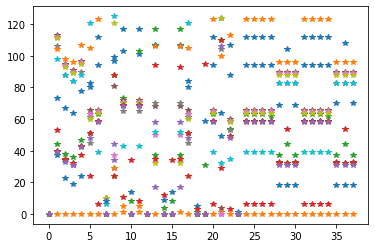

client_id=4, data_str={"RPC":{"function_name":"rpc_list_programs"}}
Calling rpc_list_programs with args=[]
client_id=4, data_str={"RPC":{"function_name":"rpc_load_program","function_args":["ecg"]}}
Calling rpc_load_program with args=['ecg']
New connection at ID 5 ('192.168.0.107', 57469)
client_id=5, data_str={"RPC":{"function_name":"rpc_update_status"}}
Calling rpc_update_status with args=[]
Client ('192.168.0.107', 59135) has disconnected
client_id=5, data_str={"RPC":{"function_name":"rpc_atf_watchpoint_set_active","function_args":[1,false]}}
Calling rpc_atf_watchpoint_set_active with args=[1, False]
rpc_atf_watchpoint_set_active index=1 state=False
client_id=5, data_str={"RPC":{"function_name":"rpc_atf_watchpoint_set_active","function_args":[0,true]}}
Calling rpc_atf_watchpoint_set_active with args=[0, True]
rpc_atf_watchpoint_set_active index=0 state=True
client_id=5, data_str={"RPC":{"function_name":"rpc_list_programs"}}
Calling rpc_list_programs with args=[]
client_id=5, data_str

In [19]:
plt.plot(anomaly_detection.dataset.T, linestyle='', marker="*")

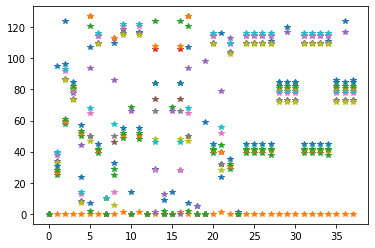

In [20]:
plt.plot(anomaly_detection.dataset.T, linestyle='', marker="*")

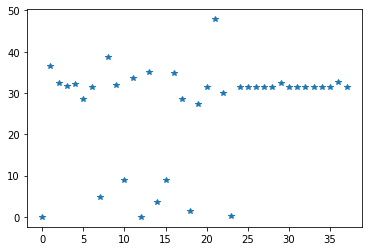

In [17]:
plt.plot(anomaly_detection.dataset.std(axis=0), linestyle='', marker="*")

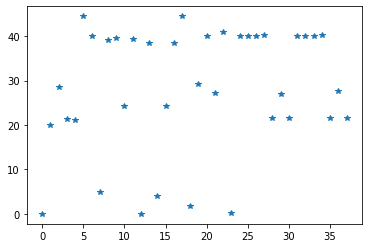

client_id=5, data_str={"RPC":{"function_name":"rpc_atf_watchpoint_set_active","function_args":[1,false]}}
Calling rpc_atf_watchpoint_set_active with args=[1, False]
rpc_atf_watchpoint_set_active index=1 state=False
client_id=5, data_str={"RPC":{"function_name":"rpc_atf_watchpoint_set_active","function_args":[0,true]}}
Calling rpc_atf_watchpoint_set_active with args=[0, True]
rpc_atf_watchpoint_set_active index=0 state=True
client_id=5, data_str={"RPC":{"function_name":"rpc_list_programs"}}
Calling rpc_list_programs with args=[]
client_id=5, data_str={"RPC":{"function_name":"rpc_load_program","function_args":["ecg"]}}
Calling rpc_load_program with args=['ecg']
client_id=5, data_str={"RPC":{"function_name":"rpc_reset_dataset"}}
Calling rpc_reset_dataset with args=[]
New connection at ID 6 ('192.168.0.107', 52803)
client_id=6, data_str={"RPC":{"function_name":"rpc_update_status"}}
Calling rpc_update_status with args=[]
Client ('192.168.0.107', 57469) has disconnected
New connection at ID 

client_id=20, data_str={"RPC":{"function_name":"rpc_run"}}
Calling rpc_run with args=[]
client_id=20, data_str={"RPC":{"function_name":"rpc_halt"}}
Calling rpc_halt with args=[]
client_id=20, data_str={"RPC":{"function_name":"rpc_list_programs"}}
Calling rpc_list_programs with args=[]
client_id=20, data_str={"RPC":{"function_name":"rpc_load_program","function_args":["ecg"]}}
Calling rpc_load_program with args=['ecg']
client_id=20, data_str={"RPC":{"function_name":"rpc_run"}}
Calling rpc_run with args=[]
client_id=20, data_str={"RPC":{"function_name":"rpc_enable_testing"}}
Calling rpc_enable_testing with args=[]
Client ('192.168.0.107', 63307) has disconnectedClient ('192.168.0.107', 49413) has disconnected
Client ('192.168.0.107', 63464) has disconnected
Client ('192.168.0.107', 64253) has disconnected
Client ('192.168.0.107', 55932) has disconnectedClient ('192.168.0.107', 61382) has disconnected

Client ('192.168.0.107', 58911) has disconnected
Client ('192.168.0.107', 64660) has dis

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/xilinx/jupyter_notebooks/tcp_server.py", line 166, in send_worker
    client.socket.send(data)
ConnectionResetError: [Errno 104] Connection reset by peer

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/xilinx/jupyter_notebooks/tcp_server.py", line 171, in send_worker
    self.connections.pop(client_id)
KeyError: -1


Error sending data to client -1: [Errno 104] Connection reset by peer
New connection at ID 31 ('192.168.0.107', 65521)
client_id=31, data_str={"RPC":{"function_name":"rpc_update_status"}}
Calling rpc_update_status with args=[]
New connection at ID 32 ('192.168.0.107', 57100)
client_id=32, data_str={"RPC":{"function_name":"rpc_update_status"}}
Calling rpc_update_status with args=[]


In [21]:
plt.plot(anomaly_detection.dataset.std(axis=0), linestyle='', marker="*")

NameError: name 'performance_event_names' is not defined

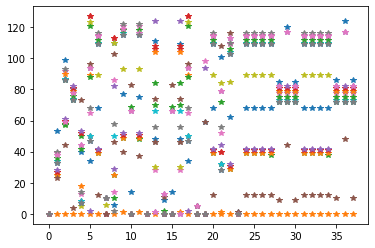

In [5]:
plt.plot(anomaly_detection.dataset.T, linestyle='', marker="*")

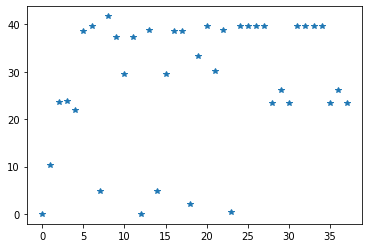

In [6]:
plt.plot(anomaly_detection.dataset.std(axis=0), linestyle='', marker="*")

In [9]:
pd.DataFrame(anomaly_detection.dataset, columns=used_events)

Core__TRAP  Core__BRANCH  Core__JAL  Core__JALR  Core__AUIPC  Core__LOAD  \
0          0.0          53.0       99.0        80.0         40.0        34.0   
1          0.0           0.0        0.0         0.0          0.0         0.0   
2          0.0          25.0       58.0        79.0         50.0       121.0   
3          0.0          27.0       60.0        81.0         52.0       127.0   
4          0.0          38.0       59.0        78.0         44.0        94.0   
5          0.0          34.0       87.0        74.0          8.0        50.0   
6          0.0          39.0       92.0        79.0         13.0        65.0   
7          0.0          40.0       93.0        80.0         14.0        68.0   
8          0.0          25.0       86.0        73.0          5.0       123.0   
9          0.0          34.0       87.0        74.0          8.0        50.0   
10         0.0          33.0       86.0        73.0          7.0        47.0   
11         0.0          25.0       90.0        79.0         18.0        89.0   
12         0.0          36.0       57.0        76.0         42.0        88.0   
13         0.0          27.0       60.0        81.0         52.0       127.0   
14         0.0          28.0       61.0        82.0         53.0         2.0   
15         0.0          23.0       44.0         4.0         73.0        96.0   
16         0.0          38.0       59.0        78.0         44.0        94.0   
17         0.0          33.0       86.0        73.0          7.0        47.0   

    Core__STORE  Core__SERIAL_SHIFT  Core__LOAD_WAIT  Core__STORE_WAIT  ...  \
0          68.0                 0.0            110.0              77.0  ...   
1           0.0                 0.0              0.0               1.0  ...   
2          39.0                 0.0             25.0              49.0  ...   
3          41.0                 0.0            113.0              51.0  ...   
4         114.0                10.0             82.0             119.0  ...   
5         110.0                10.0             46.0             116.0  ...   
6         115.0                10.0             14.0             121.0  ...   
7         116.0                10.0             58.0             122.0  ...   
8          89.0                 6.0            110.0              93.0  ...   
9         110.0                10.0             50.0             116.0  ...   
10        109.0                10.0              6.0             115.0  ...   
11         39.0                 0.0             25.0              49.0  ...   
12        112.0                10.0             10.0             118.0  ...   
13         41.0                 0.0            113.0              51.0  ...   
14         42.0                 0.0             29.0              52.0  ...   
15         12.0                 0.0            103.0              40.0  ...   
16        114.0                10.0             86.0             119.0  ...   
17        109.0                10.0              2.0             115.0  ...   

    AXI4_Slave__AR_FLIT  AXI4_Slave__R_FLIT  AXI4_Slave__R_FLIT_FINAL  \
0                  85.0               120.0                      85.0   
1                   0.0                 0.0                       0.0   
2                  79.0                79.0                      79.0   
3                  81.0                81.0                      81.0   
4                  82.0               117.0                      82.0   
5                  73.0                73.0                      73.0   
6                  78.0                78.0                      78.0   
7                  79.0                79.0                      79.0   
8                  72.0                72.0                      72.0   
9                  73.0                73.0                      73.0   
10                 72.0                72.0                      72.0   
11                 79.0                79.0                      79.0   
12                 75.0         

In [5]:
anomaly_detection.dataset[0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [22]:
1

1

client_id=32, data_str={"RPC":{"function_name":"rpc_list_programs"}}
Calling rpc_list_programs with args=[]


In [132]:
def send_test(val):
    tcp_server.send_to_all(
        json.dumps({
            'add_points' : {
                'test' : [val]
            }
        })
    )
    
for i in range(5):
    send_test(1)
    time.sleep(0.1)
    send_test(0)
    time.sleep(0.1)

#send_test(0)
#send_test(1)


In [130]:
send_test(0)

In [131]:
send_test(1)

In [ ]:
anomaly_detection.get_dataset_size()

# Advanced trace filter (ATF) testing

In [2]:
gpio_rst_n_out.write(0)

seeds = [
      #177711519189312448730221354182231558637597247368997856568353600156165082445924819823086537219813803655034425629222957323519789380881194761015097109113643492436494853351158801548809156587381022653656419362316880053721686257530213295492302669648879908944155843661259355247416136342707255439323305353187196384197

    #     97081571863202119540470995029932637987382626048125687395340616282408632421277679546841495729477368094495309346930269433005263784085567995676967413458616276771557870749853558953668198221519854005958192694960818014644861142877940285940418374394054218041391691990482562200656727048780580334389685158025765443103,
#     72988107250237495920102714721503671840119863320115041683284531007689094102132598416320545594765641915178544865414967713102711085720852615743397925981381353282342725210089676502129828507026310241957836986390459284800711987057378064364236224455662089777969480543544087753566469674185432144927462598143211900517,
#     106738977566983570110852620103400377292300453533011930141192199599635355298019566489684667006901891008645206022308884524698672777156607193011201304696737478287933507774884537488656010294279259572309150944453315991769055525611886872257222021232796393976378766870457343819513999607183988917017181317401129555928,
#     169792675614791427976691633934932484586471498037900305609681272694122116775948066266882052337887995216909734192970940273795107953077453183798027110768376688442875847747615398585154418296643575223613186058178239082384113881177527628936523102969662509304773940933200420209467102324760081730668971104131876503488
      
 #     2052950319899599258844377867017230206378980133563126191904312393062443451669541340282095508
    ]            
#reset_all_seeds_and_ranges()

#values_dict = {'pc': 0x80000000, 'A0': 0x80000000, 'A1': 0x80000000, 'A2': 0x80000000, 'A3': 0x80000000}


#for i, seed in enumerate(seeds):
#    cms_ctrl.set_atf_seed(seed, i, seed_bit_width=1024)

#cms_ctrl.set_atf_range(seed_address=0, range_address=0, lower_bound=512, upper_bound=512)



In [12]:
#cms_ctrl.set_atf_match_watchpoint(0, {'pc':0x80000198, 'A0':1000})
seed,mask,range_ = cms_ctrl.set_atf_match_watchpoint(0, {'pc':0x80000760, 'A0': 1000})
#cms_ctrl.set_atf_match_watchpoint(0, {'pc':0x80000760, 'A0':1000})

#cms_ctrl.set_atf_match_watchpoint(1, {'pc':0x80000760, 'A0':8})
#seed,mask,range_ = cms_ctrl.set_atf_match_watchpoint(1, {'pc':0x80000760}) # one direct match watchpoint per seed address only

# TODO: add masks={} to "set_atf_match_watchpoint"
#cms_ctrl.set_atf_match_watchpoint(1, {'pc':0x80000104, 'A0':0xFFFFFFFF}, masks={'A0': 0b11})

In [162]:
from continuous_monitoring_system_controller import create_seed_mask_and_range_for_values

In [25]:
cms_ctrl.set_atf_match_watchpoint(0, {'pc':0x80000760})

(2147485536, 18446744073709551615, 64)

In [32]:
cms_ctrl.set_atf_match_watchpoint(0, {'pc':0x80000048, 'A0':1000}, masks={'A0': 0b11}))

(2147483720, 18446744073709551615, 64)

In [43]:
reset_all_seeds_and_ranges()

In [ ]:
seed,mask,range_ = create_seed_mask_and_range_for_values({'pc':0x80000760, 'A0':1000})
print(f'{seed:b} 0x{seed:X}')
print(f'{mask:b} 0x{mask:X}')
print(range_)

In [39]:
cms_ctrl.set_atf_range(seed_address=0, range_address=0, lower_bound=520, upper_bound=521)
cms_ctrl.set_atf_range(seed_address=0, range_address=1, lower_bound=499, upper_bound=499)

In [13]:
cms_ctrl.set_atf_range(seed_address=0, range_address=0, lower_bound=506, upper_bound=506)

In [4]:
cms_ctrl.set_atf_mode(ATF_MODE.ANOMALY_DETECTION)
cms_ctrl.set_atf_mode(ATF_MODE.PATTERN_COLLECTION)

In [85]:
cms_ctrl.disable_atf()

In [16]:
cms_ctrl.disable_halting_cpu()

In [32]:
gpio_rst_n_out.write(0)
cms_ctrl.enable_halting_cpu()
#cms_ctrl.disable_halting_cpu()
bram_loader.load(PROGRAMS_DIR / 'ECG/ecg_baseline.bin')

In [36]:
gpio_rst_n_out.write(0)
cms_ctrl.enable_halting_cpu()
bram_loader.load(PROGRAMS_DIR / 'ECG/ecg_info_leak.bin')

In [31]:
gpio_rst_n_out.write(0)

In [41]:
reset_cpu()

In [25]:
items_transferred = get_dma_transfer(input_buffer, dma_rec) - 1 
items_transferred

0

In [24]:
events, events_overflows, pcs, clk_counters, instrs, instr_names, instr_strings, fifo_full_ticks_counts, all_gp_regs = parse_input_buffer(input_buffer, items_transferred, dont_decode=True)
df = pd.DataFrame(zip(pcs,clk_counters,instrs,instr_names,instr_strings,fifo_full_ticks_counts), columns=['pc','clk_counter','instr', 'instr_names', 'instr_strings', 'fifo_full_ticks_counts'])
# all_gp_regs is a list of dicts, it is joined below into the main dataframe
df = df.join( pd.DataFrame.from_dict(all_gp_regs) )
df.iloc[:,0] = df.iloc[:,0].apply(lambda x: f'{x:08X}')
df.iloc[:items_transferred]

0.00019073486328125s
0.00016570091247558594s
0.00013947486877441406s
0.00013327598571777344s
0.00012803077697753906s
0.00017142295837402344s
0.0001888275146484375s
0.00016307830810546875s
0.0001437664031982422s
0.0001361370086669922s
0.00013184547424316406s
0.00012969970703125s
0.00012969970703125s
0.0001430511474609375s
0.0002048015594482422s
0.00014090538024902344s
0.00013780593872070312s


pc  clk_counter     instr instr_names instr_strings  \
0   80000768     50051943  50398227        ADDI             -   
1   80000768     50051943  50398227        ADDI             -   
2   80000768     50052008  50398227        ADDI             -   
3   80000768     50051943  50398227        ADDI             -   
4   80000768     50051943  50398227        ADDI             -   
5   80000768     50051943  50398227        ADDI             -   
6   80000768     50051943  50398227        ADDI             -   
7   80000768     50051943  50398227        ADDI             -   
8   80000768     50051943  50398227        ADDI             -   
9   80000768     50052008  50398227        ADDI             -   
10  80000768     50051943  50398227        ADDI             -   
11  80000768     50051943  50398227        ADDI             -   
12  80000768     50051943  50398227        ADDI             -   
13  80000768    164593723  50398227        ADDI             -   
14  80000768     50051946  50398227        ADDI             -   
15  80000768     50051943  50398227        ADDI             -   
16  80000768     50051943  50398227        ADDI             -   

    fifo_full_ticks_counts    A0          A1                   A2          A3  
0                        0  1000  2147551272  5063528411713059128  2147551272  
1                        0  1000  2147551272  5063528411713059128  2147551272  
2                        0  1000  2147551272  5063528411713059128  2147551272  
3                        0  1000  2147551272  5063528411713059128  2147551272  
4                        0  1000  2147551272  5063528411713059128  2147551272  
5                        0  1000  2147551272  5063528411713059128  2147551272  
6                        0  1000  2147551272  5063528411713059128  2147551272  
7                        0  1000  2147551272  5063528411713059128  2147551272  
8                        0  1000  2147551272  5063528411713059128  2147551272  
9                        0  1000  2147551272  5063528411713059128  2147551272  
10                       0  1000  2147551272  5063528411713059128  2147551272  
11                       0  1000  2147551272  5063528411713059128  2147551272  
12                       0  1000  2147551272  5063528411713059128  2147551272  
13                       0  1000  2147551272  5063528411713059128  2147551272  
14                       0  1000  2147551272  5063528411713059128  2147551272  
15                       0  1000  2147551272  5063528411713059128  2147551272  
16                       0  1000  2147551272  5063528411713059128  2147551272

In [23]:
chunks_per_item = math.ceil(AXI_DATA_WIDTH/64)
patterns = []
start = 0
end = chunks_per_item
for i in range(items_transferred-1):
    fifo_item = int.from_bytes(bytes(input_buffer[start:end]), byteorder='little') 
    patterns.append(fifo_item)
    start += chunks_per_item
    end += chunks_per_item

In [24]:
patterns[:2]

[17129200268340738932739219661317113231379390147163745841017112448663045225254406772015943838050136094427070268058986149859644225256751037194134720027616382114906659192112924684453866752,
 17129200268340738932739219661317113231379390147163745841017112440960006422047372605094636258983776112832440553338199952209086320252683566844406834820223159826442264047011038883970302080]

In [17]:
patterns[:2]

[2052950319899599258817417920350076427934682990491451377594235296617986618231413939221041168,
 2052950319899599258817417920350076427934682990491451377594235296614962403667737776347938816]

In [69]:
#reset_all_seeds_and_ranges()
#for i, seed in enumerate(seeds):
#    cms_ctrl.set_atf_seed(seed, i, seed_bit_width=1024)
for i in range(495, 530):
    #print(i, end = ', ')
    cms_ctrl.set_atf_range(seed_address=1, range_address=0, lower_bound=i, upper_bound=i)
    #get_dma_transfer(input_buffer, dma_rec)
    time.sleep(1)
    items_transferred = get_dma_transfer(input_buffer, dma_rec)
    if items_transferred > 1:
        print(i, f'= {items_transferred} items')
    #print()

502 = 2 items
503 = 66 items
505 = 517 items
506 = 1033 items
507 = 20 items
508 = 3 items
509 = 148 items
510 = 13 items
511 = 12 items
512 = 13 items
513 = 5 items
514 = 2000 items
515 = 1550 items
516 = 2005 items
517 = 2005 items
518 = 2005 items
519 = 24 items
520 = 66 items
521 = 2 items
522 = 2 items


In [130]:
cms_ctrl.set_atf_range(seed_address=0, range_address=0, lower_bound=0, upper_bound=1024)

In [149]:
for i in range(10):
    time.sleep(0.1)
    items_transferred = get_dma_transfer(input_buffer, dma_rec)
    print(items_transferred)

2005
203
207
205
203
207
203
203
203
203


In [132]:
items_transferred

2005

In [11]:
for i in range(490, 520):
    print(i, end = ', ')
    cms_ctrl.set_atf_range(seed_address=0, range_address=0, lower_bound=i, upper_bound=i)
    get_dma_transfer(input_buffer, dma_rec)
    time.sleep(0.5)
    items_transferred = get_dma_transfer(input_buffer, dma_rec)
    if items_transferred > 1:
        print(items_transferred, 'items', end=', ')
    print()

490, 
491, 
492, 
493, 
494, 2006 items, 
495, 517 items, 
496, 73 items, 
497, 241 items, 
498, 145 items, 
499, 147 items, 
500, 149 items, 
501, 110 items, 
502, 106 items, 
503, 70 items, 
504, 41 items, 
505, 27 items, 
506, 17 items, 
507, 10 items, 
508, 8 items, 
509, 4 items, 
510, 2 items, 
511, 
512, 
513, 
514, 
515, 
516, 
517, 
518, 
519, 


In [23]:
for i in range(470, 500): #(490, 520):
    print(i, end = ', ')
    cms_ctrl.set_atf_range(seed_address=0, range_address=0, lower_bound=i, upper_bound=i)
    get_dma_transfer(input_buffer, dma_rec)
    time.sleep(0.5)
    items_transferred = get_dma_transfer(input_buffer, dma_rec)
    if items_transferred > 1:
        print(items_transferred, 'items', end=', ')
    print()

470, 
471, 
472, 
473, 
474, 
475, 
476, 
477, 
478, 
479, 
480, 
481, 
482, 
483, 
484, 4 items, 
485, 
486, 2006 items, 
487, 2005 items, 
488, 
489, 10 items, 
490, 503 items, 
491, 11 items, 
492, 
493, 584 items, 
494, 
495, 14 items, 
496, 
497, 
498, 
499, 


2005

In [161]:
chunks_per_item = math.ceil(AXI_DATA_WIDTH/64)
patterns = []
for j in range(1000):
    print(j, end=',')
    items_transferred = get_dma_transfer(input_buffer, dma_rec) - 1
    start = 0
    end = chunks_per_item
    for i in range(items_transferred-1):
        fifo_item = int.from_bytes(bytes(input_buffer[start:end]), byteorder='little') 
        patterns.append(fifo_item)
        start += chunks_per_item
        end += chunks_per_item

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,27

In [162]:
df_patterns = pd.DataFrame(patterns)

In [75]:
df_patterns.value_counts()

2052950319899599258844377867017230206378980133563126191904312467009835289303872679310264224    29720
2052950319899599258844377867017230206378980133563126191904312388101580933132288999536199552    29683
2052950319899599258817417920350079566584313118476106561230702815080201337076977448771387796       64
2052950319899599258817417920350079566584336502502303855677394074042998832015677105715020284       64
2052950319899599258817417920350079566584336502502303855677394152655238728758301379736371712       64
2052950319899599258817417920350079566584336502502303855677394150286216580322844046348255736       64
2052950319899599258817417920350079566584336502502303855677394152956809937798072461141475676       62
2052950319899599258817417920350079566584336502502303855677388765441758967823116100152852828       60
2052950319899599258817417920350079566584336502502303855677388765140187758783345018747748796       60
2052950319899599258817417920350079566584336502502303855677388764086476902088604227439952308

In [163]:
df_patterns.value_counts()

2052950319899599258844377867017230206378980133563126191904312467009835289303872679310264224    1001518
2052950319899599258844377867017230206378980133563126191904312388101580933132288999536199552    1000277
2052950319899599258844377867017230206378980133563126191904312388101616424667886816713508752        241
2052950319899599258844377867017230206378980133563126191904312388488438892509425116720924540        241
2052950319899599258844377867017230206378980133563126191904312393062443451669541340282095508        241
2052950319899599258844377867017230206378980133563126191904312466390865269661182541860702136        241
2052950319899599258844377867017230206378980133563126191904312466715836099771477894652495736        241
2052950319899599258844377867017230206378980133563126191904312466870613432134961592648337316        241
dtype: int64

0,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000,130000,140000,150000,160000,170000,180000,

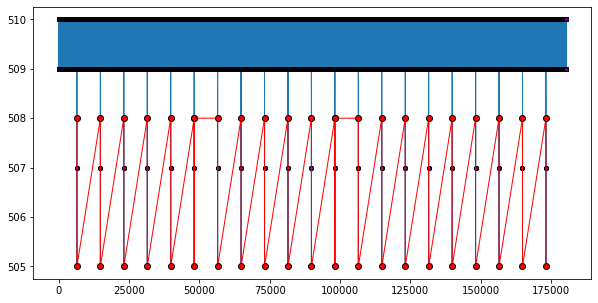

In [21]:
#advanced_trace_filter.plot_similarities(patterns[:10], seed_values[:1])
plot_similarities(patterns, seeds[:1])

In [6]:
def bits_in_int(n, bit_type=1, bits_size=1024):
    count = 0
    while n:
        n &= n - 1
        count += 1
    if bit_type == 0:
        return bits_size - count
    return count

def calculate_similarities(pattern_series, seed_value, bits_size=1024):
    similarities = []
    for i, val in enumerate(pattern_series):
        if i % 10000 == 0:
            print(i, end=',')
        similarity = bits_in_int(val ^ seed_value, bit_type=0, bits_size=bits_size) 
        similarities.append(similarity)
    return similarities

def plot_similarities(pattern_series, seed_values, frequency_threshold=40):
    subplots_count = len(seed_values)
    fig, axs = plt.subplots(subplots_count, 1, figsize=(10, 10))
    if subplots_count == 1:
        axs = [axs]
    for i in range(subplots_count):
        similarities = pd.Series( calculate_similarities(pattern_series, seed_values[i]) )
        # df[f'similarities_{i}'].plot(ax=axs[i], marker='o', markersize=2, linestyle='None', figsize=(10, 5))
        value_counts = similarities.value_counts() 
        indices_to_keep = similarities[ similarities.apply(lambda x: value_counts[x] < frequency_threshold) ].index
        similarities.plot(ax=axs[i], marker='o', markersize=4, linestyle='-', linewidth=1, markerfacecolor='purple', markeredgecolor='black', figsize=(10, 5))
        similarities.loc[indices_to_keep].plot(ax=axs[i], marker='o', markersize=6, linestyle='-', linewidth=1, color='red', markerfacecolor='red', markeredgecolor='black', figsize=(10, 5))
    fig.show()
    plt.show()

In [ ]:
fifo_item = int.from_bytes(bytes(input_buffer[start:end]), byteorder='little')


In [42]:
chunks_per_item = math.ceil(AXI_DATA_WIDTH/64)
# CLK_LOCATION = PERFORMANCE_EVENTS_COUNT * PERFORMANCE_COUNTER_WIDTH + PERFORMANCE_COUNTERS_OVERFLOW_MAP_WIDTH + PC_WIDTH
# HALTED_CLK_LOCATION = CLK_LOCATION + CLK_COUNTER_WIDTH + INSTR_WIDTH
total_clk_time = 0
total_halted_time = 0
items_transferred = 0

class MODE:
    # these can be used with bitwise operators (need to be careful if new modes are added)
    IDLE = 0
    TRAINING = 0b1
    TESTING = 0b10
    TRAINING_AND_TESTING = 0b11
    
#mode = MODE.TRAINING
mode = MODE.TESTING
#mode = MODE.TRAINING_AND_TESTING

#if mode == MODE.TRAINING:
#    anomaly_detection = Anomaly_Detection(39)

#anomaly_detection = Anomaly_Detection(39)

similarities = []

for i in range(10):
    while items_transferred < 2:
#         dma_rec.transfer(input_buffer)
#         dma_rec.wait()
#         items_transferred = math.floor(dma_rec.transferred * 64 / AXI_DATA_WIDTH / 8)
        items_transferred = get_dma_transfer(input_buffer, dma_rec)
        time.sleep(0.001)
        continue
    
    #events, events_overflows, pcs, clk_counters, instrs, instr_names, instr_strings, fifo_full_ticks_counts, all_gp_regs = parse_input_buffer(input_buffer, items_transferred, dont_decode=True)
    print(items_transferred, end=', ')
    
#     events, events_overflows, pcs, clk_counters, instrs, instr_names, instr_strings, fifo_full_ticks_counts, all_gp_regs = parse_input_buffer(input_buffer, items_transferred, dont_decode=True)
#     df = pd.DataFrame(zip(pcs,clk_counters,instrs,instr_names,instr_strings,fifo_full_ticks_counts), columns=['pc','clk_counter','instr', 'instr_names', 'instr_strings', 'fifo_full_ticks_counts'])
#     # all_gp_regs is a list of dicts, it is joined below into the main dataframe
#     df = df.join( pd.DataFrame.from_dict(all_gp_regs) )
#     df.iloc[:,0] = df.iloc[:,0].apply(lambda x: f'{x:08X}')
#     print( df.iloc[:items_transferred] )
    
        
    start = 0
    end = chunks_per_item
    time_checkpoint = time.time()
    for i in range(items_transferred-1):
        fifo_item = int.from_bytes(bytes(input_buffer[start:end]), byteorder='little')            
        
#         clk_count = (fifo_item >> CLK_LOCATION) & ((1 << 64)-1)
#         halted_clk_count = (fifo_item >> HALTED_CLK_LOCATION) & ((1 << 64)-1)
        
        perf_counters, perf_counters_overflow_map, pc, clk_counter, instr, fifo_full_ticks_count, gp_regs = parse_fifo_item(fifo_item)

        #print(perf_counters)
        if mode & MODE.TESTING:
            similarity = anomaly_detection.get_max_cosine_similarity(perf_counters)
            similarities.append(similarity)
        if mode & MODE.TRAINING:
            anomaly_detection.update_dataset(perf_counters)
            
        #print(perf_counters)
#         if i != 0:
#             total_clk_time += clk_count
#             total_halted_time += halted_clk_count
        total_clk_time += clk_counter
        total_halted_time += fifo_full_ticks_count
        start += chunks_per_item
        end += chunks_per_item
#         print(hex(pc), hex(instr), clk_counter, fifo_full_ticks_count)
    time.sleep(1)
    items_transferred = 0
    print(f'dataset size = {anomaly_detection.get_dataset_size()}', end=', ')
    print(f'{time.time() - time_checkpoint}s')
    

print(f'Total clk_count = {total_clk_time / CLK_SPEED}s')
print(f'Total halted_time = {total_halted_time / CLK_SPEED}s')


    
s = '''    for i in range(PERFORMANCE_EVENTS_COUNT):
        fifo_item, perf_counter = pop_n_bits_value(fifo_item, PERFORMANCE_COUNTER_WIDTH)
        perf_counters.append(perf_counter)
    fifo_item, perf_counters_overflow_map = pop_n_bits_value(fifo_item, PERFORMANCE_COUNTERS_OVERFLOW_MAP_WIDTH)
    fifo_item, pc = pop_n_bits_value(fifo_item, PC_WIDTH)
    fifo_item, clk_counter = pop_n_bits_value(fifo_item, CLK_COUNTER_WIDTH)
    fifo_item, instr = pop_n_bits_value(fifo_item, INSTR_WIDTH)
    fifo_item, fifo_full_ticks_count = pop_n_bits_value(fifo_item, FIFO_FULL_TICKS_COUNT_WIDTH)
'''

14, dataset size = 158, 1.0121643543243408s
2, dataset size = 158, 1.0020756721496582s
2, dataset size = 158, 1.0020813941955566s
26, dataset size = 158, 1.039628028869629s
125, dataset size = 158, 1.1846489906311035s
143, dataset size = 158, 1.2143023014068604s
146, dataset size = 158, 1.2242939472198486s
72, dataset size = 158, 1.1145339012145996s
2, dataset size = 158, 1.002115249633789s
2, dataset size = 158, 1.0033338069915771s
Total clk_count = 368934881418.8157s
Total halted_time = 0.0s


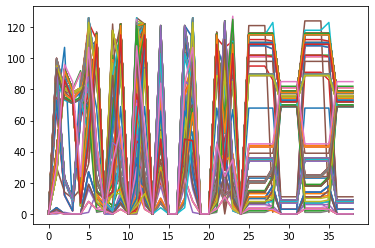

In [55]:
plt.plot(anomaly_detection.dataset.T)

# testing with ecg_baseline.bin

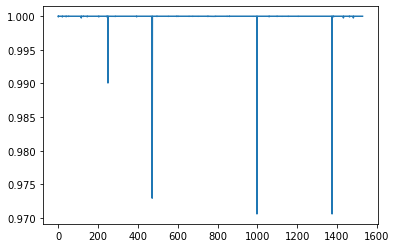

In [30]:
plt.plot(similarities)

# testing with ecg_baseline.bin (after reloading it into memory and resetting processor)

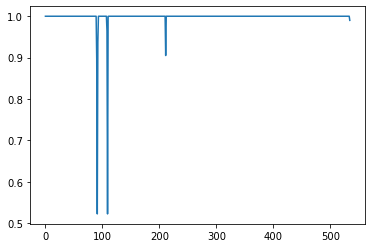

In [35]:
plt.plot(similarities)

# testing with ecg_info_leak.bin

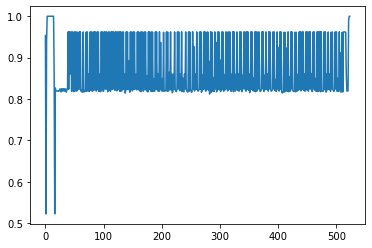

In [43]:
plt.plot(similarities)

In [58]:
anomaly_detection.dataset[:3,:5]

array([[  0.,  66., 107.,   2.,  89.],
       [  0.,  89.,  81.,  79.,  91.],
       [  0.,  90.,  82.,  80.,  92.]])

In [47]:
hex(input_buffer[start])

'0x0'

In [24]:
items_transferred = 50

In [27]:
events, events_overflows, pcs, clk_counters, instrs, instr_names, instr_strings, fifo_full_ticks_counts, all_gp_regs = parse_input_buffer(input_buffer, items_transferred, dont_decode=True)
df = pd.DataFrame(zip(pcs,clk_counters,instrs,instr_names,instr_strings,fifo_full_ticks_counts), columns=['pc','clk_counter','instr', 'instr_names', 'instr_strings', 'fifo_full_ticks_counts'])
# all_gp_regs is a list of dicts, it is joined below into the main dataframe
df = df.join( pd.DataFrame.from_dict(all_gp_regs) )
df.iloc[:,0] = df.iloc[:,0].apply(lambda x: f'{x:08X}')
df.iloc[:items_transferred]

0.00022792816162109375s
0.00022602081298828125s
0.0001590251922607422s


pc           clk_counter       instr instr_names  \
0          80000764  18446744073709551615    42021923     UNKNOWN   
1          80000768                     1    50398227        ADDI   
2  FFFFFFFFFFFFFFFF  18446744073709551615  4294967295     UNKNOWN   

  instr_strings  fifo_full_ticks_counts                    A0  \
0             -                       0                  1000   
1             -                       0                  1000   
2             -    18446744073709551615  18446744073709551615   

                     A1                    A2                    A3  
0                  4128                     0                     0  
1                  4128                     0                     0  
2  18446744073709551615  18446744073709551615  18446744073709551615

In [4]:
gpio_rst_n_out.write(0)
cms_ctrl.enable_halting_cpu()
bram_loader.load(PROGRAMS_DIR / 'ECG/ecg_baseline.bin')
df, stdout = run_and_collect("", input_buffer=input_buffer, dont_decode=True, execution_time_limit=15)
gpio_rst_n_out.write(0)

Initiating DMA transfer i=0
Transfer 1 finished, items_transferred=43824, parsing...
Execution time limit (15ms) was reached, tracing is stopped. (execution time=10959.895859999999ms)
All DMA transfers completed, total_items=43824, converting lists to dataframe...
Dataframe is ready


In [8]:
print_performance_stats(df)

normal_run_time = 10.95989586s
halted_time = 0.0s
performance_decrease = 0.0%


# Collecting training data for analysis
Trying to find infrequent patterns (e.g. happening between around 1-100ms)

In [2]:
gpio_rst_n_out.write(0)
cms_ctrl.enable_halting_cpu()
bram_loader.load(PROGRAMS_DIR / 'ECG/ecg_baseline.bin')
df, stdout = run_and_collect("", input_buffer=input_buffer, dont_decode=True, execution_time_limit=15)
gpio_rst_n_out.write(0)

Initiating DMA transfer i=0
Transfer 1 finished, items_transferred=43824, parsing...
execution_time_ms = 5.51846
Initiating DMA transfer i=1
Transfer 2 finished, items_transferred=43824, parsing...
execution_time_ms = 10.9406
Initiating DMA transfer i=2
Transfer 3 finished, items_transferred=43824, parsing...
Execution time limit (15ms) was reached, tracing is stopped. (execution time=16.197960000000002ms)
All DMA transfers completed, total_items=131472, converting lists to dataframe...
Dataframe is ready


In [3]:
df.to_csv('ecg_data.csv')

client_id=0, data_str={"RPC":{"function_name":"rpc_list_programs"}}
Calling rpc_list_programs with args=[]
client_id=0, data_str={"RPC":{"function_name":"rpc_load_program","function_args":["ecg_baseline"]}}
Calling rpc_load_program with args=['ecg_baseline']
client_id=0, data_str={"RPC":{"function_name":"rpc_run"}}
Calling rpc_run with args=[]


# TCP server

In [8]:
tcp_server.send_to_all(json.dumps({'status_update':{
    'pynq_restarted':True
}}))

client_id=3, data_str={"RPC":{"function_name":"rpc_list_programs"}}
Calling rpc_list_programs with args=[]
client_id=3, data_str={"RPC":{"function_name":"rpc_load_program","function_args":["ecg_baseline"]}}
Calling rpc_load_program with args=['ecg_baseline']
client_id=3, data_str={"RPC":{"function_name":"rpc_list_programs"}}
Calling rpc_list_programs with args=[]
client_id=3, data_str={"RPC":{"function_name":"rpc_load_program","function_args":["ecg_info_leak"]}}
Calling rpc_load_program with args=['ecg_info_leak']
Client ('192.168.0.103', 60124) has disconnected
New connection at ID 4 ('192.168.0.103', 50078)
client_id=4, data_str={"RPC":{"function_name":"rpc_list_programs"}}
Calling rpc_list_programs with args=[]
client_id=4, data_str={"RPC":{"function_name":"rpc_load_program","function_args":["ecg_info_leak"]}}
Calling rpc_load_program with args=['ecg_info_leak']
client_id=4, data_str={"RPC":{"function_name":"rpc_list_programs"}}
Calling rpc_list_programs with args=[]
client_id=4, da

In [2]:

for k in range(100):
    for j in range(3):
        msg = {}
        msg['add_points'] = {f'test_{j}':[]}
        for i in range(3):
            val = round(random.uniform(0.0,0.1) + 0.2 * (j+0.5), 3)
            msg['add_points'][f'test_{j}'].append(val)
        tcp_server.send_to_all( json.dumps(msg) + '\n' ) 
    print(j)

2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


# ECG testing (checking sensor values through console DMA)

In [54]:
gpio_rst_n_out.write(0)
bram_loader.load(BASE_DIR / 'ecg.bin')
cms_ctrl.disable_halting_cpu()

df, stdout = run_and_collect(stdin, input_buffer=input_buffer, dont_decode=True)

In [5]:
def parse_ecg_program_output(stdout):
    ''' This program sends 150 '\n' separated ecg sensor values.'''
    values = [int(val[::-1]) for val in stdout.split('\n')[:-1]] # stdout ends with '\n' so -1 is used to ignore it
    return pd.DataFrame(values, columns=['ECG'])

In [ ]:
for i in range(1):
    console_io.send('a')
    time.sleep(0.1)
    stdout = console_io.read(blocking=True)
    print(i, stdout)

In [20]:
df_ecg = parse_ecg_program_output(stdout)
send_sensors_data_to_all_tcp_clients(df_ecg, sensors_to_send=['ECG'])

In [21]:
stdout

'51582\n45372\n07282\n10472\n45682\n14372\n16082\n44182\n20172\n14482\n42672\n82182\n79282\n72372\n09482\n'

In [22]:
console_io.read()

'62572\n25082\n'

New connection at ID 2 ('192.168.0.103', 52899)


In [26]:
console_io.send('a')
start_time = time.time()

while (time.time() - start_time) < 3:
    stdout = console_io.read()
    if stdout:
        print(time.time() - start_time, '   ', stdout)

0.0013704299926757812     87615

0.008449316024780273     54353

0.01275014877319336     29212

0.015386819839477539     92502

0.02564072608947754     49743
40743

0.030405282974243164     29402

0.03536653518676758     05312

0.0403745174407959     39553

0.04530620574951172     66743

0.05030179023742676     42502

0.05529928207397461     29212

0.06015419960021973     88553

0.06521368026733398     20943

0.07058930397033691     31602



In [8]:
#while True:
for i in range(1000):
    console_io.send('a')
    time.sleep(0.1)
    stdout = console_io.read(blocking=True)
    df_ecg = parse_ecg_program_output(stdout)
    send_sensors_data_to_all_tcp_clients(df_ecg, sensors_to_send=['ECG'])
    #time.sleep(0.5)
    print(i, end=',')

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,27

In [30]:
df_ecg

ECG
0  13342
1  16781
2  16041

## Debugging ECG with libraries

In [48]:
# dma_rec.transfer(input_buffer)
# dma_rec.wait()
# items_transferred = math.floor(dma_rec.transferred * 64 / AXI_DATA_WIDTH / 8)
# items_transferred

43824

In [40]:
# items_transferred = 10

In [41]:
# events, events_overflows, pcs, clk_counters, instrs, instr_names, instr_strings, fifo_full_ticks_counts, all_gp_regs = parse_input_buffer(input_buffer, items_transferred, dont_decode=True)
# df = pd.DataFrame(zip(pcs,clk_counters,instrs,instr_names,instr_strings,fifo_full_ticks_counts), columns=['pc','clk_counter','instr', 'instr_names', 'instr_strings', 'fifo_full_ticks_counts'])
# # all_gp_regs is a list of dicts, it is joined below into the main dataframe
# df = df.join( pd.DataFrame.from_dict(all_gp_regs) )
# df.iloc[:,0] = df.iloc[:,0].apply(lambda x: f'{x:08X}')
# df

pc  clk_counter       instr instr_names instr_strings  \
0  800001B4           31  4277625059        BLTU             -   
1  80000194            1          19        ADDI             -   
2  800001B4           31  4277625059        BLTU             -   
3  80000194            1          19        ADDI             -   
4  800001B4           31  4277625059        BLTU             -   
5  80000194            1          19        ADDI             -   
6  800001B4           31  4277625059        BLTU             -   
7  80000194            1          19        ADDI             -   
8  800001B4           31  4277625059        BLTU             -   
9  80000194            1          19        ADDI             -   

   fifo_full_ticks_counts    A0    A1  A2  A3  
0                      20  1000  4128   0   0  
1                       0  1000  4128   0   0  
2                      20  1000  4128   0   0  
3                       0  1000  4128   0   0  
4                      20  1000  4128   0   0  
5                       0  1000  4128   0   0  
6                      20  1000  4128   0   0  
7                       0  1000  4128   0   0  
8                      20  1000  4128   0   0  
9                       0  1000  4128   0   0

In [52]:
# for i in range(1000):
#     dma_rec.transfer(input_buffer)
#     dma_rec.wait()
#     items_transferred = math.floor(dma_rec.transferred * 64 / AXI_DATA_WIDTH / 8)
#     print(items_transferred)

43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
43824
4382

# Test shadow GPR file

In [2]:
bram_loader.load(BASE_DIR / 'riscv-stack-mission.bin')
df, stdout = run_and_collect("====================A402008000000000", input_buffer=input_buffer, dont_decode=True)

Initiating DMA transfer i=0
Transfer 1 finished, items_transferred=2237, parsing...
All DMA transfers completed, total_items=2237, converting lists to dataframe...
Dataframe is ready


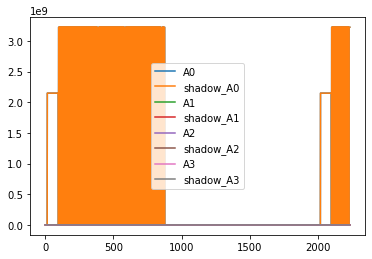

In [6]:
# df[['A0','shadow_A0','A1','shadow_A1','A2','shadow_A2','A3','shadow_A3']].plot()

In [9]:
# df[['A0','A1','A2','A3']].to_csv('A0-A3.csv')
# df[['shadow_A0','shadow_A1','shadow_A2','shadow_A3']].to_csv('A0-A3_shadow.csv')

In [10]:
df[[col for col in df.columns if ('shadow' in col or len(col) == 2)]].iloc[:50]

pc          A0    A1  A2  A3   shadow_A0  shadow_A1  shadow_A2  \
0       1010           0  4128   0   0           0       4128          0   
1   80000000           0  4128   0   0           0       4128          0   
2   80000004           0  4128   0   0           0       4128          0   
3   80000008           0  4128   0   0           0       4128          0   
4   80000010           0  4128   0   0           0       4128          0   
5   800005EC           0  4128   0   0           0       4128          0   
6   800005FC           0  4128   0   0           0       4128          0   
7   80000324           0  4128   0   0           0       4128          0   
8   80000328           0  4128   0   0           0       4128          0   
9   80000338           0  4128   0   0           0       4128          0   
10  80000360           0  4128   0   0           0       4128          0   
11  8000036C           0  4128   0   0           0       4128          0   
12  8000033C           0  4128   0   0           0       4128          0   
13  80000350           0  4128   0   0           0       4128          0   
14  80000304  2147487416  4128   0   0  2147487416       4128          0   
15  80000320  2147487416  4128   0   0  2147487416       4128          0   
16  80000354  2147487416  4128   0   0  2147487416       4128          0   
17  8000036C  2147487416  4128   0   0  2147487416       4128          0   
18  8000033C  2147487416  4128   0   0  2147487416       4128          0   
19  80000350  2147487424  4128   0   0  2147487416       4128          0   
20  80000304  2147487424  4128   0   0  2147487424       4128          0   
21  80000320  2147487424  4128   0   0  2147487424       4128          0   
22  80000354  2147487424  4128   0   0  2147487424       4128          0   
23  8000036C  2147487424  4128   0   0  2147487424       4128          0   
24  8000033C  2147487424  4128   0   0  2147487424       4128          0   
25  80000350  2147487432  4128   0   0  2147487424       4128          0   
26  80000304  2147487432  4128   0   0  2147487432       4128          0   
27  80000320  2147487432  4128   0   0  2147487432       4128          0   
28  80000354  2147487432  4128   0   0  2147487432       4128          0   
29  8000036C  2147487432  4128   0   0  2147487432       4128          0   
30  8000033C  2147487432  4128   0   0  2147487432       4128          0   
31  80000350  2147487440  4128   0   0  2147487432       4128          0   
32  80000304  2147487440  4128   0   0  2147487440       4128          0   
33  80000320  2147487440  4128   0   0  2147487440       4128          0   
34  80000354  2147487440  4128   0   0  2147487440       4128          0   
35  8000036C  2147487440  4128   0   0  2147487440       4128          0   
36  8000033C  2147487440  4128   0   0  2147487440       4128          0   
37  80000350  2147487448  4128   0   0  2147487440       4128          0   
38  80000304  2147487448  4128   0   0  2147487448       4128          0   
39  80000320  2147487448  4128   0   0  2147487448       4128          0   
40  80000354  2147487448  4128   0   0  2147487448       4128          0   
41  8000036C  2147487448  4128   0   0  2147487448       4128          0   
42  8000033C  2147487448  4128   0   0  2147487448       4128          0   
43  80000350  2147487456  4128   0   0  2147487448       4128          0   
44  80000304  2147487456  4128   0   0  2147487456       4128          0   
45  80000320  2147487456  4128   0   0  2147487456       4128          0   
46  80000354  2147487456  4128   0   0  2147487456       4128          0   
47  8000036C  2147487456  4128   0   0  2147487456       4128          0   
48  8000033C  2147487456  4128   0   0  2147487456       4128          0   
49  80000350  2147487464  4128   0   0  2147487456       4128          0   

    shadow_A3  
0           0  
1           0  
2           0  
3           0  
4           0  
5           0  
6           0  
7    

In [3]:
df.iloc[:20]

pc  clk_counter     instr instr_names instr_strings  \
0       1010          570  00028067        JALR             -   
1   80000000           35  F14022F3     UNKNOWN             -   
2   80000004            1  02029063         BNE             -   
3   80000008            1  00001117       AUIPC             -   
4   80000010            2  5DC0006F         JAL             -   
5   800005EC           35  FF010113        ADDI             -   
6   800005FC           35  D29FF0EF         JAL             -   
7   80000324           48  F8010113        ADDI             -   
8   80000328            1  06113C23     UNKNOWN             -   
9   80000338           41  0280006F         JAL             -   
10  80000360            4  FEC42783          LW             -   
11  8000036C           44  FCE7F8E3        BGEU             -   
12  8000033C            4  F8840713        ADDI             -   
13  80000350            6  FB5FF0EF         JAL             -   
14  80000304            4  FE010113        ADDI             -   
15  80000320           59  00008067        JALR             -   
16  80000354            1  FEC42783          LW             -   
17  8000036C            9  FCE7F8E3        BGEU             -   
18  8000033C            4  F8840713        ADDI             -   
19  80000350            6  FB5FF0EF         JAL             -   

    fifo_full_ticks_counts          A0    A1  A2  A3  ...  \
0                        0           0  4128   0   0  ...   
1                        0           0  4128   0   0  ...   
2                        0           0  4128   0   0  ...   
3                        0           0  4128   0   0  ...   
4                        0           0  4128   0   0  ...   
5                        0           0  4128   0   0  ...   
6                        0           0  4128   0   0  ...   
7                        0           0  4128   0   0  ...   
8                        0           0  4128   0   0  ...   
9                        0           0  4128   0   0  ...   
10                       0           0  4128   0   0  ...   
11                       0           0  4128   0   0  ...   
12                       0           0  4128   0   0  ...   
13                       0           0  4128   0   0  ...   
14                       0  2147487416  4128   0   0  ...   
15                       0  2147487416  4128   0   0  ...   
16                       0  2147487416  4128   0   0  ...   
17                       0  2147487416  4128   0   0  ...   
18                       0  2147487416  4128   0   0  ...   
19                       0  2147487416  4128   0   0  ...   

    AXI4_Slave__AR_FLIT  AXI4_Slave__R_FLIT  AXI4_Slave__R_FLIT_FINAL  \
0                     1                   8                         1   
1                     0                   0                         0   
2                     0                   0                         0   
3                     0                   0                         0   
4                     0                   0                         0   
5                     0                   0                         0   
6                     0                   0                         0   
7                     0                   0                         0   
8                     0                   0                         0   
9                     0                   0                         0   
10                    0                   0                         0   
11                    1                   8                         1   
12                    0                   0                         0   
13                    0                   0                         0   
14                    0                   0                         0   
15                    1                   8                         1   
16                    0                   0                         0   
17                    0                   0     

# Producing dataset for publication (stack-mission)
stack-mission program is slightly modified version of: 
https://ctsrd-cheri.github.io/cheri-exercises/missions/uninitialized-stack-frame-control-flow/index.html

#### Baseline dataset
Each of program runs below should output "No cookies??" at the end.

In [ ]:


bram_loader.load(BASE_DIR / 'riscv-stack-mission.bin')

program_inputs = [
    'AAAAAAaAAAAaAA0AAAA0AAa0AA0aAA00AA-AA=',
    'aAAAaAaAaAAaaA0AaAA0aAa0aA0aaA00aA-aA=',
    'AaAAAaaAAaAaAa0AAaA0Aaa0Aa0aAa00Aa-Aa=',
    '0AAA0AaA0AAa0A0A0AA00Aa00A0a0A000A-0A=',
    'A0AAA0aAA0AaA00AA0A0A0a0A00aA000A0-A0=',
    'a0AAa0aAa0Aaa00Aa0A0a0a0a00aa000a0-a0=',
    '0aAA0aaA0aAa0a0A0aA00aa00a0a0a000a-0a=',
    '00AA00aA00Aa000A00A000a0000a000000-00=',
    '-AA-aA-Aa-0A-A0-a0-0a-00---=',
    '=AA=aA=Aa=0A=A0=a0=0a=00=-=='
]

for i, stdin in enumerate(program_inputs):
    print(f'Running program with input: "{stdin}"')
    df, stdout = run_and_collect(stdin, input_buffer=input_buffer, dont_decode=True)
    csv_f_name = f'normal_cartesian_product_{i}.csv'
    print(f'Collected {df.shape[0]} items. Saving as "{csv_f_name}"')
    #df.to_csv(str(OUTPUT_DIR / csv_f_name), index=False)
    print(stdout)
    print()

#### Abnormal run
The program should output "Exit successful, yum!" if the input to the file successfully redirects execution flow to the "success" function located at 0x800002A4

In [5]:

#bram_loader.load(BASE_DIR / 'riscv-stack-mission.bin')
stdin = "====================A402008000000000"
print(f'Running program with input: "{stdin}"')
df, stdout = run_and_collect(stdin, input_buffer=input_buffer, dont_decode=True)
csv_f_name = f'stack_mission_compromised_new.csv'
print(f'Collected {df.shape[0]} items. Saving as "{csv_f_name}"')
#df.to_csv(str(OUTPUT_DIR / csv_f_name), index=False)
print('Done, ouptut =', stdout)

Running program with input: "====================A402008000000000"
Initiating DMA transfer i=0
Transfer 1 finished, items_transferred=2237, parsing...
All DMA transfers completed, total_items=2237, converting lists to dataframe...
Dataframe is ready
Collected 2237 items. Saving as "stack_mission_compromised_new.csv"
Done, ouptut = Cookie monster is hungry, provide some cookies!
'-' skips to the next character
XX as two hex digits stores a single cookie
> 
Exit successful, yum!



# Testing DMA-based console I/O

In [7]:
gpio_rst_n_out.write(0)
bram_loader.load(BASE_DIR / 'riscv-console-echo.bin')
cms_ctrl.disable_halting_cpu()
reset_cpu()

In [8]:
console_io.send('hello_board')

In [9]:
console_io.data_available()

True

In [10]:
console_io.read()

'hello_board'

# Testing peripherals/sensors

In [ ]:
gpio_rst_n_out.write(0)
#bram_loader.load(BASE_DIR / 'peripherals_test_7_sensors5.bin')
bram_loader.load(BASE_DIR / 'peripherals_test_16_sensors.bin')
cms_ctrl.disable_halting_cpu()
reset_cpu()

In [22]:
console_io.send('a')

In [4]:
def parse_peripherals_test_program_output(stdout, sensors_count=16, samples=10):
    sensors = ['Potentiometer', 'Light', 'Humidity', 'Vibration', 'Mic', 'Hall', 'Temp', 'ECG', 's_8', 's_9', 's_10', 's_11', 's_12', 's_13', 's_14', 's_15']
    ''' This program sends 16 '\n' separated sensor values. It does that 10 times
    after receiving any character through console input. '''
    values = [int(val[::-1]) for val in stdout.split('\n')[:-1]] # stdout ends with '\n' so -1 is used to ignore it
    if len(values) % 16 != 0:
        print(f'values length {len(values)} is not divisible by 16')
        print('Values:')
        print(values)
        print('\nstdout:')
        print(stdout)
    sensor_values = {s:[] for s in sensors}
    for i in range(samples):
        for j in range(sensors_count):
            name = sensors[j]
            val = values[i*sensors_count + j]
            sensor_values[name].append(val)
    return pd.DataFrame(sensor_values)

In [13]:
sensors_to_send = ['Potentiometer', 'Light', 'ECG']
#while True:
for i in range(300):
    console_io.send('a')
    time.sleep(0.1)
    stdout = console_io.read(blocking=True)
    df_sensors = parse_peripherals_test_program_output(stdout)
    send_sensors_data_to_all_tcp_clients(df_sensors, sensors_to_send)
    time.sleep(0.1)
    print(i, end=',')

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,27

In [11]:
df_sensors

Potentiometer  Light  Humidity  Vibration    Mic   Hall   Temp    ECG  \
0          37176  20532     21512      23597  22682  27909  25910  27650   
1          37154  20543     21486      23590  22712  27905  25884  27577   
2          37148  20581     21516      23586  22692  27928  25905  28244   
3          37174  20538     21510      23584  22697  27921  25914  27332   
4          37156  20566     21498      23590  22699  27920  25884  27984   
5          37160  20545     21504      23596  22644  27928  25920  27779   
6          37176  20526     21473      23597  22688  27937  25908  27584   
7          37142  20546     21484      23584  22709  27904  25907  28466   
8          37160  20549     21520      23568  22693  27948  25939  27507   
9          37177  20566     21469      23608  22682  27918  25900  28157   

     s_8    s_9   s_10   s_11   s_12   s_13   s_14   s_15  
0  21992  21198  21122  43744  42798  42232  42156  42133  
1  21951  21201  21140  43746  42797  42224  42145  42124  
2  22001  22182  22142  43772  42790  42202  42133  42120  
3  21934  21169  21125  43744  42812  42217  42154  42152  
4  22000  22190  22136  43753  42792  42231  42139  42104  
5  22008  22190  22141  43760  42804  42240  42128  42137  
6  21928  21206  21146  43740  42794  42208  42116  42137  
7  22017  22196  22158  43801  42816  42208  42144  42135  
8  21982  21188  21149  43756  42798  42208  42136  42140  
9  22008  22188  22147  43736  42813  42219  42126  42169

# Data collection and performance testing

In [7]:
TLAST_INTERVAL = 3
cms_ctrl.set_tlast_interval(3)

In [3]:
#bram_loader.load(BASE_DIR / 'riscv-example-baremetal-short.bin')
#bram_loader.load(BASE_DIR / 'riscv-stack-mission.bin')
#bram_loader.load(BASE_DIR / 'performance_test_400_calls.bin')

#bram_loader.load(BASE_DIR / 'performance_test.bin')
#bram_loader.load(BASE_DIR / 'riscv-console-echo.bin')


bram_loader.load(BASE_DIR / 'peripheral_test.bin')
#bram_loader.load(BASE_DIR / 'riscv-console-echo.bin')

In [5]:
start_time = time.time()
df, stdout = run_and_collect("800000", input_buffer=input_buffer, dont_decode=True, dont_parse=True, copy_collected=False)
print(time.time() - start_time)

Initiating DMA transfer i=0
Ignoring a single received instruction (most likely WFI)
Transfer 1 finished (not parsing), items_transferred=43824.
Initiating DMA transfer i=1
Transfer 2 finished (not parsing), items_transferred=4244.
All DMA transfers completed (no parsing), total_items=48068. It is assumed that all transfers completed because items_transferred (4244) != TLAST_INTERVAL (43824).
0.12686777114868164


In [19]:
start_time = time.time()
df, stdout = run_and_collect("123", input_buffer=input_buffer, dont_decode=True, dont_parse=False, copy_collected=False)
print(time.time() - start_time)

Initiating DMA transfer i=0
Transfer 1 finished, items_transferred=116, parsing...
All DMA transfers completed, total_items=116, converting lists to dataframe...
Dataframe is ready
0.22438716888427734


In [20]:
df

pc  clk_counter     instr instr_names instr_strings  \
0        1010          316  00028067        JALR             -   
1    80000000           35  F14022F3     UNKNOWN             -   
2    80000004            1  02029063         BNE             -   
3    80000008            1  00010117       AUIPC             -   
4    80000010            2  1880006F         JAL             -   
..        ...          ...       ...         ...           ...   
111  80000038            1  FE010113        ADDI             -   
112  80000070           19  00008067        JALR             -   
113  8000021C            1  00050793        ADDI             -   
114  8000024C           17  FCF740E3         BLT             -   
115  80000250          258  10500073         WFI             -   

     fifo_full_ticks_counts  Core__TRAP  Core__BRANCH  Core__JAL  Core__JALR  \
0                         0           0             0          0           0   
1                         0           0             0          0           1   
2                         0           0             0          0           0   
3                         0           0             1          0           0   
4                         0           0             0          0           0   
..                      ...         ...           ...        ...         ...   
111                       0           0             0          1           0   
112                       0           0             0          0           0   
113                       0           0             0          0           1   
114                       0           0             0          0           0   
115                       0           0             1          0           0   

     ...  AXI4_Slave__AR_FLIT  AXI4_Slave__R_FLIT  AXI4_Slave__R_FLIT_FINAL  \
0    ...                    1                   8                         1   
1    ...                    0                   0                         0   
2    ...                    0                   0                         0   
3    ...                    0                   0                         0   
4    ...                    0                   0                         0   
..   ...                  ...                 ...                       ...   
111  ...                    0                   0                         0   
112  ...                    0                   0                         0   
113  ...                    0                   0                         0   
114  ...                    0                   0                         0   
115  ...                    0                   0                         0   

     AXI4_Master__AW_FLIT  AXI4_Master__W_FLIT  AXI4_Master__W_FLIT_FINAL  \
0                       0                    0                          0   
1                       0                    0                          0   
2                       0                    0                          0   
3                       0                    0                          0   
4                       0                    0                          0   
..                    ...                  ...                        ...   
111                     0                    0                          0   
112                     2                    2                          2   
113                     0                    0                          0   
114                     2                    2                          2   
115                     0                    0                          0   

     AXI4_Master__B_FLIT  AXI4_Master__AR_FLIT  AXI4_Master__R_FLIT  \
0                      0                     1                    8   
1                      0                     0                    0   
2                      0                     0                    0   
3                      0                     0                    0   
4                      0    

In [5]:
reset_cpu()

In [4]:
console_io.send('800000', end_byte=ord('\n'))

In [6]:
console_io.send('4567890123', end_byte=ord('\n'))

In [7]:
console_io.data_available()

NameError: name 'console_io' is not defined

In [9]:
console_io.read()

'457913\n'

In [51]:
dma_rec.transfer(input_buffer)

In [52]:
dma_rec.wait()

In [53]:
items_transferred = math.floor(dma_rec.transferred * 64 / AXI_DATA_WIDTH / 8)

In [54]:
items_transferred

10

In [10]:
input_buffer[:] = 0

In [4]:
cms_ctrl.disable_halting_cpu()

In [9]:
cms_ctrl.enable_halting_cpu()

In [5]:
# program input needs to be available immediately, for that reason a separate reset line is used for processor
# and the console input fifo
#console_io.send('20000', end_byte=ord('\n'))
console_io.send('23', end_byte=ord('\n'))

In [ ]:
start_time = time.time()
df, stdout = run_and_collect("800000", input_buffer=input_buffer, dont_decode=True, dont_parse=False, copy_collected=False)
print(time.time() - start_time)

Initiating DMA transfer i=0
Transfer 1 finished, items_transferred=43824, parsing...


In [11]:
df.iloc[:43824]

AttributeError: 'NoneType' object has no attribute 'iloc'

In [7]:
stdout

''

In [8]:
items_transferred = 5000

In [55]:
events, events_overflows, pcs, clk_counters, instrs, instr_names, instr_strings, fifo_full_ticks_counts, all_gp_regs = parse_input_buffer(input_buffer, items_transferred, dont_decode=True)


0.00019121170043945312s
0.00016641616821289062s
0.00013971328735351562s
0.00013327598571777344s
0.0001323223114013672s
0.00014257431030273438s
0.00013327598571777344s
0.00013065338134765625s
0.00013065338134765625s
0.00018644332885742188s


In [56]:
df = pd.DataFrame(zip(pcs,clk_counters,instrs,instr_names,instr_strings,fifo_full_ticks_counts), columns=['pc','clk_counter','instr', 'instr_names', 'instr_strings', 'fifo_full_ticks_counts'])
# all_gp_regs is a list of dicts, it is joined below into the main dataframe
df = df.join( pd.DataFrame.from_dict(all_gp_regs) )
df.iloc[:,0] = df.iloc[:,0].apply(lambda x: f'{x:08X}')
df

pc           clk_counter    instr instr_names instr_strings  \
0  FFE00178F7407FFF  18437746853632049151  1081343     UNKNOWN             -   
1  FFE00178F7407FFF  18437746853632049151  1081343     UNKNOWN             -   
2  FFE00178F7407FFF  18437746853632049151  1081343     UNKNOWN             -   
3  FFE00178F7407FFF  18437746853632049151  1081343     UNKNOWN             -   
4  FFE00178F7407FFF  18437746853632049151  1081343     UNKNOWN             -   
5  FFE00178F7407FFF  18437746853632049151  1081343     UNKNOWN             -   
6  FFE00178F7407FFF  18437746853632049151  1081343     UNKNOWN             -   
7  FFE00178F7407FFF  18437746853632049151  1081343     UNKNOWN             -   
8  FFE00178F7407FFF  18437746853632049151  1081343     UNKNOWN             -   
9  FFE00178F7407FFF  18437746853632049151  1081343     UNKNOWN             -   

   fifo_full_ticks_counts                   A0                   A1  \
0     8399213305045975040  8408361241786976531  8408361241786976531   
1     8394709705418604544  8408361241786976531  8408361241786976531   
2     8394709705418604544  8408361241786976531  8408361241786976531   
3     8394709705418604544  8408361241786976531  8408361241786976531   
4     8394709705418604544  8408361241786976531  8408361241786976531   
5     8394709705418604544  8408361241786976531  8408361241786976531   
6     8394709705418604544  8408361241786976531  8408361241786976531   
7     8394709705418604544  8408361241786976531  8408361241786976531   
8     8394709705418604544  8408361241786976531  8408361241786976531   
9     8394709705418604544  8408361241786976531  8408361241786976531   

                    A2                A3  
0  3076099282980309267  2392537299943793  
1  3076099282980309267  2392537299943793  
2  3076099282980309267  2392537299943793  
3  8410613041600661779  2392537299945747  
4  8410613041600661779  2392537299945747  
5  8410613041600661779  2392537299945747  
6  8410613041600661779  2392537299945747  
7  8410613041600661779  2392537299945747  
8  8410613041600661779  2392537299945747  
9  8408361241786976531  2392537299945747

In [11]:
df[df['instr']!= 0]

Empty DataFrame
Columns: [pc, clk_counter, instr, instr_names, instr_strings, fifo_full_ticks_counts, A0, A1, A2, A3]
Index: []

In [28]:
df[df['instr_names'] == 'WFI']

Empty DataFrame
Columns: [pc, clk_counter, instr, instr_names, instr_strings, fifo_full_ticks_counts, A0, A1, A2, A3]
Index: []

In [17]:
df

pc  clk_counter       instr instr_names instr_strings  \
0     8000021C            1      329619        ADDI             -   
1     8000024C           24  4244062435         BLT             -   
2     8000020C            1  4265879427          LW             -   
3     80000218            4  3793744111         JAL             -   
4     80000038            1  4261478675        ADDI             -   
...        ...          ...         ...         ...           ...   
4240  80000038            1  4261478675        ADDI             -   
4241  80000070           65       32871        JALR             -   
4242  8000021C            1      329619        ADDI             -   
4243  8000024C           24  4244062435         BLT             -   
4244  80000250          258   273678451         WFI             -   

      fifo_full_ticks_counts     A0    A1  A2  A3  
0                          0  15376  4128   0   0  
1                          8  15376  4128   0   0  
2                          0  15376  4128   0   0  
3                          0    125  4128   0   0  
4                          1    125  4128   0   0  
...                      ...    ...   ...  ..  ..  
4240                       1     63  4128   0   0  
4241                      46   3969  4128   0   0  
4242                       0   3969  4128   0   0  
4243                       8   3969  4128   0   0  
4244                       0   3969  4128   0   0  

[4245 rows x 10 columns]

In [50]:
df.to_csv('test_2nd_run.csv')

In [11]:
df_times = pd.DataFrame()
df_throughputs = pd.DataFrame()
print(buffer_length)
for new_buffer_length in range(10_000_000, buffer_length*INPUT_BUFFER_DTYPE_SIZE_IN_BYTES+1, 20_000_000):
# 4802099 / 19.326404809951782 * 1024 / 8 / 1000000 * ((39*7+39+64+64+32+4*64)/1024)
    throughputs_with_copying = []
    throughputs_without_copying = []
    
    BUFFER_ITEM_CAPACITY = new_buffer_length // AXI_DATA_WIDTH * 8 
    TLAST_INTERVAL = BUFFER_ITEM_CAPACITY - 100
    cms_ctrl.set_tlast_interval(TLAST_INTERVAL)

    times_with_copying = []
    times_without_copying = []
    inputs = []
    UPPER_RANGE = 900_001 #1_300_001 #1_200_001
    LOWER_RANGE = 100_000
    STEP = 100_000
    for i in range(LOWER_RANGE, UPPER_RANGE, STEP):
        inputs.append(i)
        start_time = time.time()
        df, stdout = run_and_collect(str(i), input_buffer=input_buffer, dont_decode=True, dont_parse=True, copy_collected=False)
        total_time = time.time() - start_time
        times_without_copying.append(total_time)
        print(i, total_time)

        items_sent = i * 6 + 97
        throughputs_without_copying.append(items_sent / total_time * AXI_DATA_WIDTH / 8 / 1_000_000 * (USED_AXI_BITS / AXI_DATA_WIDTH))


    for i in range(LOWER_RANGE, UPPER_RANGE, STEP):
        start_time = time.time()
        df, stdout = run_and_collect(str(i), input_buffer=input_buffer, dont_decode=True, dont_parse=True, copy_collected=True)
        total_time = time.time() - start_time
        times_with_copying.append(total_time)
        print(i, total_time)

        items_sent = i * 6 + 97
        throughputs_with_copying.append(items_sent / total_time * AXI_DATA_WIDTH / 8 / 1_000_000 * (USED_AXI_BITS / AXI_DATA_WIDTH))
        input_buffer_all_transfers_copied = []
        
    df_times[f'Seconds without copying_{new_buffer_length}'] = times_without_copying
    df_times[f'Seconds with copying_{new_buffer_length}'] = times_with_copying
    df_throughputs[f'Throughput without copying_{new_buffer_length}'] = throughputs_without_copying
    df_throughputs[f'Throughput with copying_{new_buffer_length}'] = throughputs_with_copying

#     df_times_throughputs = pd.DataFrame(
#         zip(times_without_copying, times_with_copying, throughputs_without_copying, throughputs_with_copying), 
#         columns=['Seconds without copying', 
#                  'Seconds with copying', 
#                  'Throughput without copying', 
#                  'Throughput with copying'], 
#         index=inputs
#         )



6250000
Initiating DMA transfer i=0
Transfer 1 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=1
Transfer 2 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=2
Transfer 3 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=3
Transfer 4 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=4
Transfer 5 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=5
Transfer 6 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=6
Transfer 7 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=7
Transfer 8 finished (not parsing), items_transferred=55957.
All DMA transfers completed (no parsing), total_items=602097. It is assumed that all transfers completed because items_transferred (55957) != TLAST_INTERVAL (78020).
100000 0.3042876720428467
Initiating DMA transfer i=0
Transfer 1 finished (not parsing), items_transferred=78020.
Initiati

Transfer 13 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=13
Transfer 14 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=14
Transfer 15 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=15
Transfer 16 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=16
Transfer 17 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=17
Transfer 18 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=18
Transfer 19 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=19
Transfer 20 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=20
Transfer 21 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=21
Transfer 22 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=22
Transfer 23 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=23
Transfer 2

Transfer 19 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=19
Transfer 20 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=20
Transfer 21 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=21
Transfer 22 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=22
Transfer 23 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=23
Transfer 24 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=24
Transfer 25 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=25
Transfer 26 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=26
Transfer 27 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=27
Transfer 28 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=28
Transfer 29 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=29
Transfer 3

Transfer 60 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=60
Transfer 61 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=61
Transfer 62 finished (not parsing), items_transferred=40872.
All DMA transfers completed (no parsing), total_items=4800092. It is assumed that all transfers completed because items_transferred (40872) != TLAST_INTERVAL (78020).
800000 1.7052643299102783
Initiating DMA transfer i=0
Transfer 1 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=1
Transfer 2 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=2
Transfer 3 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=3
Transfer 4 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=4
Transfer 5 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=5
Transfer 6 finished (not parsing), items_transferred=78020.
Initiating DMA transfer i=6
Transfer 7

Initiating DMA transfer i=0
Transfer 1 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=1
Transfer 2 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=2
Transfer 3 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=3
Transfer 4 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=4
Transfer 5 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=5
Transfer 6 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=6
Transfer 7 finished (not

Buffer was copied
Initiating DMA transfer i=12
Transfer 13 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=13
Transfer 14 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=14
Transfer 15 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=15
Transfer 16 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=16
Transfer 17 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=17
Transfer 18 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfe

Buffer was copied
Initiating DMA transfer i=33
Transfer 34 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=34
Transfer 35 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=35
Transfer 36 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=36
Transfer 37 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=37
Transfer 38 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=38
Transfer 39 finished (not parsing), items_transferred=35332.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
All DMA transfers comp

Buffer was copied
All DMA transfers completed (no parsing), total_items=3600092. It is assumed that all transfers completed because items_transferred (11172) != TLAST_INTERVAL (78020).
600000 4.241833448410034
Initiating DMA transfer i=0
Transfer 1 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=1
Transfer 2 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=2
Transfer 3 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=3
Transfer 4 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=4
Transfer 5 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied


Buffer was copied
Initiating DMA transfer i=51
Transfer 52 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=52
Transfer 53 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=53
Transfer 54 finished (not parsing), items_transferred=65032.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
All DMA transfers completed (no parsing), total_items=4200092. It is assumed that all transfers completed because items_transferred (65032) != TLAST_INTERVAL (78020).
700000 4.872604846954346
Initiating DMA transfer i=0
Transfer 1 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=1
Transfer 2 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was c

Buffer was copied
Initiating DMA transfer i=48
Transfer 49 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=49
Transfer 50 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=50
Transfer 51 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=51
Transfer 52 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=52
Transfer 53 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=53
Transfer 54 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfe

Buffer was copied
Initiating DMA transfer i=38
Transfer 39 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=39
Transfer 40 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=40
Transfer 41 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=41
Transfer 42 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=42
Transfer 43 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=43
Transfer 44 finished (not parsing), items_transferred=78020.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfe

Transfer 10 finished (not parsing), items_transferred=234268.
Initiating DMA transfer i=10
Transfer 11 finished (not parsing), items_transferred=57412.
All DMA transfers completed (no parsing), total_items=2400092. It is assumed that all transfers completed because items_transferred (57412) != TLAST_INTERVAL (234268).
400000 0.8935260772705078
Initiating DMA transfer i=0
Transfer 1 finished (not parsing), items_transferred=234268.
Initiating DMA transfer i=1
Transfer 2 finished (not parsing), items_transferred=234268.
Initiating DMA transfer i=2
Transfer 3 finished (not parsing), items_transferred=234268.
Initiating DMA transfer i=3
Transfer 4 finished (not parsing), items_transferred=234268.
Initiating DMA transfer i=4
Transfer 5 finished (not parsing), items_transferred=234268.
Initiating DMA transfer i=5
Transfer 6 finished (not parsing), items_transferred=234268.
Initiating DMA transfer i=6
Transfer 7 finished (not parsing), items_transferred=234268.
Initiating DMA transfer i=7
Tra

Transfer 12 finished (not parsing), items_transferred=234268.
Initiating DMA transfer i=12
Transfer 13 finished (not parsing), items_transferred=234268.
Initiating DMA transfer i=13
Transfer 14 finished (not parsing), items_transferred=234268.
Initiating DMA transfer i=14
Transfer 15 finished (not parsing), items_transferred=234268.
Initiating DMA transfer i=15
Transfer 16 finished (not parsing), items_transferred=234268.
Initiating DMA transfer i=16
Transfer 17 finished (not parsing), items_transferred=234268.
Initiating DMA transfer i=17
Transfer 18 finished (not parsing), items_transferred=234268.
Initiating DMA transfer i=18
Transfer 19 finished (not parsing), items_transferred=234268.
Initiating DMA transfer i=19
Transfer 20 finished (not parsing), items_transferred=234268.
Initiating DMA transfer i=20
Transfer 21 finished (not parsing), items_transferred=234268.
Initiating DMA transfer i=21
Transfer 22 finished (not parsing), items_transferred=234268.
Initiating DMA transfer i=22

Buffer was copied
Initiating DMA transfer i=11
Transfer 12 finished (not parsing), items_transferred=234268.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=12
Transfer 13 finished (not parsing), items_transferred=188876.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
All DMA transfers completed (no parsing), total_items=3000092. It is assumed that all transfers completed because items_transferred (188876) != TLAST_INTERVAL (234268).
500000 3.503520965576172
Initiating DMA transfer i=0
Transfer 1 finished (not parsing), items_transferred=234268.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=1
Transfer 2 finished (not parsing), items_transferred=234268.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=2
Transfer 3 finished (not parsing), items_transferred=234268.
Copying buffer to input_buffer_all_transfers_copied
Buffer 

Buffer was copied
Initiating DMA transfer i=12
Transfer 13 finished (not parsing), items_transferred=234268.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=13
Transfer 14 finished (not parsing), items_transferred=234268.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=14
Transfer 15 finished (not parsing), items_transferred=234268.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=15
Transfer 16 finished (not parsing), items_transferred=234268.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=16
Transfer 17 finished (not parsing), items_transferred=234268.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=17
Transfer 18 finished (not parsing), items_transferred=234268.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA t

Transfer 2 finished (not parsing), items_transferred=390524.
Initiating DMA transfer i=2
Transfer 3 finished (not parsing), items_transferred=390524.
Initiating DMA transfer i=3
Transfer 4 finished (not parsing), items_transferred=390524.
Initiating DMA transfer i=4
Transfer 5 finished (not parsing), items_transferred=390524.
Initiating DMA transfer i=5
Transfer 6 finished (not parsing), items_transferred=390524.
Initiating DMA transfer i=6
Transfer 7 finished (not parsing), items_transferred=390524.
Initiating DMA transfer i=7
Transfer 8 finished (not parsing), items_transferred=266424.
All DMA transfers completed (no parsing), total_items=3000092. It is assumed that all transfers completed because items_transferred (266424) != TLAST_INTERVAL (390524).
500000 1.0766303539276123
Initiating DMA transfer i=0
Transfer 1 finished (not parsing), items_transferred=390524.
Initiating DMA transfer i=1
Transfer 2 finished (not parsing), items_transferred=390524.
Initiating DMA transfer i=2
Tran

Buffer was copied
Initiating DMA transfer i=1
Transfer 2 finished (not parsing), items_transferred=390524.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=2
Transfer 3 finished (not parsing), items_transferred=390524.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=3
Transfer 4 finished (not parsing), items_transferred=390524.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=4
Transfer 5 finished (not parsing), items_transferred=390524.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=5
Transfer 6 finished (not parsing), items_transferred=390524.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=6
Transfer 7 finished (not parsing), items_transferred=56948.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
All DMA transfers completed (

Buffer was copied
Initiating DMA transfer i=12
Transfer 13 finished (not parsing), items_transferred=113804.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
All DMA transfers completed (no parsing), total_items=4800092. It is assumed that all transfers completed because items_transferred (113804) != TLAST_INTERVAL (390524).
800000 5.620342493057251
Initiating DMA transfer i=0
Transfer 1 finished (not parsing), items_transferred=390524.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=1
Transfer 2 finished (not parsing), items_transferred=390524.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=2
Transfer 3 finished (not parsing), items_transferred=390524.
Copying buffer to input_buffer_all_transfers_copied
Buffer was copied
Initiating DMA transfer i=3
Transfer 4 finished (not parsing), items_transferred=390524.
Copying buffer to input_buffer_all_transfers_copied
Buffer wa

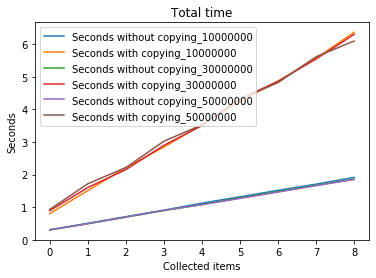

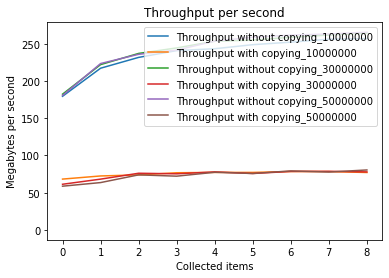

In [12]:
axes = df_times.plot(xlabel='Collected items', ylabel='Seconds', title='Total time')
axes.axhline(y=0, color='white', linestyle='-')
axes = df_throughputs.plot(xlabel='Collected items', ylabel='Megabytes per second', title='Throughput per second')
axes.axhline(y=0, color='white', linestyle='-')

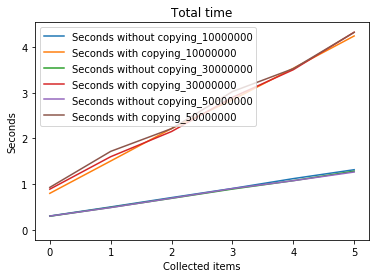

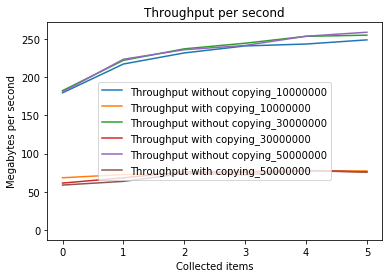

In [13]:
axes = df_times.iloc[:-3].plot(xlabel='Collected items', ylabel='Seconds', title='Total time')
axes.axhline(y=0, color='white', linestyle='-')
axes = df_throughputs.iloc[:-3].plot(xlabel='Collected items', ylabel='Megabytes per second', title='Throughput per second')
axes.axhline(y=0, color='white', linestyle='-')

In [14]:
df_times_throughputs.to_csv('df_times_throughputs.csv', index_label='index')

In [13]:
events, events_overflows, pcs, clk_counters, instrs, instr_names, instr_strings, fifo_full_ticks_counts, all_gp_regs = parse_last_dma_transfer(input_buffer_all_transfers_copied[0], 120000, dont_decode=True)

In [17]:
instr_names[:4]

['JALR', 'UNKNOWN', 'BNE', 'AUIPC']

In [5]:
function_a_addr = '80000038' # from performance_test.bin
getchar_addr = '800000F0' # from performance_test.bin
print('function_a calls =', (df['pc'] == function_a_addr).sum())
print('getchar calls =', (df['pc'] == getchar_addr).sum())

function_a calls = 10000
getchar calls = 5


In [6]:
df[df['pc'] == function_a_addr]

pc  clk_counter     instr instr_names     instr_strings  \
69     80000038            4  FE010113        ADDI  addi x2, x2, -32   
75     80000038            1  FE010113        ADDI  addi x2, x2, -32   
81     80000038            1  FE010113        ADDI  addi x2, x2, -32   
87     80000038            1  FE010113        ADDI  addi x2, x2, -32   
93     80000038            1  FE010113        ADDI  addi x2, x2, -32   
...         ...          ...       ...         ...               ...   
18039  80000038            1  FE010113        ADDI  addi x2, x2, -32   
18045  80000038            1  FE010113        ADDI  addi x2, x2, -32   
18051  80000038            1  FE010113        ADDI  addi x2, x2, -32   
18057  80000038            1  FE010113        ADDI  addi x2, x2, -32   
18063  80000038            1  FE010113        ADDI  addi x2, x2, -32   

       fifo_full_ticks_counts  Core__TRAP  Core__BRANCH  Core__JAL  \
69                          0           0             0          1   
75                          0           0             0          1   
81                          0           0             0          1   
87                          0           0             0          1   
93                          0           0             0          1   
...                       ...         ...           ...        ...   
18039                       0           0             0          1   
18045                       0           0             0          1   
18051                       0           0             0          1   
18057                       0           0             0          1   
18063                       0           0             0          1   

       Core__JALR  ...  AXI4_Slave__AR_FLIT  AXI4_Slave__R_FLIT  \
69              0  ...                    0                   0   
75              0  ...                    0                   0   
81              0  ...                    0                   0   
87              0  ...                    0                   0   
93              0  ...                    0                   0   
...           ...  ...                  ...                 ...   
18039           0  ...                    0                   0   
18045           0  ...                    0                   0   
18051           0  ...                    0                   0   
18057           0  ...                    0                   0   
18063           0  ...                    0                   0   

       AXI4_Slave__R_FLIT_FINAL  AXI4_Master__AW_FLIT  AXI4_Master__W_FLIT  \
69                            0                     0                    0   
75                            0                     0                    0   
81                            0                     0                    0   
87                            0                     0                    0   
93                            0                     0                    0   
...                         ...                   ...                  ...   
18039                         0                     0                    0   
18045                         0                     0                    0   
18051                         0                     0                    0   
18057                         0                     0                    0   
18063                         0                     0                    0   

       AXI4_Master__W_FLIT_FINAL  AXI4_Master__B_FLIT  AXI4_Master__AR_FLIT  \
69                             0                    0                     0   
75                             0                    0                     0   
81                             0                    0                     0   
87                             0                    0                     0   
93                             0                    0                     0   
...                          ...                  ...                   ...   
18039       

In [7]:
df

pc  clk_counter     instr instr_names  \
0          1010          570  00028067        JALR   
1      80000000           35  F14022F3     UNKNOWN   
2      80000004            1  02029063         BNE   
3      80000008            1  00010117       AUIPC   
4      80000010            2  1880006F         JAL   
...         ...          ...       ...         ...   
18063  80000038            1  FE010113        ADDI   
18064  80000070           65  00008067        JALR   
18065  8000021C            1  00050793        ADDI   
18066  8000024C           24  FCF740E3         BLT   
18067  80000250          258  10500073         WFI   

                                     instr_strings  fifo_full_ticks_counts  \
0                                   jalr x0, x5, 0                       0   
1      Cannot decode f14022f3, invalid instruction                       0   
2                                 bne x5, x0, .+32                       0   
3                                     auipc x2, 16                       0   
4                                    jal x0, .+392                       0   
...                                            ...                     ...   
18063                             addi x2, x2, -32                       0   
18064                               jalr x0, x1, 0                      46   
18065                             addi x15, x10, 0                       0   
18066                           blt x14, x15, .-64                       7   
18067                                        ecall                       0   

       Core__TRAP  Core__BRANCH  Core__JAL  Core__JALR  ...  \
0               0             0          0           0  ...   
1               0             0          0           1  ...   
2               0             0          0           0  ...   
3               0             1          0           0  ...   
4               0             0          0           0  ...   
...           ...           ...        ...         ...  ...   
18063           0             0          1           0  ...   
18064           0             0          0           0  ...   
18065           0             0          0           1  ...   
18066           0             0          0           0  ...   
18067           0             1          0           0  ...   

       AXI4_Slave__AR_FLIT  AXI4_Slave__R_FLIT  AXI4_Slave__R_FLIT_FINAL  \
0                        1                   8                         1   
1                        0                   0                         0   
2                        0                   0                         0   
3                        0                   0                         0   
4                        0                   0                         0   
...                    ...                 ...                       ...   
18063                    0                   0                         0   
18064                    0                   0                         0   
18065                    0                   0                         0   
18066                    0                   0                         0   
18067                    0                   0                         0   

       AXI4_Master__AW_FLIT  AXI4_Master__W_FLIT  AXI4_Master__W_FLIT_FINAL  \
0                         0                    0                          0   
1                         0                    0                          0   
2                         0                    0                          0   
3                         0                    0                          0   
4                         0                    0                          0   
...                     ...                  ...                        ...   
18063                     0                    0                          0   
18064                     2                    2                          2   
18065                     0                   

In [5]:
items_transferred = -1
dma_transfer_end_time = 0
def worker():
    global items_transferred, dma_transfer_end_time
    items_transferred = get_dma_transfer(input_buffer, dma_rec)#, dont_wait=True)#
    dma_transfer_end_time = time.time()
    print(items_transferred)
    
t = Thread(daemon=True, target=worker)
t.start()

In [8]:
dma_rec.transfer(input_buffer)
#dma_rec.wait()

In [12]:
dma_rec.wait()

KeyboardInterrupt: 

In [13]:
dma_rec.transferred

5609472

In [13]:
print_fifo_data_counts()
before_cpu_reset_time = time.time()
reset_cpu()

gpio_fifo_wr_count = 0
gpio_fifo_rd_count = 0


In [44]:
print_fifo_data_counts()

gpio_fifo_wr_count = 2050
gpio_fifo_rd_count = 0


In [8]:
#items_transferred = get_dma_transfer(input_buffer, dma_rec)#, dont_wait=True)

In [8]:
t.is_alive()

False

In [9]:
dma_transfer_end_time - before_cpu_reset_time 

-1676142252.9835927

In [10]:
items_transferred

-1

In [10]:
t.join()

In [14]:
#items_transferred = 35000
items_transferred = 5000


In [45]:
items_transferred = get_dma_transfer(input_buffer, dma_rec)

In [46]:
items_transferred

10

In [47]:
events, events_overflows, pcs, clk_counters, instrs, instr_names, instr_strings, fifo_full_ticks_counts, all_gp_regs = parse_input_buffer(input_buffer, items_transferred, dont_decode=True)

0.00020742416381835938s
0.0001735687255859375s
0.00014829635620117188s
0.00014019012451171875s
0.00013971328735351562s
0.00014829635620117188s
0.00013566017150878906s
0.00013256072998046875s
0.0001289844512939453s
0.0001983642578125s


In [48]:
for i, (pc, instr, instr_str, clk_counter, instr_name, fifo_full_ticks_count, gp_regs) in enumerate(zip(pcs, instrs, instr_strings, clk_counters, instr_names, fifo_full_ticks_counts, all_gp_regs)):
    print(f'{i:<4} CLK_DELTA={clk_counter:<14}PC={pc:>8X}    INSTR={instr:>08X}    INSTR_NAME={instr_name:<6}    FIFO_FULL_TICKS_COUNT={fifo_full_ticks_count:<14}\n    A0={gp_regs["A0"]:>08X}    A1={gp_regs["A1"]:>08X}    A2={gp_regs["A2"]:>08X}    A3={gp_regs["A3"]:>08X}    {instr_str}')
    print()

TypeError: string indices must be integers

In [37]:
for i, (pc, instr, instr_str, clk_counter, instr_name, fifo_full_ticks_count, gp_regs) in enumerate(zip(pcs, instrs, instr_strings, clk_counters, instr_names, fifo_full_ticks_counts, all_gp_regs)):
    if i > 31240:
        print(f'{i:<4} CLK_DELTA={clk_counter:<14}PC={pc:>8X}    INSTR={instr:>08X}    INSTR_NAME={instr_name:<6}    FIFO_FULL_TICKS_COUNT={fifo_full_ticks_count:<14}\n    A0={gp_regs["A0"]:>08X}    A1={gp_regs["A1"]:>08X}    A2={gp_regs["A2"]:>08X}    A3={gp_regs["A3"]:>08X}    {instr_str}')
        print()
    if i > 31260:
        break

31241 CLK_DELTA=1             PC=8000021C    INSTR=00050793    INSTR_NAME=ADDI      FIFO_FULL_TICKS_COUNT=0             
    A0=000014D1    A1=00001020    A2=00000000    A3=00000000    -

31242 CLK_DELTA=24            PC=8000024C    INSTR=FCF740E3    INSTR_NAME=BLT       FIFO_FULL_TICKS_COUNT=7             
    A0=000014D1    A1=00001020    A2=00000000    A3=00000000    -

31243 CLK_DELTA=1             PC=8000020C    INSTR=FE442783    INSTR_NAME=LW        FIFO_FULL_TICKS_COUNT=0             
    A0=000014D1    A1=00001020    A2=00000000    A3=00000000    -

31244 CLK_DELTA=4             PC=80000218    INSTR=E21FF0EF    INSTR_NAME=JAL       FIFO_FULL_TICKS_COUNT=0             
    A0=0000004A    A1=00001020    A2=00000000    A3=00000000    -

31245 CLK_DELTA=1             PC=80000038    INSTR=FE010113    INSTR_NAME=ADDI      FIFO_FULL_TICKS_COUNT=0             
    A0=0000004A    A1=00001020    A2=00000000    A3=00000000    -

31246 CLK_DELTA=65            PC=80000070    INSTR=00008067 

In [11]:
df = pd.DataFrame(zip(pcs,clk_counters,instrs,instr_names,instr_strings,fifo_full_ticks_counts), columns=['pc','clk_counter','instr', 'instr_names', 'instr_strings', 'fifo_full_ticks_counts'])
# all_gp_regs is a list of dicts, it is joined below into the main dataframe
df = df.join( pd.DataFrame.from_dict(all_gp_regs) )
df.iloc[:,0] = df.iloc[:,0].apply(lambda x: f'{x:08X}')
df[:20]

pc  clk_counter  instr instr_names instr_strings  \
0   00000000            0      0     UNKNOWN             -   
1   00000000            0      0     UNKNOWN             -   
2   00000000            0      0     UNKNOWN             -   
3   00000000            0      0     UNKNOWN             -   
4   00000000            0      0     UNKNOWN             -   
5   00000000            0      0     UNKNOWN             -   
6   00000000            0      0     UNKNOWN             -   
7   00000000            0      0     UNKNOWN             -   
8   00000000            0      0     UNKNOWN             -   
9   00000000            0      0     UNKNOWN             -   
10  00000000            0      0     UNKNOWN             -   
11  00000000            0      0     UNKNOWN             -   
12  00000000            0      0     UNKNOWN             -   
13  00000000            0      0     UNKNOWN             -   
14  00000000            0      0     UNKNOWN             -   
15  00000000            0      0     UNKNOWN             -   
16  00000000            0      0     UNKNOWN             -   
17  00000000            0      0     UNKNOWN             -   
18  00000000            0      0     UNKNOWN             -   
19  00000000            0      0     UNKNOWN             -   

    fifo_full_ticks_counts  A0  A1  A2  A3  
0                        0   0   0   0   0  
1                        0   0   0   0   0  
2                        0   0   0   0   0  
3                        0   0   0   0   0  
4                        0   0   0   0   0  
5                        0   0   0   0   0  
6                        0   0   0   0   0  
7                        0   0   0   0   0  
8                        0   0   0   0   0  
9                        0   0   0   0   0  
10                       0   0   0   0   0  
11                       0   0   0   0   0  
12                       0   0   0   0   0  
13                       0   0   0   0   0  
14                       0   0   0   0   0  
15                       0   0   0   0   0  
16                       0   0   0   0   0  
17                       0   0   0   0   0  
18                       0   0   0   0   0  
19                       0   0   0   0   0

In [8]:
print_performance_stats(df)

normal_run_time = 0.0s
halted_time = 0.0s
performance_decrease = nan%


<ipython-input-1-19643f5913a0>:389: RuntimeWarning: invalid value encountered in double_scalars
  performance_decrease = 100.0 - normal_run_time / (normal_run_time + halted_time) * 100


In [14]:
dma_transfer_end_time - before_cpu_reset_time 

0.05956768989562988

In [14]:
df[df['instr']!=0].iloc[:30]

pc  clk_counter       instr instr_names instr_strings  \
0   00001010          570      163943        JALR             -   
1   80000000           35  4047512307     UNKNOWN             -   
2   80000004            1    33722467         BNE             -   
3   80000008            1       65815       AUIPC             -   
4   80000010            2   411041903         JAL             -   
5   80000198           35  4261478675        ADDI             -   
6   800001B0           10    58720367         JAL             -   
7   800001E8           51  4037013743         JAL             -   
8   80000104           75  4213174511         JAL             -   
9   800000B4           38  4278255891        ADDI             -   
10  800000EC          100       32871        JALR             -   
11  80000108            1      329619        ADDI             -   
12  8000010C            1  4261907683         BEQ             -   
13  80000110            1        1943       AUIPC             -   
14  8000013C           20       32871        JALR             -   
15  800001EC            1      329619        ADDI             -   
16  800001E8           57  4037013743         JAL             -   
17  800000F0            1  4278255891        ADDI             -   
18  80000104            7  4213174511         JAL             -   
19  800000B4            1  4278255891        ADDI             -   
20  800000EC           45       32871        JALR             -   
21  80000108            1      329619        ADDI             -   
22  8000010C            1  4261907683         BEQ             -   
23  80000110            1        1943       AUIPC             -   
24  8000013C           20       32871        JALR             -   
25  800001EC            1      329619        ADDI             -   
26  80000200            7  4210498275         BNE             -   
27  800001B4            4  4270073731          LW             -   
28  800001E8           16  4037013743         JAL             -   
29  800000F0            1  4278255891        ADDI             -   

    fifo_full_ticks_counts  A0    A1  A2  A3  
0                        0   0  4128   0   0  
1                        0   0  4128   0   0  
2                        0   0  4128   0   0  
3                        0   0  4128   0   0  
4                        0   0  4128   0   0  
5                        0   0  4128   0   0  
6                        0   0  4128   0   0  
7                        0   0  4128   0   0  
8                        0   0  4128   0   0  
9                        0   0  4128   0   0  
10                       0   1  4128   0   0  
11                       0   1  4128   0   0  
12                       0   1  4128   0   0  
13                       0   1  4128   0   0  
14                       0  49  4128   0   0  
15                       0  49  4128   0   0  
16                       0  49  4128   0   0  
17                       0  49  4128   0   0  
18                       0  49  4128   0   0  
19                       0  49  4128   0   0  
20                       0   1  4128   0   0  
21                       0   1  4128   0   0  
22                       0   1  4128   0   0  
23                       0   1  4128   0   0  
24                       0  50  4128   0   0  
25                       0  50  4128   0   0  
26                       0  50  4128   0   0  
27                       0  50  4128   0   0  
28                       0  50  4128   0   0  
29                       0  50  4128   0   0

In [10]:
for instr in instrs: 
    name = get_riscv_instruction_name(instr)
    print(name)

JALR
UNKNOWN
BNE
AUIPC
JAL
ADDI
JAL
ADDI
UNKNOWN
JAL
LW
BGEU
ADDI
JAL
ADDI
JALR
LW
BGEU
ADDI
JAL
ADDI
JALR
LW
BGEU
ADDI
JAL
ADDI
JALR
LW
BGEU
ADDI
JAL
ADDI
JALR
LW
BGEU
ADDI
JAL
ADDI
JALR
LW
BGEU
ADDI
JAL
ADDI
JALR
LW
BGEU
ADDI
JAL
ADDI
JALR
LW
BGEU
ADDI
JAL
ADDI
JALR
LW
BGEU
ADDI
JAL
ADDI
JALR
LW
BGEU
ADDI
JAL
ADDI
JALR
LW
BGEU
ADDI
JAL
ADDI
JALR
LW
BGEU
ADDI
JAL
ADDI
JALR
LW
BGEU
AUIPC
JALR
JAL
ADDI
UNKNOWN
JAL
ADDI
JAL
UNKNOWN
BNE
UNKNOWN
JAL
ADDI
JALR
UNKNOWN
BNE
UNKNOWN
JAL
ADDI
JALR
UNKNOWN
BNE
UNKNOWN
JAL
ADDI
JALR
UNKNOWN
BNE
UNKNOWN
JAL
ADDI
JALR
UNKNOWN
BNE
UNKNOWN
JAL
ADDI
JALR
UNKNOWN
BNE
UNKNOWN
JAL
ADDI
JALR
UNKNOWN
BNE
UNKNOWN
JAL
ADDI
JALR
UNKNOWN
BNE
UNKNOWN
JAL
ADDI
JALR
UNKNOWN
BNE
UNKNOWN
JAL
ADDI
JALR
UNKNOWN
BNE
UNKNOWN
JAL
ADDI
JALR
UNKNOWN
BNE
UNKNOWN
JAL
ADDI
JALR
UNKNOWN
BNE
UNKNOWN
JAL
ADDI
JALR
UNKNOWN
BNE
UNKNOWN
JAL
ADDI
JALR
UNKNOWN
BNE
UNKNOWN
JAL
ADDI
JALR
UNKNOWN
BNE
UNKNOWN
JAL
ADDI
JALR
UNKNOWN
BNE
UNKNOWN
JAL
ADDI
JALR
UNKNOWN
BNE
UNKNOWN
JAL
ADDI
J

In [42]:
halted_times = []
normal_run_times = []
total_run_times = []
performance_decreases = []
performances = []
items_counts = []
bytes_per_second_list = []
#i = 100


start_point = 25000
i = start_point
#while i < 30_000:
while i < items_transferred:
    halted_time, normal_run_time, performance_decrease = get_performance_stats(df.iloc[start_point:i])
    halted_times.append(halted_time)
    normal_run_times.append(normal_run_time)
    performance_decreases.append(performance_decrease)
    total_run_time = normal_run_time + halted_time
    total_run_times.append(total_run_time)
    items_counts.append(i-start_point)
    performances.append(100 - performance_decrease)
    
    bytes_per_second_list.append(((i - start_point) * AXI_DATA_WIDTH) / total_run_time // 8)
    #print(i, halted_time, normal_run_time, performance_decrease)
    print(i)
    i = i + 50
    
df_perf = pd.DataFrame(zip(halted_times, normal_run_times, total_run_times, performance_decreases, performances, bytes_per_second_list),
                      columns=['Halted', 'Normal', 'With PYNQ wrapper', 'Performance decrease', 'Performance', 'Bytes per second'], 
                      index=items_counts)
    

<ipython-input-1-4f462425ee7c>:315: RuntimeWarning: invalid value encountered in double_scalars
  performance_decrease = 100.0 - normal_run_time / (normal_run_time + halted_time) * 100
<ipython-input-42-79a8d2176c3a>:24: RuntimeWarning: invalid value encountered in double_scalars
  bytes_per_second_list.append(((i - start_point) * AXI_DATA_WIDTH) / total_run_time // 8)


25000
25050
25100
25150
25200
25250
25300
25350
25400
25450
25500
25550
25600
25650
25700
25750
25800
25850
25900
25950
26000
26050
26100
26150
26200
26250
26300
26350
26400
26450
26500
26550
26600
26650
26700
26750
26800
26850
26900
26950
27000
27050
27100
27150
27200
27250
27300
27350
27400
27450
27500
27550
27600
27650
27700
27750
27800
27850
27900
27950
28000
28050
28100
28150
28200
28250
28300
28350
28400
28450
28500
28550
28600
28650
28700
28750
28800
28850
28900
28950
29000
29050
29100
29150
29200
29250
29300
29350
29400
29450
29500
29550
29600
29650
29700
29750
29800
29850
29900
29950
30000
30050


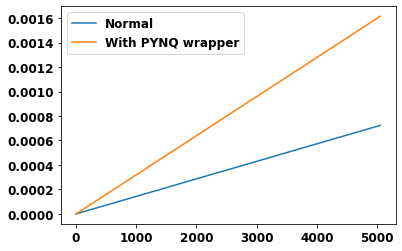

In [43]:
df_perf.drop(columns=['Performance decrease', 'Performance', 'Halted', 'Bytes per second']).plot()

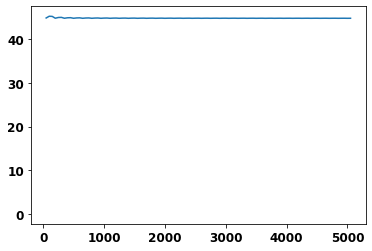

In [44]:
plt.axhline(y=0, color='white', linestyle='-')
df_perf['Performance'].plot()

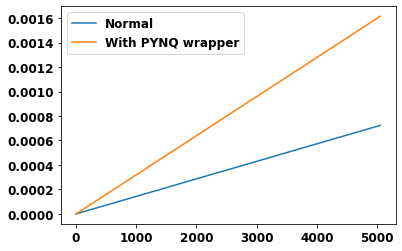

In [45]:
df_perf.loc[0:7500].drop(columns=['Performance decrease', 'Performance', 'Halted', 'Bytes per second']).plot()

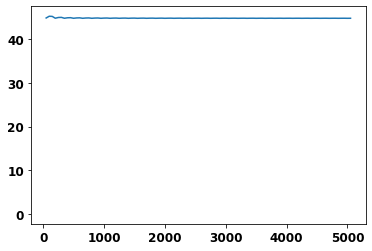

In [46]:
plt.axhline(y=0, color='white', linestyle='-')
df_perf['Performance'].loc[0:7500].plot()

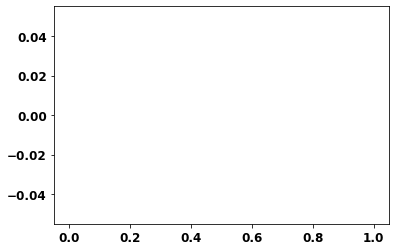

In [47]:
plt.axhline(y=0, color='white', linestyle='-')
df_perf['Bytes per second'].loc[29000:30001].plot()

In [48]:
df_perf['Bytes per second'].iloc[-1]

400188207.0

In [24]:
df_perf.to_csv('performance_stats.csv', index_label='index')

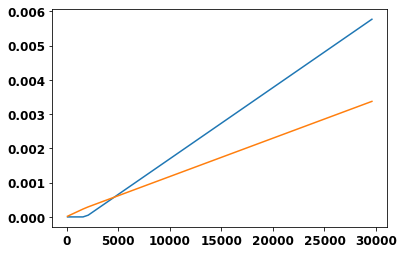

In [65]:
plt.plot(items_counts, halted_times, label='Halted')
plt.plot(items_counts, normal_run_times, label='Normal')
#plt.plot(items_counts, performance_penalties, label='Performance penalty')
#plt.legend()
#plt.show()

In [29]:
#import matplotlib.pyplot as plt

In [11]:
# print performance counters for the first 10 datapoints/instructions from data above
df = pd.DataFrame(events, columns=event_names)
df.iloc[:20]

Core__TRAP  Core__BRANCH  Core__JAL  Core__JALR  Core__AUIPC  Core__LOAD  \
0            0             0          0           0            1           1   
1            0             0          0           1            0           0   
2            0             0          0           0            0           0   
3            0             1          0           0            0           0   
4            0             0          0           0            1           0   
5            0             0          1           0            0           0   
6            0             0          0           0            0           0   
7            0             0          1           0            0           0   
8            0             0          0           0            0           0   
9            0             0          0           0            0           0   
10           0             0          1           0            0           0   
11           0             0          0           0            0           1   
12           0             1          0           0            0           0   
13           0             0          0           0            0           1   
14           0             0          1           0            0           0   
15           0             0          0           0            0           1   
16           0             0          0           1            0           0   
17           0             0          0           0            0           2   
18           0             1          0           0            0           0   
19           0             0          0           0            0           1   

    Core__STORE  Core__SERIAL_SHIFT  Core__LOAD_WAIT  Core__STORE_WAIT  ...  \
0             0                   0               21                 0  ...   
1             0                   0                0                 0  ...   
2             0                   0                0                 0  ...   
3             0                   0                0                 0  ...   
4             0                   0                0                 0  ...   
5             0                   0                0                 0  ...   
6             2                   0                0                 2  ...   
7             0                   0                0                 0  ...   
8             0                   0                0                 0  ...   
9             3                   0                0                 3  ...   
10            0                   0                0                 0  ...   
11            0                   0               40                 0  ...   
12            0                   0                0                 0  ...   
13            0                   1                0                 0  ...   
14            0                   0                0                 0  ...   
15            2                   0               50                 2  ...   
16            0                   0                0                 0  ...   
17            1                   0                0                 1  ...   
18            0                   0                0                 0  ...   
19            0                   1                0                 0  ...   

    AXI4_Slave__AR_FLIT  AXI4_Slave__R_FLIT  AXI4_Slave__R_FLIT_FINAL  \
0                     1                   8                         1   
1                     0                   0                         0   
2                     0                   0                         0   
3                     0                   0                         0   
4                     0                   0                         0   
5                     0                   0                         0   
6                     0                   0                         0   
7                     0                   0                         0   
8     

In [12]:
for eo in events_overflows:
    if eo: 
        print(eo)

In [13]:
event_names

['Core__TRAP',
 'Core__BRANCH',
 'Core__JAL',
 'Core__JALR',
 'Core__AUIPC',
 'Core__LOAD',
 'Core__STORE',
 'Core__SERIAL_SHIFT',
 'Core__LOAD_WAIT',
 'Core__STORE_WAIT',
 'Core__F_BUSY_NO_CONSUME',
 'Core__1_BUSY_NO_CONSUME',
 'Core__2_BUSY_NO_CONSUME',
 'Core__INTERRUPT',
 'L1I__LD',
 'L1I__LD_MISS',
 'L1I__LD_MISS_LAT',
 'L1I__TLB',
 'L1D__LD',
 'L1D__LD_MISS',
 'L1D__LD_MISS_LAT',
 'L1D__ST',
 'L1D__TLB',
 'TGC__READ',
 'TGC__READ_MISS',
 'AXI4_Slave__AW_FLIT',
 'AXI4_Slave__W_FLIT',
 'AXI4_Slave__W_FLIT_FINAL',
 'AXI4_Slave__B_FLIT',
 'AXI4_Slave__AR_FLIT',
 'AXI4_Slave__R_FLIT',
 'AXI4_Slave__R_FLIT_FINAL',
 'AXI4_Master__AW_FLIT',
 'AXI4_Master__W_FLIT',
 'AXI4_Master__W_FLIT_FINAL',
 'AXI4_Master__B_FLIT',
 'AXI4_Master__AR_FLIT',
 'AXI4_Master__R_FLIT',
 'AXI4_Master__R_FLIT_FINAL']

In [14]:
# event name format is "CATEGORY__NAME"
df.mean(axis=0).sort_values(ascending=False)[:-1]

L1I__TLB                     3.943674
L1I__LD                      3.943674
L1D__TLB                     1.585789
Core__1_BUSY_NO_CONSUME      1.224437
L1D__LD                      0.996534
Core__LOAD                   0.996534
Core__2_BUSY_NO_CONSUME      0.751300
Core__F_BUSY_NO_CONSUME      0.738302
L1I__LD_MISS_LAT             0.738302
Core__STORE_WAIT             0.710572
AXI4_Slave__W_FLIT           0.589255
AXI4_Slave__W_FLIT_FINAL     0.589255
AXI4_Slave__B_FLIT           0.589255
AXI4_Master__AW_FLIT         0.589255
AXI4_Master__W_FLIT          0.589255
L1D__ST                      0.589255
AXI4_Slave__AW_FLIT          0.589255
AXI4_Master__W_FLIT_FINAL    0.589255
AXI4_Master__B_FLIT          0.589255
Core__STORE                  0.589255
TGC__READ                    0.474003
Core__LOAD_WAIT              0.441075
L1D__LD_MISS_LAT             0.370017
Core__BRANCH                 0.173310
Core__JAL                    0.169844
Core__JALR                   0.160312
Core__AUIPC 

In [15]:
def select_performance_counters(df):
    #hardcoded_ones = ['Core__TRAP', 'Core__INTERRUPT']
    df_max = df.max(axis=0)
    return df_max[df_max > 0].index.tolist()

select_performance_counters(df)

['Core__BRANCH',
 'Core__JAL',
 'Core__JALR',
 'Core__AUIPC',
 'Core__LOAD',
 'Core__STORE',
 'Core__SERIAL_SHIFT',
 'Core__LOAD_WAIT',
 'Core__STORE_WAIT',
 'Core__F_BUSY_NO_CONSUME',
 'Core__1_BUSY_NO_CONSUME',
 'Core__2_BUSY_NO_CONSUME',
 'L1I__LD',
 'L1I__LD_MISS',
 'L1I__LD_MISS_LAT',
 'L1I__TLB',
 'L1D__LD',
 'L1D__LD_MISS',
 'L1D__LD_MISS_LAT',
 'L1D__ST',
 'L1D__TLB',
 'TGC__READ',
 'TGC__READ_MISS',
 'AXI4_Slave__AW_FLIT',
 'AXI4_Slave__W_FLIT',
 'AXI4_Slave__W_FLIT_FINAL',
 'AXI4_Slave__B_FLIT',
 'AXI4_Slave__AR_FLIT',
 'AXI4_Slave__R_FLIT',
 'AXI4_Slave__R_FLIT_FINAL',
 'AXI4_Master__AW_FLIT',
 'AXI4_Master__W_FLIT',
 'AXI4_Master__W_FLIT_FINAL',
 'AXI4_Master__B_FLIT',
 'AXI4_Master__AR_FLIT',
 'AXI4_Master__R_FLIT',
 'AXI4_Master__R_FLIT_FINAL']

In [16]:
df.max(axis=0).sort_values(ascending=False)[:-1]
df['Core__LOAD_WAIT'].sort_values()[-30:]

371       0
422       0
385       0
384       0
383       0
382       0
381       0
380       0
374       0
379       0
421       0
377       0
376       0
375       0
378       0
416       0
983       7
937       7
881       7
877      14
0        21
979      22
933      25
775      36
11       40
97       42
15       50
387      52
1074     70
93      116
Name: Core__LOAD_WAIT, dtype: int64

In [14]:
console_io.data_available()

False

In [5]:
console_io.read()

'===================A40200800000000\n'

In [37]:
console_io.send('BCD', end_byte=ord('\n'))

In [20]:
#console_io.send('AAAA')

In [21]:
# import matplotlib.pyplot as plt
# plt.plot(pcs)
# plt.show()